# Fits over Directory
Run analysis procedures over directory to get fits and plots. Probably have to do manual labour but lets see...

In [1]:
#importing directories
from random import gauss
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
from astropy.io import ascii, fits
#from ellc import lc
from transit import occultnonlin, occultquad
from scipy.signal import find_peaks

Global Constants over entire code

In [2]:
rv_entry=ascii.read('../../Catalogs/robovetter_label.dat')
rv_pl=np.array(rv_entry['tce_plnt_num'])
rv_label = np.array(rv_entry['label'])
rv_kepid=[('0000'+str(el)[:9])[-9:] for el in rv_entry['kepid']]
u1=np.array(rv_entry['u1'])
u2=np.array(rv_entry['u2'])
b=np.array(rv_entry['b'])
rpl=np.array(rv_entry['rpl_rstar'])
rorb=np.array(rv_entry['rorb_rstar'])



Fitting Functions: Gaussian, Lorentzian, Planet Transit

In [3]:
def gausses(x, A1, m1, s1, A2, m2, s2):
    y = A1*np.exp(-(x-m1)**2/(2*s1**2)) + A2*np.exp(-(x-m2)**2/(2*s2**2))
    return(y)

def lorz(x,A1,x0,g, A2, x02, g2):
    y = A1 / (1*((x-x0)**2+(g/2)**2)) + A2 / (1*((x-x02)**2+(g2/2)**2))
    return(y)

def new_plar(ph,p,minus, plus,rorb):
    u1 = (plus + minus)/2
    u2 = (plus - minus)/2
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free(ph,p,u1,plus,rorb):
    u2 = plus - u1
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free2(ph,p,u1,u2,rorb, imp):
    znp = np.sqrt(np.abs(rorb*np.sin(ph*np.pi))**2+imp**2)
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

# def new_plar_v2(ph,p,u1,u2,rorb, imp):
#     incl = np.arccos(imp/rorb)*180/np.pi
#     a= lc(ph,radius_1=1/rorb,radius_2=p/rorb,sbratio=0.0,incl=incl,ld_1='quad',ldc_1=[u1,u2],
#         shape_1='sphere', shape_2='sphere')
#     return(a -1) 

def smooth(arr,k=10):
    kernel = np.ones(k)/k
    v=np.convolve(arr, kernel, mode='same')
    return(v)


### Improved fitting
Not fitting models, but rather developing models from already fitted parameters in the catalog. Best way to filter bad stuff.
No rebin to 200 pixel local view ... using the full extent of the resolution.

In [5]:

def sort_data(hdu, hduno):
    flux = []
    flux_white=[]
    phase = []
    model = []
    tp = hdu[hduno].header['TPERIOD']
    for ph, fl,wl, ml in zip(hdu[hduno].data['PHASE'],hdu[hduno].data['LC_DETREND'],hdu[hduno].data['LC_WHITE'],hdu[hduno].data['MODEL_WHITE']):
        if not np.isnan(fl):
            flux.append(fl)
            if(ph*2/tp>1): phase.append(ph*2/tp -2)
            else: phase.append(ph*2/tp)
            flux_white.append(wl)
            model.append(ml)
    dfunb = pd.DataFrame(list(zip(phase, flux, flux_white, model)),columns=['phase', 'flux','flux_white', 'model'])
    df=dfunb.sort_values('phase',axis=0,ascending=True)
    df=df[(df.phase>-0.75) & (df.phase<0.75)]

    bins=np.linspace(min(df['phase']),max(df['phase']),8000)
    groups = df.groupby(np.digitize(df['phase'], bins))
    df=groups.median()
    
    # print('size:',len(df)) 
    return(df, hdu[hduno].header['TPERIOD'], hdu[hduno].header['TDUR']/24)

def get_fit_residuals(df, kid, tp ,td, el):
    try: lc=new_plar_free2(np.array(df['phase']), rpl[kid],u1[kid], u2[kid], rorb[kid], b[kid])
    except: 
        print('weird error')
        return(0)
    res = np.array(df['flux'])-lc
    df=pd.DataFrame(list(zip(df['phase'], df['flux'], df['flux_white'], df['model'],lc, res)),
        columns=['phase', 'flux','flux_white', 'model','par','res'])
    
    locdf=df[(df.phase>-2*td/tp) & (df.phase<2*td/tp)]
    out = df[(df.phase<-2*td/tp) | (df.phase>2*td/tp)]
    
    noise = np.std(np.array(out['res']))
    # popt1, pcov1 = curve_fit(gausses, locdf['phase']*0.9, locdf['res'], p0=[max(res),min(locdf['phase'])/2,0.01,max(res),max(locdf['phase'])/2,0.01],
    #     bounds=([max(res)/2,min(locdf['phase'])*0.9,
    #     0.001,max(res)/2,0,0.001], [max(res), 0, np.inf,max(res), max(locdf['phase'])*0.9,np.inf]))
    res=np.array(locdf['res'])
    ph = np.array(locdf['phase'])
    peaks, _ = find_peaks(res, height=max(res)/2, distance=30)
    try: ins=max([res[x] for x in peaks if(ph[x]<0 and ph[x]>min(ph)/1.9)])
    except: ins=0
    # if(popt1[1]>noise and popt1[4]>noise and popt1[2]-popt1[5]< td/tp): print('bingo')

    #print(ph[peaks])
    #plotting everything:
    fig, ax=plt.subplots(3,1, figsize=(7,10))
    ax[0].plot(df['phase'],df['flux'], label='flux')
    ax[0].plot(df['phase'],lc, label='model')
    ax[0].set_ylabel('flux')

    ax[1].plot(locdf['phase'],locdf['flux'], label='flux')
    ax[1].plot(locdf['phase'],locdf['par'], label='model')
    
    
    plt.suptitle(el+':'+str(np.array(rv_label)[kid]))
    ax[0].set_title('rpl'+str(np.around(rpl[kid],2))+'u1'+str(np.around(u1[kid],2))+'u2'+str(np.around(u2[kid],2))+
        'rorb'+str(np.around(rorb[kid],2))+'b'+str(np.around(b[kid],2)))
    # ax[2].set_title('a1:'+str(np.around(popt1[0],5))+' m1: '+str(np.around(popt1[1],2))+' s1: '+str(np.around(popt1[2],2))+' a2: '
    #     +str(np.around(popt1[3],5))+ 'm2: '+str(np.around(popt1[4],2))+' s2: '+str(np.around(popt1[5],2)))
    ax[2].set_title('snr:'+str(np.around(ins/noise,4)))
    ax[2].plot(locdf['phase'],locdf['res'], label='residual')
    #ax[2].plot(locdf['phase'],gausses(locdf['phase'], *popt1), label='fit')
    
    ax[2].plot(ph[peaks], res[peaks], "o")
    ax[2].set_xlabel('phase')
    ax[2].set_ylabel('flux - model')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    #store data
    c1=np.array([(x<0 and x>min(ph)/1.9) for x in ph[peaks]]).sum()
    c2=np.array([(x>0 and x<max(ph)/1.9) for x in ph[peaks]]).sum()

       

    if(c1>0 and c2>0 and len(ph[peaks])-c1-c2<c1+c2 and ins/noise>3): 
        print('yay', c1, c2,len(ph[peaks])-c1-c2)
        store = pd.HDFStore('../../processed_directories/go_circles/new_data/'+el)
        store.put('data', df)
        store.get_storer('data').attrs.metadata = {'ploc':ph[peaks],'pval':res[peaks],'label':rv_label[kid],'rorb':rorb[kid],'rpl':rpl[kid]
            ,'u1':u1[kid],'u2':u2[kid],'b':b[kid],'tp':tp,'td':td, 'snr':ins/noise}
        store.close()
        plt.savefig('../../processed_directories/go_circles/new_fits/'+el+'.jpg')
    else: 
        print('nay', c1, c2, len(ph[peaks])-c1-c2)
        store = pd.HDFStore('../../processed_directories/go_circles/new_data_stash/'+el)
        store.put('data', df)
        store.get_storer('data').attrs.metadata = {'ploc':ph[peaks],'pval':res[peaks],'label':rv_label[kid],'rorb':rorb[kid],'rpl':rpl[kid]
            ,'u1':u1[kid],'u2':u2[kid],'b':b[kid],'tp':tp,'td':td, 'snr':ins/noise}
        store.close()
        plt.savefig('../../processed_directories/go_circles/new_fits_stash/'+el+'.jpg')

    # df['mfitres']=gausses(df['phase'], *popt1)

    plt.close()

def get_fit_residuals_crude(df, tp ,td, el):
    print(el)
    
    res = np.array(df['flux_white'])-np.array(df['model'])
    df=pd.DataFrame(list(zip(df['phase'], df['flux'], df['flux_white'], df['model'], res)),
        columns=['phase', 'flux','flux_white', 'model','res'])
    
    locdf=df[(df.phase>-2*td/tp) & (df.phase<2*td/tp)]
    out = df[(df.phase<-2*td/tp) | (df.phase>2*td/tp)]
    
    noise = np.std(np.array(out['res']))
    # popt1, pcov1 = curve_fit(gausses, locdf['phase']*0.9, locdf['res'], p0=[max(res),min(locdf['phase'])/2,0.01,max(res),max(locdf['phase'])/2,0.01],
    #     bounds=([max(res)/2,min(locdf['phase'])*0.9,
    #     0.001,max(res)/2,0,0.001], [max(res), 0, np.inf,max(res), max(locdf['phase'])*0.9,np.inf]))
    res=np.array(locdf['res'])
    ph = np.array(locdf['phase'])
    try: 
        peaks, _ = find_peaks(res, height=max(res)/2, distance=30)
        ins=max([res[x] for x in peaks if(ph[x]<0 and ph[x]>min(ph)/1.9)])
    except:
         ins=0
         return(0)
    # if(popt1[1]>noise and popt1[4]>noise and popt1[2]-popt1[5]< td/tp): print('bingo')

    #print(ph[peaks])
    #plotting everything:
    fig, ax=plt.subplots(3,1, figsize=(7,10))
    ax[0].plot(df['phase'],df['flux_white'], label='flux')
    ax[0].plot(df['phase'],df['model'], label='model')
    ax[0].set_ylabel('flux')

    ax[1].plot(locdf['phase'],locdf['flux_white'], label='flux')
    ax[1].plot(locdf['phase'],locdf['model'], label='model')
    
    
    plt.suptitle(el)
    ax[0].set_title('rpl'+str(np.around(rpl[kid],2))+'u1'+str(np.around(u1[kid],2))+'u2'+str(np.around(u2[kid],2))+
        'rorb'+str(np.around(rorb[kid],2))+'b'+str(np.around(b[kid],2)))
    # ax[2].set_title('a1:'+str(np.around(popt1[0],5))+' m1: '+str(np.around(popt1[1],2))+' s1: '+str(np.around(popt1[2],2))+' a2: '
    #     +str(np.around(popt1[3],5))+ 'm2: '+str(np.around(popt1[4],2))+' s2: '+str(np.around(popt1[5],2)))
    ax[2].set_title('snr:'+str(np.around(ins/noise,4)))
    ax[2].plot(locdf['phase'],locdf['res'], label='residual')
    #ax[2].plot(locdf['phase'],gausses(locdf['phase'], *popt1), label='fit')
    
    ax[2].plot(ph[peaks], res[peaks], "o")
    ax[2].set_xlabel('phase')
    ax[2].set_ylabel('flux - model')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    #store data
    c1=np.array([(x<0 and x>min(ph)/1.9) for x in ph[peaks]]).sum()
    c2=np.array([(x>0 and x<max(ph)/1.9) for x in ph[peaks]]).sum()

       

    if(c1>0 and c2>0 and len(ph[peaks])-c1-c2<c1+c2 and ins/noise>3): 
        print('yay', c1, c2,len(ph[peaks])-c1-c2)
        store = pd.HDFStore('../../processed_directories/go_circles/new_data_2/'+el)
        store.put('data', df)
        store.get_storer('data').attrs.metadata = {'ploc':ph[peaks],'pval':res[peaks],'label':rv_label[kid],'rorb':rorb[kid],'rpl':rpl[kid]
            ,'u1':u1[kid],'u2':u2[kid],'b':b[kid],'tp':tp,'td':td, 'snr':ins/noise}
        store.close()
        plt.savefig('../../processed_directories/go_circles/new_fits_2/'+el+'.jpg')
    else: 
        print('nay', c1, c2, len(ph[peaks])-c1-c2)
        store = pd.HDFStore('../../processed_directories/go_circles/new_data_stash_2/'+el)
        store.put('data', df)
        store.get_storer('data').attrs.metadata = {'ploc':ph[peaks],'pval':res[peaks],'tp':tp,'td':td, 'snr':ins/noise}
        store.close()
        plt.savefig('../../processed_directories/go_circles/new_fits_stash_2/'+el+'.jpg')

    # df['mfitres']=gausses(df['phase'], *popt1)

    plt.close()


In [12]:
FILEPATH_FPS="E:\Masters_Project_Data\\alienworlds_fps\\"
entries = os.listdir(FILEPATH_FPS)

for el in entries[8000:]:
    hdu = fits.open(FILEPATH_FPS+el)
    print(el[4:13],"TCEs:", len(hdu)-2)
    kid=np.where(np.array(rv_kepid)==str(el[4:13]))[0]
    if(len(kid)==0): 
        print('not in catalog')
        continue

    for n in range(1,len(hdu)-1):
        kidf=[x for x in kid if(rv_pl[x]==n)] 
        if(len(kidf)==0): 
            print('not in catalog')
            continue
        kidf=kidf[0]
        df, tp, td = sort_data(hdu, n)
        print(rpl[kidf],u1[kidf], u2[kidf], rorb[kidf], b[kidf], tp, td)
        get_fit_residuals(df, kid, tp, td, el[4:13]+'_'+str(n))

        # df, tp, td = sort_data(hdu, n)
        # if(tp==0 or td==0):
        #     print('not fit') 
        #     continue
        # get_fit_residuals_crude(df, tp, td, el[4:13]+'_'+str(n))

    hdu.close()
        

    

005954001 TCEs: 1
0.007556 0.3671 0.2865 12.88 0.353 11.693267313863632 0.2591540352128625


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 0 2
005955197 TCEs: 1
0.028296 0.4535 0.2337 149.8 0.176 359.3247348619918 0.7863030622269397
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005955321 TCEs: 2
0.666546 0.3147 0.3032 11.9984 0.473 5.818933491335128 0.14583333333333331


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 4 0 1
not in catalog
005955427 TCEs: 1
0.023276 0.696 0.0604 105.9 0.214 213.19990016445888 0.6547708457112447
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005955621 TCEs: 2
0.008751 0.3729 0.2826 30.4 0.308 14.080215505344254 0.1446193380536493
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005956171 TCEs: 1
0.016636 0.3026 0.3029 150.3 0.668 402.2743268075219 0.6545699168593857
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005956342 TCEs: 4
0.021839 0.3728 0.2787 28.06 0.202 17.028924324962883 0.1976832405692747
weird error
0.014341 0.3728 0.2787 15.0 0.077 6.846150835219838 0.1555269220180531
weird error
0.02055 0.3728 0.2787 71.85 0.027 67.8326813256979 0.31394755167501387
weird error
0.020505 0.3728 0.2787 79.3 0.67 43.130829990663784 0.13445865828109543
weird error
005956354 TCEs: 1
0.011063 0.3588 0.2868 16.09 0.399 8.038776428001846 0.1644225484569607
nay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005956633 TCEs: 1
0.024655 0.412 0.258 177.1 0.235 365.9096803305093 0.24356297160576815
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005956656 TCEs: 2
0.012766 0.4603 0.2291 5.358 0.286 1.2248699884295386 0.0789111529325292
weird error
not in catalog
005956776 TCEs: 1
0.838661 0.24 0.3332 2.513 0.444 0.5691133531666482 0.0625
yay 12 11 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005956787 TCEs: 1
0.025083 0.5856 0.1392 2.275 0.068 0.5691115886605621 0.19348719183147686


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 21 15 20
005956977 TCEs: 1
0.019473 0.5864 0.1438 222.0 0.558 77.77326607581801 0.08147326326561825
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005959719 TCEs: 2
0.008644 0.4966 0.2043 19.83 0.148 6.738026149439432 0.11210898153988068
weird error
not in catalog
005959753 TCEs: 1
0.026057 0.582 0.1451 18.82 0.333 8.308651352813472 0.15496697775350773
nay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005961350 TCEs: 4
0.212787 0.2544 0.3299 10.483 0.96 5.262659288958558 0.1190046761549108
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
005962262 TCEs: 1
0.011032 0.582 0.1451 24.5 0.059 8.617426481321086 0.12649531943616504
nay 1 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005962509 TCEs: 1
0.00763 0.4341 0.2434 2.226 0.185 0.7900471762574548 0.13585392080077605
yay 12 16 25


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005962514 TCEs: 1
0.388484 0.2758 0.3272 1.789 0.65 0.790112294993869 0.21372054708973712
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005962716 TCEs: 2
0.488817 0.3236 0.3052 4.4461 0.879 1.8046053043338763 0.15430319831268235
nay 0 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005963222 TCEs: 3
0.081026 0.2736 0.3218 2.0048 0.878 1.2172556959269627 0.13076573135554356
yay 10 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
005963582 TCEs: 1
0.010853 0.4484 0.2357 20.74 0.44 25.543352797266493 0.3556764184577094
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005963591 TCEs: 1
0.023326 0.3147 0.3032 12.3 0.99 146.94306062439293 0.8928010156667426
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005965819 TCEs: 3
0.016179 0.4046 0.2638 19.27 0.529 8.239832704781875 0.24525352186062743
weird error
0.014368 0.4046 0.2638 11.379 0.012 19.590621976680453 0.2889138407377163
weird error
not in catalog
005966154 TCEs: 2
0.020797 0.3729 0.2826 17.77 0.867 25.67215229161186 0.24862427032041226
weird error
0.019153 0.3729 0.2826 62.0 0.788 151.8850677865521 0.5053510940720961
weird error
005966322 TCEs: 2
0.024899 0.3928 0.2676 75.319 0.009 60.928315920259806 0.2708059533126686
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005966660 TCEs: 1
0.020059 0.273 0.3167 1.6712 0.98 1.906644219638463 0.09246141384312138
yay 4 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005966732 TCEs: 1
0.0109 0.3026 0.3029 12.03 0.196 1.4009043755782 0.02703807194738839
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005966810 TCEs: 1
0.028265 0.3671 0.2865 106.04 0.002 247.89051540049647 0.7624475379128018
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005972334 TCEs: 4
0.112441 0.4526 0.2327 28.47 0.487 15.358765235233397 0.17401079618334633
weird error
not in catalog
not in catalog
not in catalog
005977470 TCEs: 1
0.021342 0.6385 0.1017 157.9 0.323 140.2516504524647 0.2932102094049034
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005977541 TCEs: 1
0.003675 0.2513 0.2807 2.5 0.768 1.1407272157668953 0.167511546515856
nay 5 7 23


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005978170 TCEs: 1
0.014153 0.6834 0.0718 15.97 0.39 5.688766906254752 0.11456568143387186
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005978361 TCEs: 1
0.026756 0.4341 0.2434 27.04 0.582 9.178567838935054 0.09902703060138095
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005978559 TCEs: 2
0.020097 0.3729 0.2826 99.39 0.046 95.61099348031878 0.3275115670726466
weird error
not in catalog
005979863 TCEs: 2
0.225371 0.3238 0.2979 35.012 0.58 16.621854190721734 0.16371318769490803
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005980061 TCEs: 2
0.215782 0.4526 0.2327 1.322 1.2 0.6305288983543442 0.044545177694271874
nay 7 3 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005980208 TCEs: 1
0.013424 0.6443 0.101 6.16 0.376 0.7891651424363884 0.03898750870100671
yay 4 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005980354 TCEs: 1
0.19972 0.274 0.3189 1.201 1.184 1.573004656029229 0.7061716215462305
nay 6 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


005980783 TCEs: 1
0.025857 0.3728 0.2787 17.51 0.908 37.30371439275918 0.29055652877005206
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005981058 TCEs: 1
0.011039 0.3729 0.2826 10.99 0.069 27.766411786528455 1.2084361190057598
nay 4 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005982353 TCEs: 2
0.118835 0.3098 0.3036 15.85 0.842 19.563094253433846 0.2898909856968467
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005982368 TCEs: 1
0.082732 0.4035 0.2622 12.901 0.908 19.56308467756131 0.2797045246433887
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005983348 TCEs: 3
0.325381 0.3342 0.2965 20.9293 1.025 25.15078495288207 0.3199441915956441
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
005983532 TCEs: 2
0.570375 0.6166 0.118 171.8 1.5335 441.88284961039574 0.34868711585641127
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005985713 TCEs: 1
0.006519 0.3447 0.2916 16.14 0.718 8.952986755341334 0.12363743393009534
nay 2 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005986209 TCEs: 3
0.487862 0.4526 0.2327 23.441 1.004 23.738012292226614 0.10416666666666667
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
005986270 TCEs: 1
0.019067 0.5491 0.1727 6.918 0.108 1.5346598092454855 0.08193802287573146
yay 4 5 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005988031 TCEs: 1
0.237273 0.3342 0.2965 1.272 1.228 2.5556161995704794 0.2783144882149087
nay 6 5 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005989391 TCEs: 2
0.024724 0.2816 0.3029 41.3 0.6496 3.1132758223758397 0.17797339018863467
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005990753 TCEs: 2
0.017427 0.5639 0.1654 25.29 0.017 7.2164601133207364 0.10586014962185251
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
005991070 TCEs: 6
0.00535 0.3874 0.2713 1.7363 0.119 0.9409997351161776 0.2707228346522363


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 6 4 6
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
005991765 TCEs: 1
0.00865 0.3153 0.3023 24.57 0.186 9.257979625891458 0.11871119736488016
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005991936 TCEs: 5
0.227885 0.2363 0.2948 2.658 1.2051 0.8076601917142365 0.0973803516458615
nay 2 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
005992210 TCEs: 1
0.008191 0.3342 0.2965 4.81 0.061 0.6410770547774896 0.06334731197416012
nay 3 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


005992270 TCEs: 1
0.051888 0.6215 0.1171 28.3 0.948 58.430140764214514 0.2923085263481451
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006019416 TCEs: 5
not in catalog
006019872 TCEs: 1
0.18845 0.5396 0.1731 1.48 1.173 1.4858760733350307 0.07833491661341549
yay 5 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006019971 TCEs: 1
0.015893 0.5746 0.1496 21.4 0.735 7.1355911422067315 0.05662599930153522
nay 2 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006020723 TCEs: 1
not in catalog
006020753 TCEs: 2
0.020652 0.627 0.1082 15.491 0.102 4.069421841195902 0.09366495972098142
weird error
not in catalog
006020848 TCEs: 4
not in catalog
006020898 TCEs: 1
not in catalog
006020929 TCEs: 1
not in catalog
006021193 TCEs: 3
0.01206 0.4369 0.2517 14.769 0.123 11.93203841278794 0.2620097344090321
weird error
0.0105 0.4369 0.2517 11.7 0.318 7.54234153202663 0.20263296548880036
weird error
not in catalog
006021275 TCEs: 4
0.01602 0.3447 0.2916 12.36 0.966 6.414954237655857 0.14708780320338394
weird error
not in catalog
not in catalog
not in catalog
006021740 TCEs: 1
not in catalog
006021786 TCEs: 1
not in catalog
006022556 TCEs: 1
0.040686 0.4096 0.2602 9.6255 0.023 3.709866582344114 0.13163825405575594


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 4 4 7
006022792 TCEs: 4
not in catalog
006023332 TCEs: 6
not in catalog
006023835 TCEs: 1
not in catalog
006023859 TCEs: 1
0.382756 0.5081 0.2238 105.55 0.949 27.00980549211872 0.08214532458235511
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006025092 TCEs: 6
not in catalog
006025124 TCEs: 1
0.108646 0.3288 0.3024 79.0 0.917 26.837709548433175 0.06873106606495227
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006025174 TCEs: 1
0.018205 0.381 0.2799 109.2 0.26 171.03103111420086 0.48119121416885974
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006025466 TCEs: 2
not in catalog
006026438 TCEs: 3
0.026032 0.627 0.1082 10.82 0.788 5.476628890326989 0.10934814950768161
weird error
not in catalog
not in catalog
006026737 TCEs: 2
0.007125 0.3958 0.2678 10.52 0.726 10.174826122540617 0.2291195027242641
weird error
not in catalog
006026924 TCEs: 1
0.009727 0.3236 0.3052 21.64 0.579 56.64472483564588 0.6587350433228069
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006028860 TCEs: 2
0.078833 0.421 0.2521 1.4018 1.017 0.844027119022999 0.04244069686989712
yay 6 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006029053 TCEs: 1
not in catalog
006029130 TCEs: 5
0.596057 0.49 0.2075 25.522 0.629 12.591516385818526 0.14583333333333334
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006029214 TCEs: 2
not in catalog
006029239 TCEs: 2
0.022246 0.3928 0.2676 30.4132 0.005 8.512036543319773 0.09603743384004863
weird error
not in catalog
006029302 TCEs: 1
not in catalog
006032172 TCEs: 1
not in catalog
006032318 TCEs: 1
0.022999 0.4535 0.2337 252.0 0.297 235.2009992268496 0.21728168456967759
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006032320 TCEs: 2
not in catalog
006032448 TCEs: 1
not in catalog
006032497 TCEs: 1
0.034822 0.3511 0.2889 13.31 0.791 16.329755413296347 0.2589367337852412
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006032517 TCEs: 1
0.040184 0.3588 0.2868 1.609 1.008 1.7913916005034158 0.0861693455613305
nay 4 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006032730 TCEs: 3
2.666063 0.2416 0.3295 639.0 3.6303 2.2629229336245897 0.534542341285232
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006032920 TCEs: 1
0.008842 0.3556 0.2865 113.653628 0.137 10.828764549101844 0.037728971927391865
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006033489 TCEs: 2
not in catalog
006033539 TCEs: 1
not in catalog
006033640 TCEs: 1
not in catalog
006033873 TCEs: 3
not in catalog
006034120 TCEs: 5
not in catalog
006034185 TCEs: 2
not in catalog
006034587 TCEs: 1
not in catalog
006034916 TCEs: 2
not in catalog
006034945 TCEs: 1
0.015881 0.3588 0.2868 11.63 0.675 9.114993883792087 0.1929813709516728
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006035124 TCEs: 1
0.010442 0.5167 0.1914 12.71 0.466 3.8569151060649975 0.08566708092104226
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006035247 TCEs: 1
not in catalog
006035335 TCEs: 3
0.006332 0.238 0.3331 2.267 0.1512 0.9346917410572506 0.1880600051347444
yay 7 8 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006035535 TCEs: 1
not in catalog
006037009 TCEs: 1
not in catalog
006037187 TCEs: 1
0.019015 0.3447 0.2916 53.71 0.029 41.80590491668111 0.26535177984489666
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006037240 TCEs: 1
not in catalog
006037581 TCEs: 3
0.017394 0.4191 0.2555 26.2 0.665 9.599922643697543 0.18568004980895428
weird error
0.007277 0.4191 0.2555 5.954 0.248 20.678774774628923 0.20392272342329407
weird error
not in catalog
006037612 TCEs: 6
not in catalog
006037623 TCEs: 2
not in catalog
006037983 TCEs: 1
not in catalog
006037987 TCEs: 2
not in catalog
006037990 TCEs: 6
not in catalog
006038087 TCEs: 1
not in catalog
006038100 TCEs: 1
not in catalog
006038200 TCEs: 1
not in catalog
006038713 TCEs: 2
not in catalog
006038752 TCEs: 1
not in catalog
006038777 TCEs: 2
not in catalog
006038825 TCEs: 1
not in catalog
006038844 TCEs: 1
not in catalog
006038860 TCEs: 1
not in catalog
006039039 TCEs: 4
not in catalog
006039095 TCEs: 3
not in catalog
006039219 TCEs: 1
not in catalog
006039264 TCEs: 2
not in catalog
006039270 TCEs: 2
not in catalog
006039392 TCEs: 3
not in catalog
006041511 TCEs: 1
0.004299 0.2981 0.3189 2.68 0.603 0.9770157513458104 0.09087810689335996
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006041680 TCEs: 3
not in catalog
006041734 TCEs: 2
0.031817 0.4554 0.2329 21.5 0.928 24.33956041093317 0.1559538051294176
weird error
not in catalog
006041803 TCEs: 2
not in catalog
006042031 TCEs: 2
0.116204 0.4298 0.2477 1.162 1.106 0.53710119525429 0.05470639451397885
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006042116 TCEs: 1
0.472949 0.2264 0.3349 7.2602 1.062 5.407157428158438 0.24197775179657258
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006042191 TCEs: 2
not in catalog
006042214 TCEs: 1
0.035403 0.3026 0.3029 29.66 0.962 27.046221241732813 0.11390960976072666
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006042423 TCEs: 1
not in catalog
006042663 TCEs: 4
0.571344 0.3858 0.2711 39.117 0.763 30.971770679333307 0.34536296808262684
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006043538 TCEs: 1
0.010165 0.3153 0.3023 8.01 0.692 6.225328032781587 0.18151274672345188
yay 3 4 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006043562 TCEs: 1
0.017729 0.49 0.2075 60.6 0.075 31.42014163388981 0.17468033156643628
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006043574 TCEs: 1
0.222932 0.3434 0.2918 138.2 1.204 381.77866349756977 0.14117818795730425
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006044064 TCEs: 2
3.679748 0.4535 0.2337 9.761 3.4 5.063302659190258 0.375
yay 4 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006044553 TCEs: 1
0.222839 0.4535 0.2337 1.233 1.199 0.532058517544476 0.10341796837839225
yay 4 5 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006044999 TCEs: 1
not in catalog
006045059 TCEs: 8
not in catalog
006045223 TCEs: 1
not in catalog
006045250 TCEs: 2
0.403987 0.319 0.302 1.803 1.264 0.9093016636813487 0.12698960289349923
yay 9 7 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006045726 TCEs: 1
not in catalog
006046299 TCEs: 1
not in catalog
006046311 TCEs: 4
0.020138 0.3071 0.3058 10.69 0.327 0.9583533153455701 0.22404008867904088
yay 12 10 20


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006046540 TCEs: 1
0.087453 0.3747 0.2845 17.37 0.568 7.3407159199830945 0.12883825503290647
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006047059 TCEs: 1
not in catalog
006047072 TCEs: 1
0.012297 0.3447 0.2916 14.52 0.02 4.271035301638289 0.10001398283719896
nay 4 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006047498 TCEs: 1
0.229228 0.421 0.2521 1.486 1.199 1.0374531868012973 0.026290964196215474
yay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006048024 TCEs: 1
0.353656 0.344 0.3077 61.1 1.31 62.8158058771654 0.11143167867419583
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006048106 TCEs: 1
0.57973 0.2614 0.3165 3.3286 0.647 1.5593960955947566 0.1961004438933991
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006048137 TCEs: 4
not in catalog
006048255 TCEs: 1
0.0 0.0 0.0 0.0 0.0 0.576322223919948 0.26182484614523344
nay 12 17 15


C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


006048876 TCEs: 1
not in catalog
006048956 TCEs: 1
not in catalog
006049190 TCEs: 1
0.027996 0.2947 0.3103 83.15 0.031 70.46831374329679 0.28961927294548834
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006049470 TCEs: 1
0.008275 0.4224 0.3037 194.0 0.449 354.77648536700787 0.48331681008261124
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006050127 TCEs: 5
not in catalog
006050154 TCEs: 1
not in catalog
006056992 TCEs: 1
0.461939 0.4035 0.2622 16.42 1.225 10.431147751793013 0.16103096032446715
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006057080 TCEs: 2
not in catalog
006057233 TCEs: 1
not in catalog
006057401 TCEs: 7
not in catalog
006057684 TCEs: 1
0.197793 0.3661 0.2844 1.21 1.181 0.5402862701203521 0.06870299422662295
nay 3 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006057750 TCEs: 2
0.005632 0.3053 0.3277 1.26 0.729 1.6037448642091399 0.2828835767307037
yay 3 6 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006058544 TCEs: 1
not in catalog
006058608 TCEs: 1
not in catalog
006058614 TCEs: 1
0.537502 0.3511 0.2889 4.73 1.404 1.731087655860329 0.06508594183451488
yay 2 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006058659 TCEs: 1
not in catalog
006058816 TCEs: 2
0.013963 0.3589 0.2891 42.587 0.127 73.75038128756063 0.5681436523477739
weird error
0.005783 0.3589 0.2891 5.54 0.673 4.748278508654791 0.207696582037362
weird error
006058830 TCEs: 1
not in catalog
006058875 TCEs: 1
0.57282 0.4228 0.2745 2.6069 0.691 0.5649332055615348 0.10786318098888248
yay 5 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006058896 TCEs: 2
0.311105 0.3556 0.2865 1.431 1.26 1.1298246168546027 0.0859373051319679
yay 6 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006059055 TCEs: 1
not in catalog
006059860 TCEs: 1
not in catalog
006060203 TCEs: 1
0.010229 0.5256 0.186 5.785 0.019 1.0226838527284026 0.05943953038654995
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006060277 TCEs: 2
not in catalog
006060355 TCEs: 2
not in catalog
006060450 TCEs: 1
not in catalog
006060580 TCEs: 2
0.402084 0.421 0.2521 4.842 1.247 2.3133731432638633 0.09985040884726688
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006060847 TCEs: 1
not in catalog
006061119 TCEs: 1
0.161479 0.3556 0.2865 43.26 0.782 27.807562944872526 0.17600918203918584
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006061584 TCEs: 1
not in catalog
006061773 TCEs: 1
0.012663 0.485 0.2115 22.82 0.261 8.277444322692805 0.11310098533858703
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006062088 TCEs: 3
0.022069 0.4035 0.2622 9.07 0.716 3.162691548600777 0.08426300224806411
weird error
0.011589 0.4035 0.2622 22.76 0.036 5.37064404730888 0.09406858539426617
weird error
not in catalog
006062298 TCEs: 1
66.244209 0.3981 0.2673 282.0 67.193 211.8549775795409 1.369128040946994
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006062681 TCEs: 1
not in catalog
006062766 TCEs: 2
not in catalog
006062874 TCEs: 1
not in catalog
006062929 TCEs: 1
0.022996 0.4767 0.2175 84.4 0.025 22.133437863031297 0.09079101507956315
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006063190 TCEs: 1
not in catalog
006063220 TCEs: 1
0.018677 0.6385 0.1017 14.81 0.246 4.603574644418817 0.10521732665103312
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006063291 TCEs: 2
not in catalog
006063322 TCEs: 1
not in catalog
006063448 TCEs: 4
0.30773 0.2705 0.3183 44.965 0.788 76.01813931673047 0.5606295112706652
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006064051 TCEs: 1
not in catalog
006064518 TCEs: 1
not in catalog
006065221 TCEs: 1
not in catalog
006065351 TCEs: 2
0.976575 0.2882 0.3174 3.5 1.9614 2.7316494101472903 0.45826541765511797
nay 8 10 33


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006065651 TCEs: 3
not in catalog
006065678 TCEs: 1
not in catalog
006065699 TCEs: 5
not in catalog
006065823 TCEs: 3
not in catalog
006065934 TCEs: 4
not in catalog
006066379 TCEs: 1
0.499714 0.3153 0.3023 2.925 0.928 1.303854697761905 0.16922828032743784
yay 15 11 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006066403 TCEs: 1
0.282709 0.3858 0.2711 1.408 1.258 1.3038138982409244 0.10418494567007597
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006066416 TCEs: 1
0.005894 0.2774 0.3088 2.752 0.674 1.3038184776592676 0.11572960055952493
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006066675 TCEs: 1
not in catalog
006067057 TCEs: 1
not in catalog
006067545 TCEs: 1
0.016926 0.3661 0.2844 294.1 0.027 550.8566973314696 0.6219479539188905
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006067707 TCEs: 1
not in catalog
006067817 TCEs: 5
not in catalog
006067956 TCEs: 1
not in catalog
006068038 TCEs: 1
not in catalog
006068170 TCEs: 1
not in catalog
006068502 TCEs: 2
not in catalog
006069674 TCEs: 1
0.020671 0.3434 0.2918 609.0 0.718 495.70775663155234 0.19703646675771172
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006069985 TCEs: 1
not in catalog
006070312 TCEs: 1
not in catalog
006070337 TCEs: 1
0.159185 0.421 0.2521 29.4 1.125 40.06925338264451 0.11417058426600842
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006070714 TCEs: 3
not in catalog
006071557 TCEs: 1
not in catalog
006071684 TCEs: 2
not in catalog
006071791 TCEs: 2
not in catalog
006071903 TCEs: 1
0.023893 0.5167 0.1914 66.4 0.425 24.307887883501703 0.1127878350506112
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006072593 TCEs: 1
0.014213 0.3511 0.2889 9.85 0.919 5.075398936099246 0.06899937936932066
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006072771 TCEs: 1
not in catalog
006073006 TCEs: 2
not in catalog
006103049 TCEs: 2
0.500324 0.3342 0.2965 2.292 1.214 0.643169113770564 0.08406878013646424
yay 8 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006103377 TCEs: 2
0.019355 0.3671 0.2865 19.11 0.643 20.070832419757508 0.2758719429630381
weird error
not in catalog
006105359 TCEs: 1
0.015515 0.4725 0.2245 204.6 0.005 235.56505042101685 0.4792433094953949
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006105462 TCEs: 2
0.01637 0.2923 0.3025 15.94 0.865 25.082310905761812 0.2625472592582988
weird error
not in catalog
006106046 TCEs: 1
0.01327 0.3511 0.2889 28.35 0.223 8.507359621465403 0.09826018581290726
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006106282 TCEs: 1
0.026318 0.6215 0.1171 98.64 0.046 101.11034550277846 0.3388534745592662
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006109688 TCEs: 2
0.317825 0.2394 0.3342 12.4818 0.603 14.086782668403723 0.4211139642458484
yay 2 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006111011 TCEs: 1
0.01158 0.398 0.2665 36.3 0.016 14.763895794863 0.10866252527162172
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006113752 TCEs: 2
0.015734 0.3239 0.3029 299.0 0.428 406.4553911089375 0.40641431421944957
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006114140 TCEs: 1
0.029106 0.319 0.302 1.0695 0.961 0.9337398428345852 0.16133973456636275
yay 12 10 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006115516 TCEs: 1
0.013026 0.3239 0.3029 7.42 0.38 0.8657546089528932 0.027514132398578542
yay 3 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006116172 TCEs: 3
0.0 0.0 0.0 0.0 0.0 5.267689075926168 0.3709305149148701
weird error
10.425711 0.2584 0.3275 799.0 11.3832 5.2677564357842686 0.25000000000000006
weird error
0.0 0.0 0.0 0.0 0.0 1.2597622254189165 0.5511034475373366
weird error
006117415 TCEs: 2
0.497012 0.2951 0.3132 52.85 1.04 19.741607301325338 0.12763473726848407
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006118370 TCEs: 1
0.013277 0.3588 0.2868 16.25 0.044 14.032808259963764 0.29636874881318637
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006119141 TCEs: 1
0.020385 0.3928 0.2676 67.0 0.682 29.072545167754395 0.12183008057169588
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006119605 TCEs: 7
0.047082 0.3888 0.2787 102.9 0.842 475.110030142614 0.275622094748382
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006119877 TCEs: 1
0.0 0.0 0.0 0.0 0.0 370.842834078702 1.0630281713196388
nay 0 0 1
006119923 TCEs: 1
0.028713 0.6001 0.1301 193.0 0.2848 427.24008145784904 0.5247168853849231
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006124137 TCEs: 1
0.011818 0.3354 0.2949 67.9 0.56 227.82484198488385 0.843638240684755
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006124512 TCEs: 1
0.01139 0.4458 0.2409 5.94 0.892 8.38390833892538 0.2163617256233005
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006124941 TCEs: 1
0.292493 0.2646 0.4341 11.94 1.267 5.670160447805158 0.030920254051303026
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006125481 TCEs: 1
0.016596 0.4794 0.2264 41.61 0.059 23.205800357021484 0.18575501456689944
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006126076 TCEs: 2
0.006266 0.2893 0.3105 2.36 0.722 0.9092762643138196 0.1027642242845062
yay 8 10 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006128027 TCEs: 4
0.372108 0.5396 0.1731 16.16 0.794 5.455765898057752 0.12115579784560482
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006128141 TCEs: 2
0.286647 0.3447 0.2916 2.99 1.242 1.872606050757173 0.05148538881838457
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006128245 TCEs: 1
0.00789 0.3342 0.2965 7.53 0.251 1.118495539407875 0.05786647468523063
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006129524 TCEs: 1
0.014657 0.4966 0.2043 4.71 0.454 0.88183271091684 0.04736690630275222
nay 4 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006129694 TCEs: 1
0.006508 0.2374 0.3299 1.021 0.991 0.9367013821134792 0.20146307740109873
weird error
006131130 TCEs: 1
0.014877 0.4966 0.2043 29.6 0.232 10.50707869991489 0.12193811850261177
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006131236 TCEs: 1
0.019 0.3511 0.2889 13.26 0.62 6.7968458669815055 0.1609133954029177
nay 2 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006131659 TCEs: 5
0.617449 0.5508 0.1646 35.081 0.567 17.527781853715712 0.14583333333333331
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006137681 TCEs: 1
0.345194 0.398 0.2665 205.0 1.281 178.26729161988925 0.2193529582454619
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006137704 TCEs: 1
0.448226 0.4535 0.2337 209.01 1.135 178.26808024397033 0.24472255923543487
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006139220 TCEs: 1
0.206159 0.3589 0.2891 165.8 1.006 273.6854592251034 0.34515621827443926
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006140059 TCEs: 1
0.012823 0.3071 0.3058 10.55 0.931 44.623053354303664 0.543698404922261
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006142862 TCEs: 1
0.01362 0.45 0.2396 15.46 0.158 5.334589186703029 0.1373762389194907
nay 1 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006144039 TCEs: 1
0.011676 0.4603 0.2291 2.78 0.972 2.8585928205563707 0.08463729052623874
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006145939 TCEs: 1
0.479927 0.3069 0.2998 34.8 1.049 17.745471141258196 0.16488234778715016
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006146418 TCEs: 2
0.299907 0.3354 0.2949 7.72 1.256 22.446164412482158 0.3408098029509508
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006146838 TCEs: 1
0.479747 0.398 0.2665 50.99 1.076 27.467232734888437 0.17496692834328706
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006147122 TCEs: 4
0.008928 0.2377 0.3316 38.4 0.636 15.45160289066659 0.1516194507134836
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006147573 TCEs: 3
0.517837 0.3858 0.2711 38.191 0.899 25.836831387017924 0.26360588928970596
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006147851 TCEs: 1
0.007509 0.3588 0.2868 6.91 0.675 3.0602282609740934 0.12030625439267549
nay 3 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006148271 TCEs: 1
0.307162 0.2947 0.3103 1.479 1.262 1.7854650156131062 0.24402088438935096
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006149910 TCEs: 1
0.026732 0.5746 0.1496 148.7 0.069 131.1904206069746 0.3183833305189539
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006150977 TCEs: 2
0.380702 0.4415 0.2396 5.271 1.262 2.7656191496388653 0.11574221373411865
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006152521 TCEs: 1
0.007505 0.2706 0.3215 1.515 0.738 0.9490102918230903 0.3651271270479162
nay 4 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


006152974 TCEs: 2
0.066137 0.582 0.1451 49.55 0.334 20.172021142433493 0.13632204711688686
weird error
not in catalog
006153201 TCEs: 2
0.315234 0.3301 0.3001 1.4 1.2507 3.4947066502770365 0.43997011367343236
yay 5 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006153407 TCEs: 1
0.009741 0.4035 0.2622 9.71 0.944 5.990797758541302 0.06975291272137918
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006153672 TCEs: 1
0.671549 0.3556 0.2865 9.73 1.597 3.3644136264818565 0.05386381843019112
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006182019 TCEs: 2
0.28739 0.3928 0.2676 8.383 0.552 3.6649641888227746 0.16350932962265582
yay 2 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006182093 TCEs: 3
0.015333 0.2816 0.3179 509.0 0.0322 4.312083170467445 0.7749995341876267
weird error
not in catalog
not in catalog
006182508 TCEs: 1
0.029603 0.2631 0.426 352.0 0.042 85.97748522934297 0.08680044854152884
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006182846 TCEs: 1
0.479811 0.3147 0.3032 10.929 1.039 6.399107340874873 0.20750936952326873
yay 3 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006182849 TCEs: 3
0.579279 0.3026 0.3029 14.6415 0.245 6.399073553294083 0.12499999999999999
yay 2 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006183511 TCEs: 1
0.017336 0.3866 0.3411 6.74 0.153 0.7273311372652674 0.03224892244104454
yay 1 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006184894 TCEs: 6
0.039044 0.398 0.2665 20.2 0.028 7.2028132120290875 0.1256074228984675
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006185331 TCEs: 1
0.057313 0.3728 0.2787 31.4 0.655 49.77020703315326 0.4197751640746874
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006185476 TCEs: 4
0.047823 0.3251 0.3798 24.7 0.8277 17.70937219144178 0.24043383349928268
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006185496 TCEs: 2
0.016665 0.5746 0.1496 3.423 0.377 0.9492598267758571 0.05833505717555914
nay 4 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006185711 TCEs: 1
0.194118 0.3556 0.2865 8.67 1.166 11.702213943372948 0.10988860017006734
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006185717 TCEs: 2
0.248775 0.2989 0.2993 25.702 0.967 11.70220397589563 0.11487277817302478
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006186182 TCEs: 1
0.022095 0.3729 0.2826 142.7 0.095 96.38389131763277 0.2286116836748612
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006186964 TCEs: 1
0.02106 0.5516 0.188 12.4 0.338 2.1645522608673953 0.053913240915611095
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006187341 TCEs: 2
0.043614 0.5396 0.1731 2.01 0.957 0.9845913303057501 0.03071845270549491
yay 3 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006187508 TCEs: 1
0.01156 0.4341 0.2434 17.5 0.013 2.2849522600993066 0.04274414302735733
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006187888 TCEs: 1
0.007785 0.6441 0.0989 3.26 0.417 0.7891806605343306 0.07995046728554271
nay 8 8 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006190535 TCEs: 1
0.009764 0.4966 0.2043 18.562497 0.086 3.652758593541001 0.06856348568833545
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006191521 TCEs: 1
0.056129 0.4641 0.2286 50.5 0.527 80.87218610927216 0.462779782018827
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006191945 TCEs: 1
0.156405 0.5191 0.1923 18.63 0.923 6.807414123250955 0.08205446765515366
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006195669 TCEs: 1
0.3277 0.3556 0.2865 50.6 1.294 370.9131801083527 0.6069620250186863
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006196457 TCEs: 3
0.019908 0.4133 0.26 13.44 0.658 13.748823405923726 0.2558751054284951
weird error
not in catalog
not in catalog
006197038 TCEs: 1
0.530194 0.4473 0.236 7.0626 0.15 9.751687999799659 0.6580538747667912
yay 4 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006197215 TCEs: 1
0.011648 0.3958 0.2678 70.8 0.535 10.613447897886136 0.04220023305486547
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006197344 TCEs: 1
0.01687 0.49 0.2075 4.64 0.984 36.76050550281361 0.5820066569865003
nay 2 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006198182 TCEs: 1
0.005515 0.4096 0.2602 10.79 0.252 3.8815128015137796 0.12467766028072726
weird error
006198256 TCEs: 1
0.007771 0.2958 0.3168 8.34 0.036 3.548276523989595 0.13891405663927556
nay 5 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006198999 TCEs: 1
0.019407 0.6323 0.1054 12.87 0.416 3.932470675824098 0.09695426872750906
nay 4 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006199056 TCEs: 1
0.143947 0.3554 0.2976 1.776 1.13 1.1690092474594627 0.0402839852166281
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006199702 TCEs: 1
0.017291 0.3147 0.3032 6.08 0.332 0.8052491052067828 0.04829553656290633
yay 4 4 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006199716 TCEs: 1
0.011222 0.3288 0.3024 7.01 0.082 0.8052720398162144 0.0531970642017744
nay 5 5 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006200235 TCEs: 1
0.018374 0.5167 0.1914 3.6 0.846 1.0783814022162594 0.059915026706611106
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006200709 TCEs: 2
0.193728 0.3238 0.2979 8.146 0.629 3.723551166295629 0.14829093845356245
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006200715 TCEs: 1
0.026865 0.2947 0.3103 3.29 0.954 3.7235644912377026 0.13521335843159416
yay 5 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006200810 TCEs: 1
0.01767 0.2971 0.3119 70.2 0.026 35.875458249416354 0.17626750501047087
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006203955 TCEs: 1
0.011255 0.3071 0.3058 30.8 0.046 19.453054455781995 0.2293471320386773
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006205228 TCEs: 1
0.016172 0.4096 0.2602 14.03 0.24 3.770591112430603 0.0892621978432835
nay 4 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006205384 TCEs: 2
0.00579 0.3238 0.2979 2.95 0.52 3.722917509285438 0.384164646725253
yay 8 7 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006205405 TCEs: 2
0.008843 0.2898 0.4064 1.561 0.896 3.722687410961861 0.6816253039813236
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006205460 TCEs: 1
0.319244 0.4099 0.2591 2.4848 0.626 3.722973364274945 0.37499999999999994
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006205468 TCEs: 2
0.060156 0.3858 0.2711 1.5415 0.911 3.7228515462749323 0.43717281552261067
yay 8 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006205481 TCEs: 1
0.303216 0.385 0.2807 1.392 1.2672 3.7228918477572877 0.3958250364845939
yay 8 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006205566 TCEs: 1
0.007308 0.3447 0.2916 2.02 0.8 3.7229260243325952 0.40892070721906143
nay 5 6 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006205897 TCEs: 1
0.021644 0.6106 0.1196 4.73 0.971 4.417705459701493 0.08193948013669848
yay 3 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006206214 TCEs: 1
0.010628 0.3671 0.2865 23.26 0.219 13.539559670889803 0.2339187465242513
nay 2 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006206470 TCEs: 1
0.005837 0.3447 0.2916 6.04 0.348 1.804526654651958 0.10931569089247768
yay 5 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006206559 TCEs: 1
0.005958 0.3469 0.291 2.96 0.649 1.2452811741813423 0.11396132021950199
yay 7 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006206751 TCEs: 2
0.560512 0.2544 0.3299 3.1761 0.728 1.2453387649057552 0.16720382617280874
yay 15 17 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006207053 TCEs: 1
0.016228 0.6323 0.1054 3.4653 0.039 0.604746044258828 0.05356146309561128
yay 11 13 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006209347 TCEs: 5
0.444073 0.4415 0.2396 7.01 0.996 2.136584474793738 0.10309663704719825
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006209637 TCEs: 1
0.0 0.0 0.0 0.0 0.0 0.7344230994309462 0.09474519009178074
nay 1 0 4
006209677 TCEs: 2
0.013457 0.4695 0.224 15.3 0.353 7.768448963555634 0.16378510012518505
weird error
not in catalog
006209798 TCEs: 2
0.102818 0.3026 0.3029 1.438 1.092 1.2054089669900128 0.04767670908049063
nay 1 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006211812 TCEs: 1
0.01576 0.4415 0.2396 16.33 0.077 2.524009709317852 0.05043222497541214
nay 3 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006220312 TCEs: 1
0.008831 0.4035 0.2622 6.25 0.595 5.273513223144875 0.22992149974002438
yay 3 5 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006220470 TCEs: 5
0.277988 0.221 0.3406 8.84185 0.222 8.144135961819288 0.369290873719547
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006221385 TCEs: 3
0.025068 0.2893 0.3105 22.8 0.721 19.67286878883368 0.21534613654882015
weird error
0.023004 0.2893 0.3105 42.87 0.007 32.66209887734927 0.2775335630752708
weird error
0.016831 0.2893 0.3105 11.99 0.893 7.314281009777065 0.10231783800277856
weird error
006222898 TCEs: 2
0.012681 0.3728 0.2787 4.599 0.025 7.780839303892853 0.21824580113383005
nay 1 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006223324 TCEs: 1
0.010488 0.3447 0.2916 5.8 0.152 1.9750507164431927 0.10564318124481091
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006226290 TCEs: 1
0.027205 0.3928 0.2676 26.2 0.133 14.088277286974511 0.18236914315333178
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006226908 TCEs: 1
0.033991 0.4526 0.2327 18.58 0.87 19.597155330084316 0.19127140518473695
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006227560 TCEs: 1
4.418495 0.5738 0.1554 12.96 5.25 2.4017479661606296 0.09138610845295773
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006228703 TCEs: 2
0.500336 0.2736 0.3218 6.582 1.07 4.200207657746587 0.2326177116918937
yay 4 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006230649 TCEs: 1
0.212181 0.2774 0.3088 88.5 1.194 443.63934898475 0.28515626850724396
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006231401 TCEs: 2
0.270452 0.299 0.3065 10.9061 0.953 6.091955339733575 0.15010533943111695
yay 2 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006231721 TCEs: 1
0.011019 0.5167 0.1914 10.34 0.279 2.6933712105757888 0.08688781684751341
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006233466 TCEs: 1
3.047001 0.4368 0.2427 32.0 3.454 15.87338335259644 0.34348221929947725
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006233483 TCEs: 2
0.070791 0.2913 0.3041 8.988 0.919 15.873390444057492 0.3314178523453673
nay 0 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006233573 TCEs: 2
0.175174 0.3542 0.2841 1.212 1.161 1.1749269425931772 0.06211018321032222
nay 5 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006233890 TCEs: 2
0.19374 0.3424 0.2931 1.367 1.179 2.9954491072932536 0.21616294828545288
yay 5 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006233903 TCEs: 1
0.529249 0.3354 0.2949 4.579 0.843 2.995377069150189 0.27564819212238467
yay 1 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006263593 TCEs: 1
0.019619 0.6414 0.0966 50.18 0.176 22.47657583999312 0.1656727074815685
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006264750 TCEs: 1
0.012512 0.3238 0.2979 42.4 0.754 53.28762828664852 0.254557545455741
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006265665 TCEs: 1
0.013886 0.5508 0.1646 65.0 0.348 44.201933817351694 0.20385231257223005
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006265792 TCEs: 1
0.00738 0.4191 0.2555 4.362 0.243 0.9351179995017492 0.06510004824782904
yay 3 8 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006265961 TCEs: 1
0.007094 0.4603 0.2291 16.39 0.152 5.525068834847353 0.10781409487927424
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006266741 TCEs: 2
0.027039 0.4458 0.2436 14.48 0.559 7.930575094576889 0.15809059395565928
weird error
not in catalog
006267425 TCEs: 2
0.348902 0.5396 0.1731 4.05 1.266 3.1664574728291224 0.12015150627832272
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006267535 TCEs: 1
0.015794 0.4554 0.2329 5.91 0.471 6.079722952836836 0.3072716832435728
nay 5 6 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006268648 TCEs: 4
0.009192 0.3354 0.2949 15.2 0.858 15.866245809578697 0.17986149365764845
weird error
not in catalog
not in catalog
not in catalog
006268722 TCEs: 2
0.259996 0.2923 0.3025 7.6828 0.863 2.6384329957277592 0.10143475774893046
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006269070 TCEs: 1
0.007563 0.2938 0.311 5.64 0.238 2.7612099899228784 0.15612562119814777
nay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006272413 TCEs: 1
0.015988 0.5746 0.1496 15.97 0.66 4.8972022698638344 0.07580539935640343
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006276477 TCEs: 1
0.024674 0.4526 0.2327 25.51 0.029 10.355332944652652 0.14330950498236267
yay 1 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006276791 TCEs: 2
0.012946 0.3928 0.2676 17.16 0.357 9.328616955497695 0.06680988017962311
weird error
not in catalog
006276994 TCEs: 2
0.00688 0.319 0.302 2.9 0.532 1.1059943138319424 0.1020426048358923
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006277410 TCEs: 1
0.012726 0.3728 0.2787 34.8 0.181 6.325945029832655 0.059178860724520256
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006277594 TCEs: 2
0.005691 0.3153 0.3023 1.622 0.676 3.6607596381714 0.6621423397028483
yay 1 8 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006278670 TCEs: 2
0.016454 0.5461 0.1693 301.0 0.171 551.3920002557055 0.20417772372515766
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006278762 TCEs: 5
0.008238 0.5396 0.1731 16.55 0.563 9.74049589586298 0.07341407848713603
weird error
not in catalog
not in catalog
not in catalog
not in catalog
006279974 TCEs: 1
0.287836 0.4133 0.26 1.905 1.245 0.8052535524183562 0.04958593546301452
nay 2 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006283224 TCEs: 1
0.536836 0.4535 0.2337 3.35042 0.766 0.7664719730079858 0.09388182710929412
yay 6 8 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006285094 TCEs: 2
0.009893 0.3511 0.2889 2.5 0.82 5.243553107868633 0.5825201698164102
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006285396 TCEs: 1
0.009365 0.3026 0.3029 3.01 0.66 5.2436061944916315 0.4913010098892476
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006285397 TCEs: 1
0.010067 0.6188 0.1142 4.83 0.228 5.243831160701535 0.35290429625564546
yay 5 6 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006286155 TCEs: 2
0.252447 0.5237 0.1874 6.22 1.214 14.54174346302613 0.22185716661132782
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006286161 TCEs: 2
21.720514 0.3447 0.2916 58.7 22.28 14.54179482729995 0.24871309097774405
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006286633 TCEs: 4
0.048671 0.5473 0.1778 211.0 0.654 59.72228413759371 0.1255092416971428
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006287313 TCEs: 1
0.016923 0.3511 0.2889 15.99 0.473 10.627820957328119 0.21832069975981352
nay 3 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006289257 TCEs: 2
0.01578 0.3511 0.2889 17.74 0.914 19.674132300568303 0.15532563309206848
weird error
not in catalog
006289344 TCEs: 1
0.056029 0.4767 0.2175 136.2 0.903 320.8240738750173 0.203137773782795
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006289650 TCEs: 1
0.062452 0.4035 0.2622 230.54 0.041 166.78789356768533 0.25160030996382343
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006289897 TCEs: 1
0.006719 0.2923 0.3025 3.5 0.568 1.5593057962456554 0.12810144417175168
yay 5 5 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006290382 TCEs: 3
0.217095 0.2394 0.3342 6.28 1.159 6.128141340446628 0.10834564722324663
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006290935 TCEs: 2
0.006746 0.3153 0.3023 11.68 0.299 5.53331685955301 0.12101514777015927
yay 3 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006291033 TCEs: 1
0.021488 0.3071 0.3058 4.51 0.623 3.705949822595971 0.21827610756849639
yay 5 7 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006291653 TCEs: 1
0.095143 0.4341 0.2434 28.26 0.644 10.526291413406456 0.1089164338971232
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006291837 TCEs: 1
0.028165 0.3239 0.3029 20.6 0.895 35.59727368773295 0.2721267300955722
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006292162 TCEs: 2
0.052382 0.3511 0.2889 9.227 0.945 7.814841588546895 0.12695915428904964
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006292732 TCEs: 3
0.006236 0.4096 0.2602 2.336 0.469 1.2533657635227775 0.17253586581534744
yay 12 12 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006294819 TCEs: 1
0.012949 0.3588 0.2868 2.923 0.03 0.6756463083934271 0.08384622859181505
nay 9 7 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006300348 TCEs: 1
0.064358 0.3447 0.2916 12.988 0.049 5.695900341756115 0.1508736437079752
yay 3 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006301030 TCEs: 1
0.638469 0.3238 0.2979 21.975 0.534 11.991001960342677 0.27436434991484
nay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006301035 TCEs: 2
0.320114 0.3342 0.2965 5.93 1.269 11.990982310237843 0.22637451191673838
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006305192 TCEs: 1
0.052128 0.3534 0.2904 10.86 0.454 8.025118086864248 0.23074640134775
yay 1 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006307000 TCEs: 1
0.010829 0.5575 0.1611 5.94 0.312 1.0025929613580382 0.059834805209173704
yay 6 7 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006307062 TCEs: 2
0.697893 0.4341 0.2434 125.269 0.273 75.37920162182726 0.18749999999999997
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006307063 TCEs: 1
0.032476 0.3588 0.2868 25.2 0.989 75.37796078947264 0.3008277407591545
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006307083 TCEs: 3
0.017463 0.5746 0.1496 111.1 0.046 75.37930870983787 0.275607615009621
weird error
not in catalog
not in catalog
006307521 TCEs: 2
0.03286 0.5256 0.186 4.383 0.941 29.744936396341366 0.9342104637436682
weird error
not in catalog
006307537 TCEs: 2
0.233128 0.5896 0.1405 11.602 0.337 29.7445305621604 1.083893637134865
nay 1 1 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006309264 TCEs: 1
0.013573 0.4535 0.2337 53.5 0.012 14.28214165917031 0.0917569735329289
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006309763 TCEs: 1
0.082842 0.319 0.302 8.854 0.938 3.2516574210133906 0.06431889057675112
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006310636 TCEs: 1
0.009158 0.4046 0.2638 2.786 0.025 0.9210281558459512 0.11086335210087699
yay 13 10 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006311520 TCEs: 6
0.216872 0.2866 0.3071 1.243 1.198 0.94183965956135 0.2868263144386628
yay 7 6 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006311637 TCEs: 1
0.341926 0.3559 0.2847 2.616 0.636 1.620802862860224 0.1969833179071622
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006311681 TCEs: 1
0.353039 0.3858 0.2711 1.494 1.297 0.8447625768565024 0.07721381706066242
yay 7 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006311891 TCEs: 1
0.011854 0.4695 0.224 22.65 0.256 7.517623834746825 0.10363466031590629
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006312314 TCEs: 1
0.010101 0.3728 0.2787 4.16 0.6 1.2211955421720517 0.0861008784009451
yay 5 6 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006312521 TCEs: 1
0.516792 0.4781 0.2172 9.192 0.851 1.5077616300303827 0.12767125777780572
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006312534 TCEs: 1
0.35566 0.5746 0.1496 2.015 1.292 1.507747432178763 0.1162871898160354
yay 3 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006314173 TCEs: 2
0.637923 0.2412 0.3287 2.9849 0.382 1.4332472146109823 0.14583333333333334
yay 14 13 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006314185 TCEs: 1
0.048592 0.3238 0.2979 1.3479 0.933 1.4332552930592366 0.125
yay 11 10 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006342333 TCEs: 1
0.033375 0.4603 0.2291 64.2 0.911 80.23188681916409 0.18840391550965993
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006342980 TCEs: 1
0.015514 0.3708 0.279 743.0 0.3259 375.25976411982015 0.1201651421814056
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006343170 TCEs: 1
0.028013 0.319 0.302 8.55 0.949 9.956626395673668 0.1306196666019811
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006343576 TCEs: 1
0.012334 0.4781 0.2172 15.27 0.241 6.398943990359144 0.17748744969599703
nay 1 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006345732 TCEs: 2
0.015063 0.3661 0.2844 14.66 0.914 20.264129753143504 0.1939347960235256
weird error
not in catalog
006345758 TCEs: 1
0.007721 0.4096 0.2602 5.27 0.318 3.3711095462566845 0.1989783940294272
yay 3 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006346809 TCEs: 1
0.27658 0.3728 0.2787 17.42 1.25 17.577058796388027 0.08390031584813469
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006347299 TCEs: 2
0.02071 0.4035 0.2622 14.04 0.872 14.400941833557374 0.1687932233189825
weird error
not in catalog
006349881 TCEs: 2
0.03061 0.5256 0.186 154.7 0.633 198.08915209442338 0.3393844375166822
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006350031 TCEs: 1
0.010359 0.3671 0.2865 7.45 0.073 5.177994985482192 0.23315265674634086
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006350476 TCEs: 1
0.011346 0.5086 0.1959 6.245 0.214 1.1105909121918103 0.0630527203968858
yay 8 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006350882 TCEs: 1
0.01411 0.3511 0.2889 23.17 0.08 5.04397340979085 0.10611389088667979
nay 3 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006351097 TCEs: 1
0.013681 0.3728 0.2787 23.0 0.747 12.491208045928232 0.12191492117589947
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006356207 TCEs: 1
0.021335 0.5575 0.1611 14.03 0.287 3.7641850000269934 0.09362829594738346
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006356400 TCEs: 1
0.046999 0.6584 0.0833 85.1 0.95 541.942312164079 0.8987171898516294
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006356506 TCEs: 1
0.018404 0.319 0.302 171.0 0.031 280.5936062333254 0.35635782500888763
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006356692 TCEs: 1
0.007494 0.4484 0.2357 9.49 0.849 11.39168389905357 0.21254892737020578
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006357290 TCEs: 1
0.015608 0.3511 0.2889 18.58 0.2 4.809982938139002 0.08717882507775772
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006358937 TCEs: 1
0.009779 0.5256 0.186 30.68 0.178 24.50366327517318 0.2537817665936261
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006359320 TCEs: 3
0.022482 0.4035 0.2622 12.225 0.043 5.326613006628507 0.15346378456289692
weird error
0.011852 0.4035 0.2622 6.87 0.33 8.128040642130614 0.17098171898848444
weird error
not in catalog
006359798 TCEs: 3
0.470267 0.4035 0.2622 23.632 1.1 14.154032175805119 0.18644083043100598
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006359802 TCEs: 6
0.410192 0.6834 0.0718 19.53 1.199 14.15402004828653 0.19186162699680884
nay 0 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006359926 TCEs: 1
0.015994 0.3342 0.2965 32.14 0.491 49.475027088358054 0.43211920090629646
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006362386 TCEs: 4
0.277148 0.2394 0.3342 8.8597 0.272 4.5924016200158535 0.2066068265943555
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006362874 TCEs: 1
0.012716 0.4526 0.2327 4.664 0.12 0.9748473837903389 0.06799212646506057
yay 7 8 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006363494 TCEs: 1
0.413671 0.1963 0.2917 4.128 1.04 0.9078170114667774 0.13827771845036618
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006363560 TCEs: 1
0.0 0.0 0.0 0.0 0.0 0.907809340263604 0.1017118998802398
weird error
006364064 TCEs: 1
0.010391 0.421 0.2521 2.473 0.778 5.243273180491198 0.671772173800201
yay 5 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364067 TCEs: 1
0.012243 0.3858 0.2711 4.047 0.644 5.243577173645905 0.5027136204741194
nay 4 5 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364126 TCEs: 1
0.033836 0.5684 0.153 1.106 1.016 5.24297364420848 0.7078170794008777
nay 1 3 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364143 TCEs: 1
0.007592 0.3447 0.2916 2.918 0.489 5.243465614860767 0.6458503648318608
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364162 TCEs: 1
0.216879 0.3147 0.3032 1.291 1.201 5.243746319462059 0.625726538305232
nay 6 6 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364195 TCEs: 1
0.010715 0.5508 0.1646 4.06768 0.223 5.2436566695147135 0.6133034838327477
yay 11 9 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364200 TCEs: 1
0.009001 0.3447 0.2916 3.55 0.557 5.243795082113217 0.47555343957984714
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364215 TCEs: 2
0.016455 0.3928 0.2676 1.846 0.979 5.244236422271892 0.5545676918455876
weird error
not in catalog
006364247 TCEs: 1
0.005478 0.3588 0.2868 2.44 0.775 5.244078139869692 0.5116959324214787
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364276 TCEs: 1
0.013281 0.6656 0.0853 3.779 0.006 5.243652738953996 0.6113544122194754
yay 5 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364294 TCEs: 1
0.008818 0.2914 0.311 3.272 0.436 5.243040762386221 0.5646509377889964
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364307 TCEs: 1
0.160826 0.398 0.2665 1.246 1.145 5.243561568199119 0.6342483331152956
nay 5 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364327 TCEs: 1
0.215542 0.3556 0.2865 1.282 1.201 5.243697338066884 0.6767742164330023
nay 3 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006364582 TCEs: 1
0.011914 0.3858 0.2711 30.5 0.852 30.860875730253905 0.17555711199533963
weird error
006365156 TCEs: 1
0.015775 0.4213 0.257 13.63 0.016 10.214193412126383 0.2537240179543145
nay 1 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006365321 TCEs: 1
0.314173 0.3511 0.2889 2.064 1.264 0.8484905369590491 0.03554937832557743
yay 4 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006366559 TCEs: 1
0.010351 0.4554 0.2329 172.4 0.01 55.75777581208601 0.11028898289788007
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006367628 TCEs: 1
0.934191 0.4535 0.2337 1.965 1.182 3.7797052307463512 0.25
yay 8 8 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006367663 TCEs: 1
0.008771 0.3069 0.2998 3.624 0.004 3.7806468519718983 0.47292331528397075
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006368175 TCEs: 1
0.008483 0.2913 0.3041 28.2 0.777 21.185940411399393 0.22905416705093049
weird error
006368222 TCEs: 1
0.0 0.0 0.0 0.0 0.0 1.7069224080049312 0.2525312342616853
nay 5 9 20
006368230 TCEs: 1
0.014818 0.3238 0.2979 32.8 0.092 26.083832963298992 0.27702098580738754
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006368905 TCEs: 1
0.026362 0.4767 0.2175 210.1 0.113 220.71793557718388 0.3074444128131695
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006369131 TCEs: 1
0.011741 0.4213 0.257 2.23 0.984 8.077235999001301 0.2770179859317135
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006369845 TCEs: 1
0.014638 0.5113 0.1947 50.54 0.071 27.675735779761578 0.20430820349880982
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006370120 TCEs: 1
0.010656 0.6908 0.0628 6.31 0.24 1.3547739421293366 0.0656935584354158
nay 4 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006372194 TCEs: 1
0.092678 0.4767 0.2175 335.0 0.641 281.59249991683674 0.23659102579319055
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006372268 TCEs: 3
0.0 0.0 0.0 0.0 0.0 5.219911587028712 0.19858396672091608
nay 1 0 2
not in catalog
not in catalog
006373680 TCEs: 1
0.019741 0.3238 0.2979 13.94 0.286 2.870661611271197 0.07283364296968867
yay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006381846 TCEs: 3
0.026616 0.4603 0.2291 11.881 0.022 4.166957376853908 0.1254042029078557
weird error
0.021546 0.4603 0.2291 47.01 0.166 11.463474274218761 0.11691111552896045
weird error
not in catalog
006382217 TCEs: 2
0.030498 0.5308 0.2107 12.94 0.905 8.41100866604935 0.09902854562364165
weird error
not in catalog
006383595 TCEs: 1
0.011694 0.2802 0.3142 41.2 0.5729 2.815269098426157 0.3464828306783935
nay 9 10 21


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006383785 TCEs: 2
0.012192 0.4096 0.2602 10.069 0.007 5.640675025857836 0.12672595833741523
weird error
not in catalog
006383821 TCEs: 1
0.020659 0.3661 0.2844 30.33 0.015 27.07238896693219 0.29590252876796486
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006384840 TCEs: 1
0.010208 0.4526 0.2327 7.3 0.01 2.4990261524105857 0.11359561410677936
nay 2 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006386784 TCEs: 1
0.004048 0.2774 0.3088 3.61 0.564 1.995653719734997 0.14516639735972106
yay 8 8 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006387450 TCEs: 2
0.138476 0.4767 0.2175 8.733 0.812 3.6613211314661385 0.10859085180683332
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006387542 TCEs: 1
0.022945 0.3556 0.2865 2.41 0.878 2.5347267978683994 0.18855078753981638
nay 5 7 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006387557 TCEs: 1
0.015615 0.4096 0.2602 132.8 0.017 103.72212056800905 0.260828014879559
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006387887 TCEs: 2
0.696827 0.1733 0.2908 9.2509 0.4 0.6507075795479322 0.0625
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006388770 TCEs: 1
0.0 0.0 0.0 0.0 0.0 21.341872757226227 1.5853594314882995
nay 3 2 15
006390236 TCEs: 1
0.004794 0.3147 0.3032 6.512 0.249 0.8987647062434587 0.08414465552541112
yay 4 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006390824 TCEs: 1
0.122228 0.3238 0.2979 1.345 1.097 0.9735394824572694 0.06606128915671657
yay 7 7 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006392727 TCEs: 1
0.056287 0.3928 0.2676 13.672 0.045 4.5835213497467855 0.11790241545872233
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006421137 TCEs: 3
0.019307 0.2887 0.3114 151.4 0.4062 2.4560854348083843 0.3125
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006421188 TCEs: 3
0.203868 0.3511 0.2889 25.8074 0.572 16.434352988872227 0.21569383415846702
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006421483 TCEs: 2
0.475393 0.4526 0.2327 2.499 0.996 2.158416516020444 0.22149155801951
yay 9 9 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006421503 TCEs: 1
0.197578 0.4535 0.2337 1.264 1.178 2.1583684196212447 0.18431315096086967
nay 3 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006421937 TCEs: 2
99.870651 0.5301 0.1861 423.0 100.806 239.61014044011148 1.3013761308720635
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006422070 TCEs: 1
0.025656 0.4096 0.2602 3.73 0.926 3.761883036169112 0.1574146036067938
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006422155 TCEs: 4
0.022515 0.4785 0.2193 5.07 0.825 2.940304392326036 0.11775851776769937
weird error
0.023474 0.4785 0.2193 10.78 0.945 6.388991842292986 0.14857257420092745
weird error
0.028309 0.4785 0.2193 21.9 0.958 14.62714641197848 0.15571464900188
weird error
not in catalog
006422367 TCEs: 6
0.013434 0.3721 0.2887 12.47 0.291 372.48687316218974 0.13884686533412716
nay 0.0 0.0 0.0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006423922 TCEs: 1
0.018188 0.2103 0.4822 1.042 0.998 0.995061080929078 0.19747945495129857
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006424561 TCEs: 1
0.011407 0.3511 0.2889 18.89 0.167 6.671680619325278 0.09824992431054214
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006425597 TCEs: 1
0.01865 0.3728 0.2787 77.0 0.195 29.12059376931608 0.12325046599802535
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006425957 TCEs: 2
0.022754 0.4242 0.2887 8.32 0.717 2.755635944412032 0.08245113232227698
weird error
not in catalog
006426592 TCEs: 1
0.575438 0.3556 0.2865 700.91 0.708 394.6781938971751 0.125
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006428700 TCEs: 2
0.033372 0.5746 0.1496 13.23 0.823 8.203974323883488 0.1310859085824424
weird error
0.033377 0.5746 0.1496 9.85 0.97 14.49639889011198 0.1700165762975746
weird error
006428794 TCEs: 1
0.025256 0.5086 0.1959 100.6 0.754 169.13413494867206 0.3744767640583544
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006429812 TCEs: 1
0.021415 0.4191 0.2555 143.4 0.613 94.28919879206367 0.1837667454215263
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006431670 TCEs: 8
0.622126 0.4535 0.2337 47.883 0.559 29.911332904902327 0.18750000000000003
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006432345 TCEs: 1
0.026459 0.4526 0.2327 264.1 0.025 234.63609494306561 0.2988790317161037
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006435936 TCEs: 1
0.036134 0.423 0.3107 94.7 0.018 56.056321182367675 0.20027705703746776
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006436029 TCEs: 2
0.032075 0.6563 0.0927 79.8 0.406 59.49665493237568 0.245114692857089
weird error
not in catalog
006436505 TCEs: 2
0.015413 0.4341 0.2434 42.1 0.106 43.53605618574903 0.19488175930140716
weird error
not in catalog
006437993 TCEs: 2
0.005868 0.5508 0.1646 1.339 0.077 1.3979528318411931 0.21596014428402446
yay 9 12 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006438099 TCEs: 1
0.028166 0.3888 0.2787 80.3 0.714 21.61315100153378 0.06442731064286361
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006441738 TCEs: 1
0.018189 0.4473 0.236 43.69 0.033 19.037289593955364 0.14865169021379523
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006442246 TCEs: 1
0.004418 0.3069 0.2998 5.45 0.229 2.212759546976133 0.15724729174624705
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006442340 TCEs: 3
0.014821 0.4096 0.2602 12.92 0.8 13.137488017634853 0.2032336709860519
weird error
0.010595 0.4096 0.2602 9.03 0.816 7.782006181426561 0.16654688340755125
weird error
not in catalog
006442377 TCEs: 2
0.021046 0.3279 0.3061 23.19 0.77 30.22906032374899 0.2776917106596832
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006442602 TCEs: 1
0.010717 0.627 0.1082 1.1364 0.153 0.5668542344275553 0.18876560213003715
yay 11 7 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006443093 TCEs: 1
0.263929 0.3928 0.2676 212.0 1.202 389.3132618258945 0.22238131709419495
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006443392 TCEs: 2
0.423201 0.3588 0.2868 2.5652 1.222 1.5539399518235286 0.0781224102846175
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006444896 TCEs: 2
0.041128 0.3573 0.366 113.4 0.702 8.689106110758708 0.05248581902042385
weird error
not in catalog
006445531 TCEs: 1
0.00937 0.2998 0.3138 4.08 0.508 1.710194800372139 0.12234974581495645
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006447326 TCEs: 1
0.014734 0.319 0.302 1.01512 0.973 4.3192195531851505 1.0957550294251055
nay 13 19 32


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006448768 TCEs: 3
0.20488 0.3434 0.2918 20.7655 0.309 16.486795695281476 0.2944029546478447
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006448890 TCEs: 2
0.024433 0.6323 0.1124 5.66 0.943 21.405400651051394 0.4714114541097569
weird error
0.011923 0.6323 0.1124 5.617 0.034 10.50067359869624 0.744596144914888
weird error
006449291 TCEs: 1
0.013266 0.4173 0.2544 1.797 0.994 5.7769062395499065 0.13411846345298364
nay 0 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006449358 TCEs: 3
0.328562 0.2889 0.2989 8.93515 0.366 5.7767952243081515 0.2638341850229066
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006449552 TCEs: 3
0.683496 0.4415 0.2396 30.1615 0.215 20.148689129730283 0.18749999999999997
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006451125 TCEs: 1
0.161284 0.2774 0.3088 22.0 1.141 72.65509961675664 0.2448801000233194
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006451368 TCEs: 1
0.00685 0.2774 0.3088 10.6 0.006 5.336029859914266 0.15902938486052057
nay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006451936 TCEs: 2
0.023088 0.299 0.3065 20.41 0.092 8.005768236500748 0.1336732065557564
weird error
0.012564 0.299 0.3065 13.54 0.368 4.263745389664372 0.10240441136244909
weird error
006452742 TCEs: 1
0.454182 0.3238 0.2979 2.1877 1.166 0.6877698038568804 0.10838054128705248
yay 9 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006461850 TCEs: 1
0.01474 0.4535 0.2337 3.543 0.459 0.5449635518478444 0.04297521191776391
nay 6 8 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006462863 TCEs: 4
0.068705 0.3201 0.305 27.368 0.031 22.342968454157237 0.27969597225609005
weird error
not in catalog
not in catalog
not in catalog
006462874 TCEs: 5
0.046145 0.5738 0.1496 25.224 0.001 22.342879858988578 0.2782058765371114
weird error
not in catalog
not in catalog
not in catalog
not in catalog
006463499 TCEs: 1
0.02636 0.3658 0.2819 30.4 0.977 94.44557606846249 0.3268854764961513
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006464285 TCEs: 1
0.526784 0.4535 0.2337 3.5153 0.405 0.8436519577023892 0.10416666666666664
yay 15 16 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006466939 TCEs: 2
0.655143 0.4539 0.2386 4.198 0.479 1.1429527801563348 0.1429768409156396
yay 6 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006467363 TCEs: 2
0.009964 0.3556 0.2865 4.04 0.885 3.6793805634037686 0.14437697432339994
weird error
0.008309 0.3556 0.2865 11.96 0.531 7.4465131526759345 0.16756781733244805
weird error
006468138 TCEs: 1
0.026201 0.4035 0.2622 116.123 0.001 134.25254628781516 0.38372698675094535
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006468337 TCEs: 2
0.007215 0.3434 0.2918 3.06 0.646 0.9598489822276495 0.08423147254849221
yay 9 7 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006468904 TCEs: 1
0.251507 0.3556 0.2865 45.1 1.223 49.538537068888076 0.0772049137080848
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006468938 TCEs: 3
0.678383 0.3354 0.2949 13.5033 1.287 7.217009393820566 0.18416956872901533
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006469946 TCEs: 1
0.308722 0.4966 0.2043 1.853 1.251 0.7158000426150284 0.03203209846443718
yay 4 5 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006470149 TCEs: 1
0.077087 0.5339 0.1807 53.04 0.263 165.74036739059625 1.0409487554530943
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006470516 TCEs: 3
1.496806 0.2805 0.2795 5.2808 0.771 2.0804085435755417 0.18749999999999997
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006470521 TCEs: 2
4.177551 0.2947 0.3103 5.43 5.106 2.080435537122886 0.27872011044147127
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006470917 TCEs: 1
0.011071 0.3238 0.2979 4.18 0.528 1.5060090807525146 0.10400513534196686
yay 5 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006471021 TCEs: 1
0.082594 0.4035 0.2622 102.7 0.471 125.6297837735717 0.37659159966328465
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006471229 TCEs: 6
0.011095 0.3342 0.2965 2.78 0.738 1.7524313044947624 0.14078091765682413
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006471230 TCEs: 1
0.00734 0.3728 0.2787 3.190491 0.728 1.7524229310400474 0.11846863495478695
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006497146 TCEs: 1
0.016941 0.5308 0.2107 73.8 0.139 35.233217220260194 0.16033402711994477
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006500206 TCEs: 2
0.01917 0.5256 0.186 63.47 0.045 13.374989431095155 0.07076963483779274
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006501635 TCEs: 1
0.032391 0.4966 0.2043 24.3 0.822 23.67522830477141 0.2021257233403435
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006504534 TCEs: 3
0.283033 0.5575 0.1611 57.8867 0.952 28.162611980183634 0.1331737577571848
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006504954 TCEs: 1
0.06946 0.3661 0.2844 127.6 0.675 130.35369437628893 0.25915716868060745
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006507334 TCEs: 3
0.019303 0.319 0.302 204.33549 0.009 54.753686160950984 0.12378422533043242
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006507427 TCEs: 1
0.016086 0.3661 0.2844 36.0 0.051 4.742529802836411 0.044543541907104155
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006507433 TCEs: 1
0.063231 0.3288 0.3024 20.82 0.851 4.742554081218138 0.0540653788144542
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006508221 TCEs: 3
0.038279 0.49 0.2075 30.0 0.64 18.2079690292161 0.16501082671702894
weird error
not in catalog
not in catalog
006509282 TCEs: 1
0.015896 0.5473 0.1778 16.14 0.08 3.989242474944231 0.07230958861508793
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006511182 TCEs: 1
0.021017 0.4415 0.2396 146.0 0.154 29.563467192852173 0.06452878979803317
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006515722 TCEs: 9
0.013861 0.2186 0.2912 3.5943 0.015 3.816948017634165 0.18194495952760278
yay 7 5 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006516185 TCEs: 1
0.121506 0.3858 0.2711 12.94 1.085 47.36620271730588 0.32554051369868914
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006516529 TCEs: 1
0.018342 0.3511 0.2889 263.0 0.006 379.426237714256 0.4764430752366262
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006516874 TCEs: 2
0.477648 0.3511 0.2889 2.718 0.988 0.9163430638987545 0.10416666666666667
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006519865 TCEs: 4
0.00732 0.3447 0.2916 1.736 0.449 0.5668295120743619 0.1028055718403097
nay 6 9 21


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006520519 TCEs: 1
0.009654 0.4035 0.2622 8.53 0.055 1.9764727860824067 0.06681032834350596
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006520753 TCEs: 2
0.016301 0.4341 0.2434 13.03 0.041 4.130353064771953 0.11753278654811507
weird error
not in catalog
006521045 TCEs: 3
0.008082 0.4046 0.2638 8.62 0.696 12.815897745811398 0.27083675891772346
weird error
not in catalog
not in catalog
006521174 TCEs: 1
0.011679 0.3928 0.2676 26.7 0.187 8.279175049618289 0.10605159375581459
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006521526 TCEs: 8
0.032293 0.6737 0.0767 57.2 0.039 490.98301947299007 0.2802890913620776
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006521542 TCEs: 2
0.633509 0.3026 0.3029 5.7041 0.518 2.212894032291303 0.14583333333333331
yay 4 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006522242 TCEs: 1
0.139516 0.398 0.2665 67.69 0.377 41.40831840598475 0.2110781552251022
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006522353 TCEs: 1
0.009161 0.5167 0.1914 2.58 0.717 0.8450981780711624 0.08653853478744282
yay 1 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006522745 TCEs: 2
0.27579 0.319 0.302 5.03 1.254 17.44549817989182 0.2705237225152332
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006522750 TCEs: 4
0.614952 0.4035 0.2622 32.931 0.588 17.445490167429377 0.14583333333333334
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006522824 TCEs: 1
0.016192 0.5405 0.1747 25.67 0.23 17.44525245311034 0.21352199431209037
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006523058 TCEs: 1
0.012387 0.3858 0.2711 8.234 0.179 2.0481552170280715 0.08022050158778704
nay 5 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006523216 TCEs: 3
0.134636 0.3542 0.2841 13.9516 0.004 14.313155035055129 0.3705278601830058
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006523351 TCEs: 2
0.008919 0.4603 0.2291 10.71 0.902 6.066604380868782 0.07824761073106364
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006525106 TCEs: 1
0.009798 0.3342 0.2965 4.75 0.372 1.7102678646192266 0.123846585389546
nay 4 3 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006525185 TCEs: 1
0.01348 0.4035 0.2622 4.721 0.282 1.710304157027624 0.14609153807302666
yay 6 10 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006525193 TCEs: 1
0.014075 0.4282 0.2514 5.25 0.473 1.7102749369767782 0.13820397019912056
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006525196 TCEs: 1
0.527663 0.3238 0.2979 4.317 0.878 1.7102977266343198 0.16552542190394365
yay 6 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006525209 TCEs: 5
0.32928 0.4535 0.2337 34.0217 0.487 75.13191336929201 0.8686865529109138
weird error
not in catalog
not in catalog
not in catalog
not in catalog
006525249 TCEs: 1
0.19531 0.3344 0.3022 1.433 1.174 1.710296160060588 0.13260306602549415
nay 1 0 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006525280 TCEs: 1
0.006258 0.3556 0.2865 3.74 0.559 1.7102933993659757 0.13216375658713625
nay 7 6 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006525946 TCEs: 4
0.021665 0.3978 0.2589 11.37 0.665 6.783419243006335 0.15763996162444413
weird error
not in catalog
not in catalog
not in catalog
006526377 TCEs: 4
0.0 0.0 0.0 0.0 0.0 1.395083065037096 0.09937652256932256
nay 1 4 7
not in catalog
not in catalog
not in catalog
006526710 TCEs: 1
0.134949 0.3447 0.2916 29.734 0.881 39.74893867795584 0.30499975200257506
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006527016 TCEs: 1
0.0078 0.4926 0.2074 3.38 0.056 0.54263394345552 0.05701099162634946
yay 3 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006527078 TCEs: 2
0.00635 0.49 0.2075 16.72 0.267 7.575941850558195 0.13956376643116825
weird error
not in catalog
006527229 TCEs: 1
0.487544 0.3511 0.2889 218.01 1.016 200.79974257481558 0.3180449655694401
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006528141 TCEs: 1
0.010856 0.3511 0.2889 4.31 0.419 2.022612417948083 0.20045987905880502
nay 7 5 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006528464 TCEs: 2
0.009854 0.4368 0.2427 15.223 0.044 12.582269292681397 0.2720124065412523
weird error
not in catalog
006531143 TCEs: 1
0.012987 0.319 0.302 21.3 0.634 19.44356947309655 0.29447494264320756
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006531485 TCEs: 1
0.420848 0.3728 0.2787 2.558 1.223 0.6769901230920736 0.06588220425043857
yay 6 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006531491 TCEs: 4
0.342462 0.3661 0.2844 8.64 1.292 14.324062891566133 0.20400765627116382
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006531496 TCEs: 3
0.318442 0.3928 0.2676 1.338 1.263 14.323957806904724 0.20720375752808304
weird error
not in catalog
not in catalog
006531617 TCEs: 1
0.024338 0.4767 0.2175 1225.0 0.178 433.2225636108336 0.11539421060831555
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006531801 TCEs: 2
0.047936 0.2407 0.3283 1.0019 0.95 0.9856156318956165 0.14181250374145157
yay 15 12 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006541920 TCEs: 6
0.029761 0.4035 0.2622 97.44 0.011 31.995499003022605 0.1858260694400514
weird error
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006543192 TCEs: 1
0.008151 0.5256 0.186 23.3 0.151 8.09069277724972 0.11869906389018665
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006543645 TCEs: 1
0.004868 0.3534 0.2904 2.513 0.483 1.1954545799437235 0.14530104501887436
nay 7 3 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006543674 TCEs: 1
0.634669 0.3268 0.2946 2.57502 0.475 1.1955221117227326 0.12499999999999999
yay 3 10 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006543682 TCEs: 1
0.691753 0.4035 0.2622 2.67356 0.327 1.1955329244596176 0.14583333333333331
yay 9 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006543683 TCEs: 2
0.391084 0.3238 0.2979 1.641 1.281 1.1954923934870088 0.22049397004764126
yay 6 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006543893 TCEs: 3
0.029321 0.3671 0.2865 28.4 0.298 10.296704769750013 0.12497199764033275
weird error
0.018858 0.3671 0.2865 20.13 0.107 5.939123399131357 0.10055808011915252
weird error
not in catalog
006545018 TCEs: 3
0.480699 0.3556 0.2865 3.4632 0.465 1.9957099377835799 0.14583333333333331
yay 12 9 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006545051 TCEs: 1
0.013185 0.4966 0.2043 2.94 0.564 1.9956665636879876 0.1892786216689091
yay 7 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006545358 TCEs: 3
0.043929 0.2557 0.3332 2.3533 0.973 1.1715325012745375 0.04351203396253949
yay 6 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006546508 TCEs: 1
0.453323 0.398 0.2665 6.8894 1.11 3.0535975324597655 0.14905729583809008
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006546528 TCEs: 1
0.231182 0.3928 0.2676 2.1 1.208 3.0535582155690433 0.13090064997291198
yay 4 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006547322 TCEs: 1
0.004751 0.3469 0.291 2.258 0.467 1.4912769547751725 0.17115034247142288
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006548447 TCEs: 5
0.294295 0.5041 0.1997 8.5336 0.001 10.768367655826083 0.593511722686625
nay 0 1 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006551106 TCEs: 1
0.010763 0.3447 0.2916 13.12 0.153 3.8461684784961827 0.13316899812329114
nay 2 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006579806 TCEs: 2
0.235723 0.3342 0.2965 18.92 1.02 9.880479047298985 0.11540697487918337
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006583107 TCEs: 1
0.011894 0.3819 0.2736 197.8 0.386 30.626177035478708 0.04192936943161276
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006584167 TCEs: 3
0.006287 0.3069 0.2998 2.548 0.257 0.7336812748613323 0.17687848192688352
yay 8 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006584273 TCEs: 1
0.016631 0.3342 0.2965 51.45 0.029 51.11086090536252 0.3526584738694843
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006584278 TCEs: 1
0.005428 0.4033 0.268 2.26 0.628 1.2893715540826183 0.162619406992749
nay 2 1 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006586746 TCEs: 1
0.017429 0.5746 0.1496 19.85 0.232 6.264024600771141 0.1212947771135583
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006587002 TCEs: 3
0.025087 0.4966 0.2043 33.6 0.777 47.42779955717509 0.2257194149523104
weird error
0.02774 0.4966 0.2043 53.1 0.678 20.739871103123107 0.13509241843138703
weird error
not in catalog
006587105 TCEs: 1
0.030037 0.4695 0.224 19.1 0.923 33.878843919257925 0.24656462785941927
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006587280 TCEs: 2
0.027348 0.5256 0.186 16.74 0.348 5.715426035095917 0.11106116048250679
weird error
not in catalog
006587796 TCEs: 1
0.021125 0.4096 0.2602 31.2 0.789 33.420267675287725 0.22551653706733998
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006590307 TCEs: 1
0.007151 0.4415 0.2396 2.774 0.164 1.3325397470015485 0.15744148636791336
yay 7 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006590362 TCEs: 1
0.008852 0.3447 0.2916 5.64 0.083 0.5926116709506754 0.038214019224598265
yay 7 7 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006591789 TCEs: 4
0.640248 0.421 0.2521 12.733 0.513 5.088360103242092 0.125
yay 3 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006592832 TCEs: 1
0.010312 0.3071 0.3058 2.615 0.401 0.9247918383464235 0.12325490607491686
yay 11 9 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006593150 TCEs: 1
0.013557 0.4415 0.2396 12.61 0.301 5.465417713115948 0.16244354163719738
nay 3 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006593363 TCEs: 2
0.255131 0.3098 0.3036 29.907 0.171 18.52782465616705 0.24539967283420475
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006593734 TCEs: 2
0.194394 0.3511 0.2889 1.284 1.183 0.5867514552288382 0.04143252597781705
yay 4 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006594945 TCEs: 1
0.011886 0.2931 0.31 103.0 0.014 188.933471356031 0.6970392041547481
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006594972 TCEs: 5
0.626194 0.3447 0.2916 24.0946 0.275 10.81915234011525 0.12499999999999999
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006595662 TCEs: 2
0.415869 0.3342 0.2965 8.776 0.359 2.6805160832602053 0.13384952797363484
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006599919 TCEs: 1
0.192842 0.3728 0.2787 20.24 1.081 13.61015495619151 0.1067360919406546
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006599975 TCEs: 1
0.009286 0.3729 0.2826 24.64 0.031 14.556535967279299 0.19697847099373558
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006600492 TCEs: 1
0.019933 0.4096 0.2602 132.6 0.601 312.5823705066812 0.6939568387849014
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006600515 TCEs: 2
0.023795 0.3324 0.2989 203.37 0.0457 371.54643068058317 0.8003823658024704
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006603043 TCEs: 2
0.084131 0.2186 0.2912 51.43 0.715 110.32166541511488 0.5576401252235965
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006603756 TCEs: 6
0.170338 0.4966 0.2043 7.264 0.272 5.20428003570472 0.2587674873291897
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006603765 TCEs: 1
0.015058 0.5172 0.1908 32.7 0.805 19.163955437430047 0.12247796577465585
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006604328 TCEs: 1
0.023218 0.3729 0.2826 45.63 0.151 31.00353556883635 0.2277935404554122
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006605493 TCEs: 1
0.010094 0.4096 0.2602 17.44 0.551 9.309872410430808 0.14743016553290514
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006606282 TCEs: 1
0.37184 0.3548 0.2807 2.3616 1.308 1.0535772401398027 0.06496637465357528
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006606438 TCEs: 1
0.028295 0.319 0.302 161.5 0.013 103.42720760245125 0.21691451932000225
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006606653 TCEs: 3
0.397083 0.2947 0.3103 1.418 1.3 2.698004202735583 0.2694251617734398
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006606669 TCEs: 2
0.010926 0.6779 0.0833 6.66 0.035 0.970076001632336 0.04604860765246216
yay 5 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006606934 TCEs: 2
0.596776 0.2947 0.3103 86.19355 1.111 37.80694194087707 0.16007998827088188
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006607286 TCEs: 2
0.014734 0.4133 0.26 3.673 0.041 0.7832713004248827 0.07543159686074073
weird error
0.015521 0.4133 0.26 9.7 0.422 3.174056134342086 0.10000871387663597
weird error
006607357 TCEs: 2
0.007635 0.4035 0.2622 13.38 0.018 7.699857009456457 0.17982684371355898
weird error
0.006682 0.4035 0.2622 9.667 0.03 4.774665206474805 0.16110680100912622
weird error
006607447 TCEs: 1
0.076417 0.3511 0.2889 69.73 0.966 99.64419594145615 0.21501498122296062
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006607610 TCEs: 2
0.163049 0.578 0.1544 31.116 0.375 63.52021688520291 0.7148595414028568
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006607644 TCEs: 1
0.008139 0.5167 0.1914 3.86 0.592 0.9719096679206359 0.06714532280293183
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006609270 TCEs: 2
0.018736 0.4768 0.2575 10.9 0.725 3.822219624667535 0.08076524934358124
weird error
not in catalog
006610064 TCEs: 1
0.007715 0.4603 0.2291 2.387 0.584 1.1682832811924284 0.07103472867849052
nay 5 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006610219 TCEs: 1
0.614184 0.3201 0.305 12.3226 0.606 5.650503396002268 0.2944838433182018
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006610433 TCEs: 1
0.0 0.0 0.0 0.0 0.0 0.9214380273049246 0.3132682070216874
nay 16 15 34
006611330 TCEs: 1
0.380065 0.421 0.2521 62.8 1.276 35.14580156512676 0.09320466415857519
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006612284 TCEs: 1
0.014124 0.3588 0.2868 3.89 0.528 1.2453141180962537 0.07628092382023313
yay 8 7 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006612327 TCEs: 2
0.284532 0.49 0.2075 5.99 1.249 21.99299055673646 0.3432852203446322
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006612411 TCEs: 5
0.023534 0.2367 0.3243 1.1671 0.965 8.461797063967305 0.8294242810772015
yay 9 10 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006613006 TCEs: 2
0.116455 0.3728 0.2787 7.8723 0.799 7.388834285782777 0.2349976841940811
yay 2 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006614629 TCEs: 1
0.007299 0.4046 0.2638 3.87 0.028 0.5266091867329282 0.05292578460221089
yay 9 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006614926 TCEs: 2
0.239029 0.3147 0.3032 6.5797 0.198 3.0267651922893473 0.17894894700232797
yay 5 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006615511 TCEs: 1
0.017285 0.3511 0.2889 37.6 0.035 25.159395801020295 0.22068470144504007
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006615600 TCEs: 1
0.013793 0.3928 0.2676 9.35 0.173 2.1950590563773202 0.07699853061175753
nay 0 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006616218 TCEs: 2
0.029409 0.4785 0.2193 10.35 0.8 5.960401422030207 0.12588557590985444
weird error
not in catalog
006619815 TCEs: 1
0.02222 0.3588 0.2868 62.6 0.332 65.94089788917076 0.3303911176059849
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006620003 TCEs: 1
0.427965 0.3803 0.3384 5.229 1.182 1.7142660107781986 0.08519917021442254
yay 5 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006621116 TCEs: 1
0.31234 0.5191 0.1923 121.468 0.776 137.7596188328256 0.38459587796639455
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006627507 TCEs: 1
0.159773 0.5645 0.1611 3.45 1.139 7.37448148578264 0.1533975932031142
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006628237 TCEs: 2
0.302603 0.3511 0.2889 9.86 0.872 3.84013009425111 0.12055642119243848
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006628740 TCEs: 1
0.00685 0.3153 0.3023 1.275 0.618 0.5328537784728744 0.10684802757732077
yay 11 13 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006628926 TCEs: 1
0.046631 0.3098 0.3036 21.468658 0.166 2.564399723242487 0.0426299305450667
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006629156 TCEs: 1
0.0 0.0 0.0 0.0 0.0 0.715334241426544 0.357667120713272
nay 12 13 38


C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


006629332 TCEs: 1
0.18861 0.3858 0.2711 5.91 0.926 2.1552775000709574 0.0877619010183036
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006629588 TCEs: 2
0.533774 0.2774 0.3088 3.3293 0.81 2.264469952465082 0.2739191298067578
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006629993 TCEs: 1
0.033092 0.5684 0.153 11.47 0.993 118.64936064297527 0.7630260603541775
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006630943 TCEs: 1
0.012128 0.4767 0.2175 3.013 0.281 0.6903959746461232 0.07452552652301872
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006631721 TCEs: 1
0.029865 0.3026 0.3029 11.99 0.957 13.73808014756138 0.1400538654412686
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006634112 TCEs: 1
0.24062 0.4966 0.2043 25.417 0.93 9.94222851171691 0.10268617202392834
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006634133 TCEs: 1
0.196178 0.5167 0.1914 7.71 1.171 9.942190573327313 0.09983758261931824
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006636320 TCEs: 1
0.015805 0.4341 0.2434 18.21 0.094 6.331226857087928 0.1336209340717331
nay 0 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006664842 TCEs: 1
0.008015 0.4554 0.2329 12.37 0.195 5.213922956874407 0.18575310396008016
nay 0 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006665064 TCEs: 2
0.023016 0.4096 0.2602 31.8 0.409 0.698367579966662 0.03732121028575002
weird error
not in catalog
006665223 TCEs: 2
0.170803 0.5086 0.1959 71.23 0.915 119.40819534183993 0.38984739450053557
weird error
not in catalog
006665512 TCEs: 1
0.023135 0.6414 0.0966 8.2 0.771 6.920993573766741 0.18284957226972884
yay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006665695 TCEs: 1
0.022038 0.5684 0.153 10.37 0.758 5.378861544215522 0.11846997240163253
nay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006665860 TCEs: 1
0.010136 0.4046 0.2638 17.62 0.184 10.471610901936629 0.19047807374238515
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006666233 TCEs: 2
0.016697 0.4768 0.2575 3.65 0.301 1.0248126095090162 0.04733784876075228
nay 4 2 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006670075 TCEs: 1
0.006034 0.2598 0.2899 4.64 0.52 0.7597016984112805 0.04383504380624225
yay 5 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006670610 TCEs: 1
0.013687 0.6215 0.1171 38.3 0.088 8.942890886975713 0.07389932890486958
nay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006670742 TCEs: 1
0.033111 0.2749 0.3029 224.0 0.2405 2.4933010683109105 0.9598408735903439
nay 3 12 27


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


006672229 TCEs: 3
0.584086 0.4191 0.2555 37.1055 0.664 23.832705755709497 0.20833333333333334
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006674908 TCEs: 8
0.015451 0.6858 0.069 3.14 0.492 0.5031996514470249 0.056331485449884845
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006675056 TCEs: 1
0.030416 0.5746 0.1496 29.22 0.23 10.443328922959754 0.1587031841981091
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006675060 TCEs: 1
0.404139 0.3071 0.3058 24.577 0.707 10.44334371285143 0.1651622255711189
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006675757 TCEs: 1
0.010324 0.4603 0.2291 106.0 0.028 22.290272966456996 0.06547596315025334
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006676725 TCEs: 8
0.008907 0.319 0.302 2.675349 0.354 1.4287690344125454 0.23813145752104994
nay 1 1 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006677256 TCEs: 2
0.014604 0.319 0.302 11.75 0.506 3.12581098524437 0.07793405834691368
nay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006677267 TCEs: 2
0.355068 0.3186 0.3081 5.28 1.269 3.1258334189370025 0.10408560135734657
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006677841 TCEs: 4
0.029539 0.3153 0.3023 17.3 0.878 12.309758025401866 0.25163630874719345
weird error
0.020619 0.3153 0.3023 7.99 0.847 35.73400641463378 0.44167418539614783
weird error
0.027453 0.2741 0.3085 20.02 0.9414 98.35395203049951 0.4714468832485866
weird error
not in catalog
006678383 TCEs: 3
0.023742 0.3342 0.2965 42.6 0.638 11.42755873952283 0.19572502683569168
weird error
not in catalog
not in catalog
006679295 TCEs: 1
0.029364 0.4262 0.2964 75.3 0.489 24.57528600410968 0.0950595353171489
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006679504 TCEs: 1
0.010278 0.3352 0.3058 6.8 0.331 0.7984519153944147 0.032902151839707225
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006681473 TCEs: 2
0.042957 0.4781 0.2172 67.0 0.978 396.03937729988917 0.7147598304653121
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006681618 TCEs: 1
0.332378 0.3588 0.2868 28.0 1.276 364.3770936040456 0.7897192366620406
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006685403 TCEs: 2
0.028607 0.4415 0.2396 186.4 0.025 451.028008044369 0.6745210593089137
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006685526 TCEs: 1
0.015942 0.5167 0.1914 9.527 0.128 2.23748864403086 0.08081028009514797
yay 5 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006685609 TCEs: 3
0.021224 0.3671 0.2865 6.95 0.801 5.8680549288414365 0.1747161762772997
weird error
0.010126 0.3671 0.2865 2.7 0.782 1.6118956658523997 0.13065381751624658
weird error
not in catalog
006690082 TCEs: 2
0.014957 0.4603 0.2291 7.51 0.368 2.139557676753975 0.09157902408099301
weird error
0.025102 0.4603 0.2291 16.07 0.94 4.807107888505993 0.038060079649350875
weird error
006690171 TCEs: 1
0.222476 0.5324 0.1828 125.54 0.819 85.06240399070423 0.19538665325134089
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006690836 TCEs: 1
0.017496 0.5167 0.1914 3.675 0.05 0.5688753321596188 0.052325629542100564
yay 9 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006691169 TCEs: 1
0.080621 0.3031 0.3155 12.95 1.05 63.0951741319509 0.29694644653224284
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006692833 TCEs: 1
0.015724 0.3511 0.2889 30.17 0.207 10.804871399958964 0.1468559122451379
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006693640 TCEs: 1
0.016377 0.2947 0.3103 19.137 0.022 13.719329197402486 0.23707772628494564
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006694186 TCEs: 1
0.344438 0.421 0.2521 11.8744 0.174 5.55422504548233 0.19984582837605144
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006695801 TCEs: 1
0.008587 0.3344 0.3022 4.97 0.263 1.106552325333726 0.0837555380296881
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006695889 TCEs: 1
0.499618 0.3026 0.3029 4.593 0.531 1.1065556021159317 0.10548507815593496
nay 10 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006696462 TCEs: 1
0.115663 0.4415 0.2396 5.26 1.075 3.403743536668229 0.05951439930661421
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006696580 TCEs: 3
0.044886 0.319 0.302 42.1 0.924 57.689478313896046 0.21051941431437105
weird error
not in catalog
not in catalog
006697605 TCEs: 2
0.021524 0.5167 0.1914 6.63 0.92 3.420650880088581 0.07352020205552237
weird error
0.014238 0.5167 0.1914 2.45 0.932 1.2393802524668724 0.05695639039549381
weird error
006697716 TCEs: 1
0.520137 0.5172 0.1908 2.9512 0.855 0.7216256607471361 0.10782648521711317
yay 9 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006697756 TCEs: 1
0.008995 0.6215 0.1171 5.98 0.232 0.9161396386273991 0.04863799093420451
yay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006697817 TCEs: 1
0.015465 0.3661 0.2844 182.75 0.066 190.80045173167903 0.24940322932893702
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006698670 TCEs: 2
0.19721 0.3098 0.3036 20.552 0.219 10.81589030105599 0.19829100195808205
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006699368 TCEs: 1
0.175786 0.3447 0.2916 4.99 1.151 3.6903155476241136 0.055642098741999706
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006699562 TCEs: 1
0.307384 0.3147 0.3032 39.0294 0.859 46.270525104491966 0.3716341692396646
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006705026 TCEs: 2
0.009069 0.3236 0.3052 16.61 0.143 9.508429296215414 0.1897069927082294
weird error
0.01068 0.3236 0.3052 39.0 0.318 34.10750544430409 0.2891846203840671
weird error
006705137 TCEs: 1
0.01316 0.3858 0.2711 23.97 0.403 5.59725464713233 0.07589930343781857
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006705142 TCEs: 1
0.034955 0.4526 0.2327 21.94 0.473 5.59727710952991 0.0802943928939414
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006706287 TCEs: 3
0.617872 0.4415 0.2396 4.212 0.589 1.2676940517064808 0.14583333333333331
yay 7 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006707833 TCEs: 1
0.017992 0.4133 0.26 12.73 0.774 15.284683198936888 0.2583566878228988
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006707835 TCEs: 1
0.026424 0.4282 0.2514 22.5 0.868 22.24813650525389 0.1793264487130155
nay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006707908 TCEs: 1
0.251698 0.4035 0.2622 2.85 1.223 2.466051797663857 0.07122923996337162
yay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006707942 TCEs: 2
0.194303 0.6188 0.1142 22.07 0.802 9.014219362584438 0.1158654938188859
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006716021 TCEs: 1
0.101746 0.2931 0.31 75.8 0.917 110.75609345772082 0.27300008354897654
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006716545 TCEs: 3
0.008521 0.3589 0.2891 15.715 0.132 13.909231879590433 0.3012816643498594
weird error
not in catalog
not in catalog
006717252 TCEs: 1
0.006921 0.4341 0.2434 6.14 0.015 1.192602989615992 0.0647323732483695
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006719086 TCEs: 1
0.027625 0.5484 0.1742 9.581 0.01 3.0143341746588983 0.1106763634066925
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006720773 TCEs: 1
0.010037 0.319 0.302 10.61 0.427 1.3183266902198454 0.04101682925709965
yay 4 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006721123 TCEs: 2
0.183387 0.3201 0.305 2.4 1.169 7.36179460403667 0.20778996737634922
nay 2 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006721603 TCEs: 1
0.011192 0.3098 0.3036 110.3 0.002 215.61392475334122 0.4656975768395471
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006750902 TCEs: 2
0.021817 0.3447 0.2916 1.806 0.95 0.9386618598643208 0.03834007592114017
yay 4 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006751874 TCEs: 1
0.01332 0.4133 0.26 21.38 0.061 6.892285508220858 0.10873928690520364
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006752002 TCEs: 1
0.012218 0.5684 0.153 34.8 0.254 6.080043075616108 0.04983519655531618
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006752502 TCEs: 1
0.094666 0.4035 0.2622 11.03 0.626 4.305201617082964 0.13410543328799868
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006755944 TCEs: 2
0.008898 0.3354 0.2949 1.977 0.938 0.6929756720446079 0.03689256455523871
yay 4 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006756202 TCEs: 3
0.564828 0.4767 0.2175 252.04 0.761 290.77815101799837 0.5013681320326707
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006756669 TCEs: 3
0.166109 0.421 0.2521 16.497 0.211 5.8515218092849395 0.13207037857635945
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006758917 TCEs: 7
0.640334 0.3728 0.2787 7.56 1.427 2.236108040655659 0.07729677507796669
nay 1 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006761777 TCEs: 1
0.01813 0.4213 0.257 10.11 0.967 47.31227144168607 0.47387857854826976
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006762188 TCEs: 1
0.055645 0.5491 0.1727 6.978 0.883 7.155551912484973 0.1902691230235832
nay 3 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006762829 TCEs: 5
0.153076 0.4368 0.2427 16.3464 0.201 18.795269203217213 0.41632205284870855
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006763884 TCEs: 1
0.00495 0.4096 0.2602 15.65 0.611 2.446946063877283 0.03932467502474402
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006765135 TCEs: 1
0.026036 0.3147 0.3032 53.9 0.952 175.604121660435 0.3543503769845246
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006766634 TCEs: 2
0.051603 0.3661 0.2844 359.0 0.873 321.2121450990067 0.17044478876391253
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006766748 TCEs: 4
0.565488 0.273 0.3167 13.8464 0.358 3.501408547366992 0.14583333333333331
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006767227 TCEs: 1
0.004772 0.2866 0.3071 10.08 0.328 4.081966739464162 0.12006192139897769
weird error
006767840 TCEs: 1
0.015997 0.3447 0.2916 22.95 0.224 8.678984950173103 0.13005793922384484
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006768394 TCEs: 3
0.011502 0.3874 0.2713 10.07 0.612 8.918954685656034 0.2184731471386613
weird error
0.012857 0.3874 0.2713 13.21 0.619 7.132927613238767 0.1918927473031837
weird error
not in catalog
006768616 TCEs: 2
0.010131 0.3342 0.2965 22.4 0.21 13.056564121200227 0.1979830378907271
weird error
not in catalog
006773862 TCEs: 1
0.034334 0.3803 0.3384 66.9 0.627 17.760775143912213 0.07270351576315111
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006774537 TCEs: 1
0.016815 0.5746 0.1496 11.283 0.044 2.9490395529545705 0.09235629677844855
nay 3 1 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006774826 TCEs: 1
0.213296 0.2412 0.3287 2.54 1.199 7.138943085619321 0.18847988392013906
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006774880 TCEs: 1
0.026053 0.3511 0.2889 31.2 0.88 34.35110061874949 0.18031932660434138
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006775985 TCEs: 1
0.144652 0.2705 0.3183 28.7 1.02 27.96082526650137 0.16180091985717954
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006776401 TCEs: 1
0.027896 0.4966 0.2043 47.326 0.01 26.853275301250854 0.1916309737960872
nay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006776555 TCEs: 1
0.033746 0.6737 0.0767 40.44 0.234 5.4336148969738565 0.04463409839230617
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006778008 TCEs: 2
0.009199 0.3342 0.2965 4.075 0.326 0.9458323622704753 0.06246997086015085
nay 7 8 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006778019 TCEs: 2
0.009649 0.3729 0.2826 3.45 0.522 0.9458268427775324 0.07887001013714226
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006778289 TCEs: 3
0.569395 0.2751 0.3169 24.538 0.631 30.13029655506972 0.375
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006779260 TCEs: 2
0.024847 0.4526 0.2327 8.33 0.932 3.8330897422115484 0.060141135248561926
weird error
not in catalog
006779726 TCEs: 1
0.025508 0.3447 0.2916 71.8 0.361 47.056396620610094 0.20319681864708164
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006780158 TCEs: 1
0.179594 0.4735 0.2194 1.69 1.169 2.4641286411102086 0.07472481495820768
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006780367 TCEs: 1
0.013125 0.5357 0.1768 254.0 0.034 175.3589400218398 0.22624237900571756
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006781047 TCEs: 1
0.0 0.0 0.0 0.0 0.0 7.043183087207846 1.0250249511476792
nay 8 5 16
006781535 TCEs: 2
0.464111 0.4035 0.2622 14.5523 1.104 9.122087865589476 0.19248829384613578
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006781548 TCEs: 2
0.268689 0.3661 0.2844 4.73 1.236 9.121990448607662 0.1734566976837847
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006783732 TCEs: 1
0.005213 0.3026 0.3029 3.698 0.103 0.7213346604923624 0.05781705369721544
nay 9 6 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006784235 TCEs: 1
0.025513 0.3588 0.2868 11.389 0.026 3.1678758539524563 0.10135566340777348
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006784887 TCEs: 1
0.491831 0.3071 0.3058 63.897 1.032 44.714448333616886 0.2397526750313316
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006786037 TCEs: 3
0.02018 0.4096 0.2602 22.92 0.008 127.90404756428714 0.5836652724236793
weird error
0.058973 0.4096 0.2602 64.1 0.47 21.060163975490966 0.4562345378747781
weird error
0.013325 0.4096 0.2602 10.28 0.333 6.21713397376866 0.16460078789936064
weird error
006786224 TCEs: 1
0.007624 0.3858 0.2711 16.09 0.176 3.0418939176297233 0.06283040103092856
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006786348 TCEs: 1
0.022247 0.4096 0.2602 55.53 0.006 26.964444001035304 0.16277574527782593
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006790592 TCEs: 5
0.01388 0.9428 -0.1204 79.9 0.027 106.10829202552084 0.3253220549612051
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006792124 TCEs: 1
0.007109 0.3166 0.303 1.751 0.432 0.528792795303281 0.10803866185490911
yay 19 17 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006792908 TCEs: 1
0.009117 0.2754 0.3085 12.84 0.591 10.778381583869763 0.21904449695342557
yay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006795089 TCEs: 1
0.028118 0.5195 0.1903 274.3 0.442 96.23168014285513 0.12462438059790702
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006803202 TCEs: 1
0.015768 0.4035 0.2622 30.68 0.176 21.060770456393552 0.22238415827869104
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006803855 TCEs: 1
0.013504 0.3166 0.303 88.14 0.017 71.45238536780613 0.272365596441527
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006804648 TCEs: 1
0.004549 0.3166 0.303 5.08 0.37 0.7005963387646623 0.03774728013053299
yay 5 5 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006805146 TCEs: 4
0.147857 0.292 0.3038 15.589 0.201 13.779710019514917 0.31912258118930314
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006805414 TCEs: 1
0.100988 0.3511 0.2889 56.4 0.674 200.23329726772025 0.9788775879781976
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006806632 TCEs: 3
0.245783 0.2099 0.2915 8.1952 0.627 9.469189977675315 0.399116523132882
nay 1 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006806695 TCEs: 2
0.01048 0.398 0.2665 4.403 0.009 0.8559168788687281 0.07250378817017644
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006837146 TCEs: 1
0.033497 0.4535 0.2337 34.2 0.703 20.51357761603998 0.14394973159353103
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006837283 TCEs: 1
0.01031 0.2938 0.311 12.49 0.675 21.11814918642273 0.4089747166607092
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006838050 TCEs: 1
0.022098 0.4282 0.2514 15.367 0.023 6.510021053670523 0.14238335345862774
nay 1 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006839010 TCEs: 1
0.007775 0.3928 0.2676 5.45 0.906 4.843452704124221 0.12163975605876283
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006841577 TCEs: 1
0.431542 0.3728 0.2787 27.8662 0.425 15.537534696861139 0.24298175751709702
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006842345 TCEs: 1
0.238323 0.3342 0.2965 50.704 0.666 17.38162290340503 0.1149005414248795
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006842682 TCEs: 1
0.012323 0.3928 0.2676 19.87 0.253 7.561246355407538 0.12270690337574237
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006842807 TCEs: 1
0.017048 0.4966 0.2043 47.7 0.017 16.614784701308334 0.14948025415227617
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006846544 TCEs: 1
0.013178 0.2893 0.3105 216.0 0.671 499.8954750092356 0.5255908124987526
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006846911 TCEs: 1
0.021529 0.3661 0.2844 43.9 0.877 14.026374139516768 0.05217859358868068
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006847018 TCEs: 2
6.607286 0.2971 0.3119 52.0 7.444 16.662166882966847 0.16099107551028724
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006848529 TCEs: 10
0.288625 0.1733 0.2908 13.71 1.277 427.1405241947178 0.6878931238770152
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006849046 TCEs: 1
0.078185 0.4955 0.2111 12.3266 0.074 4.225382706965129 0.11968941240195187
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006849310 TCEs: 3
0.030716 0.4695 0.224 12.25 0.196 4.311771547384316 0.11648049325102443
weird error
0.026569 0.4695 0.224 32.0 0.383 20.050492382142508 0.19983022356479127
weird error
0.026407 0.4695 0.224 22.2 0.9 9.767366110005307 0.08273972510843403
weird error
006850504 TCEs: 5
0.008309 0.4526 0.2327 15.42 0.21 10.85409580452578 0.16226154162453912
weird error
not in catalog
not in catalog
not in catalog
not in catalog
006850665 TCEs: 1
0.112845 0.5237 0.1874 25.26 0.981 214.721670579458 3.272555260824197
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006851425 TCEs: 1
0.024835 0.5684 0.153 18.37 0.72 11.119900844475476 0.14298197728467263
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006852488 TCEs: 3
0.519997 0.2394 0.3342 2.8033 0.881 2.172034178813294 0.2624806719705578
yay 3 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006853172 TCEs: 1
0.01209 0.3288 0.3024 25.74 0.079 28.656926984870278 0.406949388916678
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006859546 TCEs: 1
0.013056 0.5575 0.1611 41.8 0.531 13.444970914982902 0.08665282576723826
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006859801 TCEs: 2
0.380234 0.5396 0.1731 10.47 1.199 10.882420377988817 0.22386530905426275
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006859813 TCEs: 2
0.553344 0.319 0.302 20.191 0.788 10.882426237430309 0.23057755717508302
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006862328 TCEs: 1
0.077431 0.4695 0.224 120.05 0.076 119.02067483784745 0.34201503011666395
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006862332 TCEs: 2
0.044969 0.4096 0.2602 76.8 0.79 119.01956829372678 0.3452287624237202
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006862603 TCEs: 2
0.039171 0.3239 0.3029 4.58 0.965 2.8611520167692555 0.06675527795291275
yay 3 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006862721 TCEs: 1
0.023483 0.4955 0.2111 18.6 0.147 4.887528958512951 0.09342660334550316
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006863158 TCEs: 2
0.008287 0.3803 0.3384 2.37 0.643 1.9947252936075799 0.2078208533555321
yay 4 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006863161 TCEs: 1
0.470304 0.2186 0.2912 3.334 1.105 1.9845970307764063 0.2506599463469241
yay 10 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006863187 TCEs: 1
0.008828 0.3661 0.2844 1.885 0.772 1.9949340943355995 0.24729676820338367
nay 9 7 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006863839 TCEs: 1
0.013594 0.3238 0.2979 3.95 0.767 1.926319498985086 0.10762080490013483
yay 7 6 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006863840 TCEs: 2
0.646168 0.4767 0.2175 5.893 0.498 1.9263568690462871 0.2083333333333333
yay 6 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006863998 TCEs: 1
0.040767 0.5086 0.1959 17.79 0.867 16.085184964164483 0.1671163203866285
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006864569 TCEs: 6
0.258907 0.1733 0.2908 1.32 1.247 383.57878830534173 0.5208333333333333
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
006864859 TCEs: 4
0.580078 0.2724 0.3297 44.6022 0.71 40.87824438267661 0.25
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
006864885 TCEs: 2
0.288798 0.3511 0.2889 8.52 1.262 40.877624017846195 0.35431014231504143
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006864891 TCEs: 2
0.018023 0.2631 0.426 58.1 0.016 40.88012765721958 0.24292467599735787
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006864893 TCEs: 2
0.020582 0.398 0.2665 28.8 0.79 40.87866050570853 0.3712731581667517
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006866228 TCEs: 2
2.485195 0.4415 0.2396 15.32 3.346 7.70237368304302 0.1595709849400262
nay 2 1 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006867155 TCEs: 1
0.14756 0.7032 0.0563 184.83 0.778 235.99890516245333 0.34519581793581494
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006867219 TCEs: 1
0.012962 0.3447 0.2916 22.13 0.607 11.850104139269767 0.1538444680332355
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006867555 TCEs: 2
0.01566 0.3288 0.3024 9.496 0.117 5.191070279028282 0.18482532594309742
weird error
not in catalog
006867588 TCEs: 1
0.010598 0.5256 0.186 6.414 0.28 0.8262863997793397 0.04778117001425904
yay 5 5 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006867766 TCEs: 1
0.353935 0.319 0.302 23.6 1.282 12.96472159040674 0.0750444761088221
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006869184 TCEs: 1
0.028621 0.3728 0.2787 68.11 0.034 43.31690043776015 0.23341961629655347
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006869373 TCEs: 1
0.012966 0.5256 0.186 73.4 0.053 31.502965637875946 0.160743536834089
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006871071 TCEs: 4
0.010816 0.4046 0.2638 7.719 0.159 1.8977988665990786 0.11278875788204952
weird error
0.010464 0.4046 0.2638 5.301 0.227 5.028181234103903 0.150117809960983
weird error
not in catalog
not in catalog
006875342 TCEs: 1
0.009435 0.319 0.302 61.2 0.288 22.23825555788403 0.2953500566781202
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006877673 TCEs: 2
0.479913 0.3342 0.2965 26.1542 0.298 36.758210347128355 0.4375
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006878167 TCEs: 2
0.015277 0.3928 0.2676 3.19 0.547 1.6679110544856797 0.07306952358089264
nay 5 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006878240 TCEs: 2
0.072673 0.4767 0.2175 108.5 0.804 135.4975357273766 0.2751589573095078
weird error
0.025073 0.4767 0.2175 65.7 0.771 22.250832988290412 0.06946326893418345
weird error
006878408 TCEs: 1
0.030751 0.3511 0.2889 259.6 0.335 455.6437917241815 0.5640959734999971
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006879171 TCEs: 1
0.007579 0.3268 0.2946 16.73 0.09 6.963633997621389 0.1443973247535992
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006879183 TCEs: 1
0.014482 0.3729 0.2826 34.36 0.028 20.54757274679854 0.20015254461570367
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006879865 TCEs: 1
0.125536 0.3511 0.2889 31.99 0.98 19.19310725722376 0.10564820963848486
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006880517 TCEs: 2
0.028187 0.4526 0.2327 70.61 0.038 65.64923392615255 0.307378833990013
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006887030 TCEs: 1
0.011602 0.421 0.2521 13.67 0.735 5.440953194667998 0.08812518927743353
yay 1 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006887321 TCEs: 1
0.00437 0.4035 0.2622 2.8 0.193 1.6574384333477663 0.17895569886859733
yay 9 9 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006889235 TCEs: 2
0.024519 0.2099 0.2915 4.169 0.884 5.188652923325702 0.20643135106634303
nay 0 0 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006890618 TCEs: 1
0.272513 0.3238 0.2979 1.404 1.237 1.574000167430869 0.20702843973292462
yay 6 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006891124 TCEs: 1
0.007911 0.319 0.302 7.91 0.004 3.523629311351387 0.1443246547548862
nay 3 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006891366 TCEs: 2
0.010683 0.3239 0.3029 2.76 0.741 1.7525379461549049 0.1943858609100284
yay 5 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006891512 TCEs: 1
0.633787 0.3958 0.2678 3.52984 0.545 1.7525624931795971 0.25866186867188046
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006891513 TCEs: 1
0.989789 0.4096 0.2602 5.141255 1.973 9.939618252868 0.11204096839468441
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006891543 TCEs: 3
0.244198 0.4096 0.2602 1.374 1.218 1.7525318663459857 0.16315209984753745
yay 4 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006891637 TCEs: 2
0.018419 0.5738 0.1554 3.37 0.346 1.752507918197959 0.20888478010777342
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006921944 TCEs: 1
0.028726 0.7306 0.0338 8.81 0.869 4.421568721730383 0.08921872398418852
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006922203 TCEs: 1
0.228694 0.3447 0.2916 19.3 1.199 13.33090495755242 0.05550811171640193
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006922244 TCEs: 1
0.092086 0.3201 0.305 7.541 0.631 3.5224983579938507 0.13629421639507427
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006922710 TCEs: 1
0.012395 0.4096 0.2602 25.0 0.737 23.127452054992673 0.21226993103991623
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006924203 TCEs: 1
0.019546 0.3728 0.2787 23.559 0.075 6.883374213563008 0.1183889664347312
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006927629 TCEs: 2
0.606056 0.3928 0.2676 8.3686 0.553 3.867618968111702 0.14583333333333331
yay 4 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006928906 TCEs: 1
0.00436 0.2187 0.344 1.839 0.228 1.5495921423645407 0.5854059688364966
nay 8 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


006929016 TCEs: 1
0.009885 0.3556 0.2865 2.43 0.291 0.7337269989613111 0.12128490502986043
yay 12 11 20


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006929285 TCEs: 1
0.01066 0.421 0.2521 8.37 0.203 4.606833742891303 0.17382481295288907
nay 0 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006929841 TCEs: 1
0.013745 0.5896 0.1405 19.69 0.061 3.515754146288898 0.05362572796619477
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006932987 TCEs: 2
0.029607 0.4096 0.2602 27.58 0.548 19.25398917237208 0.20008433755879826
weird error
not in catalog
006933567 TCEs: 1
0.015633 0.4966 0.2043 33.91 0.262 4.541164324237156 0.08735098951057883
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006933781 TCEs: 2
0.312575 0.3559 0.2847 89.7 1.258 130.41949801222333 0.17479145526744835
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006934045 TCEs: 1
0.015977 0.2951 0.3132 87.5 0.652 265.7026370990072 0.8296465452882757
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006934291 TCEs: 1
0.016679 0.5746 0.1496 4.126 0.324 0.5678549877708122 0.04553348799415701
yay 8 6 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006934587 TCEs: 2
0.465884 0.319 0.302 3.877 1.083 1.5709660116925888 0.11791036515215587
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006934986 TCEs: 1
0.022374 0.3958 0.2678 160.0 0.578 131.4866977790658 0.2596230966472601
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006936909 TCEs: 2
0.02022 0.3661 0.2844 9.56 0.633 3.5465122796311883 0.10127509736588118
weird error
0.018897 0.3661 0.2844 20.53 0.664 5.700742501733116 0.06958556974477531
weird error
006936966 TCEs: 1
0.007177 0.3928 0.2676 71.5 0.738 36.473246329436385 0.08873434205887763
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006936977 TCEs: 1
0.634783 0.421 0.2521 123.62 1.003 36.47311549826264 0.12208990055881967
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006937402 TCEs: 1
0.012975 0.4035 0.2622 14.1 0.129 10.310782752082114 0.2375614859144696
nay 3 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006937529 TCEs: 1
0.006963 0.2947 0.3103 7.208 0.01 2.946451971554183 0.13712665568841265
weird error
006937692 TCEs: 1
0.031415 0.2998 0.3138 24.4 0.772 35.18110484915517 0.31676560176480667
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006938264 TCEs: 1
0.007688 0.6908 0.0628 6.87 0.409 1.1216526332748609 0.05672330272652746
yay 6 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006939670 TCEs: 1
0.432923 0.3556 0.2865 6.283 1.031 2.1194387118327915 0.2146791518398092
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006941084 TCEs: 2
0.025021 0.3588 0.2868 88.01 0.033 85.73540043857695 0.32205588590067297
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006945786 TCEs: 1
0.012434 0.5172 0.1908 9.29 0.299 2.391606687896922 0.08308809327884978
nay 2 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006946199 TCEs: 2
0.034349 0.3238 0.2979 48.5 0.41 104.82037094301707 0.1866532529972735
weird error
0.069522 0.3238 0.2979 98.1 0.918 37.10114793677291 0.2374596843834622
weird error
006946681 TCEs: 2
0.0 0.0 0.0 0.0 0.0 0.5861561423987209 0.07427400093779284
nay 6 3 12
not in catalog
006946708 TCEs: 1
0.016648 0.3779 0.2757 360.2 0.196 431.7805793771651 0.3793987128351528
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006946985 TCEs: 2
0.007642 0.1963 0.2917 321.4 0.062 440.6098758394031 0.4637911901502101
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006947164 TCEs: 1
0.515411 0.3447 0.2916 75.418 0.882 70.58285055521183 0.368342266055588
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006947623 TCEs: 1
0.009052 0.4415 0.2396 14.88 0.306 3.6265898251394413 0.0852996911226579
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006947668 TCEs: 1
0.015078 0.3928 0.2676 26.62 0.121 14.054439325625623 0.17662238446440406
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006947837 TCEs: 1
0.003862 0.2694 0.3033 0.998 0.1381 0.5666667347328366 0.09338462996858987
yay 8 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006948054 TCEs: 4
0.029843 0.5684 0.153 21.59 0.02 7.490184114949089 0.11999423226009005
weird error
0.035273 0.5684 0.153 59.91 0.035 36.2752798734684 0.26790403001798396
weird error
0.026969 0.5684 0.153 49.3 0.594 3.2197982141171497 0.09589331831844577
weird error
not in catalog
006948480 TCEs: 2
0.266206 0.3447 0.2916 63.2 1.231 175.32764539199098 0.25434593244812065
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006948815 TCEs: 1
0.546018 0.318 0.2673 3.4368 0.759 1.5415702306367984 0.18949836345130536
nay 0 5 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006949061 TCEs: 2
0.014445 0.4046 0.2638 13.19 0.558 8.9684538196754 0.19200747876002242
weird error
not in catalog
006949550 TCEs: 1
0.622211 0.3238 0.2979 16.6006 0.579 2.613690925200532 0.2300101678053009
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006949607 TCEs: 2
0.027826 0.4639 0.2589 19.7 0.17 5.912251173462717 0.11074977665203616
weird error
0.026527 0.4639 0.2589 24.64 0.008 8.985808451493812 0.14084079545562697
weird error
006949898 TCEs: 1
0.012788 0.3928 0.2676 25.78 0.265 7.64816991630474 0.09926743500983394
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006950275 TCEs: 2
0.033205 0.3447 0.2916 14.36 0.988 40.87962491749973 0.19764342574948057
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006952971 TCEs: 1
0.017056 0.2947 0.3103 121.7 0.569 309.86647732203414 0.7410206331463222
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006953281 TCEs: 1
0.014025 0.319 0.302 2.916 0.042 0.5667885450031017 0.05373944380346324
yay 11 9 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006955671 TCEs: 1
0.018899 0.319 0.302 9.96 0.921 12.687774572610827 0.21597158009866194
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006956014 TCEs: 1
0.018924 0.799 -0.0005 3.02 0.616 0.9255746844745983 0.08866344856666981
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006956136 TCEs: 1
0.019261 0.3534 0.2904 2.641815 0.984 53.907142504994525 2.113364523035948
yay 5 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006956176 TCEs: 1
0.011112 0.3913 0.2714 11.38 0.199 1.3209250207116445 0.06862382482152851
nay 4 2 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006956216 TCEs: 3
0.242856 0.3098 0.3036 6.7745 0.486 4.818863504595844 0.2586618641996409
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
006956233 TCEs: 1
0.041704 0.5172 0.1908 3.003 0.924 4.818853053817782 0.2381309329368446
yay 6 6 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006960445 TCEs: 1
0.236223 0.4035 0.2622 2.057 1.21 5.074393045084175 0.24270711952753857
yay 4 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006960446 TCEs: 1
0.502467 0.3098 0.3036 15.98 0.965 5.074347689604793 0.23133151052007062
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006960456 TCEs: 1
0.014777 0.4695 0.224 8.29 0.53 5.074440800226507 0.24840510953505687
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006960487 TCEs: 1
0.474437 0.3447 0.2916 58.73 1.087 34.52599364043242 0.1871005099640782
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006960913 TCEs: 1
0.033448 0.5516 0.188 98.43 0.004 59.87796700437381 0.20308417698539785
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006962018 TCEs: 2
0.655382 0.696 0.0604 3.382 0.442 1.2699035566874883 0.09994736467077352
yay 7 8 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006962109 TCEs: 1
0.026597 0.4341 0.2434 42.09 0.298 17.13263321845847 0.13441561073264963
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006962901 TCEs: 1
0.011819 0.4298 0.2477 1.847 0.646 0.9771807485365135 0.09555121390225925
yay 4 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006962977 TCEs: 5
0.025636 0.4966 0.2043 34.84 0.269 7.055659825236497 0.13063580831588442
weird error
0.024103 0.4966 0.2043 17.32 0.301 11.978854118363618 0.18950243683273718
weird error
0.014804 0.4966 0.2043 9.11 0.16 20.834079054747704 0.19766954713688098
weird error
not in catalog
not in catalog
006964043 TCEs: 5
0.403166 0.4341 0.2434 13.67 1.25 236.75709003394036 0.36779692032831957
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
006964159 TCEs: 1
0.016771 0.3928 0.2676 17.71 0.953 25.503716196680912 0.14953784876909873
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006964929 TCEs: 1
0.009533 0.3729 0.2826 2.71 0.448 0.6650163459496857 0.08405648589398639
weird error
006965293 TCEs: 1
0.395781 0.3098 0.3036 8.589 1.211 2.5389242151596947 0.12771117318726283
nay 3 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006967278 TCEs: 2
0.02144 0.9389 -0.1206 393.0 0.013 197.51844997381176 0.26829146733504133
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006967430 TCEs: 1
0.005986 0.3588 0.2868 4.32 0.268 4.007650071086694 0.14283767357683658
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006973796 TCEs: 2
0.170135 0.6908 0.0628 429.48 0.028 115.9943863736353 0.10458671417964864
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006974658 TCEs: 1
0.009893 0.4415 0.2396 4.14 0.887 0.7165327810741398 0.03397189970752177
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


006974867 TCEs: 2
0.00564 0.4641 0.2286 3.83 0.419 0.8876758960566133 0.06143942953266868
yay 4 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
006975129 TCEs: 3
0.020906 0.3344 0.3022 36.4 0.595 19.74734580098708 0.14961518120009556
weird error
not in catalog
not in catalog
006975615 TCEs: 1
0.012596 0.4535 0.2337 4.76 0.63 2.0653686372479143 0.11381149201845785
yay 6 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007007099 TCEs: 10
not in catalog
007007169 TCEs: 3
not in catalog
007008149 TCEs: 1
0.175099 0.5396 0.1731 1.354 1.128 0.5155526163259014 0.04104394165235544
weird error
007008200 TCEs: 3
not in catalog
007008211 TCEs: 1
0.035869 0.4535 0.2337 252.45 0.015 187.74724301409253 0.25002125886480236
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007008221 TCEs: 4
not in catalog
007009548 TCEs: 1
0.015424 0.3098 0.3036 164.5 0.474 15.185765102350446 0.030337273526326203
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007009828 TCEs: 1
0.490681 0.3117 0.308 6.1025 1.003 5.321228070735553 0.3261297171510349
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007011254 TCEs: 1
not in catalog
007013923 TCEs: 1
0.009681 0.582 0.1451 4.93 0.143 2.2139533967848 0.14134647298127082
yay 6 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007013975 TCEs: 1
not in catalog
007016909 TCEs: 1
not in catalog
007017037 TCEs: 1
not in catalog
007017274 TCEs: 2
0.00746 0.3279 0.3061 8.662 0.127 11.912673179932668 0.25680300022438707
weird error
not in catalog
007017372 TCEs: 1
0.089386 0.2893 0.3105 10.43 0.65 5.240913561142631 0.14195308330893985
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007017392 TCEs: 5
not in catalog
007017437 TCEs: 1
0.01893 0.5195 0.1903 153.9 0.02 43.84983071212348 0.11064650489078164
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007017604 TCEs: 1
not in catalog
007018210 TCEs: 1
0.019095 0.2431 0.3314 524.5 0.1716 4.228169591304814 1.3135240410476472
nay 3 6 25


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007018277 TCEs: 2
not in catalog
007018323 TCEs: 2
not in catalog
007019489 TCEs: 2
0.289221 0.4415 0.2396 16.1 1.244 24.259785255015295 0.1608213222893178
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007019524 TCEs: 1
0.010322 0.3511 0.2889 13.39 0.173 5.308747820436781 0.15559448251713684
yay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007020168 TCEs: 9
0.013668 0.4173 0.2544 169.0 0.04 404.70328473301436 0.29682952336026364
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007020182 TCEs: 2
not in catalog
007020234 TCEs: 1
not in catalog
007020707 TCEs: 1
not in catalog
007020873 TCEs: 1
not in catalog
007021124 TCEs: 1
not in catalog
007021131 TCEs: 1
not in catalog
007021177 TCEs: 3
0.669838 0.3342 0.2965 62.911 0.454 18.645244710121272 0.08333333333333333
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007021534 TCEs: 1
0.01461 0.3342 0.2965 39.2 0.432 9.065578253682956 0.08345400202058795
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007021668 TCEs: 1
not in catalog
007021681 TCEs: 3
0.044275 0.4224 0.3037 51.1 0.35 27.521986008966504 0.17161908897947561
weird error
not in catalog
not in catalog
007021689 TCEs: 1
not in catalog
007022573 TCEs: 1
0.016174 0.4341 0.2434 20.03 0.019 2.118863352370975 0.04198229067177328
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007022603 TCEs: 1
0.006205 0.8115 -0.0018 71.2 0.157 21.127587674018095 0.09042000928607476
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007022707 TCEs: 2
not in catalog
007023432 TCEs: 1
not in catalog
007023872 TCEs: 2
not in catalog
007023960 TCEs: 2
0.14202 0.3661 0.2844 49.39 0.197 30.882537924497516 0.22480631638483173
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007023973 TCEs: 1
not in catalog
007024222 TCEs: 1
0.007042 0.674 0.0722 7.93 0.35 1.6330895934970067 0.06978750441115454
yay 3 5 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007024511 TCEs: 3
0.047429 0.5925 0.1339 44.3 0.8526 396.92861751520246 0.3307548216005954
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007024530 TCEs: 2
0.088866 0.3588 0.2868 55.8 0.873 66.15438517671073 0.34868456464967124
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007024674 TCEs: 1
not in catalog
007024928 TCEs: 2
not in catalog
007025526 TCEs: 2
0.00709 0.627 0.1082 4.186 0.122 2.1482029967365532 0.06207904351592067
nay 3 3 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007025540 TCEs: 1
0.675881 0.6019 0.1263 9.106 0.424 1.0741131283884795 0.12335588479217195
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007025599 TCEs: 1
not in catalog
007025846 TCEs: 1
0.013043 0.3238 0.2979 4.09 0.725 2.34054302892803 0.17330973561161409
nay 8 7 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007025851 TCEs: 1
0.56063 0.3147 0.3032 5.7107 0.71 2.340593706095278 0.18588901437501013
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007026219 TCEs: 1
not in catalog
007026272 TCEs: 1
not in catalog
007026313 TCEs: 1
not in catalog
007026347 TCEs: 1
not in catalog
007026412 TCEs: 1
not in catalog
007026477 TCEs: 1
0.017222 0.2761 0.3109 207.7 0.4314 525.6895085556906 0.8521166977680806
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007026522 TCEs: 1
not in catalog
007026628 TCEs: 1
not in catalog
007026651 TCEs: 2
not in catalog
007030610 TCEs: 2
not in catalog
007030676 TCEs: 1
not in catalog
007030715 TCEs: 2
not in catalog
007030947 TCEs: 1
not in catalog
007030996 TCEs: 1
not in catalog
007031066 TCEs: 2
0.008194 0.5896 0.1405 1.192 0.027 0.5667704160365361 0.10943998924632259
yay 7 10 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007031126 TCEs: 7
0.005053 0.5357 0.1768 1.371 0.128 0.5667415269698345 0.17688422762186415
nay 13 14 28


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007031132 TCEs: 1
0.003508 0.4096 0.2602 2.036 0.227 0.566807981985736 0.13432178523215027
yay 10 12 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007031175 TCEs: 1
not in catalog
007031192 TCEs: 1
not in catalog
007031195 TCEs: 1
not in catalog
007031208 TCEs: 2
0.013315 0.3147 0.3032 1.006 0.981 0.566730918426018 0.1511142139005714
nay 14 8 27


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007031293 TCEs: 1
not in catalog
007031316 TCEs: 1
not in catalog
007031340 TCEs: 1
0.006355 0.4173 0.2544 1.269 0.773 0.5667822988169846 0.04548907089700276
nay 6 7 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007031343 TCEs: 1
not in catalog
007031347 TCEs: 1
not in catalog
007031363 TCEs: 1
not in catalog
007031399 TCEs: 1
not in catalog
007031402 TCEs: 1
not in catalog
007031421 TCEs: 1
not in catalog
007031430 TCEs: 1
0.015523 0.3573 0.366 1.008 0.974 0.5668179456910798 0.19359874230222415
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007031448 TCEs: 1
not in catalog
007031477 TCEs: 3
not in catalog
007031504 TCEs: 1
not in catalog
007031515 TCEs: 3
not in catalog
007031517 TCEs: 1
0.259639 0.3556 0.2865 35.21 0.897 12.940669654326678 0.1040526031279319
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007031520 TCEs: 1
not in catalog
007031573 TCEs: 1
not in catalog
007031638 TCEs: 3
0.003967 0.3147 0.3032 2.79 0.117 1.1335017649874775 0.14428580673997443
nay 5 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007031656 TCEs: 1
not in catalog
007031659 TCEs: 1
not in catalog
007031714 TCEs: 3
not in catalog
007031716 TCEs: 1
not in catalog
007031726 TCEs: 2
0.008135 0.932 -0.1113 1.1373 0.06 0.5667535156631608 0.11366193214766739
yay 13 11 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007031732 TCEs: 1
0.005381 0.4415 0.2396 1.325 0.25 0.5667390311621526 0.12715100720210187
nay 2 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007031742 TCEs: 4
0.007606 0.3661 0.2844 1.446 0.588 0.566741653183071 0.1638912319606139
yay 20 10 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007031753 TCEs: 1
not in catalog
007031767 TCEs: 1
0.004905 0.4035 0.2622 1.373 0.492 0.5667817887128607 0.08333333333333333
nay 0 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007031781 TCEs: 1
not in catalog
007031824 TCEs: 3
not in catalog
007031853 TCEs: 8
not in catalog
007031880 TCEs: 2
not in catalog
007031898 TCEs: 1
0.004114 0.3026 0.3029 1.752 0.068 0.5667931602121808 0.13112799509055673
yay 15 20 29


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007031904 TCEs: 1
not in catalog
007031914 TCEs: 1
not in catalog
007031942 TCEs: 4
0.00578 0.3928 0.2676 1.104 0.504 0.5667638207334545 0.15961142753014967
yay 12 13 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007031948 TCEs: 1
0.01014 0.3803 0.3384 1.23 0.751 0.5667669357544263 0.13215869389313034
yay 10 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007031992 TCEs: 1
0.009188 0.3858 0.2711 1.3 0.18 0.5667595816447042 0.15004989982666744
yay 3 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007032001 TCEs: 10
0.00626 0.3556 0.2865 1.367 0.315 0.5667836941011839 0.16309574809075433
nay 14 12 26


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007032116 TCEs: 1
not in catalog
007032117 TCEs: 2
0.007736 0.5172 0.1908 1.413 0.484 0.5667737158255871 0.1457351362842298
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007032132 TCEs: 2
not in catalog
007032218 TCEs: 6
not in catalog
007032274 TCEs: 1
not in catalog
007032365 TCEs: 1
not in catalog
007032369 TCEs: 1
not in catalog
007032383 TCEs: 1
0.007529 0.4767 0.2175 1.237 0.119 0.5667740205193837 0.10634495028956902
yay 9 6 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007032388 TCEs: 2
not in catalog
007032421 TCEs: 1
0.361005 0.4695 0.224 29.2 1.334 20.55845843039723 0.06080353629100318
weird error
007032429 TCEs: 5
not in catalog
007032438 TCEs: 1
not in catalog
007032442 TCEs: 1
not in catalog
007032456 TCEs: 1
not in catalog
007032481 TCEs: 1
not in catalog
007032524 TCEs: 2
not in catalog
007032568 TCEs: 8
0.004525 0.2923 0.3025 1.529 0.467 0.5667449285912095 0.1773746116089336
yay 2 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007032687 TCEs: 1
0.009229 0.3026 0.3029 1.214 0.593 0.5667478396584062 0.15182758302299867
yay 6 8 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007032727 TCEs: 3
not in catalog
007032807 TCEs: 1
not in catalog
007032923 TCEs: 1
not in catalog
007032938 TCEs: 1
not in catalog
007032946 TCEs: 1
not in catalog
007032999 TCEs: 1
not in catalog
007033044 TCEs: 3
not in catalog
007033135 TCEs: 10
not in catalog
007033233 TCEs: 1
0.015039 0.6323 0.1054 13.6 0.009 2.032319905389177 0.04453042819892696
weird error
007033389 TCEs: 1
not in catalog
007033421 TCEs: 6
not in catalog
007033671 TCEs: 1
0.016446 0.4191 0.2555 12.82 0.795 9.489672520214604 0.15152297879671517
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007033713 TCEs: 1
0.008959 0.4526 0.2327 3.48 0.004 2.1964089182782813 0.20740558891831415
nay 0 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007033748 TCEs: 1
0.590144 0.2903 0.2998 2.7144 0.702 2.1963560390217722 0.39903807637715577
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007033830 TCEs: 7
not in catalog
007033846 TCEs: 1
not in catalog
007034974 TCEs: 1
not in catalog
007035099 TCEs: 2
not in catalog
007035179 TCEs: 2
not in catalog
007035274 TCEs: 3
not in catalog
007035394 TCEs: 1
not in catalog
007035536 TCEs: 7
not in catalog
007035844 TCEs: 1
not in catalog
007036755 TCEs: 5
not in catalog
007037540 TCEs: 2
0.159345 0.3534 0.2904 23.27068 0.001 14.405858154928412 0.2288039500616729
weird error
not in catalog
007038096 TCEs: 2
0.016134 0.3344 0.3022 1.81 0.822 1.1335687514469395 0.05261261902762654
nay 4 3 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007038460 TCEs: 1
not in catalog
007039026 TCEs: 1
not in catalog
007039599 TCEs: 1
not in catalog
007039688 TCEs: 4
not in catalog
007040629 TCEs: 4
0.011156 0.3671 0.2865 9.834 0.009 4.228646241973463 0.15985477565238676
weird error
0.010516 0.3671 0.2865 30.3 0.374 7.466649550455806 0.16121536759810454
weird error
0.009009 0.3671 0.2865 19.94 0.342 16.25957199570746 0.1608540185353399
weird error
not in catalog
007040826 TCEs: 1
not in catalog
007040897 TCEs: 3
not in catalog
007041041 TCEs: 5
not in catalog
007041309 TCEs: 1
not in catalog
007041512 TCEs: 3
not in catalog
007041634 TCEs: 3
not in catalog
007041856 TCEs: 4
not in catalog
007042069 TCEs: 1
not in catalog
007045280 TCEs: 2
not in catalog
007045356 TCEs: 1
not in catalog
007045435 TCEs: 2
0.215214 0.3238 0.2979 1.241 1.2 0.9348068096774889 0.030217719619524023
yay 4 4 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007045496 TCEs: 1
0.02444 0.421 0.2521 40.56 0.025 13.474685309689356 0.11796252570751053
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007045605 TCEs: 3
0.027145 0.2353 0.3376 133.2 0.971 1.1622431771445774 0.26402071189935944
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007045685 TCEs: 10
not in catalog
007046035 TCEs: 1
0.008338 0.319 0.302 4.356 0.01 2.271641840590542 0.17295052511068554
yay 6 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007046148 TCEs: 4
not in catalog
007046650 TCEs: 1
not in catalog
007046804 TCEs: 1
0.094404 0.49 0.2075 26.83 0.623 11.720124483019733 0.1288029438465073
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007047141 TCEs: 2
not in catalog
007047151 TCEs: 1
not in catalog
007047207 TCEs: 1
0.014589 0.4133 0.26 14.92 0.74 19.11867920765239 0.29276053681408637
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007047299 TCEs: 1
0.397063 0.3728 0.2787 76.53 0.858 35.88227238868678 0.16492837256357673
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007047356 TCEs: 2
not in catalog
007047363 TCEs: 1
0.023111 0.421 0.2521 67.4 0.335 31.05726913821773 0.1443829062551587
weird error
007047496 TCEs: 2
not in catalog
007047824 TCEs: 1
0.023886 0.6385 0.1017 41.2 0.709 24.754303750916968 0.14924410334646757
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007047922 TCEs: 2
0.021935 0.319 0.302 16.87 0.924 19.761716372041143 0.1676731532826411
weird error
not in catalog
007048016 TCEs: 1
not in catalog
007049035 TCEs: 1
not in catalog
007049486 TCEs: 3
0.474898 0.3268 0.2946 25.5184 1.069 26.718351191380517 0.3421845077008958
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007049771 TCEs: 1
0.016941 0.5237 0.1874 184.0 0.024 381.838314728735 0.7139158855081787
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007050060 TCEs: 1
0.209167 0.3434 0.2918 1.322 1.191 22.04520246635942 1.9325525930443048
nay 0 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007050100 TCEs: 6
not in catalog
007050270 TCEs: 1
not in catalog
007050754 TCEs: 2
0.010423 0.2984 0.2994 1.349 0.7452 1.2736078673384232 0.25842319595003915
nay 1 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007050989 TCEs: 3
0.014458 0.3288 0.3024 30.85 0.359 11.57887588734633 0.12478673525254295
weird error
not in catalog
not in catalog
007051180 TCEs: 2
0.039073 0.5041 0.1997 4.26 0.925 1.9510860496457807 0.06855853686350757
yay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007051690 TCEs: 1
not in catalog
007051984 TCEs: 2
0.008785 0.3958 0.2678 1.209 0.958 0.6781350141435251 0.041292938203896096
yay 5 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007052048 TCEs: 2
not in catalog
007052337 TCEs: 1
not in catalog
007053328 TCEs: 1
0.018657 0.274 0.3189 427.796479 0.802 455.76645881345513 0.20275875824616577
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007060330 TCEs: 1
not in catalog
007060736 TCEs: 4
not in catalog
007061062 TCEs: 1
not in catalog
007090524 TCEs: 1
0.011491 0.4603 0.2291 9.45 0.662 6.739776687795967 0.1835025002789953
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007090563 TCEs: 1
not in catalog
007090867 TCEs: 1
0.022287 0.6142 0.1256 201.3 0.018 308.2330595090316 0.4909860279172827
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007091432 TCEs: 1
0.019441 0.4966 0.2043 8.7 0.96 11.555312197122198 0.13978364105274144
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007091594 TCEs: 1
not in catalog
007091848 TCEs: 1
not in catalog
007093401 TCEs: 1
0.358073 0.5167 0.1914 87.5 1.28 34.08430768451353 0.05525726076690856
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007094486 TCEs: 1
0.031169 0.505 0.2417 39.21 0.035 11.350078366392484 0.0986302000991454
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007094944 TCEs: 1
0.014368 0.627 0.1082 20.28 0.442 7.50216334933131 0.13180888783939138
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007097534 TCEs: 1
0.008276 0.3342 0.2965 3.942 0.017 2.213984744836711 0.1846623544706896
yay 6 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007097571 TCEs: 1
0.345116 0.3069 0.2998 3.11418 0.634 2.2139642003215325 0.2460345651968281
yay 6 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007097965 TCEs: 1
0.019674 0.3511 0.2889 10.86 0.963 7.720856815766577 0.06990044138394194
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007098049 TCEs: 1
not in catalog
007098255 TCEs: 1
0.01714 0.674 0.0722 34.8 0.242 11.567277949451316 0.10885623754453917
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007098355 TCEs: 1
0.03013 0.5086 0.1959 30.6 0.761 29.007946077520852 0.21574482154030825
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007100673 TCEs: 6
0.007162 0.4603 0.2291 11.02 0.374 3.951190284931785 0.11312622295710802
weird error
0.006001 0.4603 0.2291 8.83 0.017 5.10113800664788 0.11777815126247095
weird error
not in catalog
not in catalog
not in catalog
not in catalog
007101828 TCEs: 2
0.119641 0.6443 0.101 28.0 1.076 47.878256432850286 0.16645906459715548
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007102227 TCEs: 3
0.034299 0.4966 0.2043 55.9 0.545 36.77051059668063 0.1993442863037008
weird error
0.028129 0.4966 0.2043 35.0 0.694 14.589298417424535 0.11816256479637928
weird error
0.010487 0.4966 0.2043 4.86 0.442 0.7640078179299951 0.05775948895328078
weird error
007102316 TCEs: 3
0.034581 0.3928 0.2676 74.36 0.022 57.248862847409725 0.2563368622322472
weird error
0.034562 0.3928 0.2676 28.0 0.884 37.05508702050562 0.21305425487349683
weird error
not in catalog
007103919 TCEs: 1
0.012328 0.421 0.2521 31.79 0.069 10.776850596043575 0.11793138612885619
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007105574 TCEs: 2
0.52694 0.3447 0.2916 28.488 0.989 20.726065750419178 0.27028777862952413
nay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007106173 TCEs: 3
0.006649 0.4282 0.2514 22.35 0.449 10.183189950427952 0.12914385744088025
weird error
0.005154 0.4282 0.2514 15.93 0.32 8.294607741305203 0.16831666134057086
weird error
0.005482 0.4282 0.2514 16.04 0.006 6.232243939814252 0.09508018287136304
weird error
007106437 TCEs: 1
0.012985 0.2559 0.3269 444.39 0.036 212.75993102009207 0.16452479194700384
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007106438 TCEs: 1
0.022057 0.319 0.302 321.0 0.679 269.3390786321911 0.2217065847772853
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007107561 TCEs: 1
0.007516 0.3236 0.3052 4.88 0.515 0.81258281809849 0.043047062191813756
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007107567 TCEs: 2
0.144276 0.2559 0.3259 2.4 1.007 0.812583607736438 0.0611038316543679
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007107802 TCEs: 2
0.013087 0.4603 0.2291 19.42 0.12 10.41728230669222 0.18231295362937341
weird error
not in catalog
007108433 TCEs: 2
0.691241 0.2264 0.3349 3.6746 0.336 1.51915939069061 0.12499999999999999
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007109675 TCEs: 2
0.083298 0.5484 0.1742 49.6 0.67 33.60180832429507 0.18515516993871864
weird error
0.019382 0.5484 0.1742 16.49 0.429 6.766522725936058 0.12734109819957473
weird error
007109851 TCEs: 1
0.007758 0.3354 0.2949 8.55 0.524 1.0864820578246248 0.025751036201797015
yay 3 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007115200 TCEs: 1
0.003854 0.3469 0.291 1.654 0.615 0.566765978097252 0.1945304228909255
nay 13 5 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007115291 TCEs: 2
0.770634 0.3858 0.2711 70.6 1.473 52.80276792137085 0.23364810495899457
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007115332 TCEs: 1
0.010029 0.2859 0.3124 1.009 0.974 0.5668889628629787 0.12840356611107684
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007115463 TCEs: 1
0.008292 0.3511 0.2889 1.252 0.648 0.5667375079543608 0.13488997606309971
yay 7 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007115550 TCEs: 1
0.006227 0.3728 0.2787 1.16 0.633 0.5667713709202581 0.1329557141328033
nay 6 10 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007115597 TCEs: 3
0.014498 0.4191 0.2555 1.07 0.982 0.5668034099329616 0.1571125372833847
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007115661 TCEs: 1
0.020096 0.4035 0.2622 1.0383 0.971 0.5676304983609426 0.09945952206457707
yay 9 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007115671 TCEs: 2
0.00769 0.2958 0.3168 1.159 0.724 0.5667947286745378 0.08333333333333333
yay 10 7 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007115785 TCEs: 5
0.025603 0.4526 0.2327 24.2 0.824 41.749450294741976 0.24414886825602253
weird error
0.010174 0.4526 0.2327 1.363846 0.004 16.087845241167074 0.1362021088497469
weird error
not in catalog
not in catalog
not in catalog
007115878 TCEs: 5
0.00744 0.3447 0.2916 1.305 0.393 0.566803359390957 0.16157692976941612
yay 9 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
007115925 TCEs: 6
0.004748 0.3201 0.305 1.51 0.565 0.5667679838838025 0.1651338363809256
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007116024 TCEs: 1
0.004232 0.3201 0.305 5.4 0.256 3.400674128292163 0.1400802552784347
yay 5 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007116043 TCEs: 7
0.006244 0.4603 0.2291 1.217 0.33 0.5667764747868405 0.16287329945512666
yay 18 11 26


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007116226 TCEs: 1
0.009594 0.3147 0.3032 1.106 0.77 0.5667458334416403 0.15401104639366325
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007116236 TCEs: 6
0.012949 0.3728 0.2787 1.019 0.985 0.5667499944967042 0.17969903340221685
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007116282 TCEs: 1
0.007001 0.421 0.2521 1.6832 0.01 0.5667407660976048 0.17394057521443193
yay 3 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007116519 TCEs: 1
0.008342 0.3661 0.2844 1.7 0.594 0.5667623787703449 0.08333333333333333
yay 5 6 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007116859 TCEs: 3
0.007344 0.3728 0.2787 2.57 0.158 0.5667881166338523 0.1232716640002058
nay 0 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007117003 TCEs: 2
0.565342 0.3556 0.2865 118.688 0.531 428.3214735169653 0.625
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007117050 TCEs: 6
0.015625 0.6257 0.1257 17.93 0.8 81.43063448717629 0.7680098646901398
nay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007117126 TCEs: 1
0.004089 0.4603 0.2291 1.537268 0.606 0.5667008656698469 0.0551108443531736
yay 8 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007117147 TCEs: 1
0.003804 0.3069 0.2998 1.3579 0.079 0.5668015992439098 0.1354461872700708
yay 8 11 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007117355 TCEs: 2
0.005808 0.4035 0.2622 1.403 0.487 0.5667342099327553 0.127123307211152
yay 19 13 26


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007117485 TCEs: 1
0.039354 0.3238 0.2979 1.04 1.03 0.5667882586936993 0.08333333333333331
nay 0 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007117513 TCEs: 1
0.009444 0.3661 0.2844 1.529 0.575 0.5667750771626886 0.11589399725588408
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007117541 TCEs: 1
0.451432 0.3588 0.2868 3.5837 1.148 1.5856682863831137 0.13517019093986615
yay 4 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007117549 TCEs: 1
0.005506 0.2914 0.311 1.326 0.069 0.566736430546368 0.18656014294180587
yay 4 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007117710 TCEs: 3
0.004693 0.4785 0.2193 1.889 0.322 0.5667891144795654 0.11535297875412169
nay 2 4 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007118364 TCEs: 1
0.019273 0.4191 0.2555 16.107 0.025 4.347269792441903 0.09220644512120126
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007118545 TCEs: 1
0.469276 0.3026 0.3029 21.7165 0.157 14.797219372391687 0.3169779445921631
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007119481 TCEs: 3
0.022792 0.3447 0.2916 50.38 0.265 25.85506197321655 0.16737778566138198
weird error
not in catalog
not in catalog
007120108 TCEs: 1
0.016977 0.5746 0.1496 6.41 0.779 1.0258653116645553 0.03818058099885267
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007121885 TCEs: 2
1.187681 0.319 0.302 21.75 1.979 33.93755821060329 0.2934816781039252
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007122259 TCEs: 2
0.566124 0.319 0.302 27.3976 0.743 20.882126507891403 0.3363865137909026
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007124026 TCEs: 2
0.013595 0.3447 0.2916 4.33 0.889 15.745572739380949 0.5805685683873615
yay 4 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007124613 TCEs: 1
0.015765 0.2938 0.311 11.537 0.085 4.417467176445299 0.13157941885100705
nay 4 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007125636 TCEs: 2
0.544206 0.6414 0.0966 18.917 0.798 6.490662410685366 0.1454255141736944
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007128918 TCEs: 1
0.500012 0.398 0.2665 15.034 0.983 3.559395015381185 0.1665658670194167
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007129465 TCEs: 4
0.583397 0.5086 0.1959 7.6209 0.639 2.7459219098916554 0.10416666666666667
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007130418 TCEs: 1
0.020363 0.4035 0.2622 56.44 0.113 15.528618252947801 0.10145749127346743
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007131760 TCEs: 1
0.035765 0.398 0.2665 47.1 0.943 92.43630776326958 0.24618935883540885
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007132015 TCEs: 1
0.00864 0.8564 -0.0737 19.85695 0.77 6.9948979771098845 0.06048817742970899
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007132542 TCEs: 2
0.656265 0.398 0.2665 40.027 0.486 66.36155941438577 0.49999999999999994
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007132798 TCEs: 2
0.039181 0.4415 0.2396 7.5197 0.058 2.4220828166043473 0.11134455485389148
weird error
not in catalog
007133286 TCEs: 3
0.269442 0.6443 0.101 8.9746 0.467 423.6158806923036 1.6594483277835337
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007133294 TCEs: 1
0.008279 0.3719 0.2787 10.01 0.617 13.647315788398451 0.3324286741844979
nay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007134626 TCEs: 1
0.006278 0.2893 0.3105 7.99 0.232 2.52442480923836 0.10165646934739749
nay 3 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007134976 TCEs: 2
0.02579 0.582 0.1451 13.32 0.567 4.601814902488577 0.09963887386557048
weird error
0.017042 0.582 0.1451 24.72 0.387 11.187161803823033 0.14025075181861463
weird error
007135852 TCEs: 1
0.046401 0.3803 0.3384 8.13 0.705 4.220968482899307 0.1353544839269852
nay 3 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007136729 TCEs: 1
0.010595 0.4535 0.2337 9.56 0.211 3.1731873039402836 0.12560925715454777
yay 4 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007136958 TCEs: 2
11.513161 0.3728 0.2787 83.4 12.223 29.01584736974298 0.377457316628464
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007137213 TCEs: 1
0.030138 0.2893 0.3105 63.1 0.968 28.643424480145658 0.0527671209548001
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007137725 TCEs: 1
0.010887 0.2938 0.311 3.25 0.761 2.2535170409906202 0.14796352481822295
yay 7 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007137798 TCEs: 1
0.532513 0.253 0.3264 4.0358 0.82 2.2535455052131463 0.21539159363825214
yay 11 11 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007138841 TCEs: 1
0.011224 0.2734 0.318 38.0 0.651 22.04949899104255 0.15219955200887064
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007174349 TCEs: 1
0.318122 0.4035 0.2622 14.29 0.736 1.4870712262885804 0.07194354025439703
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007174351 TCEs: 1
0.016766 0.4096 0.2602 6.55 0.678 1.4870716943188058 0.06548387111810904
nay 4 2 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007174617 TCEs: 4
0.300955 0.4539 0.2386 6.491 0.608 1.608356501698556 0.0813449741941045
yay 4 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007175184 TCEs: 2
0.010194 0.3469 0.291 18.35 0.622 5.885287225007324 0.08372082674027014
weird error
not in catalog
007177553 TCEs: 2
0.466023 0.3719 0.2787 28.945 1.091 17.996460417148455 0.19466293552430994
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007177555 TCEs: 2
0.41359 0.674 0.0722 28.42 1.122 17.99644521214082 0.17776860896429328
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007177766 TCEs: 1
0.006026 0.4949 0.2079 3.87 0.111 0.7693543457980211 0.06468841682301034
yay 3 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007177892 TCEs: 4
0.451558 0.3236 0.3052 3.439 1.135 1.3862328280848886 0.12383000135143811
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007183745 TCEs: 3
0.029051 0.5746 0.1496 27.8 0.835 28.474957239133644 0.21138282386534746
weird error
not in catalog
not in catalog
007184556 TCEs: 1
0.0 0.0 0.0 0.0 0.0 681.8789543010423 0.1998317363234082
nay 0 0 1
007185710 TCEs: 1
0.021251 0.4773 0.2198 224.3 0.258 160.24408584161662 0.23245466896326508
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007186436 TCEs: 2
0.022331 0.3886 0.271 280.5 0.5274 397.7255837549838 0.31396115810893893
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007186665 TCEs: 2
0.01208 0.3238 0.2979 10.46 0.744 8.559342836172842 0.19453762710311628
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007191646 TCEs: 1
0.022719 0.3511 0.2889 86.4 0.705 106.95455147341889 0.3288985741224093
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007198648 TCEs: 5
0.014788 0.4341 0.2434 1.028 0.851 0.5667970531129467 0.128640109348906
nay 3 1 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
007198881 TCEs: 2
0.029258 0.3259 0.3091 188.6 0.0158 0.5666722481067793 0.0625
weird error
0.0 0.0 0.0 0.0 0.0 0.5668259595917292 0.22011648947371246
weird error
007199060 TCEs: 2
0.026574 0.2559 0.3269 19.81 0.968 64.19066131366077 0.3000667263194607
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007199397 TCEs: 2
0.037215 0.3469 0.291 39.7 0.539 105.880434479702 0.7614794357235667
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007199644 TCEs: 1
0.005691 0.3026 0.3029 2.24 0.739 1.133528609394071 0.11134575775322779
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007199724 TCEs: 1
0.006105 0.3511 0.2889 1.134 0.686 0.5667605801934715 0.124914769749405
yay 4 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007199756 TCEs: 2
0.010672 0.2631 0.426 1.226 0.427 0.5667497369416151 0.12912703062079942
yay 15 16 27


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007199774 TCEs: 1
0.440337 0.3928 0.2676 10.5 1.082 4.708127409224304 0.12425241857500924
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007199883 TCEs: 1
0.005094 0.3511 0.2889 1.5188 0.232 0.5667676894695168 0.1305766389337587
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007199906 TCEs: 1
0.0 0.0 0.0 0.0 0.0 0.5667353222720503 0.12700851714506906
nay 2 1 7
007199935 TCEs: 3
0.004206 0.3098 0.3036 1.428 0.653 0.5667903334234474 0.11173600222870132
yay 7 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007200102 TCEs: 4
0.613898 0.4603 0.2291 46.19 0.576 14.665784765334084 0.08333333333333333
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007200225 TCEs: 1
0.007115 0.3588 0.2868 1.1082 0.005 0.5667039320089938 0.11105499806627823
nay 2 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007200301 TCEs: 2
0.006819 0.4096 0.2602 1.672 0.679 0.5667502033329344 0.13563109352745972
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007200485 TCEs: 1
0.006358 0.3728 0.2787 2.205 0.243 0.5667941882224118 0.083075400114947
nay 9 6 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007202957 TCEs: 2
0.007546 0.3928 0.2676 4.67 0.7 1.716836052612136 0.08726260782967044
weird error
not in catalog
007203179 TCEs: 1
0.691322 0.2947 0.3103 3.43849 0.397 2.245745885587489 0.1458333333333333
yay 8 8 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007203194 TCEs: 1
0.006627 0.319 0.302 3.67 0.596 2.245681748241223 0.19681988343461185
yay 9 8 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007203326 TCEs: 1
0.011172 0.3238 0.2979 21.964872 0.511 9.087502327950837 0.13088426266816802
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007204073 TCEs: 5
0.008589 0.6215 0.1171 2.722 0.155 416.64347313046807 0.3272874260828127
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
007204233 TCEs: 1
0.014605 0.5746 0.1496 85.8 0.072 33.304032602742446 0.12150244625484796
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007204981 TCEs: 1
0.015347 0.5167 0.1914 13.8 0.308 5.123302481533655 0.12071619546786645
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007207061 TCEs: 2
0.029718 0.4526 0.2327 35.937 0.022 15.942545510057112 0.15105324168569165
weird error
not in catalog
007210749 TCEs: 1
0.02049 0.4035 0.2622 35.91 0.042 17.585741789280675 0.15084158851785953
nay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007211141 TCEs: 1
0.053923 0.4046 0.2638 73.5 0.398 51.92933966557229 0.2243148250606631
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007211221 TCEs: 1
0.013022 0.4035 0.2622 12.29 0.742 5.621509277814633 0.0998877991215354
yay 2 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007211469 TCEs: 1
0.013526 0.3661 0.2844 14.79 0.634 11.296930414025557 0.19364164796105024
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007211879 TCEs: 1
0.009817 0.3342 0.2965 4.57 0.161 0.5943086382185571 0.03067131238652418
yay 6 6 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007212066 TCEs: 2
0.438215 0.3556 0.2865 8.402 1.189 3.840489581993921 0.11937428089877695
weird error
0.0 0.0 0.0 0.0 0.0 3.8404932600963853 0.11586057765051518
weird error
007212184 TCEs: 1
0.01758 0.4046 0.2638 34.42 0.002 36.29229101299079 0.34962328747088334
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007212722 TCEs: 1
0.570473 0.3238 0.2979 6.265 0.7 2.3161721312960024 0.16664192237587444
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007213311 TCEs: 1
0.019732 0.4473 0.236 456.9 0.018 285.37169957196124 0.20963140685282444
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007214090 TCEs: 2
0.011109 0.4035 0.2622 3.125 0.367 0.5779031113282258 0.058009840568541575
nay 2 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007215603 TCEs: 1
0.004888 0.3325 0.307 5.358 0.146 2.3643474590313134 0.1438280416677338
yay 6 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007215678 TCEs: 1
0.400856 0.3342 0.2965 1.951 1.387 1.151243042084248 0.04255267642494962
nay 4 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007216284 TCEs: 1
0.01426 0.5167 0.1914 18.35 0.0 6.69958329238656 0.11492308503785287
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007217088 TCEs: 1
0.014829 0.4096 0.2602 77.1 0.185 12.544759158653099 0.052721887163284825
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007219825 TCEs: 3
0.020998 0.3447 0.2916 27.2 0.395 17.232318353535806 0.1911188876880466
weird error
not in catalog
not in catalog
007219906 TCEs: 2
0.358269 0.4526 0.2327 33.7 1.264 35.0897508799032 0.170321256703211
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007220320 TCEs: 1
0.439788 0.3958 0.2678 2.3895 1.157 0.7521520772268351 0.08333333333333333
nay 8 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007220322 TCEs: 1
0.340826 0.3511 0.2889 1.659 1.272 0.7521693798535858 0.0844289645070198
yay 9 5 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007220429 TCEs: 1
0.017584 0.5684 0.153 12.7 0.821 8.037510982307008 0.12305789133250668
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007222086 TCEs: 2
0.008574 0.3053 0.3277 14.24 0.483 2.43901279353277 0.04969825945029523
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007255336 TCEs: 1
0.334324 0.3153 0.3023 2.3 1.274 1.2032051495579636 0.0782465239095867
yay 4 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007256914 TCEs: 2
0.008341 0.4641 0.2286 2.19 0.895 2.417502461263195 0.1823611130119623
weird error
0.008579 0.4641 0.2286 2.95 0.855 4.033640537346447 0.2435763332523727
weird error
007257363 TCEs: 1
0.014219 0.49 0.2075 11.68 0.366 5.233438511600843 0.2216866701239293
nay 5 2 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007257373 TCEs: 3
0.659199 0.4035 0.2622 7.5091 0.457 5.233496683964843 0.18749999999999997
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007257966 TCEs: 1
0.037643 0.4526 0.2327 14.33 0.965 3.035191360871398 0.030625528993491455
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007258902 TCEs: 1
0.027218 0.5021 0.2 2.7 0.9062 0.9039136209712245 0.12203519003039909
nay 3 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007259249 TCEs: 1
0.01263 0.3661 0.2844 5.37 0.57 0.9507281184800342 0.044725491914312465
nay 4 5 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007259298 TCEs: 1
0.008203 0.3238 0.2979 9.0 0.386 3.239425660322641 0.11292734107356002
nay 3 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007265298 TCEs: 2
0.022795 0.4096 0.2602 27.62 0.327 25.7626641569289 0.29922256872381936
weird error
0.012457 0.4096 0.2602 16.47 0.405 11.03208582871241 0.2679597459426338
weird error
007266212 TCEs: 1
0.009322 0.3239 0.3029 16.96 0.282 7.795358488480916 0.14607054600961028
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007269493 TCEs: 1
0.010107 0.4603 0.2291 7.22 0.41 1.9078129978286082 0.07836865545068018
weird error
007269881 TCEs: 2
0.010129 0.5508 0.1646 4.04 0.005 0.6138738537419095 0.023679903724957693
nay 0 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007269974 TCEs: 2
0.032372 0.4603 0.2291 24.887 0.03 13.699387348341114 0.20992076635720994
weird error
0.015879 0.4603 0.2291 11.55 0.034 4.309373558473711 0.1297485937689074
weird error
007270230 TCEs: 2
6.502574 0.4415 0.2396 38.6 7.361 6.998099614683717 0.08558711291864605
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007272132 TCEs: 1
0.020904 0.3071 0.3058 83.7 0.777 154.6782841724275 0.4315042921764363
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007273277 TCEs: 1
0.012781 0.4096 0.2602 8.31 0.868 2.714085376998124 0.05763351202256797
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007277317 TCEs: 1
0.036942 0.5703 0.1585 13.42 0.256 16.338881837807367 0.39340288005427443
nay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007280953 TCEs: 1
0.0 0.0 0.0 0.0 0.0 0.5667951186350453 0.07229318604734684
yay 1 3 1
007281217 TCEs: 1
0.018177 0.398 0.2665 1.0102 0.982 0.5666045532364052 0.19138962616369315
yay 12 7 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007281229 TCEs: 1
0.206142 0.3661 0.2844 1.213 1.196 0.5671126389282627 0.10513722022671833
yay 12 12 21


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007281356 TCEs: 2
0.00849 0.3147 0.3029 3.59 0.2794 0.5666498376547525 0.1551309120331103
nay 13 20 35


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007281399 TCEs: 2
0.010722 0.5738 0.1496 1.425 0.123 0.5667516396679031 0.15779109769949903
yay 12 11 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007281411 TCEs: 1
0.012113 0.3888 0.2787 1.115 0.536 0.5667486433482151 0.15518837201274985
yay 2 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007281454 TCEs: 8
0.001289 0.3622 0.3077 1.031211 0.762 0.5666946024261709 0.17715786301354575
nay 9 10 25


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007281484 TCEs: 1
0.003239 0.2947 0.3103 1.268 0.2 0.5668023120298182 0.19412477404216108
nay 9 9 20


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007281616 TCEs: 2
0.010897 0.5172 0.1908 1.137 0.188 0.566766786252254 0.14179654419511534
yay 13 11 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007281668 TCEs: 5
0.005557 0.4096 0.2602 1.0687 0.331 0.5667805240527966 0.10921833470850632
nay 11 11 26


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
007281694 TCEs: 3
0.004986 0.5849 0.1466 2.081 0.155 0.5668102917284531 0.09777051623459604
yay 4 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007281699 TCEs: 1
0.008583 0.4526 0.2327 1.2977 0.591 0.5668017472701704 0.19436052189774225
nay 3 5 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007282008 TCEs: 1
0.00764 0.5086 0.1959 1.164 0.176 0.5667918638553554 0.1274286708213324
yay 12 11 19


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007282042 TCEs: 2
0.004218 0.2859 0.3124 1.377 0.424 0.5667513762748917 0.13847959952893146
nay 17 15 32


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007282154 TCEs: 2
0.007096 0.4767 0.2175 2.26 0.213 0.5667882586936993 0.08333333333333333
yay 4 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007282168 TCEs: 1
0.005444 0.398 0.2665 2.52 0.042 0.5668141436422817 0.08002092040342633
yay 11 11 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007282872 TCEs: 1
0.025908 0.3026 0.3029 588.0 0.281 402.4090889637837 0.24269896329751975
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007285616 TCEs: 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


0.006762 0.2951 0.3132 1.991 0.628 0.5667832798031853 0.08473508059078112
yay 6 9 10
007285673 TCEs: 3
0.013226 0.3238 0.2979 2.117 0.628 0.5668222225250158 0.09316921313601602
yay 13 13 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007285757 TCEs: 2
0.023621 0.398 0.2665 50.2 0.83 19.54926781926111 0.1327305893466766
weird error
0.014014 0.398 0.2665 23.3 0.049 7.4182966197375455 0.11314745875405802
weird error
007286173 TCEs: 1
0.021706 0.4526 0.2327 92.954 0.019 56.43500125572043 0.20408726066488636
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007286911 TCEs: 1
0.022688 0.4603 0.2291 28.0 0.874 11.555628910293795 0.06778427958136615
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007287028 TCEs: 1
0.006716 0.3447 0.2916 9.25 0.364 3.609187036730384 0.11942251739785592
nay 4 1 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007287391 TCEs: 4
0.399778 0.6215 0.1171 16.008 0.544 4.286095682060856 0.1100964296749219
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007287415 TCEs: 1
0.014736 0.4641 0.2286 5.78 0.732 3.016190901850377 0.13611021137749113
nay 5 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007287677 TCEs: 1
0.012401 0.3238 0.2979 24.2 0.78 18.37223652590132 0.15703369528237798
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007287683 TCEs: 2
0.01588 0.2374 0.3299 49.2 0.672 69.83457653287739 0.3471372792642741
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007287995 TCEs: 3
0.033728 0.6656 0.0853 18.69 0.327 5.954889308462389 0.11030367565641697
weird error
0.031605 0.6656 0.0853 33.32 0.286 12.039883958423095 0.13807028944399627
weird error
0.020532 0.6656 0.0853 49.4 0.706 20.83743758171738 0.10372977746494692
weird error
007288306 TCEs: 1
0.026984 0.4535 0.2337 100.54 0.049 96.17015901837068 0.313523076150426
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007288444 TCEs: 1
0.013624 0.4133 0.26 13.31 0.802 15.331732103673366 0.22698983266825498
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007289157 TCEs: 4
0.296518 0.3511 0.2889 10.756 0.869 5.266466236704476 0.14688701093814235
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007289162 TCEs: 1
0.009233 0.3147 0.3032 18.97 0.403 5.2665056163178035 0.11720268108988423
nay 1 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007289165 TCEs: 3
0.014989 0.3153 0.3023 10.85 0.774 5.266397712434912 0.13768902167913588
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007289317 TCEs: 2
0.016896 0.4695 0.224 27.64 0.533 16.831986731856087 0.16613353609955436
weird error
not in catalog
007289338 TCEs: 2
0.01375 0.4133 0.26 22.6 0.43 12.501474139844127 0.16335300494658667
weird error
not in catalog
007289577 TCEs: 1
0.032089 0.4526 0.2327 225.2 0.149 109.44503682320565 0.16786335724306142
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007293937 TCEs: 3
0.007242 0.4035 0.2622 3.960319 0.517 1.366967707511274 0.09974512903894077


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 1 2 2
not in catalog
not in catalog
007294743 TCEs: 1
0.00628 0.4554 0.2329 5.27 0.351 2.8104414403496825 0.16084314508882241
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007295235 TCEs: 2
0.012917 0.4603 0.2291 23.67 0.171 3.179244342141535 0.046692764265213606
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007295570 TCEs: 2
0.396281 0.3719 0.2787 6.3 1.225 3.60372679618389 0.11950962394489607
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007296086 TCEs: 1
0.161113 0.4096 0.2602 1.324 1.146 0.8907401060437639 0.052248656224219016
yay 4 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007296094 TCEs: 1
0.338117 0.4035 0.2622 4.336 0.599 0.8907411048790222 0.08095666781734619
yay 8 7 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007300182 TCEs: 1
0.021626 0.3071 0.3058 178.1 0.249 172.8269609889098 0.2900020300285159
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007303253 TCEs: 1
0.040151 0.5508 0.1646 16.88 0.926 23.58914032626993 0.21120028860324078
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007303287 TCEs: 3
0.101632 0.3511 0.2889 116.95 0.101 125.86553702215156 0.37718245184107807
weird error
0.021969 0.3511 0.2889 40.6 0.87 34.54393748828682 0.14406982873827773
weird error
not in catalog
007304449 TCEs: 1
0.033564 0.3402 0.3775 4.27 0.932 1.5381768771742617 0.05009051686554981
nay 2 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007335514 TCEs: 1
0.005496 0.6854 0.0656 2.17 0.518 0.5767401472190391 0.07211496251231304
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007335713 TCEs: 2
0.011194 0.4416 0.2391 2.317 0.69 1.147390083673857 0.05781039635972666
yay 6 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007335972 TCEs: 3
0.025773 0.4603 0.2291 1.949 0.946 597.8984984998726 0.8867432682637126
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007336754 TCEs: 3
0.340205 0.3556 0.2865 14.364 0.825 12.155242053754044 0.28525343573186124
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007340624 TCEs: 1
0.329802 0.3661 0.2844 30.8 1.297 369.2798727008186 0.6684957693832109
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007347246 TCEs: 1
0.027076 0.3288 0.3024 111.52 0.016 86.11656961958563 0.2532844610863146
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007350067 TCEs: 7
0.04497 0.3573 0.366 39.8 0.442 4.48559035071968 0.03476804745744316
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007352727 TCEs: 1
0.015181 0.5174 0.1897 6.636 0.167 2.4566214065677188 0.09760742207876467
yay 4 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007353970 TCEs: 2
0.440177 0.4526 0.2327 131.9 1.149 198.44366825510673 0.41808950919429866
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007357531 TCEs: 1
0.372668 0.4035 0.2622 200.9 1.264 251.0595457934012 0.20982421389848485
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007362450 TCEs: 3
0.006672 0.4368 0.2427 1.01 0.985 0.5667692923686256 0.17910748901596465
nay 13 18 32


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007362632 TCEs: 1
0.008837 0.3026 0.3029 1.133 0.681 0.5666926917762614 0.12949667303767612
nay 4 6 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007362696 TCEs: 3
0.251798 0.398 0.2665 5.44 1.224 4.931267897431416 0.07669137402774168
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007362852 TCEs: 2
0.597138 0.3147 0.3032 5.8672 0.593 3.5183323712680807 0.1875
yay 3 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007363829 TCEs: 1
0.0 0.0 0.0 0.0 0.0 393.71908472308985 0.5213371841863209
nay 0 0 1
007364176 TCEs: 1
0.023453 0.3728 0.2787 119.823 0.023 135.1881263164208 0.37549719474797333
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007365447 TCEs: 1
0.499372 0.2687 0.3179 6.1966 0.934 2.5254502812627977 0.15444289571795286
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007366036 TCEs: 3
0.005078 0.2859 0.3124 2.421 0.369 0.5668183339029876 0.12841539879345296
yay 21 21 27


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007366258 TCEs: 4
0.038511 0.4695 0.224 52.72 0.03 51.5405070989967 0.26749035807477256
weird error
0.05435 0.4695 0.224 63.88 0.183 26.444373119166393 0.19346911417167792
weird error
0.023909 0.4695 0.224 15.59 0.209 5.902238987476466 0.12727945185384973
weird error
0.018369 0.4695 0.224 8.7 0.479 2.382946425733733 0.09163364954559984
weird error
007366501 TCEs: 1
0.00996 0.3447 0.2916 14.92 0.687 7.3813933632417985 0.11585264388110567
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007366895 TCEs: 1
0.014163 0.363 0.2829 188.2 0.3711 538.4567132422517 0.283921618743877
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007367164 TCEs: 1
0.009084 0.3928 0.2676 15.82 0.535 3.7656425440755834 0.06676691448182294
nay 1 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007368103 TCEs: 3
0.499998 0.2583 0.3087 3.032 0.968 2.182515716400654 0.25263859610972283
yay 13 13 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007368137 TCEs: 1
0.008207 0.3556 0.2865 2.98 0.721 2.182478058340994 0.20351877940883298
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007368664 TCEs: 1
0.072414 0.3747 0.2845 23.198 0.932 12.874716281123927 0.09410937730590828
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007369523 TCEs: 1
0.604473 0.3071 0.3058 4.4191 0.634 2.6594203569183805 0.2931267118143518
yay 6 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007369865 TCEs: 2
0.032285 0.4394 0.2431 27.11 0.962 42.26269899218308 0.18370006675717473
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007373451 TCEs: 2
0.037466 0.5575 0.1611 40.546 0.036 21.022496284043427 0.17748455277757447
weird error
not in catalog
007373877 TCEs: 2
0.016935 0.6323 0.1054 69.758129 0.18 32.66995219751985 0.13834362788610283
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007374746 TCEs: 1
0.525639 0.4535 0.2337 4.0409 0.869 1.3669457845917452 0.142020592820899
yay 6 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007375348 TCEs: 2
0.01257 0.3729 0.2826 20.87 0.799 25.308908819663223 0.2420243410422761
weird error
not in catalog
007375795 TCEs: 2
0.016082 0.3728 0.2787 13.08 0.862 19.301052837011607 0.2578425568643359
weird error
not in catalog
007376490 TCEs: 2
0.403463 0.3728 0.2787 8.056 1.238 5.877117254815593 0.18222611316383627
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007376500 TCEs: 1
0.632037 0.3218 0.2993 14.675 0.547 5.877124306176429 0.19704949561466342
nay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007376982 TCEs: 1
0.005385 0.3588 0.2868 4.91 0.404 2.3160810996286396 0.13422754942472137
yay 5 5 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007376983 TCEs: 4
0.03411 0.6323 0.1054 17.83 0.445 5.644892017118034 0.1069009692815997
weird error
0.017009 0.6323 0.1054 14.17 0.063 8.742971093810409 0.11914420534737791
weird error
0.015717 0.6323 0.1054 10.85 0.035 3.6482742289302745 0.08609742339998422
weird error
not in catalog
007377033 TCEs: 1
0.327759 0.3888 0.2787 5.28 1.091 1.9568133439392832 0.07195567285056077
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007377200 TCEs: 1
0.022794 0.3434 0.2918 594.0 0.85 471.6585272476697 0.17295260328768255
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007377343 TCEs: 1
0.072733 0.319 0.302 14.1782 0.021 7.954380594201845 0.19422252607607585
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007379385 TCEs: 1
0.02202 0.3071 0.3058 8.38 0.938 67.22992818982112 1.0240499524263638
nay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007380537 TCEs: 1
0.172543 0.5856 0.1392 11.4204 0.001 2.6888969794325224 0.09034723813069694
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007380829 TCEs: 1
0.085673 0.3342 0.2965 1.191 1.059 3.1746313696453634 0.3352935385850698
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007381695 TCEs: 2
0.011996 0.4526 0.2327 3.3 0.691 0.9486691216593788 0.08028659605376978
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007382313 TCEs: 1
0.013086 0.4695 0.224 16.92 0.337 7.426987500007569 0.13801982622179648
nay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007383840 TCEs: 1
77.534561 0.503 0.1997 934.0 78.4871 210.98148802061448 0.2208823646159135
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007385387 TCEs: 1
0.010068 0.4526 0.2327 3.656 0.109 1.6554633146658164 0.14797014952345205
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007385478 TCEs: 2
0.528324 0.2774 0.3088 3.3702 0.836 1.6554822696658866 0.1844379437707969


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 6 12 0
not in catalog
007385509 TCEs: 1
0.028628 0.6811 0.0672 4.056 0.001 1.6554262176698609 0.16099929005269253


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 10 11 8
007386391 TCEs: 1
0.019503 0.3511 0.2889 15.87 0.944 48.50765748452628 0.30494318769003403


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 0 2
007386827 TCEs: 1
0.027287 0.4035 0.2622 15.06 0.856 10.418872118159923 0.1244455214113331
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007416306 TCEs: 1
0.01166 0.4219 0.2522 51.5 0.525 137.3901655718901 0.7920297912356622
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007418173 TCEs: 1
0.334674 0.4526 0.2327 1.755 1.306 0.7806296143304563 0.032187181749422936
yay 6 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007419318 TCEs: 2
0.024162 0.5086 0.1959 31.0 0.785 18.735774294233853 0.13374391624377485
weird error
0.017275 0.5086 0.1959 17.5 0.51 8.43639286360813 0.14123794972170473
weird error
007421876 TCEs: 1
0.0 0.0 0.0 0.0 0.0 4.501459625990467 1.000951783969935
nay 0 0 3
007422883 TCEs: 4
0.265593 0.2734 0.318 12.47 0.895 11.414423540587896 0.26906603579529775
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007427764 TCEs: 1
0.013 0.4415 0.2396 14.52 0.365 4.563837713521416 0.11041338676084243
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007428316 TCEs: 2
0.014079 0.3342 0.2965 12.42 0.71 14.253848746980484 0.15790699687012602
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007428736 TCEs: 1
0.01355 0.4767 0.2175 18.92 0.56 7.063187131662996 0.10205695790039786
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007429240 TCEs: 1
0.022558 0.4695 0.224 179.3 0.019 196.43695041976486 0.37287994362798343
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007429287 TCEs: 5
0.010526 0.4173 0.2544 165.2 0.062 358.66681670090304 0.6659248794366295
weird error
not in catalog
not in catalog
not in catalog
not in catalog
007430034 TCEs: 1
0.025794 0.3729 0.2826 21.7 0.939 49.62218823665362 0.29608340345924555
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007430876 TCEs: 1
0.292665 0.4035 0.2622 27.7 1.252 32.61226273231681 0.11675390142849092
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007431665 TCEs: 1
0.073347 0.5996 0.1375 45.8 0.626 281.51315427517955 1.205214820982371
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007431709 TCEs: 3
0.006287 0.4966 0.2043 1.963 0.04 0.5725176641853853 0.09024139296639715
nay 8 8 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007433585 TCEs: 1
0.009218 0.3447 0.2916 1.888 0.604 0.545513077184025 0.13061412144020285
yay 4 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007434875 TCEs: 3
0.048953 0.582 0.1451 26.081 0.049 9.439466114112925 0.12685559224167517
weird error
0.020396 0.582 0.1451 12.86 0.252 20.48252863313485 0.12054252416082593
weird error
not in catalog
007435780 TCEs: 2
0.057092 0.2947 0.3103 1.13 1.046 0.9331530443275018 0.07702186910459809
nay 4 5 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007436177 TCEs: 2
0.538664 0.2893 0.3105 22.686 0.852 19.933668963497926 0.35899079083264446
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007439316 TCEs: 1
0.019867 0.6188 0.1142 9.88 0.146 2.61701183530728 0.08977508325124343
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007440748 TCEs: 2
0.024565 0.5746 0.1496 20.484 0.026 4.92136059464759 0.08664911046488212
weird error
not in catalog
007445445 TCEs: 3
0.028544 0.3728 0.2787 15.08 0.818 10.687573107319318 0.1470401606813995
weird error
0.023337 0.3728 0.2787 22.28 0.793 20.303070167458674 0.19097947586627587
weird error
not in catalog
007446631 TCEs: 1
0.012233 0.3588 0.2868 39.5 0.384 29.22546516639246 0.22780230746004618
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007447200 TCEs: 2
0.055326 0.5081 0.2238 15.45 0.739 7.972519702523773 0.12961953856330388
weird error
0.038903 0.5081 0.2238 10.27 0.496 2.4532351333140916 0.07669923968718029
weird error
007447895 TCEs: 1
0.012218 0.4603 0.2291 26.3 0.467 2.405606753640626 0.0625
yay 4 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007448023 TCEs: 1
0.008803 0.6188 0.1142 2.123 0.414 0.5668129182700921 0.08450999458020055
nay 5 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007449136 TCEs: 1
0.010024 0.3236 0.3052 6.29 0.641 4.336419096790953 0.17706387691256553
nay 4 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007449541 TCEs: 1
0.018345 0.3728 0.2787 2.67 0.897 3.0072379898383628 0.1799166354056413
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007449554 TCEs: 2
0.013564 0.4641 0.2286 6.53 0.227 2.4208824780379734 0.11639114604224082
weird error
not in catalog
007449844 TCEs: 2
0.113752 0.4604 0.2442 3.158 0.811 1.1522677206480023 0.16187454927032838
yay 7 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007450747 TCEs: 1
0.008594 0.3589 0.2891 5.9 0.205 2.2082811641704128 0.13125804242776665
yay 5 5 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007451315 TCEs: 1
0.259837 0.3342 0.2965 24.5 1.22 368.53163733533756 0.9257331224181721
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007455287 TCEs: 6
0.03347 0.2898 0.4064 26.89 0.192 8.010786093479005 0.17246880453293426
weird error
0.025158 0.2898 0.4064 21.878 0.014 12.071267776468085 0.23005984704572655
weird error
0.025412 0.2898 0.4064 60.9 0.228 20.995898219545644 0.13248137929547685
weird error
not in catalog
not in catalog
not in catalog
007455553 TCEs: 1
0.307288 0.2705 0.3183 3.4 1.264 3.258252801265062 0.11001982505344805
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007455981 TCEs: 1
0.008382 0.398 0.2665 13.28 0.522 14.453807321775086 0.36016885986112784
nay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007456001 TCEs: 2
0.028574 0.3342 0.2965 53.46 0.029 40.06857165200281 0.2563579005855854
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007456521 TCEs: 6
0.560775 0.3238 0.2979 372.21 0.653 276.4183884827701 0.5208333333333333
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007457278 TCEs: 1
0.014678 0.3588 0.2868 1.188901 0.996 12.610226356012484 0.857304777341632
nay 1 0 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007457296 TCEs: 1
0.018881 0.4767 0.2175 11.1 0.775 3.9707204044503093 0.07999778827101163
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007458309 TCEs: 4
0.187495 0.3238 0.2979 1.19 1.173 0.6606303506457779 0.19934962691823924
nay 2 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007458433 TCEs: 2
0.222599 0.319 0.302 1.232 1.208 0.660602568240033 0.11236476881129197
nay 10 7 19


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007458762 TCEs: 1
0.024438 0.4035 0.2622 16.55 0.712 7.411143834831493 0.1102163188921777
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007461307 TCEs: 1
0.008311 0.4035 0.2622 3.19 0.388 0.7735769768560984 0.07825961770258835
yay 10 5 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007461314 TCEs: 1
0.009365 0.3511 0.2889 6.12 0.612 0.7736018420000386 0.046587695431507294
yay 5 7 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007461521 TCEs: 1
0.012694 0.3166 0.303 4.28 0.336 0.7735451264626498 0.06534335792515986
yay 6 7 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007463685 TCEs: 1
0.014058 0.3447 0.2916 5.98 0.92 8.988320690234552 0.2041877148694836
nay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007464205 TCEs: 4
0.009528 0.3409 0.2931 65.8 0.3788 5.485041446950046 0.37381004506192245
nay 4 4 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007466270 TCEs: 1
0.035167 0.5738 0.1554 11.52 0.973 16.15583562109839 0.15617033799907443
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007466863 TCEs: 1
0.036507 0.3098 0.3036 9.18 0.999 11.97107847017851 0.11304446023083174
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007470491 TCEs: 1
0.004918 0.8791 -0.0663 2.999042 0.508 0.9022344527870625 0.08802617022419783
nay 4 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007499398 TCEs: 1
0.072584 0.4785 0.2193 35.8 0.794 23.020278149908687 0.14754160761087565


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 1 2
007501646 TCEs: 1
0.02038 0.4282 0.2514 24.83 0.234 6.377015714893253 0.12520572580249872
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007503885 TCEs: 1
0.029618 0.3588 0.2868 33.7 0.901 91.0807367434785 0.406171803513038
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007504328 TCEs: 1
0.066227 0.5473 0.1778 52.14 0.93 53.71797119705311 0.17210435655786857
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007504778 TCEs: 1
0.017456 0.3239 0.3029 20.762 0.03 17.13687804494442 0.2813639347233787
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007509886 TCEs: 2
0.014443 0.5256 0.186 20.48 0.508 4.138527523371668 0.0942259530213448
weird error
0.014382 0.5256 0.186 13.84 0.185 6.040477316933991 0.08922339874586575
weird error
007510820 TCEs: 1
0.02561 0.5575 0.1611 36.4 0.75 29.34939982669725 0.1855332975473867
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007512982 TCEs: 2
0.035772 0.582 0.1451 40.77 0.295 20.38180929756632 0.16822330779463948
weird error
0.013481 0.582 0.1451 20.14 0.139 7.004577494141744 0.11664291200688122
weird error
007515212 TCEs: 2
0.020187 0.4133 0.26 14.89 0.87 31.80480723070717 0.35915355377076813
weird error
0.00623 0.4133 0.26 19.45 0.131 16.258136656226608 0.26251603356430636
weird error
007515336 TCEs: 1
0.005131 0.4046 0.2638 12.135 0.014 5.656929529416846 0.15581671735356895
nay 0 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007515670 TCEs: 1
0.01379 0.3026 0.3029 2.03 0.964 1.1518104427115439 0.12175698340167156
weird error
007515679 TCEs: 2
0.050506 0.2457 0.3221 8.46 0.902 5.546075977626824 0.1078716019872757
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007515762 TCEs: 1
0.015658 0.4046 0.2638 43.31 0.048 40.99044609847796 0.313261106757198
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007516073 TCEs: 1
0.011937 0.3958 0.2678 304.0 0.057 300.59644326175714 0.901949251241469
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007516809 TCEs: 2
0.013375 0.3464 0.2907 2.542 0.3064 0.9673585660721299 0.03477361922236895
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007517261 TCEs: 2
0.011845 0.2938 0.311 19.96 0.355 23.238465389304146 0.3478647883378316
weird error
0.008588 0.2938 0.311 7.23 0.748 8.54337896134787 0.2633254201603422
weird error
007522911 TCEs: 1
0.023842 0.3239 0.3029 9.67 0.943 20.49981829387047 0.2514316300835769
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007529266 TCEs: 1
0.062067 0.3391 0.2941 7.473 0.296 8.600153381376852 0.37773000154098085
yay 3 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007531677 TCEs: 1
0.010939 0.4133 0.26 3.32 0.664 2.6221218823076784 0.1864548579012247
yay 4 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007532973 TCEs: 3
0.415349 0.3153 0.3023 2.249 1.228 2.1446329381220592 0.16289944591119662
yay 9 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007534267 TCEs: 1
0.012063 0.4641 0.2286 39.5 0.42 39.44213586861014 0.28517815699032184
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007537945 TCEs: 2
0.395786 0.3238 0.2979 1.797 1.272 2.1438287669891745 0.1685007532152739
yay 9 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007538434 TCEs: 1
0.022637 0.3238 0.2979 178.3 0.228 371.1519367347168 0.6569237845510383
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007538450 TCEs: 4
0.013019 0.2892 0.2936 65.6 0.935 344.0797374372843 0.5713692951647621
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007539277 TCEs: 1
0.021706 0.4165 0.2553 714.0 0.2134 400.9277684482902 1.08479193200309
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007541502 TCEs: 2
1.198089 0.4949 0.2079 80.48 1.494 44.82732604420548 0.290697133043111
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007541746 TCEs: 1
0.0 0.0 0.0 0.0 0.0 4.175223835808996 1.2558269480775588
yay 22 20 37
007542369 TCEs: 1
0.012282 0.3026 0.3029 21.8 0.4 5.460867728876527 0.10707822013642408
nay 1 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007542813 TCEs: 1
0.016086 0.3026 0.3029 17.48 0.682 16.85995299121311 0.22977562870802767
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007543649 TCEs: 2
0.049191 0.3342 0.2965 2.726 0.966 3.582071978497077 0.17924805146046088
yay 5 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007549209 TCEs: 1
0.026833 0.3928 0.2676 16.41 0.918 27.507207606912424 0.2502453713697066
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007552344 TCEs: 2
0.047993 0.398 0.2665 4.12 0.908 2.001491145877491 0.03541170405644301
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007552701 TCEs: 1
0.008499 0.2971 0.3119 6.64 0.295 1.3242304541245682 0.0740724293995579
yay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007582689 TCEs: 3
0.007395 0.3661 0.2844 7.13 0.929 11.92157387333682 0.2088316792610425
weird error
0.006153 0.3661 0.2844 5.39 0.889 6.802610385344745 0.19111692250588788
weird error
0.006066 0.3661 0.2844 6.65 0.886 8.703127322440094 0.20141204682986136
weird error
007582691 TCEs: 3
0.021215 0.4639 0.2589 1.376 0.972 0.5196383694657264 0.02190716541886156
nay 3 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007583650 TCEs: 1
0.009295 0.2931 0.31 6.37 0.93 6.454774939431566 0.14035562052141456
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007584650 TCEs: 1
0.014766 0.4191 0.2555 14.57 0.928 44.99758078325863 0.38823494962776645
weird error
007584778 TCEs: 6
0.008318 0.3556 0.2865 2.54 0.338 0.6222991748077572 0.09965588103616828
nay 9 6 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007585481 TCEs: 1
0.076211 0.3288 0.3024 15.8546 0.018 8.098884467965826 0.17518483360217438
yay 3 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007592922 TCEs: 1
0.009185 0.4767 0.2175 9.08 0.224 2.1588709677437206 0.08142013127739549
nay 4 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007593110 TCEs: 2
0.247971 0.3858 0.2711 10.54 0.818 3.5493894628979668 0.10270968332530168
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007595157 TCEs: 2
0.015341 0.5256 0.186 14.7 0.63 3.3835289962019877 0.0630777141948078
weird error
0.008881 0.5256 0.186 10.57 0.385 2.358978092499258 0.07411485337510826
weird error
007596240 TCEs: 1
0.012052 0.2971 0.3119 27.23 0.375 13.39972599294352 0.14553553940653396
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007597005 TCEs: 2
0.015531 0.3661 0.2844 4.7 0.415 0.704538573743783 0.043604415850213955
yay 5 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007597703 TCEs: 2
0.590973 0.3238 0.2979 6.2983 0.386 4.608931544149259 0.20833333333333334
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007598128 TCEs: 2
0.147179 0.2931 0.31 36.012 0.815 44.25816507184874 0.31548563396963386
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007599004 TCEs: 1
0.34742 0.3153 0.3023 3.2 1.281 2.4114512765447507 0.1100023348146713
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007601633 TCEs: 1
0.112808 0.3671 0.2865 25.0 0.985 15.66388780726452 0.10295377938472283
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007601665 TCEs: 1
0.005008 0.2947 0.3103 6.94 0.46 3.111457266365169 0.13669532690105995
yay 2 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007601918 TCEs: 1
0.0062 0.3153 0.3023 4.53 0.017 0.6213563799791966 0.050408099111764824
yay 6 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007602070 TCEs: 3
0.254375 0.3858 0.2711 5.08 1.228 11.755596789196304 0.19507011347704664
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007602351 TCEs: 1
0.012611 0.4046 0.2638 16.22 0.879 17.580384015068976 0.17433107835498907
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007603200 TCEs: 3
0.025926 0.3402 0.3719 39.5 0.545 13.781103217826077 0.10303125994993338
weird error
0.022578 0.3402 0.3719 100.7 0.32 23.08889933518599 0.10314012011862335
weird error
not in catalog
007604328 TCEs: 3
0.016467 0.4341 0.2434 9.68 0.734 2.9366176417153853 0.07743927988215236
weird error
not in catalog
not in catalog
007605093 TCEs: 1
0.016444 0.49 0.2075 5.03 0.367 0.6340060881626357 0.03428129753676677
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007605600 TCEs: 2
0.386166 0.3142 0.3976 16.923 0.001 3.3261933509969595 0.08636929710153161
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007609553 TCEs: 2
0.010043 0.5684 0.153 10.87 0.033 2.2794971444642127 0.06822470999769889
weird error
not in catalog
007609674 TCEs: 1
0.009391 0.3391 0.2941 39.9 0.205 21.23604972747329 0.17944935634136341
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007610663 TCEs: 1
0.008297 0.3928 0.2676 13.01 0.287 3.0319893075881494 0.07260848849398477
nay 4 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007612691 TCEs: 1
0.042435 0.3622 0.3077 1.4173 0.953 3.4672328985620764 0.31043086120866203
yay 9 10 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007613246 TCEs: 1
0.009903 0.3238 0.2979 5.96 0.067 0.7691215821130674 0.03317716127027515
nay 2 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007613620 TCEs: 1
0.008093 0.4785 0.2193 3.02 0.387 0.6190182013386238 0.06781535513933114
nay 0 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007618364 TCEs: 2
0.305569 0.2367 0.3243 2.04 1.273 1.302077407495982 0.024800642041572323
yay 4 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007619236 TCEs: 2
0.077456 0.463 0.2319 322.9 0.7801 563.2758965512492 0.41357165160648507
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007620413 TCEs: 2
0.011173 0.4603 0.2291 6.769 0.215 2.543069413653534 0.12440684526379785
weird error
not in catalog
007620660 TCEs: 2
0.085983 0.3728 0.2787 2.46 0.985 5.366462550681111 0.3010190826568478
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007620844 TCEs: 2
0.51068 0.4535 0.2337 63.882 0.896 58.62158798109653 0.35614299757291573
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007622059 TCEs: 2
0.328199 0.2923 0.3025 1.625 1.296 10.402978665353615 0.5365464128248735
yay

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


 5 6 0
not in catalog
007622072 TCEs: 1
0.376799 0.3268 0.2946 6.293 1.284 3.186734391574208 0.1685135857086223
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007622473 TCEs: 1
0.011813 0.8602 -0.0703 72.28 0.022 40.24252020183625 0.19590297295764939
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007622486 TCEs: 3
0.52822 0.2893 0.3105 63.91 0.877 40.246490314854995 0.2523902420696967
weird error
0.112311 0.2893 0.3105 2.657 0.739 2.2799965570735914 0.2204029037461914
weird error
not in catalog
007624297 TCEs: 2
0.441434 0.4535 0.2337 34.48743 0.675 18.01965156748149 0.21242584479788915


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 0 0
not in catalog
007626370 TCEs: 1
0.019017 0.4966 0.2043 3.52 0.919 1.9214546202315332 0.07779045503276831
nay 0 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007626506 TCEs: 2
0.026109 0.398 0.2665 45.22 0.068 8.40887225733895 0.15122484318321905
weird error
not in catalog
007629518 TCEs: 1
0.027042 0.3511 0.2889 23.42 0.266 15.594633332942177 0.21347019722872038
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007630229 TCEs: 1
0.051146 0.4096 0.2602 314.0 0.871 278.12426276994574 0.1687627931895148
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007630658 TCEs: 1
0.49952 0.3434 0.2918 2.6696 0.886 1.075566419517388 0.17435301951467674
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007631194 TCEs: 4
0.010813 0.5473 0.1778 5.86 0.345 0.8113988167703989 0.04803323292038994
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007658229 TCEs: 1
0.391033 0.3819 0.2736 37.3 1.267 36.18263625926258 0.17530065989619156
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007659389 TCEs: 1
0.03572 0.5324 0.1828 6.71 0.951 3.8259111302063364 0.06061562854576244
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007661065 TCEs: 1
0.032359 0.5167 0.1914 9.26 0.971 4.150266315574621 0.04664796112312244
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007661409 TCEs: 1
0.29153 0.3342 0.2965 1.573 1.251 3.1405214924051434 0.25899552206017296
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007661893 TCEs: 1
0.006317 0.398 0.2665 12.82 0.331 2.493847782521717 0.06221233280720525
nay 4 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007662502 TCEs: 1
0.008131 0.319 0.302 41.16 0.175 24.15236586558051 0.11350770315440935
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007662744 TCEs: 1
0.01828 0.4035 0.2622 124.3 0.498 135.4285193813853 0.3124463700018984
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007663405 TCEs: 2
0.015692 0.5256 0.186 14.77 0.031 5.144379260258838 0.11442819963719646
weird error
not in catalog
007663691 TCEs: 1
0.032174 0.3588 0.2868 8.17 0.862 10.006531722074476 0.22540820204588
nay 3 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007664272 TCEs: 1
0.017606 0.5086 0.1959 516.0 0.087 341.026576036345 0.21986016647747664
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007668416 TCEs: 1
0.009355 0.5167 0.1914 5.88 0.241 0.8585537278845912 0.02541393602417397
nay 3 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007668648 TCEs: 1
0.500443 0.3071 0.3058 34.84 0.606 27.817943329889747 0.3194327199930676


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 0 0
007668663 TCEs: 1
0.015491 0.4035 0.2622 8.8 0.92 6.49800534010047 0.09942334706613291
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007670485 TCEs: 3
0.477765 0.3728 0.2787 16.574 1.054 4.233859737454668 0.1802907698775699


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 1 2 0
not in catalog
not in catalog
007670617 TCEs: 2
0.424455 0.5172 0.1908 38.163 0.206 24.704022167134777 0.29452086141812267
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007670943 TCEs: 2
0.011469 0.2958 0.3168 8.47 0.924 18.011596497016942 0.27667426085049934
yay 1 

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


1 1
not in catalog
007671950 TCEs: 1
0.010994 0.3288 0.3024 6.51 0.671 10.599208828277963 0.40613681869389096
yay 5 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007672097 TCEs: 1
0.020226 0.3728 0.2787 23.17 0.107 7.970325483078747 0.1189543273716564
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007672215 TCEs: 1
0.007326 0.2353 0.3376 18.25 0.268 11.173612077587192 0.2095203065058476
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007672940 TCEs: 1
0.141743 0.3069 0.2998 739.3 0.447 532.1341390370465 0.4813836229123856
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007673192 TCEs: 5
0.011473 0.3511 0.2889 8.57 0.79 6.124820048387135 0.1561882209599823
weird error
0.010988 0.3511 0.2889 17.57 0.52 4.028779491513824 0.1360809933493327
weird error
0.009204 0.3511 0.2889 9.63 0.193 11.242838474030485 0.1824923877291081
weird error
0.009647 0.3511 0.2889 17.38 0.12 8.921137124853274 0.16708404527562967
weird error
not in catalog
007673841 TCEs: 3
0.007643 0.3928 0.2676 11.48 0.07 5.341771994105767 0.155706319271671
weird error
not in catalog
not in catalog
007674050 TCEs: 1
0.523956 0.3858 0.2711 922.9 0.876 472.2266213929097 0.20238510110003005
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007676423 TCEs: 1
0.014909 0.5856 0.1392 10.26 0.052 2.4605111886347086 0.0842930869941943
nay 2 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007677005 TCEs: 8
0.607287 0.2559 0.3259 48.7328 0.63 38.05765641456393 0.20833333333333334
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007678434 TCEs: 2
0.033023 0.582 0.1451 23.0 0.537 10.371662976747086 0.1297142185429732
weird error
0.018305 0.582 0.1451 15.04 0.836 3.9699868277885457 0.05529209094578044
weird error
007679812 TCEs: 1
0.015366 0.3288 0.3024 15.076 0.015 38.576087806958164 0.844142497993318
nay 2 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007681230 TCEs: 2
0.271721 0.319 0.302 2.14 1.236 0.9625804224798106 0.026410918893742266
yay 4 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007684873 TCEs: 2
1.654364 0.2583 0.3087 3.92 2.641 2.947363988536883 0.08094271516262513
nay 1 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007685981 TCEs: 2
0.025379 0.3447 0.2916 3.45 0.899 4.408376525447149 0.2218691690285993
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007686191 TCEs: 3
0.026406 0.4415 0.2396 135.6 0.555 368.2831917364717 0.5192881192145016
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007690521 TCEs: 1
0.025314 0.398 0.2665 208.0 0.519 380.30428762073524 0.5212711115008073
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007690844 TCEs: 1
0.02939 0.3661 0.2844 19.38 0.837 22.04592619793303 0.22688914100343807
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007690855 TCEs: 2
0.258433 0.5738 0.1496 1.293 1.226 1.5726631724712035 0.14736582111741975
yay 5 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007691260 TCEs: 1
0.012443 0.4535 0.2337 19.33 0.085 3.9895483265548353 0.07007475323851305
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007691527 TCEs: 4
0.589555 0.398 0.2665 14.843 0.669 4.8002541298149275 0.08333333333333331
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007692093 TCEs: 2
0.017331 0.4526 0.2327 106.1 0.005 11.166165263757303 0.1474868228204233
weird error
not in catalog
007694615 TCEs: 1
0.006393 0.4415 0.2396 4.83 0.194 0.6311062667286147 0.03673341700380736
nay 5 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007695087 TCEs: 1
0.367551 0.5639 0.1654 7.031 1.224 4.032768529851373 0.167539861860347
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007695093 TCEs: 2
0.33531 0.3342 0.2965 8.924 0.599 4.032760603817696 0.17247558710028169
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007697103 TCEs: 1
0.012658 0.4535 0.2337 21.48 0.021 13.924750375691858 0.2153811262242961
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007697568 TCEs: 1
0.332581 0.4415 0.2396 27.7 1.267 22.841543227838372 0.11125716569611817
weird error
007698701 TCEs: 1
0.021312 0.3606 0.2854 273.7 0.0566 277.3402573270852 0.8150553404779594
weird error
007699298 TCEs: 1
0.006983 0.4173 0.2544 2.389 0.564 1.1577665700358295 0.15155432917843917
yay 15 9 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007700500 TCEs: 1
0.01465 0.5172 0.1908 14.67 0.341 4.606910937603999 0.10684226532107095
nay 3 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007700561 TCEs: 1
0.303615 0.3728 0.2787 1.481 1.265 1.5070716532811332 0.10590359107030528
yay 6 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007700578 TCEs: 1
0.687126 0.2559 0.3259 3.43628 0.336 1.5070336228478676 0.10416666666666664
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007700590 TCEs: 1
0.411029 0.3238 0.2979 1.962 1.246 1.5071060666729228 0.19937014884576865
yay 8 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007700622 TCEs: 1
0.027158 0.5508 0.1646 70.008 0.001 35.58103295881455 0.1827552062744456
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007700871 TCEs: 1
0.212432 0.3556 0.2865 2.02 1.203 2.5898420234696444 0.11863467429958922
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007703882 TCEs: 1
0.013655 0.3858 0.2711 16.66 0.362 5.8834304008490435 0.11363807860721702
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007703910 TCEs: 1
0.007605 0.3511 0.2889 5.23 0.011 2.550977879323981 0.12220659444978858
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007703955 TCEs: 2
0.036533 0.3728 0.2787 31.2 0.948 96.10817936816184 0.39681710285932853
weird error
not in catalog
007707736 TCEs: 2
0.102661 0.3728 0.2787 1.3286 0.846 1.516709148744911 0.13466660525756358
yay 11 12 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007707742 TCEs: 1
0.747799 0.2394 0.3342 2.4485 0.279 0.7583582130989002 0.10416666666666667
yay 9 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007708193 TCEs: 2
0.920896 0.3975 0.265 10.2 1.522 7.9425831418007204 0.2943671672662294
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007708215 TCEs: 2
0.046289 0.4096 0.2602 4.238 0.942 7.942607163060644 0.26412530876037
yay 2 5 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007730747 TCEs: 1
0.035486 0.4554 0.2329 6.53 0.965 4.03490436987526 0.07707134043783852
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007731281 TCEs: 1
0.098439 0.5308 0.2107 113.4 0.577 76.37669952661629 0.2157143227537778
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007732285 TCEs: 1
0.009952 0.2938 0.311 10.4 0.389 4.390463367693924 0.1297177377991728
yay 3 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007732791 TCEs: 1
0.571264 0.696 0.0604 4.6 1.014 1.0320742939470389 0.09101416921446459
yay 5 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007733731 TCEs: 1
0.008031 0.3268 0.2946 6.984 0.086 4.858125523267488 0.24200425641169243
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007741048 TCEs: 1
0.006206 0.3588 0.2868 3.3 0.489 0.8433903140318483 0.065947980738968
nay 6 6 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007741837 TCEs: 2
0.009059 0.2733 0.3172 109.6 0.1725 4.128068399442624 0.7057007003689789
nay 6 0 26


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007742408 TCEs: 2
0.016111 0.5988 0.1396 17.54 0.961 33.49694374876658 0.19554125132041192
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007743464 TCEs: 1
0.550113 0.3661 0.2844 109.49 0.785 55.24901258455424 0.21458765495392795
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007746958 TCEs: 1
0.014218 0.4035 0.2622 10.76 0.328 1.2046959684590346 0.042574583549221695
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007747091 TCEs: 1
0.013275 0.4603 0.2291 34.8 0.042 14.268110434332423 0.22665907159755427
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007747103 TCEs: 1
0.022256 0.3469 0.291 123.2 0.556 399.48848511947784 0.8613286378998426
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007747425 TCEs: 4
0.016741 0.4603 0.2291 42.5 0.361 8.010388444807667 0.19028699072357128
weird error
0.009719 0.4603 0.2291 10.69 0.054 27.66681898122656 0.26078692814848625
weird error
not in catalog
not in catalog
007747457 TCEs: 1
0.013338 0.3147 0.3032 3.52 0.561 1.5184999835044168 0.16509560963409628
nay 4 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007747835 TCEs: 1
0.025691 0.3147 0.3032 60.2 0.834 373.74877700690206 1.1856480268296379
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007748487 TCEs: 1
0.015214 0.3288 0.3024 18.67 0.565 15.576273319548784 0.23165959932189026
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007749002 TCEs: 1
0.010654 0.3661 0.2844 3.703 0.24 0.6099218932560023 0.05456289046271549
yay 5 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007749318 TCEs: 2
1.344266 0.3888 0.2787 8.79 1.653 2.3715934772219613 0.14774117554874183
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007749773 TCEs: 1
0.009753 0.4213 0.257 7.65 0.921 13.787258979203937 0.2348788707765729
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007750419 TCEs: 1
0.029843 0.4046 0.2638 25.2 0.971 32.77365832790766 0.14233201980487659
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007750740 TCEs: 3
0.50055 0.3447 0.2916 14.002 0.7 5.8741970437298985 0.17738495451102734
yay 3 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007751294 TCEs: 1
0.019702 0.2859 0.3124 287.06794 0.037 371.47737361985133 0.39243688763838874
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007751562 TCEs: 2
0.220601 0.319 0.302 18.914 0.455 17.04215328089601 0.32499163709692097
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007751571 TCEs: 2
0.060851 0.49 0.2075 12.42 0.784 17.042125637774816 0.3158536965340472
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007755636 TCEs: 1
0.017862 0.2958 0.3168 19.14032 0.013 16.004904435299636 0.2839943628627755
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007757698 TCEs: 1
0.027739 0.3342 0.2965 895.0 0.021 369.18350275727374 0.14328162538638312
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007761545 TCEs: 1
0.06161 0.4603 0.2291 102.4237 0.052 85.35137043136496 0.2825884124865809
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007761918 TCEs: 1
0.02697 0.3469 0.291 174.5 0.015 89.19346370731728 0.1834718033302574
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007762153 TCEs: 1
0.021866 0.414 0.2647 244.4 0.1247 366.56337173817343 0.48819742805439487
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007762723 TCEs: 1
0.007617 0.3858 0.2711 16.65 0.383 9.887364220498249 0.17535166600848143
nay 3 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007762886 TCEs: 2
0.020529 0.6385 0.1017 103.63 0.094 368.1515106324301 1.1171397868579216
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007763269 TCEs: 1
0.394488 0.3071 0.3058 9.08 1.287 6.408063396486804 0.1213916330610252
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007764367 TCEs: 1
0.017772 0.2958 0.3168 4.16 0.819 3.173916619120236 0.1526850323098118
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007765528 TCEs: 2
0.034474 0.4096 0.2602 6.14 0.956 7.039310772226778 0.1397772641466906
weird error
not in catalog
007767162 TCEs: 1
0.009123 0.3279 0.3061 5.732 0.008 3.300395278989724 0.19274744081417874
weird error
007767559 TCEs: 5
0.10287 0.421 0.2521 9.6337 0.028 4.409409038232683 0.16056904858120652
yay 3 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
007767733 TCEs: 2
0.478535 0.3447 0.2916 37.888 1.069 25.198303230457945 0.21602724594915848
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007768451 TCEs: 1
0.037986 0.4526 0.2327 134.3 0.911 192.6670909385167 0.2107491453535564
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007768952 TCEs: 2
0.055617 0.4099 0.2591 12.48 1.032 22.468669706344507 0.09966096061999846
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007769072 TCEs: 2
0.348326 0.5405 0.1747 1.908 1.294 0.6088574552983909 0.04038564972101695
yay 5 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007769815 TCEs: 1
0.012463 0.3728 0.2787 15.2 0.353 4.435384927945293 0.10771854949210165
nay 2 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007769819 TCEs: 1
0.017229 0.4415 0.2396 5.95 0.796 2.2157225271012684 0.07628351779784148
nay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007770450 TCEs: 1
0.236655 0.4603 0.2291 1.396 1.203 1.1577672489163662 0.09740107496041554
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007770471 TCEs: 2
0.759009 0.2938 0.311 3.4691 0.26 1.157800285516508 0.0625
nay 4 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007770901 TCEs: 2
0.013187 0.3268 0.2946 75.4 0.752 124.88675352642449 0.36328436273778114


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 0 1
not in catalog
007771181 TCEs: 1
0.016575 0.6019 0.1263 50.0 0.401 9.972080379891024 0.05250371226370939
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007772914 TCEs: 1
0.025021 0.3556 0.2865 18.43 0.954 23.133431697833775 0.1482987649400431
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007773179 TCEs: 2
0.009883 0.3447 0.2916 2.69 0.615 2.1567980003759795 0.2784030687932002
yay

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


 9 10 17
not in catalog
007777365 TCEs: 1
0.011688 0.4341 0.2434 1.588 0.766 0.8851399057058741 0.1613002081344449
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007777372 TCEs: 2
0.010426 0.3511 0.2889 1.66 0.708 1.7701984591154813 0.13093649683368946
nay 6 7 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007777397 TCEs: 2
0.009969 0.2703 0.3226 17.75 0.224 5.0911516473796485 0.08843464337887384
nay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007777416 TCEs: 4
0.020871 0.3928 0.2676 3.57 0.038 5.09116420322899 0.1642700727567673
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007777471 TCEs: 4
0.009475 0.3447 0.2916 1.652 0.715 0.8850915806069982 0.17471551980373132


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 0 0
not in catalog
not in catalog
not in catalog
007777522 TCEs: 1
0.012834 0.3928 0.2676 1.843 0.651 0.8850794263478047 0.15047642812444484


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 2 2
007777818 TCEs: 1
0.008268 0.2938 0.311 15.17 0.66 5.781669509829694 0.09383370470653757
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007778427 TCEs: 1
0.005534 0.3239 0.3029 11.3 0.417 5.38283306233445 0.17094648102270948
nay 2 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007778437 TCEs: 1
0.074468 0.3031 0.3155 8.9737 0.066 5.0142317962477305 0.19259722643624122
yay 2 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007778621 TCEs: 1
0.013154 0.5849 0.1466 10.88 0.956 7.281691696855727 0.06693109039122333
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007778664 TCEs: 1
0.008026 0.3858 0.2711 8.7 0.185 5.026325736142832 0.18569337199686972
nay 4 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007778767 TCEs: 2
0.024587 0.4695 0.224 13.76 0.813 13.031364688600517 0.18968772758166266
weird error
not in catalog
007779077 TCEs: 1
0.027911 0.4603 0.2291 37.5 0.688 16.84188709671773 0.11578531705402435
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007779942 TCEs: 4
0.016932 0.274 0.3189 28.45 0.156 19.794635234618436 0.2602396300760421
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007798259 TCEs: 2
0.548722 0.6106 0.1196 7.862 0.553 1.734226542708198 0.10329063552571556


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 1 4 0
not in catalog
007799701 TCEs: 4
0.037095 0.2951 0.3132 240.0 0.953 386.82197491626255 0.20436866992631617
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007800285 TCEs: 2
0.352317 0.3342 0.2965 1.778 1.271 1.0659986606875957 0.05405906436306185
yay 6 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007801070 TCEs: 1
0.031915 0.4526 0.2327 316.0 0.705 75.87803182525623 0.06823431310564809
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007802136 TCEs: 2
0.223972 0.3238 0.2979 21.976 0.733 10.980245432143736 0.15721836262853006
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007802719 TCEs: 1
0.011751 0.6414 0.0966 14.62 0.175 4.4574062756234225 0.10073169032098377
nay 1 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007808587 TCEs: 1
0.011618 0.4046 0.2638 15.566 0.029 6.241451301980213 0.13724071422275505
nay 1 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007810483 TCEs: 1
0.017282 0.3166 0.303 77.8 0.38 29.92209000778415 0.12143807298632599
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007811397 TCEs: 1
0.105415 0.5167 0.1914 152.0 0.625 169.4926792522543 0.31457020492593657
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007811537 TCEs: 2
0.01395 0.3288 0.3024 25.2 0.662 244.5878730252216 0.41238893060785803
weird error
not in catalog
007812167 TCEs: 1
2.74095 0.319 0.302 13.61 3.72 17.794119149880053 0.18363346771289404
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007812175 TCEs: 1
0.304958 0.4035 0.2622 34.833 0.692 17.794765085541083 0.15525956499178897
yay

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


 1 1 0
007812179 TCEs: 2
0.287451 0.4415 0.2396 11.03 1.242 17.79416784578729 0.16669064408491444
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007812455 TCEs: 1
0.275974 0.2914 0.311 1.786 1.242 0.9035749925793667 0.033635533689459235
yay 6 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007812893 TCEs: 1
0.014814 0.7032 0.0563 55.7 0.344 8.799800887774131 0.07795748353582872
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007812990 TCEs: 1
0.0 0.0 0.0 0.0 0.0 2.8048891691246887 1.2323536349381816
nay 8 7 29


C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


007813039 TCEs: 1
0.102722 0.4526 0.2327 424.0 0.912 141.73406544457214 0.06863074171771498
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007815744 TCEs: 1
0.025721 0.4535 0.2337 28.56 0.011 14.204450112070814 0.166681078875084
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007815931 TCEs: 1
0.012495 0.3511 0.2889 10.85 0.456 1.8685533550606666 0.06275289836451951
yay 5 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007816665 TCEs: 1
0.017821 0.3147 0.3032 10.28 0.339 4.292571598925655 0.13240701143276906
nay 3 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007816680 TCEs: 1
0.499541 0.2947 0.3103 8.4387 0.89 4.292601598483929 0.2042794459336901
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007816935 TCEs: 1
0.01024 0.319 0.302 16.55 0.08 6.877814858089244 0.1312205373926803
nay 3 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007818447 TCEs: 2
0.391534 0.3573 0.366 1.603 1.282 0.9284097064796093 0.07327683126702528
yay 8 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007821010 TCEs: 4
0.686399 0.2971 0.3119 72.521 0.426 24.238337415920792 0.10416666666666664
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007825899 TCEs: 3
0.045252 0.5324 0.1828 32.1 0.043 16.23946279062485 0.17807928925421324
weird error
0.032418 0.5324 0.1828 16.707 0.03 6.3082037419741726 0.12810849706141905
weird error
not in catalog
007826620 TCEs: 1
0.010761 0.45 0.2396 4.52 0.64 0.8499096702754717 0.0524479664015749
yay 5 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007826659 TCEs: 1
0.04577 0.627 0.1082 150.4 0.808 211.03441266268624 0.2847493637956841
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007829836 TCEs: 1
0.022527 0.3661 0.2844 164.03 0.018 237.82021656407832 0.5963489928548835
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007830321 TCEs: 2
0.325674 0.398 0.2665 4.64 1.248 2.027378479088649 0.04760144950350668
yay 3 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007830637 TCEs: 3
4.104438 0.3238 0.2979 59.6 5.011 121.59923136671155 0.46321864650854855
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007831264 TCEs: 2
0.020737 0.3534 0.2904 12.593 0.166 5.968714313992703 0.15800162585925207
weird error
not in catalog
007831363 TCEs: 1
0.441301 0.3026 0.3029 4.58 1.373 2.817439759802907 0.0883069696172477
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007832356 TCEs: 1
0.07252 0.3928 0.2676 12.3949 0.048 7.886629514002824 0.21845309912396146
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007832787 TCEs: 3
0.02127 0.3928 0.2676 154.91 0.184 338.0075841725773 0.6963859369568602
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007833305 TCEs: 2
0.119294 0.398 0.2665 3.46 1.111 8.312300125217865 0.07801257602693543
nay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007834045 TCEs: 1
0.014812 0.3589 0.2891 30.6 0.373 44.70200735440483 0.337929501284609
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007834712 TCEs: 3
0.026737 0.4282 0.2514 162.8 0.256 66.11923435743886 0.13873690102093134
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007835312 TCEs: 1
0.01247 0.4046 0.2638 35.53 0.188 29.513100167424607 0.2794626830604688
weird error
007836096 TCEs: 1
0.020119 0.582 0.1451 72.0 0.297 15.996090820433489 0.06969586472299881
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007837302 TCEs: 1
0.279942 0.3268 0.2946 23.842 1.008 23.836831684888352 0.24761784764822173
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007837526 TCEs: 1
0.430819 0.3026 0.3029 40.3613 1.227 28.297207704490333 0.16341933444367016
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007838639 TCEs: 1
0.313809 0.3153 0.3023 4.545 0.909 2.1131979394119025 0.14423274360481697
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007838655 TCEs: 1
2.216856 0.4415 0.2396 3.92 3.178 2.113129925524857 0.1330259076832183
yay 3 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007838675 TCEs: 1
0.009003 0.3928 0.2676 4.747 0.137 1.0052159499284836 0.06631730347368085
nay 3 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007838906 TCEs: 3
0.306008 0.7197 0.0464 4.77 1.243 5.614909639398625 0.15325585922240906
weird error
not in catalog
not in catalog
007840035 TCEs: 2
0.263217 0.4341 0.2434 16.61 0.985 13.542036602095168 0.20419425956372503
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007840044 TCEs: 1
0.018099 0.3447 0.2916 22.3 0.722 13.54210215869146 0.19325380184203067
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007841368 TCEs: 1
0.008777 0.3534 0.2904 35.5 0.742 25.370989549501083 0.1660681083556073
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007841925 TCEs: 3
0.024336 0.4341 0.2434 25.755 0.027 14.164006332870862 0.18501658389264777
weird error
0.006393 0.4341 0.2434 4.639 0.018 6.209183510819464 0.11273717672637452
weird error
0.009191 0.4341 0.2434 17.49 0.272 0.8405909705435572 0.05268380794993669
weird error
007841986 TCEs: 2
0.085487 0.3534 0.2904 6.634 0.895 10.733696636668354 0.31732023299991224
nay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007842610 TCEs: 1
0.499217 0.4415 0.2396 2.351 1.42 0.9719212398293777 0.07657033499101043
yay 4 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007846730 TCEs: 2
0.498296 0.3166 0.303 14.86 0.351 11.028279459179549 0.18749999999999997
yay 3 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007847104 TCEs: 1
0.005074 0.3354 0.2949 3.86 0.485 1.284980140095663 0.1074798037475226
nay 2 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007847927 TCEs: 2
0.490345 0.421 0.2521 96.55 0.944 70.37625756370424 0.2700861528152682
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007849854 TCEs: 1
0.11123 0.4096 0.2602 7.743 0.437 2.052347587683466 0.09091547628923742
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007866921 TCEs: 2
0.258662 0.4966 0.2043 36.462 0.736 91.50008394510569 0.8158502442607265
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007868092 TCEs: 3
0.005888 0.2189 0.3419 60.7 0.8856 657.8124858650446 0.5953439134629752
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007869917 TCEs: 2
0.016382 0.2544 0.3299 6.15 0.899 7.714663730282717 0.1877622286337535
weird error
not in catalog
007870032 TCEs: 1
0.026718 0.4526 0.2327 30.2 0.516 16.877265167231766 0.16164522015951885
nay 0 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007870250 TCEs: 1
0.007401 0.3447 0.2916 2.435 0.292 0.5807003423574328 0.1540078201139742
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007870282 TCEs: 1
0.009278 0.4415 0.2396 2.226 0.137 0.5807189398153793 0.10470443788167157
yay 8 9 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007870390 TCEs: 3
0.040133 0.4242 0.2887 31.55 0.09 9.77044078499373 0.10716845290843653
weird error
0.029936 0.4242 0.2887 17.77 0.351 5.169803603029935 0.10031108346841995
weird error
not in catalog
007871954 TCEs: 2
0.016332 0.2365 0.4175 10.175 0.105 1.937018981837869 0.06688607240641546
weird error
0.022906 0.2365 0.4175 29.9 0.845 7.06119314380856 0.04495949540148663
weird error
007874976 TCEs: 1
0.007819 0.3147 0.3032 141.0 0.037 185.8207732862757 0.38634054216871133
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007877496 TCEs: 2
0.099872 0.4282 0.2514 5.443 0.725 1.7208569251950256 0.08461141337124066
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007877818 TCEs: 2
0.258572 0.5567 0.1653 3.86 1.217 9.449453613050682 0.2567126606006219
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007877820 TCEs: 2
0.387727 0.2893 0.3105 8.13 1.243 9.449436204961723 0.24948160428418556
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007877824 TCEs: 4
0.691937 0.4096 0.2602 18.5775 0.395 9.449474712597096 0.14583333333333331
nay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007877978 TCEs: 1
0.031776 0.6385 0.1017 43.5 0.942 56.57316341523862 0.1710198214499268
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007879433 TCEs: 1
0.008438 0.6443 0.101 6.12 0.35 1.385802756516112 0.061951367145133406
yay 2 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007879648 TCEs: 1
0.009512 0.3728 0.2787 8.21 0.425 1.0207152677916045 0.034624637298202324
yay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007882360 TCEs: 1
0.021216 0.3511 0.2889 163.6 0.475 364.14660761893924 0.6506942325538381
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007885494 TCEs: 1
0.008391 0.3588 0.2868 3.72 0.089 1.7292738984958187 0.18979127515590236
nay 8 5 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007885518 TCEs: 1
0.005188 0.3354 0.2949 3.07 0.586 0.8646022320862353 0.1657167612866678
nay 5 1 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007885558 TCEs: 2
0.007475 0.4526 0.2327 1.972 0.235 0.8646565112205787 0.14439451488442367
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007885570 TCEs: 1
0.499864 0.4484 0.2357 2.5959 0.887 1.7294532121593187 0.210978375447701
yay 8 11 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007886329 TCEs: 2
0.38733 0.3069 0.2998 2.1924 1.275 1.134979599505378 0.05766446968007199
yay 4 6 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007887791 TCEs: 1
0.006393 0.4415 0.2396 8.35 0.249 2.229338963708948 0.08386480175737632
nay 3

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


 3 6
007888863 TCEs: 1
0.017122 0.3071 0.3058 65.3 0.019 74.62507676797104 0.3828877125729843
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007888957 TCEs: 1
0.02688 0.5559 0.1697 557.0 0.29 363.3439419555575 0.19225493252988965


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 1 0
007889486 TCEs: 2
0.022182 0.4035 0.2622 41.9 0.82 24.23728123163356 0.502572645363043
weird error
0.016319 0.4035 0.2622 36.56 0.069 24.238380681390534 0.11769510110717768
weird error
007891264 TCEs: 1
0.035362 0.5172 0.1908 73.4 0.65 25.167932106987813 0.08767330975466538
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007891294 TCEs: 1
0.007413 0.3661 0.2844 1.767 0.983 3.077197122151293 0.13200768327243967
nay 0 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007897936 TCEs: 2
0.018568 0.1987 0.295 99.98 0.008 362.9098811546383 0.5382071988556353
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007898352 TCEs: 3
0.093207 0.4096 0.2602 97.12 0.827 127.28261515300109 0.2994525115076058
weird error
not in catalog
not in catalog
007898576 TCEs: 1
0.438049 0.2914 0.311 10.6784 0.294 4.323989954696924 0.40715954379793823
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007899070 TCEs: 1
0.051738 0.421 0.2521 60.725 0.046 126.44615988844377 0.6997922867365168
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007900114 TCEs: 1
0.020355 0.4695 0.224 134.0 0.504 303.9556294914088 0.6079280296282804
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007900450 TCEs: 1
0.011621 0.3071 0.3058 18.1 0.186 25.481599855255975 0.48175212786370764
nay 3 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007901016 TCEs: 1
0.010904 0.3819 0.2736 28.7 0.256 41.67517795829354 0.49671989706856134
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007901948 TCEs: 2
0.017525 0.3928 0.2676 6.75 0.625 2.5788544590809894 0.10348362555779823
yay 5 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007902003 TCEs: 1
0.005193 0.3236 0.3052 21.3 0.068 7.130529786456844 0.11338835265637899
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007902204 TCEs: 2
0.012081 0.4096 0.2602 10.29 0.295 2.540312452199316 0.08459474822515058
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007903086 TCEs: 1
0.023754 0.4603 0.2291 7.71 0.48 1.8468435469314186 0.06701117822527104
yay 6 5 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007905106 TCEs: 1
0.003623 0.3858 0.2711 5.44 0.716 4.224246783387412 0.19184715182710124
nay 4 4 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007906671 TCEs: 1
0.02453 0.4415 0.2396 30.5 0.97 45.11805908064215 0.15166509190920432
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007906739 TCEs: 2
0.01076 0.3238 0.2979 10.1 0.687 14.029424891595827 0.17534395406261674
nay 0 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007906882 TCEs: 1
0.116129 0.4603 0.2291 108.58 0.679 52.513547811783916 0.13815263213646978
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007906892 TCEs: 2
0.006202 0.3447 0.2916 8.49 0.629 11.143609170094287 0.34943868249206417
weird error
not in catalog
007907423 TCEs: 3
0.025862 0.3573 0.366 24.23 0.334 7.113733773737376 0.09548714942034241
weird error
0.020275 0.3573 0.366 14.19 0.001 3.306534077726193 0.08266827099116056
weird error
0.02471 0.3573 0.366 48.38 0.115 15.368372812421555 0.11232243425899496
weird error
007907808 TCEs: 1
0.007708 0.5775 0.1507 3.71 0.301 0.6559400200478702 0.05103229461326828
yay 2 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007908367 TCEs: 2
0.032713 0.5191 0.1923 39.81 0.104 6.651696255466567 0.09044990785687528
weird error
0.029092 0.5191 0.1923 24.45 0.064 12.205715895094082 0.11164943976838483
weird error
007910148 TCEs: 2
0.382184 0.3117 0.308 6.618 1.268 4.252067576521381 0.13250214201877744
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007914906 TCEs: 3
0.418487 0.2353 0.3376 16.78 1.124 8.752916802718449 0.14244352876319008
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007916058 TCEs: 1
0.012087 0.3858 0.2711 3.97 0.663 7.1095424336506 0.7915912149622853
nay 12 6 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007917485 TCEs: 5
not in catalog
007918172 TCEs: 2
0.256016 0.5102 0.1973 12.03 1.217 383.6248496442067 0.4954198489086479
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007918217 TCEs: 1
0.247961 0.8758 -0.0598 12.64 1.2 63.93390539663916 0.512771312096384
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007918478 TCEs: 3
0.030624 0.398 0.2665 20.82 0.755 9.909150214380436 0.10656041478771099
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007918652 TCEs: 1
0.007587 0.3403 0.3016 17.7 0.116 11.45545370555439 0.20736240143186635
yay 3 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007918992 TCEs: 1
0.012886 0.4191 0.2555 5.958 0.108 1.4347504437273697 0.07875337256547518
nay 2 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007919516 TCEs: 1
0.004983 0.3166 0.303 5.200439 0.144 0.5754442219288501 0.035646052684505984
yay 4 5 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007919653 TCEs: 1
0.364854 0.3469 0.291 3.4869 0.83 2.105238542093306 0.21728012052332088
yay 5 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007919867 TCEs: 1
0.006758 0.3858 0.2711 6.99 0.54 1.6037243529016993 0.07114699465077653
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007935997 TCEs: 1
0.0 0.0 0.0 0.0 0.0 3.875944558917357 0.10151110666662645
weird error
007936194 TCEs: 1
0.015321 0.5438 0.1793 924.5 0.14 536.5419466455908 0.194104099006397
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007938468 TCEs: 3
1.601176 0.3153 0.3023 5.7904 1.233 7.2268497919857095 0.5
yay 11 10 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007938496 TCEs: 1
0.036595 0.3588 0.2868 23.2 0.791 13.81018841720423 0.12618769205943867
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007938499 TCEs: 1
0.011875 0.6215 0.1171 3.35 0.561 7.227031432156761 0.8623594864584915
nay 4 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007938883 TCEs: 4
0.647409 0.5081 0.2238 3.548523 0.441 0.9794049749709485 0.0625
nay 3 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
007939330 TCEs: 2
0.035889 0.4341 0.2434 6.444 0.959 29.542106354642268 0.573579057422068
weird error
0.034847 0.4341 0.2434 35.5 0.887 144.5473139876635 0.6458892941252111
weird error
007939761 TCEs: 1
0.008284 0.4926 0.2074 12.39 0.239 22.2543005389361 0.5416834791489165
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007940533 TCEs: 3
0.245249 0.421 0.2521 5.5041 0.002 3.905528733635717 0.277875544337542
yay 7 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007941200 TCEs: 1
0.024389 0.3588 0.2868 118.4 0.663 65.7045992623535 0.1449209812856672
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007941635 TCEs: 2
0.232114 0.5167 0.1914 1.825 1.208 0.7627295294251496 0.07859427676916939
weird error
not in catalog
007943535 TCEs: 2
0.408987 0.2734 0.318 7.893 1.269 4.7193383508703715 0.11873114037602106
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007947631 TCEs: 3
0.405257 0.4539 0.2386 3.51 1.244 1.2582770594127768 0.0786692089737911
yay 2 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007948784 TCEs: 1
0.026351 0.319 0.302 11.72 0.921 10.087448018599218 0.1324798877761776
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007949593 TCEs: 1
0.014903 0.4096 0.2602 19.95 0.909 17.766179567997398 0.12380478564382331
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007950644 TCEs: 1
0.089546 0.3819 0.2736 19.961 0.049 10.290993278885198 0.17949213967798758
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007950775 TCEs: 2
0.460632 0.2859 0.3124 16.4167 1.101 8.966611004761713 0.16798042330414895
nay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007951018 TCEs: 1
0.070522 0.3344 0.3022 61.4 0.344 52.75877085147225 0.27660437819751393
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007954278 TCEs: 2
0.010797 0.4767 0.2175 2.643 0.173 0.6134021266566574 0.039566602419412934
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007955301 TCEs: 2
0.392824 0.6196 0.1236 13.59 1.204 15.327569972582278 0.2859830591840946
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007955580 TCEs: 1
0.02478 0.5746 0.1496 111.1 0.274 55.67387507221568 0.16375207622396573
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007959310 TCEs: 1
0.013546 0.2893 0.3105 134.3 0.259 350.5475701716461 0.8029243920140511
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007960295 TCEs: 1
0.613788 0.4035 0.2622 5.778 0.611 2.1040891424427004 0.1747535806401155
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007960547 TCEs: 1
0.573978 0.3238 0.2979 16.123 0.724 6.76734149309192 0.18797352168004852
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007960980 TCEs: 1
0.028075 0.5167 0.1914 21.21 0.005 9.989688874381876 0.16173589486221512
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007967100 TCEs: 3
0.379426 0.3511 0.2889 1.388 1.285 1.9273158336896425 0.09066383075487394
nay 2 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007967517 TCEs: 1
0.005026 0.3147 0.3032 2.68 0.638 0.5795149542668778 0.050692884584582466
nay 9 6 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007968683 TCEs: 2
0.047688 0.6188 0.1142 54.8 0.957 367.98852051455026 0.9384753131459842
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007970629 TCEs: 1
0.435206 0.3026 0.3029 2.75 0.883 1.0255363792827707 0.14228369647287437
yay 6 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007970760 TCEs: 1
0.454483 0.2859 0.3124 12.8033 0.231 7.649413000023214 0.2737678840478851
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007971389 TCEs: 1
0.469029 0.3447 0.2916 30.21 1.065 13.17481009017113 0.14115237840734393
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007972785 TCEs: 2
0.107197 0.2947 0.3103 9.795 0.446 7.300735644060258 0.24274096514758536
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007974634 TCEs: 3
0.011652 0.3018 0.3096 181.5 0.4901 1.3738961375987047 0.4267455237470008
weird error
0.014234 0.3018 0.3096 761.0 0.2598 29.88722361550265 0.0720328796545401
weird error
not in catalog
007975727 TCEs: 2
0.111908 0.4767 0.2175 24.756 0.8 22.4183176585264 0.2232738015611279


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 1 2
not in catalog
007976136 TCEs: 7
0.238988 0.3661 0.2844 1.236 1.22 0.6550488140677475 0.2011751927135079


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 9 8 17
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
007976435 TCEs: 2
0.0 0.0 0.0 0.0 0.0 3.332832844615707 0.4857721237406826
nay 1 5 12
not in catalog
007976520 TCEs: 1
0.016989 0.4133 0.26 12.18 0.617 4.178395489440727 0.09322958516313413
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007977197 TCEs: 2
0.031094 0.3728 0.2787 26.0 0.813 19.446396640589587 0.1544989017651312
weird error
0.013367 0.3728 0.2787 9.26 0.819 6.9198400614862905 0.1456905044806956
weird error
007983117 TCEs: 2
0.007853 0.3469 0.291 5.08 0.911 11.494985418071389 0.3128473220682111
weird error
not in catalog
007983756 TCEs: 3
0.246927 0.3026 0.3029 2.24 1.223 5.2407528207988845 0.2061534771326864
yay 2 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
007984047 TCEs: 1
0.113974 0.627 0.1082 160.31 0.113 77.6342894852346 0.17086071736562566
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007984574 TCEs: 1
0.024284 0.3728 0.2787 49.91 0.059 11.619156772764628 0.09715239646747335
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007985167 TCEs: 2
0.452116 0.3069 0.2998 2.154 1.074 1.3844915939575952 0.11734952938237847
yay 6 6 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
007985733 TCEs: 2
0.005106 0.8791 -0.0663 2.618 0.214 0.5445503179630303 0.06416971765238576


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 9 7 11
not in catalog
007987086 TCEs: 1
0.519054 0.3447 0.2916 112.27 0.995 156.51653789074516 0.5097584828809353
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


007987749 TCEs: 2
0.474955 0.4173 0.2544 31.8909 1.047 17.030856548525364 0.17713177015098994


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 1 1 0
not in catalog
007987866 TCEs: 1
0.012262 0.4535 0.2337 13.17 0.436 3.1387926014523657 0.07469188130622047
nay 2 3 

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


4
007989422 TCEs: 1
0.009635 0.3268 0.2946 22.4535 0.012 7.477561754116697 0.11069077239558138
yay 3 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008004903 TCEs: 1
0.019863 0.3588 0.2868 14.88 0.603 11.254039536687106 0.20011567185793755
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008007174 TCEs: 1
0.025661 0.5746 0.1496 64.8 0.769 56.648812044436646 0.1821616197791339
nay 1 0 

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


1
008007644 TCEs: 1
0.024063 0.4035 0.2622 43.08 0.168 25.20338599393838 0.19544729960406867
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008007675 TCEs: 1
0.005663 0.2705 0.3183 7.153013 0.755 2.3524594840314474 0.06654774998728517
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008008067 TCEs: 3
0.021029 0.4785 0.2193 24.33 0.009 15.77108594412045 0.21464371227788714
weird error
0.021105 0.4785 0.2193 150.72 0.004 157.06553048247878 0.329022773423862
weird error
0.016939 0.4785 0.2193 23.3 0.826 7.3056817892983785 0.06342066956577819
weird error
008008128 TCEs: 2
0.266744 0.3147 0.3032 25.0072 0.57 14.854416328280298 0.2143055454711198
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008008206 TCEs: 2
0.022176 0.582 0.1451 48.3 0.559 20.72897505950702 0.1284142864105295
weird error
0.012892 0.582 0.1451 8.05 0.136 1.632908995518596 0.06899623222589805
weird error
008008913 TCEs: 1
0.02335 0.674 0.0722 74.8 0.896 34.99890838604771 0.07061081508542683
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008009350 TCEs: 1
0.036806 0.6188 0.1142 22.4 0.836 13.752096832107236 0.12681504359957624
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008009496 TCEs: 3
0.020296 0.3354 0.2949 14.17 0.981 384.76782619689254 0.20258482219894022
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008009500 TCEs: 2
0.391811 0.4767 0.2175 75.638 0.458 38.47674351648455 0.21340168538024193


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 1 0
not in catalog
008009811 TCEs: 1
0.010812 0.3589 0.2891 59.0 0.62 53.55389278019267 0.23722833772265792
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008012732 TCEs: 1
0.071738 0.3344 0.3022 159.7 0.718 431.4680563002196 0.6890214387471509
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008013289 TCEs: 1
0.197178 0.3354 0.2949 1.201967 1.179 10.645218015196845 1.8200902284045946
nay 4 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008013419 TCEs: 1
0.082519 0.5081 0.2238 31.62 0.811 12.732625996790096 0.09381494310157486
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008013439 TCEs: 3
0.006628 0.3098 0.3036 25.7 0.539 5.629066877944774 0.16106404688703238
weird error
0.005805 0.3098 0.3036 11.29 0.237 13.391554726653617 0.13928787082566874
weird error
0.006235 0.3098 0.3036 18.24 0.816 8.256297000050221 0.08527483406246388
weird error
008015907 TCEs: 1
0.025966 0.4603 0.2291 9.45 0.436 2.752350481905788 0.09244217655132518
yay 3 4 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008016211 TCEs: 1
0.049761 0.5775 0.1507 1.877 0.94 1.587398448396335 0.268325668147406
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008016214 TCEs: 1
0.463146 0.3728 0.2787 2.42849 0.259 1.587494856595904 0.1875
yay 5 7 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008016691 TCEs: 1
0.021423 0.6215 0.1171 13.97 0.945 18.13728400201583 0.15416743344380093
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008016692 TCEs: 1
0.005244 0.3469 0.291 12.019 0.096 6.6135924883780834 0.1714164924079075
nay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008017703 TCEs: 3
0.029383 0.5856 0.1392 33.6 0.444 13.981784392574063 0.12838785945545858
weird error
0.02192 0.5856 0.1392 67.17 0.032 247.35420946562 0.4001020247877978
weird error
0.032169 0.5856 0.1392 224.6 0.044 44.00043107711758 0.21699603790252123
weird error
008018547 TCEs: 1
0.086015 0.4242 0.2887 81.6 0.658 83.92947025343251 0.25781924708484044
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008019043 TCEs: 3
0.0 0.0 0.0 0.0 0.0 1.9855852307740474 0.10291367969515719
weird error
not in catalog
not in catalog
008022244 TCEs: 2
0.023415 0.3588 0.2868 19.76 0.421 11.903526461554383 0.18345534342831102
weird error
not in catalog
008022489 TCEs: 3
0.05206 0.4484 0.2357 90.6 0.814 197.51102998604748 0.46464524736844454
weird error
0.008182 0.4484 0.2357 12.22 0.504 2.5357441172505526 0.17041745119981278
weird error
0.007455 0.4484 0.2357 4.9207 0.054 11.172515356857465 0.27595898178047384
weird error
008022520 TCEs: 1
0.010304 0.3147 0.3032 120.0 0.716 432.3978649251241 0.8431309791489664
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008023317 TCEs: 3
0.195145 0.3874 0.2713 15.2034 0.745 16.578439716290774 0.3103718002397091
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008025596 TCEs: 1
0.014207 0.3511 0.2889 11.67 0.204 4.695075261032331 0.1336270832558135
nay 3 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008026752 TCEs: 2
0.036172 0.319 0.302 5.25 0.757 4.286837235483999 0.1782916324631594
yay 4 6 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008027902 TCEs: 10
0.006736 0.2559 0.3269 1.268 0.72 1.7963142388788058 0.4447913685062075
yay 11 16 21


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008028465 TCEs: 1
0.025408 0.5738 0.1554 526.3 0.037 261.685912583675 0.1761583357602651
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008029197 TCEs: 1
0.006014 0.3218 0.2993 4.91 0.45 2.1529060535293625 0.11830369658690902
yay 3 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008029848 TCEs: 1
0.300462 0.4133 0.26 1.917 1.253 1.2060768984749686 0.08942320085501597
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008030148 TCEs: 2
0.02533 0.3928 0.2676 8.47 0.477 5.660670217785349 0.1992121405210333
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008030339 TCEs: 2
0.02252 0.3858 0.2711 3.488 0.133 0.6524478356573471 0.06856498663527624
weird error
not in catalog
008036287 TCEs: 1
0.012845 0.5191 0.1923 11.33 0.162 1.4444633323794316 0.046977714491820886
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008037038 TCEs: 1
0.016601 0.4096 0.2602 4.0 0.97 4.095154754588914 0.08145983573744787
nay 3 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008037145 TCEs: 4
0.02519 0.582 0.1451 63.0 0.516 12.759310099109145 0.17914791622810458
weird error
0.017857 0.582 0.1451 12.47 0.72 25.7527905410823 0.15599298189270755
weird error
not in catalog
not in catalog
008039892 TCEs: 1
0.077106 0.3728 0.2787 9.24 0.344 5.007318178472463 0.17915690835324563
nay 3 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008039925 TCEs: 1
0.008897 0.2914 0.311 5.84 0.707 20.260707328636766 1.1612726835188214
nay 6 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008041216 TCEs: 1
0.023076 0.4035 0.2622 19.251 0.004 8.50831390189132 0.15718145222891278
nay 2 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008042453 TCEs: 1
0.016441 0.3511 0.2889 26.239 0.025 11.173884216182117 0.14283268506075691
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008042644 TCEs: 1
0.007436 0.3071 0.3058 3.53 0.479 1.4806437673704802 0.12499999999999996
nay 1 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008042747 TCEs: 1
0.018607 0.319 0.302 462.0 0.733 469.5256828816893 0.23537709176606617
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008042789 TCEs: 2
0.285711 0.4526 0.2327 3.26 1.247 4.618303609341175 0.1434260641622743
nay 3 5 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008042835 TCEs: 1
0.201577 0.2687 0.3179 1.206 1.193 2.3885037573300774 0.2386017698208006
yay 7 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008043052 TCEs: 2
0.313653 0.4767 0.2175 5.21 1.185 2.2446169757109735 0.07184602105590426
yay 2 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008043638 TCEs: 1
0.033351 0.4695 0.224 31.56 0.106 17.587521501478335 0.18853712790075117
weird error
008043714 TCEs: 2
0.1589 0.4415 0.2396 14.432 0.793 6.814982930622914 0.1279954026298718
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008043721 TCEs: 1
0.007646 0.3928 0.2676 2.48 0.183 0.7795416006338949 0.11021311717683686
yay 4 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008043882 TCEs: 3
0.009123 0.3511 0.2889 1.378 0.676 0.7795685410708498 0.21543256103071332
yay 14 11 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008043968 TCEs: 2
0.008815 0.3928 0.2676 1.377 0.699 1.5592013059648084 0.1677190597084827
yay 4 7 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008044600 TCEs: 1
0.017093 0.3928 0.2676 9.65 0.148 4.108305924591179 0.1425077763817487
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008044608 TCEs: 2
0.440724 0.3238 0.2979 97.2474 0.718 106.17593657762808 0.43367403872547294
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008046659 TCEs: 1
0.102553 0.3928 0.2676 45.3 0.985 31.569026938184972 0.11065952315246734
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008046689 TCEs: 1
0.014818 0.2947 0.3103 19.5 0.163 5.785383807584858 0.10565652139756015
nay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008047283 TCEs: 2
0.376097 0.3858 0.2711 2.109 1.272 0.7754399179585125 0.06927946421872362
yay 5 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008047428 TCEs: 1
0.015844 0.3661 0.2844 80.16 0.273 92.26436604960888 0.3606114082429292
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008051946 TCEs: 1
0.009063 0.4046 0.2638 1.319 0.974 1.495109720210842 0.1142450660364847
yay 5 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008052474 TCEs: 2
0.177328 0.3928 0.2676 80.05 1.001 245.43827254089712 0.6002379580272439
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008053552 TCEs: 1
0.168781 0.3556 0.2865 38.87 0.983 29.481055447513626 0.1525134754666745
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008054719 TCEs: 1
0.011302 0.299 0.3065 7.25 0.858 7.586132874869716 0.1790643429203559
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008056665 TCEs: 3
0.017238 0.2734 0.318 65.64 0.017 84.68768681697529 0.4328215877956822
weird error
not in catalog
not in catalog
008058507 TCEs: 3
0.0 0.0 0.0 0.0 0.0 3.8148749459263493 0.5056640346332258
nay 9 7 22
not in catalog
not in catalog
008073705 TCEs: 1
0.00769 0.3434 0.2918 12.52 0.729 10.600572334059512 0.19639009328172818
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008073806 TCEs: 1
0.030548 0.3342 0.2965 10.06 0.903 11.96408528320172 0.18357053041300478
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008074328 TCEs: 1
0.010492 0.2859 0.3124 23.76 0.255 4.267955101034817 0.05454313107012813
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008074805 TCEs: 2
0.168735 0.3534 0.2904 72.831 0.684 170.86398754545561 0.7243235477808628
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008075618 TCEs: 1
0.576032 0.4526 0.2327 23.355 1.127 8.780602925767674 0.1325973055996075
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008076630 TCEs: 1
0.025042 0.3352 0.3058 1.211 0.994 0.8616377372141042 0.08145434839078997
nay 6 5 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008077137 TCEs: 2
0.008074 0.3469 0.291 26.81 0.02 15.089608925834348 0.26470613439720386
weird error
not in catalog
008078502 TCEs: 1
0.023418 0.4341 0.2434 56.75 0.026 37.88662706343468 0.23531155028870007
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008081187 TCEs: 1
0.016573 0.5555 0.1738 32.2 0.608 37.32293373630137 0.3107441423533004
nay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008081239 TCEs: 1
0.015084 0.3588 0.2868 31.09 0.074 10.358586229433538 0.11078275531873268
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008081389 TCEs: 2
0.652608 0.2559 0.3259 3.4405 0.455 1.489462418427609 0.21921215967358929


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 11 0 0
not in catalog
008081482 TCEs: 3
0.254092 0.3858 0.2711 5.608 0.532 2.819456588372351 0.17929034905342991


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 4 2 0
not in catalog
not in catalog
008081899 TCEs: 1
0.007855 0.4415 0.2396 12.26 0.069 4.160533831223298 0.11349676727758279
nay 2 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008081905 TCEs: 1
0.016307 0.4191 0.2555 11.479 0.001 3.276422265678356 0.09815271882466547
nay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008082001 TCEs: 1
0.029391 0.3661 0.2844 6.88 0.907 6.338545153275108 0.14273270772889468
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008087812 TCEs: 1
0.012111 0.3354 0.2949 5.61 0.973 27.21084965966182 0.4443328784652713
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008088354 TCEs: 2
0.462121 0.3026 0.3029 8.779 0.756 2.8978299175387194 0.13236538760895136
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008091197 TCEs: 1
0.0109 0.319 0.302 25.3 0.661 4.88698694917979 0.049439468747379804
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008094120 TCEs: 3
0.00668 0.2893 0.3105 11.42 0.196 0.7064262918626276 0.04760973086877076
weird error
not in catalog
not in catalog
008094140 TCEs: 2
0.592721 0.707 0.0551 4.855 0.393 0.7064275633279441 0.0675553717786686
yay 4 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008094221 TCEs: 1
0.199678 0.3511 0.2889 1.259 1.187 10.86344687398962 1.1220049371581762
nay 4 8 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008095099 TCEs: 3
0.608805 0.3447 0.2916 3.5339 0.62 2.103242134238666 0.1458333333333333
nay 0 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008095110 TCEs: 1
0.426764 0.4341 0.2434 2.2796 1.209 2.103241948369197 0.2789978154654516
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008095441 TCEs: 1
0.013737 0.4526 0.2327 42.0 0.432 11.874562708801369 0.08557392544117515
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008096395 TCEs: 1
0.024943 0.3447 0.2916 119.5 0.89 366.08859118678316 0.4603357604056417
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008097825 TCEs: 1
0.384842 0.4341 0.2434 2.28909 0.633 1.468421522753611 0.2718438076404789


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 6 4 0
008098212 TCEs: 1
0.008377 0.5167 0.1914 14.08 0.32 3.4875185444787187 0.07401973922819176
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008098300 TCEs: 1
0.631344 0.2866 0.3071 9.05159 0.549 2.152949647430797 0.125
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008098515 TCEs: 4
0.0 0.0 0.0 0.0 0.0 1.2866061236041777 0.16474575101998418
nay 6 4 22
not in catalog
not in catalog
not in catalog
008098728 TCEs: 6
0.021816 0.2752 0.3119 10.74 0.987 24.48517993495222 0.19108587558778786
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008098960 TCEs: 1
0.015752 0.421 0.2521 16.37 0.872 8.474806857286081 0.08226530956154395
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008099138 TCEs: 1
0.025433 0.4096 0.2602 52.0 0.877 66.18506452831835 0.20568639680459377
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008103684 TCEs: 2
not in catalog
008103917 TCEs: 3
not in catalog
008103992 TCEs: 1
not in catalog
008104030 TCEs: 2
3.720483 0.3238 0.2979 75.4 4.652 46.840105522646574 0.15647590248935217
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008104065 TCEs: 4
not in catalog
008104288 TCEs: 1
not in catalog
008104436 TCEs: 1
0.210692 0.398 0.2665 1.925 1.189 2.5353614420311423 0.07408408731607133
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008104598 TCEs: 1
not in catalog
008104824 TCEs: 1
not in catalog
008104940 TCEs: 1
not in catalog
008104995 TCEs: 1
not in catalog
008105106 TCEs: 1
not in catalog
008105352 TCEs: 2
not in catalog
008105398 TCEs: 2
0.017191 0.3078 0.3001 139.83 0.019 224.15075883380663 0.5358595642695231
weird error
not in catalog
008105433 TCEs: 1
not in catalog
008105451 TCEs: 1
not in catalog
008105506 TCEs: 1
not in catalog
008105522 TCEs: 1
not in catalog
008105677 TCEs: 1
not in catalog
008105710 TCEs: 1
not in catalog
008105719 TCEs: 1
0.019514 0.4096 0.2602 90.2 0.102 148.17100985098605 0.5739414185618226
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008105778 TCEs: 1
not in catalog
008106213 TCEs: 1
not in catalog
008106272 TCEs: 3
not in catalog
008106592 TCEs: 1
not in catalog
008106610 TCEs: 4
0.033535 0.319 0.302 7.72 0.975 12.398963563052366 0.17871257721656963
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008106697 TCEs: 1
not in catalog
008106713 TCEs: 1
not in catalog
008106730 TCEs: 1
not in catalog
008106772 TCEs: 1
not in catalog
008106796 TCEs: 2
not in catalog
008106802 TCEs: 1
not in catalog
008106805 TCEs: 1
not in catalog
008106863 TCEs: 1
not in catalog
008106950 TCEs: 1
not in catalog
008106973 TCEs: 2
0.278895 0.3485 0.2909 129.87 0.7777 439.1108016792149 1.089505962535556
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008106996 TCEs: 1
not in catalog
008107115 TCEs: 1
0.019056 0.3718 0.281 177.9 0.689 368.2976185715651 0.5026739522180166
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008107123 TCEs: 1
not in catalog
008107132 TCEs: 1
not in catalog
008107143 TCEs: 1
not in catalog
008107150 TCEs: 2
0.005433 0.3728 0.2787 4.849 0.019 5.2447807204321055 0.32377197626298576
yay 3 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008107225 TCEs: 1
0.023204 0.5167 0.1914 18.4 0.455 5.632527173903213 0.09312794070909558
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008107283 TCEs: 2
not in catalog
008107380 TCEs: 1
0.025312 0.4035 0.2622 19.48 0.568 14.00640191575219 0.19767641558269125
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008107407 TCEs: 1
not in catalog
008107473 TCEs: 1
not in catalog
008107490 TCEs: 1
not in catalog
008107611 TCEs: 1
0.007521 0.2734 0.318 5.45 0.878 3.8183737324633564 0.11488533817901808
yay 3 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008107692 TCEs: 1
not in catalog
008107903 TCEs: 1
not in catalog
008108014 TCEs: 1
not in catalog
008108099 TCEs: 7
not in catalog
008108160 TCEs: 1
not in catalog
008108349 TCEs: 1
not in catalog
008108368 TCEs: 1
not in catalog
008108437 TCEs: 1
0.385439 0.3511 0.2889 284.63 0.712 351.28794131594566 0.4679536042123249
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008108450 TCEs: 2
0.025317 0.4341 0.2434 172.7 0.479 367.15019279145054 0.5730703119483278
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008108551 TCEs: 1
not in catalog
008108608 TCEs: 2
not in catalog
008108639 TCEs: 1
not in catalog
008108813 TCEs: 2
not in catalog
008108870 TCEs: 1
not in catalog
008108901 TCEs: 2
not in catalog
008108933 TCEs: 1
not in catalog
008109057 TCEs: 2
not in catalog
008109107 TCEs: 1
0.014216 0.3447 0.2916 5.82 0.927 6.674099453217747 0.19699628782729006
yay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008109692 TCEs: 1
0.013258 0.274 0.3189 75.0 0.658 117.92068031222318 0.2919764619963921
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008109934 TCEs: 3
not in catalog
008110757 TCEs: 1
0.317784 0.3975 0.265 1.528 1.262 0.5180395015623918 0.06674450406193254
nay 1 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008110758 TCEs: 2
0.318862 0.3588 0.2868 1.529 1.264 0.5179994877357039 0.04517918451446621
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008110767 TCEs: 1
0.023227 0.4191 0.2555 36.66 0.011 20.490494990036893 0.1972108558797292
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008111381 TCEs: 2
0.309919 0.3858 0.2711 2.55 1.249 2.2338057353040197 0.12249172062533958
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008111622 TCEs: 6
0.540318 0.3928 0.2676 38.7967 0.3 15.446108885663358 0.125
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008111919 TCEs: 1
0.021495 0.3958 0.2678 2.173 0.987 1.664956126444421 0.06126536573874251
yay 5 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008112006 TCEs: 3
not in catalog
008112013 TCEs: 2
0.241853 0.2859 0.3124 4.4343 0.643 1.7905231228036103 0.13793088439224774
nay 4 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008112039 TCEs: 3
not in catalog
008112079 TCEs: 1
not in catalog
008112324 TCEs: 2
0.512661 0.3352 0.3058 2.4521 0.905 218.27666518337656 0.06734667644321876
nay 0.0 0.0 0.0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008112584 TCEs: 1
not in catalog
008112608 TCEs: 1
not in catalog
008113154 TCEs: 6
0.154998 0.2754 0.3085 3.178 0.651 2.586854665266304 0.22393597595456452
yay 10 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008113425 TCEs: 2
not in catalog
008114532 TCEs: 7
not in catalog
008114921 TCEs: 8
not in catalog
008115647 TCEs: 1
0.014137 0.3729 0.2826 103.3 0.202 40.771150812707305 0.2286553392373066
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008120184 TCEs: 1
not in catalog
008120272 TCEs: 1
not in catalog
008120608 TCEs: 5
0.023657 0.2405 0.4418 25.031 0.043 7.267295065238526 0.10089360434933688
weird error
0.026639 0.2405 0.4418 33.0 0.517 13.343019612176017 0.12165911400621023
weird error
0.020036 0.2405 0.4418 17.13 0.119 3.8868057537135168 0.08081691632415308
weird error
0.023714 0.2405 0.4418 52.75 0.147 22.407747177259573 0.14454298577257962
weird error
not in catalog
008120820 TCEs: 1
0.022805 0.5746 0.1496 73.6 0.867 129.22274183336958 0.31823985509078234
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008121067 TCEs: 1
0.388171 0.3928 0.2676 1.891 1.253 2.0648984115705087 0.23273876308553343
yay 4 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008121280 TCEs: 1
not in catalog
008121310 TCEs: 2
0.019714 0.3403 0.3016 23.5971 0.017 22.208134027576406 0.3136247339615557
weird error
not in catalog
008121328 TCEs: 1
0.016821 0.4341 0.2434 3.34 0.98 19.069219691824667 0.4275159733218512
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008121586 TCEs: 1
not in catalog
008122232 TCEs: 2
not in catalog
008122299 TCEs: 1
not in catalog
008123170 TCEs: 2
0.006234 0.2833 0.3051 2.451 0.4522 1.0117396177797304 0.07571412765122415
yay 5 6 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008123197 TCEs: 2
not in catalog
008123377 TCEs: 3
not in catalog
008123430 TCEs: 1
not in catalog
008123628 TCEs: 1
not in catalog
008123645 TCEs: 1
not in catalog
008123716 TCEs: 1
not in catalog
008124735 TCEs: 2
not in catalog
008124788 TCEs: 1
not in catalog
008125219 TCEs: 5
not in catalog
008125229 TCEs: 1
not in catalog
008125580 TCEs: 1
0.037282 0.3721 0.3071 32.7 0.684 17.31712848714356 0.13234105392932824
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008125652 TCEs: 6
not in catalog
008126371 TCEs: 1
not in catalog
008126422 TCEs: 4
not in catalog
008126486 TCEs: 1
not in catalog
008126531 TCEs: 1
0.022446 0.6326 0.1173 457.0 0.714 513.4560127363678 0.2456906073655849
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008126558 TCEs: 1
0.023339 0.4415 0.2396 50.41 0.091 12.191398552110712 0.08251431359478963
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008127448 TCEs: 2
not in catalog
008127495 TCEs: 4
not in catalog
008127586 TCEs: 1
0.015874 0.3447 0.2916 31.7 0.631 16.60948475317897 0.1319415129797973
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008127639 TCEs: 1
0.038794 0.3858 0.2711 1.563 0.974 1.023442660919369 0.06346770429867518
yay 9 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008127648 TCEs: 1
0.919362 0.4035 0.2622 4.57 1.409 1.0234700248382174 0.10026607699995403
yay 4 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008127778 TCEs: 10
not in catalog
008128067 TCEs: 2
0.026996 0.421 0.2521 3.59 0.892 12.42947838498355 0.23985769612480945
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008128247 TCEs: 1
0.007613 0.8667 -0.0576 6.15 0.094 3.570167649627247 0.21815200997774156
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008128965 TCEs: 1
0.422933 0.3434 0.2918 10.751 0.309 3.5701845169126014 0.25903683373986375
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008129005 TCEs: 1
0.010644 0.3071 0.3058 5.95 0.786 3.570179029072318 0.21691579686316334
nay 3 6 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008129189 TCEs: 2
0.441986 0.4473 0.236 28.2747 0.432 53.64708583685198 0.8092759842466762
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008129619 TCEs: 1
not in catalog
008129631 TCEs: 1
not in catalog
008129641 TCEs: 1
0.378415 0.3511 0.2889 1.56 1.269 0.808084038766243 0.08946450276647323
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008142547 TCEs: 6
not in catalog
008142721 TCEs: 1
not in catalog
008142787 TCEs: 1
0.023396 0.4526 0.2327 144.15 0.042 178.139513952535 0.42299484777209123
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008142942 TCEs: 1
0.027905 0.5684 0.153 21.3 0.888 5.756233637106298 0.047273203973731116
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008143170 TCEs: 2
0.209933 0.5029 0.2038 16.929 0.559 28.78598078098503 0.5712800238883515
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008143783 TCEs: 1
not in catalog
008144096 TCEs: 1
not in catalog
008144325 TCEs: 1
not in catalog
008144355 TCEs: 1
not in catalog
008144578 TCEs: 1
not in catalog
008144647 TCEs: 6
not in catalog
008144955 TCEs: 1
not in catalog
008145204 TCEs: 1
not in catalog
008145462 TCEs: 1
not in catalog
008145762 TCEs: 1
not in catalog
008145789 TCEs: 1
0.405309 0.5172 0.1908 2.2088 1.224 0.8353120834962316 0.10165575614863172
yay 5 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008145958 TCEs: 1
0.006171 0.4096 0.2602 14.06 0.005 3.0754601812849653 0.05258792870899265
nay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008148818 TCEs: 1
not in catalog
008149341 TCEs: 2
not in catalog
008149484 TCEs: 2
0.006921 0.3166 0.303 3.78 0.171 2.9787856665982613 0.13258212130504246
nay 1 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008149616 TCEs: 8
not in catalog
008150320 TCEs: 5
0.026289 0.6811 0.0672 7.83 0.69 2.2111254375461216 0.07775510213973914
weird error
0.026973 0.6811 0.0672 55.43 0.063 4.617486854671479 0.11100618264698693
weird error
0.024778 0.6811 0.0672 23.6 0.714 27.972111453292875 0.16314635254791887
weird error
not in catalog
not in catalog
008151055 TCEs: 1
0.032143 0.6584 0.0833 51.0 0.855 29.96331793480999 0.11770247027420244
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008151107 TCEs: 1
not in catalog
008153568 TCEs: 2
1.136618 0.253 0.3264 4.2895 0.463 3.6076507876617536 0.3125
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008153678 TCEs: 1
not in catalog
008153747 TCEs: 2
not in catalog
008154223 TCEs: 5
not in catalog
008154693 TCEs: 1
not in catalog
008155169 TCEs: 1
not in catalog
008155291 TCEs: 1
not in catalog
008155300 TCEs: 1
not in catalog
008155368 TCEs: 1
0.498569 0.3928 0.2676 2.8278 0.922 0.7186459769747222 0.10237550235737118
yay 8 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008155584 TCEs: 1
0.4367 0.3098 0.3036 41.2 1.147 26.016961777024484 0.17870929852853804
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008155654 TCEs: 1
0.009164 0.3288 0.3024 14.52 0.431 6.293417125154685 0.1289000409422098
nay 1 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008155713 TCEs: 1
not in catalog
008156120 TCEs: 1
0.040669 0.344 0.3077 12.24 0.905 38.58446275522792 0.43872072460583905
nay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008158127 TCEs: 3
0.021623 0.3671 0.2865 16.554 0.011 9.428861400317096 0.1899929795651971
weird error
not in catalog
not in catalog
008158429 TCEs: 1
0.031358 0.3858 0.2711 14.541717 0.923 31.707632321321007 0.2795592287021051
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008159807 TCEs: 1
not in catalog
008160030 TCEs: 2
not in catalog
008160057 TCEs: 1
not in catalog
008160182 TCEs: 1
not in catalog
008160316 TCEs: 1
not in catalog
008160508 TCEs: 1
not in catalog
008160510 TCEs: 1
not in catalog
008160546 TCEs: 4
not in catalog
008160751 TCEs: 1
not in catalog
008160817 TCEs: 1
not in catalog
008160897 TCEs: 1
not in catalog
008160924 TCEs: 1
not in catalog
008160932 TCEs: 2
not in catalog
008160953 TCEs: 1
0.035703 0.5086 0.1959 130.95 0.032 116.33119009032855 0.3039510820958527
weird error
008160992 TCEs: 1
not in catalog
008161114 TCEs: 1
not in catalog
008161320 TCEs: 1
not in catalog
008161433 TCEs: 1
not in catalog
008161467 TCEs: 2
not in catalog
008161561 TCEs: 1
0.016437 0.3325 0.307 5.74 0.746 3.275822259128542 0.13008848417232755
yay 3 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008161707 TCEs: 1
not in catalog
008161715 TCEs: 1
not in catalog
008161718 TCEs: 2
not in catalog
008161798 TCEs: 5
not in catalog
008161808 TCEs: 1
not in catalog
008161816 TCEs: 1
not in catalog
008161825 TCEs: 4
not in catalog
008161830 TCEs: 5
0.0 0.0 0.0 0.0 0.0 2.2031315051980753 0.5048886404504468
nay 5 3 21
not in catalog
not in catalog
not in catalog
not in catalog
008161944 TCEs: 1
not in catalog
008162048 TCEs: 1
not in catalog
008162062 TCEs: 1
not in catalog
008162128 TCEs: 1
not in catalog
008162330 TCEs: 1
not in catalog
008162376 TCEs: 1
0.006559 0.3622 0.3077 4.05 0.288 0.7064272262811908 0.05187449804717714
yay 5 8 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008162598 TCEs: 2
not in catalog
008162789 TCEs: 2
0.039948 0.3511 0.2889 18.52 0.716 10.161015436193159 0.13467155763251004
weird error
not in catalog
008162790 TCEs: 1
0.027327 0.3928 0.2676 26.19 0.031 10.161012445347035 0.13649293506448615
nay 2 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008162830 TCEs: 3
not in catalog
008163112 TCEs: 2
not in catalog
008164012 TCEs: 1
0.013107 0.3671 0.2865 4.2 0.4 1.2527438471218701 0.09503224489688411
nay 8 6 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008164257 TCEs: 3
0.027578 0.582 0.1451 66.49 0.162 6.47538701686385 0.11549330901822157
weird error
0.02122 0.582 0.1451 16.44 0.486 49.50038435473719 0.27301969559170797
weird error
0.027757 0.582 0.1451 42.8 0.763 16.858193970891637 0.08544941112971556
weird error
008164262 TCEs: 7
0.304131 0.2367 0.3243 12.03 1.262 87.45549680688345 0.7075376380758659
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008164450 TCEs: 1
not in catalog
008164615 TCEs: 1
not in catalog
008164812 TCEs: 1
not in catalog
008164977 TCEs: 1
not in catalog
008165617 TCEs: 3
0.010275 0.278 0.3158 208.2 0.1289 4.864728035830778 0.7103556792995288
nay 3 5 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008165946 TCEs: 1
0.011701 0.3588 0.2868 18.21 0.281 6.421980156561638 0.12028989658758958
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008166043 TCEs: 1
not in catalog
008166299 TCEs: 1
not in catalog
008167391 TCEs: 2
not in catalog
008167504 TCEs: 1
0.008061 0.4603 0.2291 12.86 0.509 7.702446007157571 0.1511626553763725
yay 3 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008167703 TCEs: 1
not in catalog
008167922 TCEs: 2
not in catalog
008167938 TCEs: 3
0.351374 0.1631 0.2933 3.9 1.313 2.5657340892836054 0.04896661875664543
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008167978 TCEs: 2
0.402406 0.398 0.2665 19.36 1.247 22.052748685246964 0.23116701189396408
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008167996 TCEs: 3
0.020119 0.4224 0.3037 11.691 0.047 2.5495686796307067 0.07743649146032429
weird error
0.036995 0.4224 0.3037 34.5 0.901 13.969544949854823 0.06491942812233062
weird error
0.018794 0.4224 0.3037 19.02 0.187 5.212326614682515 0.0886585553579718
weird error
008168187 TCEs: 2
0.013531 0.4173 0.2544 11.72 0.742 18.302827680581547 0.3539142972149217
weird error
not in catalog
008168581 TCEs: 2
0.328641 0.3928 0.2676 2.71 1.271 2.8813128423117553 0.14266293283605558
yay 2 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008171726 TCEs: 1
not in catalog
008171739 TCEs: 1
not in catalog
008171971 TCEs: 1
not in catalog
008172108 TCEs: 1
not in catalog
008172214 TCEs: 1
not in catalog
008172277 TCEs: 1
not in catalog
008172376 TCEs: 1
not in catalog
008172382 TCEs: 1
not in catalog
008172397 TCEs: 1
not in catalog
008172649 TCEs: 1
not in catalog
008172697 TCEs: 2
not in catalog
008172778 TCEs: 1
not in catalog
008173017 TCEs: 4
not in catalog
008173686 TCEs: 1
not in catalog
008173808 TCEs: 1
not in catalog
008174059 TCEs: 1
not in catalog
008174072 TCEs: 1
not in catalog
008174292 TCEs: 3
not in catalog
008174306 TCEs: 2
not in catalog
008174576 TCEs: 1
not in catalog
008174625 TCEs: 1
0.030722 0.4526 0.2327 16.54 0.871 17.444899402127934 0.18542031483615443
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008174821 TCEs: 2
not in catalog
008174909 TCEs: 1
not in catalog
008175048 TCEs: 2
not in catalog
008175131 TCEs: 2
0.029689 0.6019 0.1263 9.06 0.636 4.271180369747356 0.1342319984713757
yay 4 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008175177 TCEs: 2
not in catalog
008175236 TCEs: 2
not in catalog
008175253 TCEs: 1
not in catalog
008175298 TCEs: 2
not in catalog
008175302 TCEs: 1
not in catalog
008175399 TCEs: 2
not in catalog
008175404 TCEs: 3
not in catalog
008175753 TCEs: 1
not in catalog
008175836 TCEs: 1
not in catalog
008175873 TCEs: 1
not in catalog
008175925 TCEs: 1
not in catalog
008176072 TCEs: 1
not in catalog
008176161 TCEs: 1
not in catalog
008176169 TCEs: 2
not in catalog
008176341 TCEs: 1
not in catalog
008176353 TCEs: 1
not in catalog
008176434 TCEs: 1
not in catalog
008176468 TCEs: 6
not in catalog
008176564 TCEs: 1
0.008051 0.3434 0.2918 10.91 0.751 6.57152274489211 0.144736841479776
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008176601 TCEs: 3
not in catalog
008176634 TCEs: 5
not in catalog
008176650 TCEs: 2
0.181231 0.4415 0.2396 20.176 0.512 15.801101075411951 0.26605408475802833
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008176653 TCEs: 1
0.035102 0.4966 0.2043 7.2 0.968 2.8666868789642304 0.04280142457461709
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008176683 TCEs: 1
not in catalog
008176763 TCEs: 1
not in catalog
008176865 TCEs: 1
not in catalog
008176877 TCEs: 1
not in catalog
008176921 TCEs: 1
not in catalog
008177062 TCEs: 1
not in catalog
008177179 TCEs: 2
not in catalog
008177748 TCEs: 2
not in catalog
008177798 TCEs: 1
0.448824 0.2246 0.3399 2.651 1.236 1.4502061625030143 0.14090178129459574
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008178778 TCEs: 1
not in catalog
008179190 TCEs: 8
0.035206 0.2893 0.3105 1.142 1.024 3.3721193185267824 0.4497802145951895
nay 3 5 24


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008179286 TCEs: 2
0.008179 0.319 0.302 33.4 0.439 11.413230014748484 0.10262252694310052
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008179325 TCEs: 1
0.015736 0.5684 0.153 4.592 0.03 3.172779162021121 0.29471434723033274
nay 2 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008179747 TCEs: 1
0.354437 0.485 0.2115 18.704 0.774 17.946327021507194 0.33965965606259196
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008180020 TCEs: 2
0.21931 0.4341 0.2434 11.045 0.006 5.8031224708665805 0.20506503794160755
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008180062 TCEs: 5
not in catalog
008180063 TCEs: 2
0.047975 0.3728 0.2787 6.137 0.949 5.795060414242138 0.13733284726462464
nay 2 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008180361 TCEs: 4
not in catalog
008181016 TCEs: 2
0.096073 0.3756 0.2852 1.584 1.0094 1.418018853892568 0.05126588563667323
yay 5 5 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008181646 TCEs: 9
not in catalog
008181880 TCEs: 2
not in catalog
008182107 TCEs: 1
0.015755 0.4282 0.2514 290.0 0.513 92.55210748268644 0.08884084175503189
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008182427 TCEs: 1
not in catalog
008182857 TCEs: 5
not in catalog
008183116 TCEs: 1
not in catalog
008183288 TCEs: 1
0.020972 0.6811 0.0672 82.0 0.433 66.65048489496192 0.24775645149844872
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008183389 TCEs: 3
0.586321 0.5172 0.1908 79.65 0.645 32.44056780860735 0.125
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008183404 TCEs: 2
not in catalog
008183622 TCEs: 5
not in catalog
008183805 TCEs: 1
not in catalog
008183911 TCEs: 1
0.163795 0.3913 0.2714 4.1 1.151 8.306960136101523 0.11323079983284651
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008184075 TCEs: 6
not in catalog
008187917 TCEs: 1
not in catalog
008188059 TCEs: 1
not in catalog
008188157 TCEs: 2
not in catalog
008188360 TCEs: 4
not in catalog
008189641 TCEs: 1
not in catalog
008189801 TCEs: 1
0.024547 0.4639 0.2589 3.77 0.856 0.6668283554344236 0.02637624150148343
yay 3 5 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008190354 TCEs: 2
0.005939 0.3975 0.265 6.99 0.234 1.615767867508874 0.10372583568845624
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008190627 TCEs: 3
not in catalog
008190872 TCEs: 1
not in catalog
008191589 TCEs: 1
not in catalog
008191602 TCEs: 2
not in catalog
008191611 TCEs: 2
not in catalog
008191672 TCEs: 1
0.078272 0.3201 0.305 6.4128 0.075 3.5484642839634812 0.19006064014281457
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008192911 TCEs: 1
0.018224 0.3888 0.2787 13.07 0.727 7.5387895054407315 0.1679544402001226
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008193178 TCEs: 2
0.02134 0.3511 0.2889 10.06 0.77 10.640255704200937 0.2340602931965182
weird error
0.01068 0.3511 0.2889 6.82 0.633 4.9388666008257625 0.18554537418015868
weird error
008193315 TCEs: 2
0.465605 0.2705 0.3183 6.07591 0.49 2.6238738781094417 0.19049747875449344
yay 2 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008193441 TCEs: 1
not in catalog
008194874 TCEs: 1
not in catalog
008194969 TCEs: 1
not in catalog
008195718 TCEs: 1
not in catalog
008195877 TCEs: 2
0.458574 0.3268 0.2946 2.446 1.091 3.020398327150798 0.10650377189051811
nay 4 4 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008196180 TCEs: 1
0.499517 0.2412 0.3287 7.79316 0.923 3.6716614839894195 0.17820749282951023
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008196226 TCEs: 1
0.008577 0.3071 0.3058 22.3 0.304 4.027439297896936 0.05974729881509863
nay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008196381 TCEs: 1
not in catalog
008196393 TCEs: 1
not in catalog
008196449 TCEs: 9
not in catalog
008196840 TCEs: 2
not in catalog
008196903 TCEs: 3
not in catalog
008196911 TCEs: 2
not in catalog
008197176 TCEs: 1
0.03519 0.4781 0.2172 22.99 0.184 9.358931818652081 0.14912704985027084
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008197220 TCEs: 5
not in catalog
008197275 TCEs: 2
not in catalog
008197343 TCEs: 1
0.018403 0.4603 0.2291 30.2 0.034 11.791570251890011 0.1344748636649366
nay 0 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008197355 TCEs: 2
not in catalog
008197358 TCEs: 2
not in catalog
008197368 TCEs: 1
not in catalog
008197406 TCEs: 1
0.063974 0.2541 0.3297 7.76 0.971 4.1547010099492185 0.05054993074583932
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008197544 TCEs: 1
not in catalog
008197560 TCEs: 1
0.357521 0.49 0.2075 1.678 1.312 1.0242448133736601 0.08605420872636454
nay 6 5 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008197653 TCEs: 1
not in catalog
008197713 TCEs: 1
not in catalog
008197761 TCEs: 1
0.115642 0.2367 0.3338 13.83 0.984 9.868672773523054 0.11636884319922618
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008197767 TCEs: 4
0.258652 0.5856 0.1392 1.274 1.223 315.8073862263816 0.6580824452105005
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008197788 TCEs: 2
not in catalog
008197793 TCEs: 1
0.014945 0.4191 0.2555 29.67 0.192 15.23117952515353 0.1720342760948562
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008197923 TCEs: 2
not in catalog
008198031 TCEs: 8
not in catalog
008210018 TCEs: 1
0.034912 0.674 0.0722 103.8 0.703 132.99708881249373 0.31330006762983703
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008210370 TCEs: 1
0.348453 0.6 0.1332 5.16 1.255 153.74597961964062 4.83566672403318
nay 0 0 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008210721 TCEs: 1
0.245552 0.4526 0.2327 28.4482 0.605 22.672846649180784 0.2686957629611585
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008211521 TCEs: 1
0.009417 0.398 0.2665 2.314 0.734 1.6942118308344838 0.16612638274566183
yay 8 9 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008211605 TCEs: 1
0.340387 0.4535 0.2337 16.44 1.284 20.97931782905757 0.17685504989005899
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008212002 TCEs: 2
0.006866 0.3403 0.3016 19.95 0.182 14.796860437494706 0.24141565687422295
weird error
not in catalog
008216763 TCEs: 3
0.016375 0.6443 0.101 21.2 0.949 13.297227145333325 0.11944537365322057
weird error
not in catalog
not in catalog
008218274 TCEs: 1
0.414215 0.2938 0.311 1.8278 1.222 1.1873366523130076 0.12061562292125516
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008218379 TCEs: 3
0.023913 0.4341 0.2434 37.6 0.55 16.57103529947452 0.12392231190222174
weird error
not in catalog
not in catalog
008219268 TCEs: 2
0.021978 0.6914 0.0744 2.41 0.877 6.2467616461298485 0.4667054668805662
weird error
not in catalog
008219673 TCEs: 1
0.391955 0.3511 0.2889 25.76 1.279 20.13147460371612 0.13572654611459403
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008222395 TCEs: 1
0.00568 0.3511 0.2889 13.22 0.256 1.9318812913562353 0.04509978132787181
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008222627 TCEs: 1
0.008523 0.5567 0.1653 7.47 0.464 1.1217247314213596 0.04380806925957715
yay 4 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008222813 TCEs: 2
0.030316 0.582 0.1451 20.4 0.5 8.704200655102095 0.12391674475290256
weird error
not in catalog
008223328 TCEs: 2
7.564549 0.4415 0.2396 140.2 8.467 35.516198258168096 0.10409318858026358
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008223568 TCEs: 8
0.010343 0.2771 0.3242 61.9 0.1129 2.0256096203743343 0.37289181202751903
weird error
0.0 0.0 0.0 0.0 0.0 169.79312284660057 0.3069770612877301
weird error
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008223655 TCEs: 1
0.220656 0.4415 0.2396 478.0 1.04 280.16042506766723 0.11228154164481759
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008226050 TCEs: 2
0.02559 0.582 0.1451 41.8 0.677 34.26861032794014 0.20191319392236892
weird error
not in catalog
008226720 TCEs: 1
0.015737 0.2866 0.3071 212.5 0.508 391.3332338056846 0.5233049452190065
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008226994 TCEs: 3
0.026979 0.5746 0.1496 19.51 0.45 7.156818918114521 0.11076280011050049
weird error
0.026581 0.5746 0.1496 51.1 0.653 17.64832419002963 0.09075826630603086
weird error
0.011755 0.5746 0.1496 12.61 0.093 4.148109797784442 0.11389554701118088
weird error
008227086 TCEs: 1
0.013064 0.398 0.2665 29.6 0.029 13.8083108909431 0.17017276097772635
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008227464 TCEs: 1
0.004852 0.4554 0.2329 6.79 0.362 4.258929375805645 0.17514851049747573
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008227661 TCEs: 1
0.01786 0.3573 0.366 6.71 0.551 1.8537166423007398 0.09282816386578235
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008229048 TCEs: 1
0.437751 0.2859 0.3124 5.467 1.189 2.739476026348033 0.13934753217500034
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008229458 TCEs: 1
0.01543 0.3156 0.3872 10.61 0.129 1.6468036484389772 0.059471133008418414
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008229696 TCEs: 1
0.02174 0.3728 0.2787 15.21 0.753 10.128096249307191 0.15064990211444854
nay 2 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008230616 TCEs: 2
0.019474 0.6215 0.1171 11.15 0.461 2.240482867472647 0.061469968263270634
weird error
not in catalog
008230809 TCEs: 5
0.176679 0.3556 0.2865 5.438 0.368 4.078352951223148 0.2612925788591196
yay 4 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
008231299 TCEs: 1
0.007913 0.3556 0.2865 1.313 0.662 0.5622516187823249 0.09163192530421908
yay 20 17 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008231667 TCEs: 1
0.029346 0.49 0.2075 169.3 0.02 42.877722815804695 0.0840890559446637
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008231877 TCEs: 1
0.396962 0.5172 0.1908 3.1921 1.237 1.3077659067295386 0.08894360580879039
yay 5 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008233326 TCEs: 1
0.005233 0.578 0.1544 5.2 0.222 3.741003603064926 0.2291177837820483
yay 7 6 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008233702 TCEs: 1
0.02375 0.3928 0.2676 59.15 0.018 41.69774648600471 0.23298171036519047
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008233802 TCEs: 1
0.021708 0.3858 0.2711 120.8 0.539 69.37843005529365 0.16514219266949717
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008234477 TCEs: 1
0.314179 0.3201 0.305 4.919 0.294 2.01433298739831 0.32863959945825194
yay 7 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008235924 TCEs: 1
0.015848 0.5308 0.2107 3.72 0.403 0.5879990644610925 0.04920115612533856
yay 4 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008240109 TCEs: 3
0.484238 0.2985 0.2801 2.6827 1.033 2.3011903911354255 0.19868425640357432
yay 12 12 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008240123 TCEs: 2
0.30854 0.3928 0.2676 1.309 1.262 2.301120223599961 0.1897483516395865
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008240746 TCEs: 1
0.018639 0.3226 0.3089 106.2 0.2544 371.3540070769009 0.5999486487810487
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008240797 TCEs: 2
0.021118 0.4096 0.2602 24.1 0.86 13.093904413893307 0.09670072935132924
weird error
0.014007 0.4096 0.2602 12.07 0.484 4.915375235446488 0.12018081315830549
weird error
008240861 TCEs: 4
0.675588 0.3153 0.3023 1.7021 0.494 0.8985631800703061 0.06250000000000001
nay 0 1 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008240904 TCEs: 2
0.0211 0.4641 0.2286 14.024 0.043 6.618330324780027 0.16246666209732324
weird error
0.033622 0.4641 0.2286 105.77 0.003 107.7216954002275 0.3471917449572784
weird error
008241079 TCEs: 1
0.008821 0.4213 0.257 16.63 0.434 10.919264779253595 0.1979089772149795
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008242350 TCEs: 1
0.375468 0.2931 0.31 1.6696 1.317 6.993665738608223 0.8213384871308415
nay 2 2 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008242434 TCEs: 1
0.025141 0.6323 0.1054 70.29 0.11 44.964090600706506 0.22151613764055955
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008242681 TCEs: 2
0.150191 0.319 0.302 5.649 0.827 4.020630050775116 0.18088288947227193
yay 4 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008242769 TCEs: 2
0.012115 0.4096 0.2602 33.7 0.119 370.65204974887604 0.8486576266307723
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008243263 TCEs: 1
0.303185 0.2751 0.3169 3.564 1.026 1.7592754514997304 0.13129002363375908
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008243283 TCEs: 2
0.011222 0.3928 0.2676 4.8 0.564 1.759282592669347 0.1268122298264774
nay 2 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008244173 TCEs: 4
0.64771 0.6414 0.0966 4.5334 0.488 1.0920695993362193 0.0625
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008244190 TCEs: 1
0.013798 0.4035 0.2622 4.09 0.469 1.0920537533736943 0.05908882706799881
yay 6 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008244295 TCEs: 2
0.009335 0.6323 0.1054 4.79 0.378 567.993164149025 1.2075424097652567
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008245108 TCEs: 1
0.007737 0.4399 0.2594 2.532 0.424 0.5791042988074199 0.08461103887129644
nay 6 4 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008246781 TCEs: 1
0.333723 0.3671 0.2865 254.66 1.004 185.02289308261453 0.20169785233204343
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008247638 TCEs: 4
0.028718 0.4341 0.2434 28.84 0.395 16.51408449642292 0.1761123103985417
weird error
0.03322 0.4341 0.2434 26.8 0.839 30.132958430694295 0.216252801272759
weird error
0.014349 0.4341 0.2434 14.19 0.11 99.64187603111377 0.1897228157734839
weird error
not in catalog
008247770 TCEs: 1
0.010655 0.4191 0.2555 20.61 0.042 8.28162727795655 0.1491936646956286
nay 0 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008247771 TCEs: 1
0.013601 0.6854 0.0656 5.48 0.221 1.1185506882997562 0.0678896114232033
nay 2 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008248103 TCEs: 1
0.012676 0.4035 0.2622 39.0 0.034 4.830044974511249 0.027390648678609394
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008248939 TCEs: 1
0.208715 0.3147 0.3032 1.382 1.19 1.6334287950707123 0.09133299726848211
yay 4 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008254882 TCEs: 1
0.005009 0.3747 0.2845 4.81 0.042 0.9256483857186761 0.06897117016999689
yay 7 7 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008255058 TCEs: 1
0.28962 0.5491 0.1727 3.229 1.244 6.27988614712086 0.2420858393803719
yay 

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


3 2 0
008255887 TCEs: 1
0.080242 0.4554 0.2329 12.288 0.061 4.708327384681493 0.13393102236049642
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008256044 TCEs: 1
0.457732 0.3958 0.2678 36.12 1.066 16.371883626263628 0.14408575458427594
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008256049 TCEs: 1
8.358793 0.6215 0.1171 34.5 9.303 16.37192556255518 0.12461487618861478


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 1 1
008256453 TCEs: 1
0.313479 0.3888 0.2787 2.42 1.252 1.3474886896680816 0.058890030364217194
yay 5 6 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008256882 TCEs: 1
0.007779 0.4554 0.2329 8.54 0.579 2.4119068530451706 0.08319729127554376
yay 4 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008257205 TCEs: 2
0.040286 0.5256 0.186 135.1 0.808 148.4598215683898 0.23423373022643826
weird error
not in catalog
008257407 TCEs: 6
0.590496 0.3069 0.2998 177.54 0.684 89.6978678045544 0.1458333333333333
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008258160 TCEs: 3
0.231978 0.4966 0.2043 8.91 1.096 23.627130148223394 0.46501357486541
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008258171 TCEs: 3
0.012206 0.2714 0.2942 16.48 0.711 23.627274402130478 0.4476258381348293
yay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008259713 TCEs: 2
0.013372 0.2859 0.3124 33.55 0.168 27.880732956038198 0.30570972525487067
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008260198 TCEs: 1
0.22654 0.4535 0.2337 1.694 1.193 0.9552854687383091 0.05257079873849154
yay 5 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008260218 TCEs: 1
0.101045 0.3728 0.2787 15.258 0.096 5.71481780103171 0.13236488624658518
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008260234 TCEs: 1
0.015242 0.4767 0.2175 16.0 0.134 5.714808098499265 0.13093370835877882
nay 2 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008260269 TCEs: 1
0.008908 0.2947 0.3103 17.85 0.616 6.709946286031712 0.09967841739035226
nay 0 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008260902 TCEs: 1
0.024605 0.4341 0.2434 35.9 0.773 38.67146324887993 0.23648953673534634
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008261920 TCEs: 4
0.035078 0.6834 0.0718 9.07 0.952 6.693317325331804 0.10572944626523584
weird error
0.029482 0.6834 0.0718 40.1 0.791 15.45017602977713 0.07382949105038744
weird error
0.024589 0.6834 0.0718 10.88 0.954 33.13607406276694 0.18716346643656281
weird error
not in catalog
008262210 TCEs: 1
0.009463 0.4484 0.2357 4.71 0.448 1.6129505136633673 0.10047895324523114
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008262223 TCEs: 2
0.518451 0.3195 0.2693 3.6476 0.882 1.6130150284744607 0.16272515911481308
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008263187 TCEs: 1
0.048923 0.4664 0.2249 60.6 0.018 36.566210247851494 0.21290620366422672
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008263545 TCEs: 1
0.020568 0.3342 0.2965 10.57 0.704 4.445880755389519 0.10376245485763406
nay 3 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008263746 TCEs: 4
0.649357 0.6188 0.1142 26.18 0.471 10.993757956626782 0.125
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008263752 TCEs: 2
0.317936 0.2859 0.3124 7.56 1.274 10.993824471783485 0.1949069549055568
weird error
0.042171 0.2859 0.3124 8.08 0.924 10.993856094260684 0.14922735649245145
weird error
008264070 TCEs: 1
0.043891 0.3271 0.2933 2.91 0.967 2.897399600806673 0.10443906489238718
yay 3 4 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008264097 TCEs: 2
0.592374 0.4035 0.2622 9.881 0.642 2.8974219588825827 0.14393763347646696
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008264402 TCEs: 1
0.023402 0.3288 0.3024 56.6 0.959 215.95958043235117 0.4164070402994206
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008265156 TCEs: 2
0.005708 0.2394 0.3342 6.041 0.267 2.182330214483189 0.16942194540267075
yay 3 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008265218 TCEs: 1
0.035889 0.3728 0.2787 28.3 0.594 12.829921151559768 0.13248176207611864
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008266276 TCEs: 2
0.02711 0.6441 0.0989 6.2 0.885 2.594862748597623 0.08293752606502731
weird error
not in catalog
008277797 TCEs: 2
0.017003 0.4603 0.2291 13.488 0.053 4.33721687232126 0.11059347347907494
weird error
0.010095 0.4603 0.2291 7.24 0.226 1.6538893953745095 0.07356818096610529
weird error
008278073 TCEs: 1
0.009058 0.4641 0.2286 23.4 0.312 12.072943175577574 0.16512187823976765
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008278371 TCEs: 1
0.007964 0.4096 0.2602 2.8794 0.132 0.6773717021728574 0.07141761661844216
yay 8 10 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008278685 TCEs: 1
0.009066 0.3071 0.3058 5.2 0.939 10.861371370746657 0.2447912157175409
weird error
008279765 TCEs: 2
0.206038 0.3928 0.2676 6.947 0.8 2.757794037142717 0.11674572171722257
nay 2 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008280511 TCEs: 6
0.013143 0.4341 0.2434 23.3 0.174 10.43545838612801 0.148792749385951
weird error
0.010073 0.4341 0.2434 17.6 0.064 7.410873306267157 0.13961049594754224
weird error
not in catalog
not in catalog
not in catalog
not in catalog
008282651 TCEs: 1
0.021561 0.666 0.0775 15.16 0.009 2.3617155195981807 0.05671043923817127
weird error
008282846 TCEs: 1
0.028288 0.582 0.1451 142.4 0.063 133.30361813179096 0.3101015242313596
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008283875 TCEs: 1
0.011898 0.5738 0.1496 8.4 0.16 0.8002563652516712 0.029440337593196437
yay 5 5 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008285254 TCEs: 2
0.420242 0.3622 0.3077 8.828 0.644 7.535894218891581 0.3461426063462663
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008285970 TCEs: 3
0.02826 0.3858 0.2711 2.37 0.971 0.5623292778270575 0.06934989122643043
yay 7 6 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008288404 TCEs: 1
0.36348 0.5256 0.186 273.1 0.894 519.8024307682475 0.6221932862758961
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008288719 TCEs: 1
0.448547 0.3888 0.2787 2.4952 1.225 0.7550471704883086 0.08642928264760841
yay 5 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008288741 TCEs: 1
0.328292 0.3487 0.2919 2.72 1.2873 1.0988620285137585 0.042031143597328034
yay 4 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008288947 TCEs: 1
0.018377 0.5086 0.1959 12.67 0.127 3.755756076369459 0.09838967926576155
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008292840 TCEs: 3
0.017719 0.3153 0.3023 61.1 0.535 100.2828333140903 0.45499148938171147
weird error
not in catalog
not in catalog
008293631 TCEs: 1
0.033612 0.4351 0.2414 153.4 0.69 449.5610275519616 0.7386072547922065
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008294484 TCEs: 1
0.315745 0.2859 0.3124 2.7317 0.534 1.0125912962574002 0.14122979458651871
yay 8 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008295671 TCEs: 2
0.012319 0.3342 0.2965 13.76 0.408 0.9813859066689763 0.036501437875790396
nay 2 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008296467 TCEs: 4
0.708788 0.421 0.2521 21.976 0.364 10.303416173359933 0.14583333333333331
nay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008297017 TCEs: 4
0.014778 0.2444 0.3271 217.7 0.811 2.3212151070541998 0.2597488310616414
nay 3 3 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008299947 TCEs: 1
0.647193 0.4035 0.2622 7.0855 0.509 2.682790134406266 0.19331133389888955
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008299955 TCEs: 1
0.008932 0.3071 0.3058 4.61 0.769 2.6827693850722234 0.12118477315698194
yay 2 6 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008301013 TCEs: 2
0.565458 0.2938 0.311 4.65954 0.371 2.2140129719449453 0.12500000000000003
yay 5 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008301878 TCEs: 1
0.011371 0.3928 0.2676 47.7 0.604 20.710566392556427 0.12952335959721306
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008302302 TCEs: 1
0.49963 0.3071 0.3058 2.025 1.282 1.1359361858692043 0.10416666666666667
yay 2 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008302450 TCEs: 1
0.016528 0.3238 0.2979 3.82 0.856 2.441987623225362 0.11865090281421824
yay 3 5 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008302455 TCEs: 3
0.402021 0.3354 0.2949 5.245 0.888 2.4419897094715943 0.16440702827456763
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008302473 TCEs: 1
0.01026 0.4526 0.2327 5.97 0.124 2.441981403697032 0.14821564371394008
yay 5 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008307010 TCEs: 1
not in catalog
008307075 TCEs: 1
not in catalog
008307165 TCEs: 1
not in catalog
008307354 TCEs: 2
0.027436 0.4415 0.2396 155.060445 0.331 370.81595644469434 0.6193194527544463
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008307440 TCEs: 1
not in catalog
008307553 TCEs: 1
not in catalog
008307599 TCEs: 1
not in catalog
008307676 TCEs: 1
not in catalog
008307759 TCEs: 1
not in catalog
008307889 TCEs: 4
not in catalog
008308199 TCEs: 1
not in catalog
008308229 TCEs: 1
not in catalog
008308255 TCEs: 1
not in catalog
008308260 TCEs: 3
0.01087 0.3661 0.2844 8.71 0.034 0.9731688036415709 0.049742554298416154
yay 4 7 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008308347 TCEs: 4
0.154899 0.5172 0.1908 36.74 0.724 164.95331868702974 0.625
nay 0.0 0.0 0.0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008308352 TCEs: 3
not in catalog
008308361 TCEs: 2
not in catalog
008308516 TCEs: 2
0.01465 0.2754 0.3085 723.0 0.003 547.6719600191179 0.5132730458457758
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008308526 TCEs: 6
not in catalog
008308601 TCEs: 1
not in catalog
008308688 TCEs: 2
not in catalog
008308717 TCEs: 1
not in catalog
008308722 TCEs: 1
not in catalog
008308758 TCEs: 1
not in catalog
008308823 TCEs: 1
not in catalog
008308832 TCEs: 1
not in catalog
008308888 TCEs: 1
not in catalog
008308911 TCEs: 3
not in catalog
008308996 TCEs: 1
not in catalog
008309108 TCEs: 1
not in catalog
008309164 TCEs: 1
not in catalog
008309169 TCEs: 1
0.021349 0.2881 0.3125 331.0 0.753 369.16807949421906 0.6866314605385816
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008309540 TCEs: 1
not in catalog
008310003 TCEs: 1
not in catalog
008310050 TCEs: 1
not in catalog
008310141 TCEs: 1
not in catalog
008310243 TCEs: 3
not in catalog
008311110 TCEs: 3
not in catalog
008311180 TCEs: 1
not in catalog
008311304 TCEs: 3
not in catalog
008311534 TCEs: 2
not in catalog
008311864 TCEs: 1
0.012491 0.4341 0.2434 298.1 0.059 384.8464951294676 0.43305677093602696
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008312222 TCEs: 2
0.491022 0.3238 0.2979 21.482 0.93 12.823275254511733 0.221599800780194
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008312852 TCEs: 1
0.028601 0.3928 0.2676 6.69 0.968 7.440422228023821 0.13126353575248742
yay 1 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008312853 TCEs: 1
not in catalog
008313018 TCEs: 1
not in catalog
008313052 TCEs: 1
not in catalog
008313144 TCEs: 2
not in catalog
008313532 TCEs: 2
not in catalog
008313667 TCEs: 3
0.01965 0.3588 0.2868 44.37 0.013 30.58758289781231 0.3200321528379637
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008314392 TCEs: 9
not in catalog
008314525 TCEs: 3
not in catalog
008314801 TCEs: 4
0.431208 0.3819 0.2736 28.8457 0.003 37.18323564627447 0.5849384225984514
nay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008314870 TCEs: 1
not in catalog
008314902 TCEs: 1
not in catalog
008315220 TCEs: 10
not in catalog
008315394 TCEs: 5
not in catalog
008315761 TCEs: 1
not in catalog
008316195 TCEs: 3
not in catalog
008316503 TCEs: 1
0.429764 0.3098 0.3036 9.7756 0.725 5.065329733695256 0.20423812280147602
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008316526 TCEs: 1
not in catalog
008320630 TCEs: 2
0.013319 0.4035 0.2622 32.6 0.472 32.52664338404376 0.2901696484890889
weird error
not in catalog
008320954 TCEs: 3
not in catalog
008321270 TCEs: 1
not in catalog
008321314 TCEs: 1
0.017431 0.4695 0.224 35.71 0.01 15.033660886084514 0.14106374697646862
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008321567 TCEs: 1
not in catalog
008321604 TCEs: 1
not in catalog
008322177 TCEs: 1
not in catalog
008322243 TCEs: 3
not in catalog
008322263 TCEs: 1
not in catalog
008322564 TCEs: 1
not in catalog
008322861 TCEs: 2
not in catalog
008322973 TCEs: 1
not in catalog
008323096 TCEs: 4
not in catalog
008323104 TCEs: 1
not in catalog
008323753 TCEs: 1
0.020096 0.3424 0.2931 5.18 0.965 6.7142369692023856 0.13286309778698852
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008323764 TCEs: 1
0.16913 0.49 0.2075 15.85 0.557 6.714210626200826 0.1616232140097837
yay 3 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008324032 TCEs: 1
not in catalog
008324268 TCEs: 2
not in catalog
008324292 TCEs: 1
not in catalog
008324293 TCEs: 3
not in catalog
008324305 TCEs: 1
not in catalog
008324490 TCEs: 2
not in catalog
008324518 TCEs: 1
0.010339 0.4526 0.2327 7.26 0.147 1.628887318579145 0.0765350501064401
nay 2 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008326342 TCEs: 1
0.294294 0.398 0.2665 18.11 1.226 14.407932603583223 0.1025320950718035
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008326356 TCEs: 1
not in catalog
008326663 TCEs: 1
not in catalog
008327158 TCEs: 3
not in catalog
008327660 TCEs: 1
not in catalog
008327675 TCEs: 1
not in catalog
008327990 TCEs: 3
not in catalog
008328003 TCEs: 7
not in catalog
008328005 TCEs: 1
not in catalog
008328376 TCEs: 3
not in catalog
008329014 TCEs: 2
not in catalog
008329062 TCEs: 3
not in catalog
008329346 TCEs: 1
0.043549 0.5086 0.1959 777.0 0.576 389.8747642024303 0.15045902187209467
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008329506 TCEs: 1
not in catalog
008329629 TCEs: 4
not in catalog
008329728 TCEs: 2
not in catalog
008329748 TCEs: 1
not in catalog
008329790 TCEs: 1
not in catalog
008330056 TCEs: 1
not in catalog
008330102 TCEs: 4
not in catalog
008330207 TCEs: 1
0.254701 0.4664 0.2249 2.29 1.22 1.6366484516431543 0.07341410319582219
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008330286 TCEs: 1
not in catalog
008330312 TCEs: 1
not in catalog
008330511 TCEs: 1
not in catalog
008330548 TCEs: 3
0.111651 0.3239 0.3029 2.807 0.942 0.9570734954851045 0.14437654706703446
weird error
not in catalog
not in catalog
008330575 TCEs: 2
0.45386 0.3098 0.3036 2.1347 1.135 0.957072208943498 0.15160871789388433
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008330712 TCEs: 1
not in catalog
008330778 TCEs: 1
not in catalog
008330790 TCEs: 1
not in catalog
008330895 TCEs: 1
not in catalog
008330910 TCEs: 2
not in catalog
008331561 TCEs: 2
not in catalog
008331612 TCEs: 2
0.03272 0.3511 0.2889 9.15 0.94 13.835414093258558 0.16307652610918136
weird error
not in catalog
008331640 TCEs: 1
not in catalog
008331919 TCEs: 2
not in catalog
008332007 TCEs: 6
not in catalog
008332200 TCEs: 1
not in catalog
008332383 TCEs: 1
not in catalog
008332426 TCEs: 1
not in catalog
008332521 TCEs: 2
0.07515 0.3147 0.3032 2.47 1.063 4.672453363658273 0.1757074721918451
weird error
not in catalog
008332664 TCEs: 1
not in catalog
008332986 TCEs: 1
0.435247 0.5086 0.1959 651.1 1.134 302.38853659235457 0.13036895870899878
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008344004 TCEs: 2
0.024912 0.4603 0.2291 12.32 0.51 5.9965161144531445 0.14579036595836514
weird error
0.013746 0.4603 0.2291 6.9 0.537 2.061900970251846 0.0823219060255551
weird error
008344042 TCEs: 1
not in catalog
008344381 TCEs: 3
not in catalog
008345172 TCEs: 1
0.032084 0.5086 0.1959 106.75 0.074 50.57149239324291 0.15652522306054006
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008345358 TCEs: 2
0.468628 0.3511 0.2889 16.585 1.084 9.380633989932454 0.179396956624875
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008345384 TCEs: 1
0.015845 0.4415 0.2396 150.7 0.88 42.100327433107246 0.04307303746466668
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008345473 TCEs: 1
0.014278 0.6779 0.0833 7.66 0.268 2.2505366830455196 0.09946001441036915
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008346038 TCEs: 3
not in catalog
008346392 TCEs: 1
0.023129 0.5081 0.2238 21.55 0.22 5.728140866289612 0.10814804959779377
nay 1 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008346686 TCEs: 1
not in catalog
008349399 TCEs: 1
0.012893 0.3511 0.2889 29.9 0.874 56.44667599283322 0.30472484204178346
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008349582 TCEs: 1
0.020288 0.4213 0.257 23.181 0.0 11.523051769372932 0.16752174287091762
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008350993 TCEs: 1
not in catalog
008351704 TCEs: 1
0.017457 0.3142 0.3976 26.17 0.05 7.097108292637979 0.09246988063955253
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008351778 TCEs: 5
not in catalog
008352420 TCEs: 1
not in catalog
008352439 TCEs: 1
not in catalog
008352449 TCEs: 1
not in catalog
008352531 TCEs: 1
not in catalog
008352537 TCEs: 1
0.047131 0.5575 0.1611 19.93 0.436 6.0103844856228985 0.0970233078393891
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008352681 TCEs: 1
not in catalog
008355131 TCEs: 1
0.012932 0.398 0.2665 21.4 0.39 8.727637761813103 0.0570638034412688
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008355178 TCEs: 1
0.013689 0.3369 0.2975 33.7 0.1563 13.032800820417078 0.16646174493970428
weird error
008355204 TCEs: 1
not in catalog
008355239 TCEs: 2
0.016629 0.582 0.1451 15.97 0.757 20.13491754019031 0.15583389696145203
weird error
not in catalog
008356054 TCEs: 3
0.507526 0.398 0.2665 21.718 0.915 17.08109978103524 0.08333333333333331
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008358008 TCEs: 2
0.391049 0.4535 0.2337 12.621 1.261 10.064691535469583 0.14928152077387274
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008358012 TCEs: 2
0.016687 0.4526 0.2327 19.06 0.729 10.064721497056603 0.15700896020023683
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008358253 TCEs: 7
not in catalog
008359398 TCEs: 1
not in catalog
008359498 TCEs: 1
0.096067 0.4695 0.224 10.2873 0.079 3.5787806683841814 0.12276141149132276
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008359569 TCEs: 2
0.019703 0.2947 0.3103 152.9 0.119 152.8239813700426 0.32728941933495653
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008359671 TCEs: 4
not in catalog
008359848 TCEs: 1
not in catalog
008360041 TCEs: 1
0.008055 0.5167 0.1914 7.84 0.646 2.6353213600617122 0.09161577478917034
nay 4 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008360128 TCEs: 1
not in catalog
008360237 TCEs: 1
not in catalog
008360304 TCEs: 2
not in catalog
008360354 TCEs: 3
not in catalog
008360359 TCEs: 1
not in catalog
008360640 TCEs: 2
0.015181 0.4415 0.2396 25.0 0.741 4.022291193368917 0.0442621937400878
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008360850 TCEs: 1
not in catalog
008360916 TCEs: 1
not in catalog
008361237 TCEs: 1
not in catalog
008361334 TCEs: 1
not in catalog
008361905 TCEs: 1
0.018967 0.3556 0.2865 32.3 0.395 15.873609749291635 0.15929456143348067
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008362170 TCEs: 1
not in catalog
008362237 TCEs: 1
not in catalog
008362974 TCEs: 1
0.007496 0.5167 0.1914 6.4 0.197 2.7177457585233906 0.15470832770292067
yay 5 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008364115 TCEs: 2
0.226795 0.3342 0.2965 3.3 1.205 7.735905388718786 0.1850315460294605
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008364119 TCEs: 3
0.605584 0.398 0.2665 17.5066 0.613 7.735957785970095 0.12500000000000003
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008364232 TCEs: 1
0.018514 0.6656 0.0853 111.9 0.377 65.41541103352975 0.16765985785450407
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008364969 TCEs: 1
0.485141 0.3556 0.2865 45.006 1.056 22.571969416991404 0.16665378425469557
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008365739 TCEs: 5
0.0 0.0 0.0 0.0 0.0 2.3892805844756504 0.20999645034707026
nay 1 1 5
not in catalog
not in catalog
not in catalog
not in catalog
008367113 TCEs: 1
0.024496 0.319 0.302 35.5 0.653 24.31578917138306 0.1787710269872139
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008367298 TCEs: 1
0.147908 0.4415 0.2396 1.15 1.137 5.134529853046949 0.9125958651130271
nay 7 10 22


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008367644 TCEs: 1
0.054067 0.5825 0.163 64.1 0.656 22.085498548959343 0.09669799463883975
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008374077 TCEs: 3
0.019312 0.3661 0.2844 19.84 0.603 16.295614264556463 0.21502662246479395
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008374394 TCEs: 1
0.021516 0.5023 0.2016 344.7 0.019 185.10756125464474 0.19906744447687666
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008374494 TCEs: 2
0.390092 0.4526 0.2327 5.047 1.256 5.251935436037338 0.20888613637225714
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008374499 TCEs: 2
0.513326 0.3342 0.2965 10.6482 0.317 5.251924289772121 0.1458333333333333
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008374580 TCEs: 2
0.358206 0.4484 0.2357 127.7 1.271 176.24332025723538 0.20953073508485323
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008374741 TCEs: 1
0.010135 0.3679 0.2813 354.0 0.5804 367.4000379502332 0.572755213074367
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008376848 TCEs: 1
0.227929 0.3147 0.3032 2.55 1.212 11.493074193481167 0.2992912278797472
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008378634 TCEs: 3
0.024717 0.2947 0.3103 1.904 0.97 3.6294234966278243 0.2252122494423423
yay 4 6 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008378656 TCEs: 2
0.335823 0.3071 0.3058 6.1734 0.253 3.6294398437711313 0.24636547417245058
yay 3 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008378922 TCEs: 7
0.626615 0.398 0.2665 50.0837 0.555 43.26290414823968 0.25000000000000006
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008379021 TCEs: 1
0.23157 0.4341 0.2434 13.01 1.205 11.52482394582966 0.07767874387747765
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008379547 TCEs: 2
0.373543 0.4539 0.2386 6.8671 0.689 6.042033201960433 0.3300007699579767
yay 7 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008379705 TCEs: 1
0.018314 0.3447 0.2916 24.37 0.572 11.12972398086516 0.14987011842533401
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008380709 TCEs: 1
0.01646 0.3511 0.2889 28.82 0.017 24.334458564624384 0.28376753591812576
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008380743 TCEs: 4
0.511934 0.3069 0.2998 2.01337 0.358 1.0187975700304535 0.14583333333333331
yay 8 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008381204 TCEs: 1
0.016452 0.3511 0.2889 7.58 0.782 8.326491222182554 0.22771675483019585
nay 3 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008381592 TCEs: 1
0.471271 0.4341 0.2434 7.208 1.062 2.8920820508303007 0.15055024711763162
yay 2 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008381693 TCEs: 1
0.16612 0.3268 0.2946 1.35 1.155 21.570182481439073 2.446378278492756
nay 0 2 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008382339 TCEs: 1
0.018956 0.619 0.1287 15.09 0.013 5.405982436985155 0.12726626422790208
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008386035 TCEs: 9
0.0 0.0 0.0 0.0 0.0 0.8174591293334316 0.24172333066368648
nay 16 18 38
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008391983 TCEs: 1
0.013629 0.4415 0.2396 4.17 0.145 0.7096636418062955 0.06096839212555206
nay 4 6 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008394475 TCEs: 1
0.005936 0.4096 0.2602 23.1 0.181 3.6405035499730394 0.0560492533367262
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008394721 TCEs: 4
0.049363 0.3201 0.305 48.249 0.065 52.09073270685905 0.36858738485894255
weird error
not in catalog
not in catalog
not in catalog
008395660 TCEs: 4
0.023908 0.3928 0.2676 16.93 0.866 13.570782485844 0.14417977977073845
weird error
not in catalog
not in catalog
not in catalog
008396288 TCEs: 1
0.033832 0.4415 0.2396 23.92 0.029 8.585271331924377 0.11950673347987965
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008396405 TCEs: 1
0.026864 0.3282 0.3158 62.07 0.007 19.181050466170575 0.10220992576690342
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008396660 TCEs: 1
0.004143 0.3344 0.3022 7.22 0.003 1.3380766746841306 0.06876259939694782
nay 5 6 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008397446 TCEs: 1
0.29077 0.3098 0.3036 1.4 1.252 0.9865759980410297 0.09083583603661201
yay 8 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008397675 TCEs: 1
0.283769 0.3542 0.2841 1.934 1.246 0.5532615018316093 0.0625
yay 4 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008397947 TCEs: 2
0.022964 0.3661 0.2844 28.9 0.862 3.380811598674202 0.14825617279248726
weird error
not in catalog
008398290 TCEs: 3
0.006638 0.2893 0.3105 1.277 0.81 1.0216025326426394 0.3078863579805917
yay 14 21 22


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008409295 TCEs: 1
0.017445 0.4096 0.2602 89.1 0.195 82.29304819228199 0.31789489299843826
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008409588 TCEs: 1
0.076031 0.3026 0.3029 2.82 1.008 1.3608324827011697 0.053161534922862685
yay 5 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008410415 TCEs: 1
0.026848 0.5256 0.186 64.8 0.614 44.29924483502102 0.1813248932963292
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008410727 TCEs: 2
0.013423 0.3589 0.2891 11.78 0.755 11.476084397800218 0.21268305100114118
weird error
0.011085 0.3589 0.2891 21.3 0.743 25.265164073957138 0.32976412912959924
weird error
008411947 TCEs: 1
0.648402 0.49 0.2075 3.2315 0.496 0.8988425621945733 0.1503234710758406
yay 9 6 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008414159 TCEs: 3
0.892422 0.3342 0.2965 25.946 1.037 11.931220763483429 0.14583333333333331
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008414216 TCEs: 1
0.01015 0.3803 0.3384 23.1 0.412 11.93132030376914 0.1552192802939305
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008414716 TCEs: 1
0.030649 0.5256 0.186 13.58 0.314 5.392027731133077 0.12856562314012715
yay 2 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008414907 TCEs: 3
0.35047 0.5684 0.153 43.8 1.256 100.30397016110469 0.3839212021353459
weird error
0.0 0.0 0.0 0.0 0.0 100.30483750790613 0.42552402956304713
weird error
not in catalog
008414914 TCEs: 2
0.68964 0.3447 0.2916 119.13 0.388 100.30013816928921 0.31250000000000006
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008415200 TCEs: 1
0.009333 0.4641 0.2286 9.86 0.203 4.521580569403192 0.14804298690531895
nay 4 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008415745 TCEs: 1
0.356333 0.3511 0.2889 38.2 1.276 31.82816789639917 0.12057992815486863
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008415863 TCEs: 2
0.284347 0.3469 0.291 48.242 0.908 27.533803219910236 0.16535263451198293
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008416523 TCEs: 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


0.021058 0.5684 0.153 1.268 0.957 0.6836767800881219 0.03240334119287202
yay 6 4 8
not in catalog
008417078 TCEs: 1
0.007017 0.3098 0.3036 24.68 0.369 23.62181493867145 0.30711652894151126
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008418129 TCEs: 1
0.0 0.0 0.0 0.0 0.0 556.324700376176 1.558705454911296
nay 0 0 1
008423903 TCEs: 1
0.185632 0.2736 0.3218 1.201 1.17 12.49521678463105 1.4268248738975426
nay 4 1 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008424002 TCEs: 1
0.021227 0.3573 0.366 31.3 0.925 20.359728726116114 0.09877879573382387


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 1 0
008426567 TCEs: 1
0.024576 0.5849 0.1466 36.1 0.583 18.930568871581738 0.15107022855210853
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008429014 TCEs: 1
0.287894 0.2567 0.3263 2.76 1.274 9.72850232166201 0.20821777253983867
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008429314 TCEs: 1
0.028036 0.4096 0.2602 190.6 0.226 115.68634556885445 0.19847513460523422
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008429415 TCEs: 1
0.007307 0.2923 0.3025 2.38 0.669 1.3525285710481434 0.12812230628869523
yay 2 4 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008429450 TCEs: 4
0.612852 0.2614 0.3165 3.0031 0.616 1.3525769241584886 0.125
yay 10 10 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008429566 TCEs: 1
0.011502 0.3728 0.2787 12.91 0.4 3.732299814119349 0.09291222779738946
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008429668 TCEs: 1
0.006848 0.4473 0.236 13.02 0.206 5.00747222375491 0.14883092553509158
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008429817 TCEs: 1
0.049515 0.3026 0.3029 58.93 0.048 6.26349041020419 0.046417831973030656
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008430053 TCEs: 1
0.00921 0.2947 0.3103 52.8 0.197 15.951288323336211 0.09746593470459912
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008430105 TCEs: 3
0.095439 0.5237 0.1874 11.2744 0.003 63.327478193203405 0.7249813022661648
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008430964 TCEs: 1
0.010222 0.3239 0.3029 7.55 0.249 2.986226865295713 0.1385853047891042
nay 0 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008432034 TCEs: 1
0.601113 0.4035 0.2622 2.789 0.56 0.836211016264152 0.08333333333333333
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008435232 TCEs: 5
0.087107 0.3568 0.3354 5.911 0.472 49.57123629450153 0.5588434439620569
nay 0 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
008435247 TCEs: 1
0.386422 0.3888 0.2787 2.17 1.219 0.6961285020100743 0.029953719224870005
yay 7 6 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008439323 TCEs: 2
0.018932 0.3556 0.2865 38.6 0.739 4.626052657277752 0.02804930924068388
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008439618 TCEs: 1
0.035749 0.3728 0.2787 325.7 0.022 558.5138126510741 0.24349842082666093
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008439949 TCEs: 2
0.025568 0.2947 0.3103 99.5 0.926 364.9753122304618 0.4552883772921205
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008440062 TCEs: 1
0.014984 0.3153 0.3023 235.7 0.592 366.712391066303 0.46082535069801667
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008442463 TCEs: 1
0.014657 0.6029 0.1418 215.3 0.0802 138.96038479293895 0.45263417480819595
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008443527 TCEs: 1
0.008084 0.3071 0.3058 39.4 0.12 22.59844209851844 0.19256653557347655
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008443812 TCEs: 1
0.009364 0.398 0.2665 17.64 0.067 8.361338770420785 0.1534038760022603
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008444552 TCEs: 1
0.469243 0.398 0.2665 2.3163 1.094 0.5890484082166502 0.09414395818434192
yay 4 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008444868 TCEs: 3
0.010613 0.2914 0.3113 49.4 0.5109 4.281146262601162 0.34890509869174985
nay 6 5 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008445775 TCEs: 2
0.373137 0.3069 0.2998 20.591 1.051 13.254135125252226 0.18044369614374467
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008453191 TCEs: 3
0.519355 0.3098 0.3036 7.8951 0.88 5.776768374768436 0.2967733346024038
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008453211 TCEs: 1
0.34292 0.398 0.2665 3.08 1.272 5.776758090064589 0.2819251901514434
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008453214 TCEs: 1
0.372037 0.666 0.0775 3.56 1.273 5.7767485866875425 0.2718043243516143
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008453324 TCEs: 2
0.361368 0.5639 0.1654 2.051 1.247 1.262270878962812 0.134285921465603
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008453851 TCEs: 2
0.003766 0.2246 0.3399 1.157 0.796 2.788038726192533 0.5912119090967431
yay 18 15 29


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008454250 TCEs: 2
0.040316 0.4035 0.2622 6.856 0.019 5.082653003508556 0.25353104613745486
yay 7 7 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008456679 TCEs: 2
0.027957 0.4191 0.2555 6.0158 0.045 1.7351290047463894 0.10599777301182695
weird error
not in catalog
008458207 TCEs: 2
0.243325 0.3201 0.305 8.1798 0.019 3.53016154086932 0.17111383950877976
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008459354 TCEs: 2
0.066604 0.2894 0.2948 15.29 0.879 53.556826304844066 0.4612785739615592
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008459663 TCEs: 1
0.035188 0.2206 0.4016 206.3 0.024 174.5105992087183 0.2835643692191776


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 1 0
008460600 TCEs: 3
0.249791 0.5172 0.1908 15.367 0.223 6.352090744053221 0.16310768694257546
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008460634 TCEs: 1
0.012142 0.594 0.1392 14.83 0.196 6.352180693387819 0.13878920365080413
nay 0 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008462258 TCEs: 1
0.320559 0.49 0.2075 1.84 1.254 3.6115337403025247 0.31484688468296146
yay 6 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008463346 TCEs: 2
0.036114 0.627 0.1082 17.27 0.899 16.797223342434577 0.1647264312130517
weird error
not in catalog
008474898 TCEs: 1
0.073829 0.4035 0.2622 109.85 0.932 199.44263786864778 0.285529560474464
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008478994 TCEs: 2
0.022303 0.4341 0.2434 69.576 0.019 39.79223946536743 0.19176002360295377
weird error
not in catalog
008479107 TCEs: 2
0.500009 0.3888 0.2787 3.7604 0.821 0.7675794602711089 0.08079614160028369
yay 6 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008479386 TCEs: 5
0.617911 0.3026 0.3029 6.62674 0.526 5.860391956033756 0.24999999999999997
yay 5 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
008480285 TCEs: 2
0.023633 0.3342 0.2965 27.58 0.019 29.666315679718725 0.35366246512833893
weird error
0.010102 0.3342 0.2965 18.64 0.273 16.225505649583823 0.2717032331514315
weird error
008480582 TCEs: 1
0.020176 0.49 0.2075 32.2 0.719 18.501243264641698 0.13380373719375432
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008480642 TCEs: 1
0.290914 0.4664 0.2249 30.5 1.247 31.59117490482965 0.10657482719814841
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008481129 TCEs: 1
0.017701 0.6441 0.0989 16.04 0.88 16.30136172036779 0.17183362376369468
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008482059 TCEs: 1
0.023379 0.381 0.2755 174.9 0.2791 250.59157133309785 0.47921144301666985
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008482513 TCEs: 1
0.024821 0.4433 0.2384 159.4 0.2437 548.036805907253 0.5953452255333997
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008487645 TCEs: 1
0.004833 0.2576 0.2935 2.318 0.093 0.5309467545562876 0.1645796565997009
yay 14 11 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008487748 TCEs: 1
0.244939 0.5738 0.1496 1.388 1.218 1.0619492549019443 0.0753778185892327
nay 6 6 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008487805 TCEs: 2
0.008401 0.49 0.2075 1.722 0.348 1.0619128802780842 0.1086326380435737
nay 5 4 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008487838 TCEs: 1
0.006582 0.3588 0.2868 3.56 0.125 0.5309645628609563 0.09476054132344446
nay 3 6 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008488381 TCEs: 1
0.005463 0.3511 0.2889 12.54 0.218 4.736967025797089 0.10562636368399814
nay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008488876 TCEs: 2
0.19144 0.2478 0.3269 9.2479 0.81 5.801881103842051 0.17489130688330298
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008488878 TCEs: 1
0.208621 0.3858 0.2711 9.713 0.773 5.801882678877113 0.17240096579323658
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008489260 TCEs: 1
0.024722 0.4695 0.224 179.1 0.075 130.23286949566887 0.2717805263643833
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008490993 TCEs: 2
0.026123 0.3588 0.2868 5.33 0.93 4.0936075495561015 0.10719896290370019
weird error
0.031397 0.3588 0.2868 34.3 0.964 105.14675640784586 0.34970614213115664
weird error
008491277 TCEs: 1
0.026947 0.3588 0.2868 13.13 0.604 9.613740365010754 0.19929282564561743
nay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008491745 TCEs: 2
0.226038 0.5302 0.1818 44.487 0.234 111.31985552943505 0.9574387547382144
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008492026 TCEs: 1
0.017299 0.3661 0.2844 3.99 0.894 4.3065525234072 0.17186825786163362
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008492101 TCEs: 1
0.011692 0.5849 0.1466 4.26 0.914 4.059379571045589 0.13065523067683607
yay 3 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008493354 TCEs: 1
0.008254 0.3147 0.3032 25.61 0.081 18.00643216741661 0.2807602561962501
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008494142 TCEs: 2
0.018777 0.3236 0.3052 31.62 0.391 42.882519726941204 0.41368145652731164
weird error
not in catalog
008494263 TCEs: 1
0.123557 0.4035 0.2622 85.4 0.359 78.92568487134004 0.3134942323663617
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008494410 TCEs: 3
0.277879 0.3447 0.2916 251.4 1.056 208.86908171731739 0.1900908590745322
weird error
0.014557 0.3447 0.2916 8.57 0.366 7.259329405050699 0.26599126468902534
weird error
not in catalog
008494542 TCEs: 1
0.012793 0.2893 0.3105 35.51 0.261 10.86062223130459 0.09673726856454183
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008494617 TCEs: 1
0.011289 0.3511 0.2889 17.36 0.603 22.922036750207212 0.35097273396288003
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008494783 TCEs: 3
0.0 0.0 0.0 0.0 0.0 5.538914123593361 0.5110243631516656
weird error
0.006219 0.2426 0.3299 31.07 0.0655 5.538956155120462 0.2614524746393067
weird error
not in catalog
008495232 TCEs: 1
0.006145 0.5645 0.1611 24.68 0.046 9.636424249656464 0.13593142240747544
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008495415 TCEs: 2
0.028916 0.5684 0.153 30.1 0.819 2.237172753685973 0.06415707835849542
weird error
not in catalog
008504570 TCEs: 2
0.517012 0.2353 0.3376 7.125 0.835 4.007704376850777 0.228370479782123
yay 4 4 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008505215 TCEs: 1
0.038811 0.5499 0.1651 846.0 0.2597 627.7646075726844 0.8552737608471701
weird error
008505670 TCEs: 2
0.036303 0.6443 0.101 28.05 0.21 10.848458527589043 0.12578676774785405
weird error
0.018246 0.6443 0.101 21.0 0.644 6.668326665887473 0.08065894024445097
weird error
008505920 TCEs: 2
0.031124 0.5256 0.186 20.42 0.962 42.42723881388697 0.24138142340340316
weird error
not in catalog
008506766 TCEs: 1
0.125795 0.2559 0.3259 31.41 0.981 48.93785747692139 0.2740862724609097
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008507073 TCEs: 1
0.64621 0.3147 0.3032 226.85 0.823 209.06304581535292 0.4186105318314057
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008507475 TCEs: 1
0.017176 0.4603 0.2291 18.11 0.143 3.5827288333632823 0.0627808829569098
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008508126 TCEs: 2
0.227897 0.4035 0.2622 1.73 1.206 0.9804842100776664 0.036096507321646536
yay 3 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008508493 TCEs: 1
0.027213 0.3447 0.2916 447.0 0.485 349.8572060915485 0.22715938879428643
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008509346 TCEs: 2
0.294356 0.3026 0.3029 9.1341 0.891 6.099032595365863 0.20056887502692225
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008509361 TCEs: 1
0.014675 0.3819 0.2736 9.66 0.688 6.099087893630071 0.16111565424681268
yay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008509442 TCEs: 1
0.033535 0.5081 0.2238 155.4 0.579 82.65947395473104 0.14646964368015433
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008509781 TCEs: 1
0.280184 0.3447 0.2916 86.23 1.04 70.3358853333001 0.1933942847538337
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008517303 TCEs: 5
0.042017 0.6142 0.1256 4.782 0.914 24.073324640470148 0.7437664170157592
yay 4 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
008517433 TCEs: 3
0.006637 0.4191 0.2555 7.77 0.26 1.3059378774124075 0.3740048778676301
yay 4 8 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008519253 TCEs: 2
0.664007 0.3238 0.2979 4.7 1.646 5.938224407624704 0.1005101905552294
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008521059 TCEs: 1
0.236948 0.2859 0.3124 1.291 1.225 0.5355716269886468 0.05243028469253921
yay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008524110 TCEs: 1
0.004151 0.3447 0.2916 1.736 0.53 0.7970842340559298 0.148028820492704
yay 16 14 22


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008524346 TCEs: 1
0.019742 0.3342 0.2965 2.016 0.982 4.469730567848923 0.1888045949633992
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008525286 TCEs: 2
0.0 0.0 0.0 0.0 0.0 0.6926786411182473 0.11593049260535197
yay 11 6 15
not in catalog
008526387 TCEs: 3
0.015156 0.666 0.0775 4.34 0.199 257.125507811052 0.5848492564933325
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008527297 TCEs: 3
0.0 0.0 0.0 0.0 0.0 0.5866617089029273 0.03949598193923185
nay 5 5 11
not in catalog
not in catalog
008540376 TCEs: 1
0.019947 0.2914 0.311 12.44 0.734 10.690621526039271 0.21470711161029335
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008543100 TCEs: 1
0.02342 0.3588 0.2868 15.332 0.022 7.560526589557216 0.16717022355448727
nay 0 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008543278 TCEs: 2
0.27158 0.5172 0.1908 21.089 0.899 7.54929962225853 0.10342265206532858
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008543279 TCEs: 2
0.387116 0.4603 0.2291 14.57 1.253 7.549301393299173 0.10016984456947865
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008544992 TCEs: 2
0.012708 0.6584 0.0833 12.83 0.085 3.17322706111602 0.08274045549318838
weird error
0.013131 0.6584 0.0833 31.34 0.03 13.297156543952106 0.14468686557141827
weird error
008544996 TCEs: 1
0.121652 0.3728 0.2787 10.812 0.093 4.082275459939638 0.13762801240062097
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008545603 TCEs: 1
0.02222 0.4035 0.2622 129.5 0.752 55.88495065191022 0.09658936913917532
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008546464 TCEs: 1
19.948524 0.4634 0.2616 1315.0 20.7849 391.93863068532505 1.195771239194944
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008546542 TCEs: 1
0.012934 0.4526 0.2327 49.3 0.234 7.409858725368648 0.04748343861011824
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008547140 TCEs: 1
0.027481 0.2631 0.426 21.83 0.242 11.419264767995578 0.16893300778207554
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008547429 TCEs: 1
0.017606 0.4191 0.2555 4.09 0.983 11.660145997237187 0.22657782629371057
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008547525 TCEs: 1
0.027518 0.4788 0.2159 474.0 0.5739 367.344644659158 0.5739466871592281
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008552202 TCEs: 1
0.023262 0.3556 0.2865 7.47 0.649 3.886645245898235 0.138723513486621
nay 2 1 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008552498 TCEs: 3
0.182103 0.2948 0.3095 1.195 1.167 2.1238333704456656 0.07265570223716039
yay 5 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008552500 TCEs: 2
0.086135 0.3147 0.3032 1.09 1.079 0.5309635398614523 0.06524410375039083
yay 6 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008552540 TCEs: 2
0.852795 0.3511 0.2889 2.212 0.84 1.0619367968192985 0.10416666666666664
nay 7 4 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008552565 TCEs: 1
0.011349 0.3166 0.303 2.84 0.713 1.0619339186747465 0.05843266634296227
yay 7 7 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008552583 TCEs: 1
0.270704 0.3928 0.2676 1.38 1.25 1.0619207939036923 0.07290494743058851
yay 6 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008552587 TCEs: 1
0.208381 0.319 0.302 1.301 1.19 1.0619149393336806 0.078861683353785
yay 3 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008552607 TCEs: 1
0.197293 0.3858 0.2711 1.286 1.181 1.0618972770012094 0.07965955368924564
yay 6 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008552719 TCEs: 6
0.00654 0.4785 0.2193 1.48 0.503 88.40678831804944 0.5180125902427777
weird error
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008553788 TCEs: 2
0.51629 0.2575 0.3133 3.24834 0.901 1.6061711057458878 0.19268012991269226
nay 0 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008553907 TCEs: 9
0.649035 0.2859 0.3124 43.0567 0.519 42.03115803674334 0.31249999999999994
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008554498 TCEs: 1
0.036574 0.3671 0.2865 7.472 0.952 4.780328657785956 0.08587795411139139
weird error
008554498 TCEs: 1
0.036574 0.3671 0.2865 7.472 0.952 4.780328657785956 0.08587795411139139
weird error
008554701 TCEs: 2
0.012989 0.3342 0.2965 63.65 0.016 31.17494696366763 0.16707911697011327
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008555967 TCEs: 1
0.016926 0.3342 0.2965 160.9 0.057 347.9761461648142 0.6541336623377874
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008556077 TCEs: 1
0.008702 0.2931 0.31 9.54 0.677 3.635732550927334 0.0926609215845025
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008557246 TCEs: 2
0.019292 0.3147 0.3032 170.3 0.327 374.6238033326918 2.785636916597127
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008557374 TCEs: 2
0.012128 0.4282 0.2514 10.5143 0.051 2.4623390356104395 0.08052190558356959
weird error
0.020176 0.4282 0.2514 20.9 0.891 4.822973291103705 0.036146338650290454
weird error
008558011 TCEs: 2
0.023657 0.5086 0.1959 48.1 0.639 39.67677734749506 0.2691505202864713
weird error
not in catalog
008559152 TCEs: 1
0.010188 0.3534 0.2904 15.86 0.711 12.412779665261743 0.19298461243290507
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008559589 TCEs: 2
0.40175 0.3071 0.3058 114.25 1.266 223.1121192892787 0.37449883459943695
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008559644 TCEs: 2
0.056891 0.4191 0.2555 127.6 0.652 224.78271807192084 0.4598652586774119
weird error
not in catalog
008559796 TCEs: 2
0.025613 0.24 0.3332 1.025993 1.013 1.2386509261485623 0.20227551290839282
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008559863 TCEs: 2
0.251225 0.4535 0.2337 21.14 0.86 22.470496447438634 0.3077473434565532
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008560280 TCEs: 1
0.022235 0.6142 0.1256 78.4 0.004 85.33985674819476 0.4334301337481359
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008560285 TCEs: 2
12.009302 0.3342 0.2965 152.2 12.773 85.34089933141766 0.44210538056841414
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008560475 TCEs: 1
0.045667 0.5473 0.1778 10.13 0.979 7.415054632513852 0.0908202521733703
nay 0 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008560804 TCEs: 2
0.012524 0.3671 0.2865 16.97 0.773 31.973081205829505 0.5023328748069862
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008560840 TCEs: 2
0.285156 0.5896 0.1405 6.32 1.24 31.973541388678658 0.5334458757176792
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008560861 TCEs: 2
0.720646 0.2892 0.2936 19.781 1.35 31.973289011306164 0.552183672921098
nay 1 1 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008560927 TCEs: 2
0.006036 0.3819 0.2736 27.1 0.34 31.971419611942167 0.4381042293303718
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008560940 TCEs: 1
0.012353 0.3728 0.2787 19.73 0.716 31.973006115512586 0.48594103804028715
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008561063 TCEs: 4
0.048039 0.2646 0.4341 10.76 0.83 1.2137651516225834 0.02786276760529036
weird error
0.046729 0.2646 0.4341 5.24 0.81 1.8651079815266685 0.024993173380293356
weird error
not in catalog
not in catalog
008561192 TCEs: 1
0.947432 0.2559 0.3259 3.9898 0.473 2.7425976144146205 0.25
yay 6 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008561231 TCEs: 1
0.029427 0.3858 0.2711 15.91 0.922 28.685193028258396 0.24310547614815237
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008564587 TCEs: 2
0.028094 0.4966 0.2043 31.0 0.597 5.729326572047235 0.05012930591508389
weird error
not in catalog
008564674 TCEs: 2
0.018387 0.4191 0.2555 18.31 0.048 5.929767128003142 0.11764456934301896
weird error
0.018189 0.4191 0.2555 29.5 0.116 12.247635262604321 0.1605447567913265
weird error
008564976 TCEs: 1
0.042512 0.5339 0.1807 49.4 0.409 152.82655717549144 0.9384429617765807
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008565266 TCEs: 1
0.032166 0.3588 0.2868 8.14 0.553 6.412510303931361 0.22145755287209337
yay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008565900 TCEs: 5
0.0 0.0 0.0 0.0 0.0 1.6412041097060457 0.5160787065019876
nay 1 4 8
not in catalog
not in catalog
not in catalog
not in catalog
008565912 TCEs: 2
0.610513 0.253 0.3264 2.7052 0.596 1.012181106853096 0.10416666666666667
yay 5 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008566113 TCEs: 2
0.028042 0.251 0.3276 1.0084 0.9829 1.2147543821061186 0.15439649181332543
yay 4 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008569819 TCEs: 4
13.443089 0.2394 0.3342 54.22021 13.715 20.849898878207785 0.5
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008570333 TCEs: 1
0.026709 0.4785 0.2193 115.1 0.024 84.57344707015383 0.25348783568464156
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008572168 TCEs: 1
0.008824 0.3469 0.291 5.79 0.577 1.6626817646616994 0.0891264214861558
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008572936 TCEs: 3
0.66033 0.3511 0.2889 21.7779 0.483 27.79571698151347 0.37500000000000006
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008573168 TCEs: 1
0.008471 0.4415 0.2396 4.903 0.176 0.8962841474714919 0.05527959676539417
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008573193 TCEs: 1
0.00943 0.3447 0.2916 10.88 0.601 8.185075111517955 0.1842618582352886
yay 4 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008574270 TCEs: 2
0.418193 0.4535 0.2337 25.018 1.199 15.120213765529444 0.14623816269143639
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008578780 TCEs: 1
0.022536 0.4603 0.2291 27.33 0.232 13.59054380767401 0.1703260475889861
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008580438 TCEs: 3
0.299669 0.4415 0.2396 12.365353 0.065 6.49603180767284 0.21836199858779545
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008581232 TCEs: 2
0.144714 0.6584 0.0833 12.77 0.783 4.012538168130677 0.08637231346526454
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008581240 TCEs: 2
0.007669 0.3928 0.2676 19.38 0.583 10.768011810361026 0.15103399601904788
weird error
0.005511 0.3928 0.2676 10.5 0.367 4.32852888278594 0.12378363036292972
weird error
008581658 TCEs: 2
0.555008 0.3069 0.2998 8.64195 0.245 3.4816313480523804 0.12500000000000003
yay 3 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008582291 TCEs: 1
0.012797 0.4341 0.2434 5.01 0.689 2.468182250225587 0.14766872608890722
yay 6 5 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008583696 TCEs: 1
0.030461 0.3588 0.2868 62.62 0.018 50.28633594732462 0.268097832872791


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 1 2
008587439 TCEs: 1
0.010799 0.3238 0.2979 51.1 0.342 8.391395651478957 0.053570911145329934
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008588377 TCEs: 1
0.285559 0.3728 0.2787 2.01 1.244 0.9946545948315579 0.042495732584781704
yay 6 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008588982 TCEs: 1
0.032248 0.6827 0.082 258.0 0.017 116.02648650701126 0.10339783976256876
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008589731 TCEs: 1
0.334344 0.3874 0.2713 2.985 1.268 4.469732295940995 0.23644423020318928
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008589754 TCEs: 1
0.631007 0.2893 0.3105 16.9363 0.558 4.469736584847052 0.2606641622115072
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008590149 TCEs: 1
0.012881 0.582 0.1451 28.86 0.258 19.23954801628161 0.10455982938676796
weird error
008590527 TCEs: 2
0.407995 0.2923 0.3025 2.4326 1.212 0.7397709698299474 0.07424533268361488
yay 3 6 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008590776 TCEs: 1
0.013228 0.3858 0.2711 123.2 0.332 33.89379713233038 0.0863777670458206
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008590780 TCEs: 3
0.65273 0.3069 0.2998 9.45688 0.482 4.326981625254608 0.14583333333333331
yay 4 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008591173 TCEs: 1
0.017657 0.5695 0.1555 26.7 0.632 12.288519778638088 0.1280600753596582
nay 0 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008591693 TCEs: 1
0.021147 0.3447 0.2916 66.58 0.018 29.455816557859876 0.15366266569448567
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008604993 TCEs: 2
0.34282 0.3858 0.2711 10.83 0.939 6.570420616934952 0.18568938463276083
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008605074 TCEs: 2
0.227443 0.3147 0.3032 40.039 0.408 37.60165663003149 0.34612357459972937
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008608490 TCEs: 2
0.645629 0.5539 0.1649 2.54 0.641 1.08280096735043 0.11332773556391501
yay 9 9 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008608544 TCEs: 3
0.016594 0.2947 0.3103 214.3 0.506 348.6955381833955 0.5233864856590096
weird error
0.017844 0.2947 0.3103 175.8 0.064 353.0235578839186 0.6536810517646643
weird error
not in catalog
008609450 TCEs: 5
0.022674 0.421 0.2521 31.527 0.007 44.34735447632155 0.27377319591787797
weird error
0.010738 0.421 0.2521 14.511 0.037 24.80576818751752 0.26368243055610563
weird error
0.011586 0.421 0.2521 19.33 0.105 13.639704101740762 0.24849538399408191
weird error
not in catalog
not in catalog
008610483 TCEs: 8
0.621808 0.3147 0.3032 63.4 0.622 48.799552886042356 0.2083333333333333
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008611257 TCEs: 1
0.027854 0.5508 0.1646 42.1 0.947 99.2523296647673 0.2918559246099796
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008611344 TCEs: 1
0.021318 0.4859 0.2145 252.0 0.3421 515.6253383093409 0.40118040744056643
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008611781 TCEs: 1
0.018409 0.3447 0.2916 48.9 0.638 76.95723082084851 0.40096229299222125
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008611832 TCEs: 2
0.010811 0.4526 0.2327 28.19 0.062 22.596558604204876 0.27007770198041153
weird error
0.013356 0.4526 0.2327 39.7 0.847 45.34870764893214 0.20607012325690824
weird error
008612275 TCEs: 2
0.013779 0.4695 0.224 10.948 0.052 3.2898206036191002 0.0974929875362074
weird error
0.02206 0.4695 0.224 18.3 0.892 7.186393413464953 0.06090020122275499
weird error
008612847 TCEs: 1
0.033654 0.4341 0.2434 15.94 0.848 14.131740320292772 0.17166258580901683
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008613218 TCEs: 1
0.02001 0.3327 0.2966 212.2 0.0125 399.0702477392886 0.43483952024131184
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008613446 TCEs: 1
0.014362 0.319 0.302 4.72 0.185 1.0148744838818118 0.07433141516560998
nay 2 4 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008613535 TCEs: 4
0.016258 0.3239 0.3029 33.48 0.282 29.968708919074256 0.2876982708597286
weird error
not in catalog
not in catalog
not in catalog
008616637 TCEs: 3
0.016938 0.5684 0.153 7.58 0.502 2.019999392924051 0.07826685067512638
weird error
0.018946 0.5684 0.153 12.21 0.76 3.7630399920763415 0.06948941483147178
weird error
not in catalog
008616873 TCEs: 2
0.260658 0.3858 0.2711 1.976 1.113 1.1521575793287284 0.058478667418187434
yay 8 7 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008617363 TCEs: 1
0.026742 0.3928 0.2676 88.7 0.094 19.947501059212208 0.07147297911159368
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008618147 TCEs: 1
0.016543 0.3288 0.3024 165.8 0.175 345.1217513824651 0.6761272576649436
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008618226 TCEs: 1
0.918743 0.4035 0.2622 13.226 1.183 5.882036230251856 0.21707901790137685
yay 3 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008620402 TCEs: 1
0.014102 0.3288 0.3024 19.29 0.786 14.195965623804804 0.15470462157822912
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008620561 TCEs: 2
0.667358 0.5188 0.1941 4.766 0.633 0.7820488956619003 0.07957178355789123
yay 9 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008620565 TCEs: 1
0.41463 0.3511 0.2889 2.59 1.244 0.7820862942803525 0.07443009367501957
weird error
008621026 TCEs: 1
0.463953 0.2947 0.3103 8.5654 0.216 4.0594286515912605 0.21929809036384093
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008621348 TCEs: 3
0.2096 0.398 0.2665 4.09 1.183 11.344397513623548 0.22728462279121434
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008621353 TCEs: 2
0.572515 0.4035 0.2622 20.513 0.692 11.344342717780739 0.2545869727344041
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008622875 TCEs: 1
0.050441 0.379 0.2748 19.763 0.985 374.792160857561 2.17418867028259
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008624520 TCEs: 1
0.055757 0.3888 0.2787 57.3 0.786 10.240608460785886 0.045655047444015905
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008624860 TCEs: 1
0.008048 0.3542 0.2841 33.63 0.231 15.390585217797053 0.15518862837982883
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008625408 TCEs: 1
0.217619 0.3661 0.2844 14.75 1.198 279.00606527379284 0.835377056219191
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008625732 TCEs: 1
0.010165 0.4035 0.2622 17.1 0.532 31.97374750026508 0.4532896566844992
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008625813 TCEs: 1
0.028034 0.6834 0.0718 92.9 0.085 45.39663375259208 0.18785633292010004
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008625821 TCEs: 2
0.275783 0.3556 0.2865 24.7 1.235 45.39691707892459 0.1879221909674901
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008625925 TCEs: 1
0.025899 0.3928 0.2676 15.82 0.514 6.521208053730614 0.1212349737220076
nay 1 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008626325 TCEs: 1
0.009018 0.5198 0.1952 9.75 0.866 16.44914238691714 0.2744855000638095
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008628665 TCEs: 1
0.010713 0.4191 0.2555 24.21 0.378 10.285621469576858 0.12429019982274568
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008628758 TCEs: 2
0.016643 0.4035 0.2622 23.3 0.035 14.374572663058938 0.20558375226751843
weird error
0.009238 0.4035 0.2622 17.2 0.122 9.6519798394833 0.18151133094849
weird error
008628761 TCEs: 1
0.00614 0.2774 0.3088 14.52 0.665 6.304250203612555 0.1109256331292633
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008628973 TCEs: 1
0.038195 0.4695 0.224 9.37 0.799 3.3149468169624168 0.08004338731873725
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008630788 TCEs: 3
0.054879 0.4035 0.2622 25.87 0.825 36.33743966449291 0.2944880212876781
weird error
0.022987 0.4035 0.2622 16.85 0.561 14.646212877124823 0.2566993578911637
weird error
0.04452 0.4035 0.2622 150.9 0.883 148.27199648000305 0.1795137527424717
weird error
008630840 TCEs: 1
0.0125 0.3236 0.3052 119.69 0.006 370.3853145344054 1.0150507624007783
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008631160 TCEs: 1
0.067347 0.3236 0.3052 104.64 0.663 162.05432776818913 0.40572823191883206
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008631504 TCEs: 1
0.011998 0.6323 0.1054 29.32 0.059 14.820124579741478 0.20765875672491937
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008631751 TCEs: 1
0.029563 0.2646 0.4341 10.49 0.882 1.5305136506707744 0.024834258902537692
nay 2 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008635938 TCEs: 2
0.199499 0.4641 0.2286 10.78 1.182 43.79920797422995 0.7617709647781142
nay 1 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008636333 TCEs: 1
0.021508 0.3071 0.3058 74.01 0.015 82.17523671292936 0.38505405257422404
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008636434 TCEs: 1
0.022233 0.3288 0.3024 130.198 0.022 308.5471391140905 0.7730172384743645
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008636539 TCEs: 1
0.011355 0.2914 0.311 14.26 0.228 6.773702778491558 0.19736402726824462
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008636600 TCEs: 1
0.01341 0.5684 0.153 41.2 0.015 6.386687159941987 0.047740035400034554


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 1 1 0
008637903 TCEs: 1
0.024721 0.2947 0.3103 129.4 0.877 385.8621648466105 0.5126949709358697


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 1 0
008639155 TCEs: 2
0.012153 0.3144 0.3083 5.02 0.46 0.6033630857606944 0.038736915640806203
yay 7 5 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008639908 TCEs: 1
0.019204 0.5738 0.1496 2.64 0.79 0.9100298783096826 0.07499854223905086
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008644288 TCEs: 3
0.042627 0.5256 0.186 17.8523 0.027 14.858911539250336 0.15261028726664244
weird error
not in catalog
not in catalog
008644365 TCEs: 2
0.032654 0.3588 0.2868 7.82 1.017 19.916030758286514 0.26321361431940205
weird error
not in catalog
008644545 TCEs: 1
0.019401 0.4526 0.2327 542.9 0.024 295.9581444949058 0.18418456664629215
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008644911 TCEs: 1
0.025231 0.421 0.2521 107.4 0.011 120.94137143173295 0.3827659934540721
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008645191 TCEs: 2
0.016414 0.3928 0.2676 7.59 0.011 0.918919709666096 0.03207136319658999
nay 4 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008646141 TCEs: 1
0.010081 0.2832 0.3159 100.4 0.0436 2.9747206347073485 0.8532353619687741
nay

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


 4 9 17
008647295 TCEs: 1
0.288227 0.421 0.2521 1.297 1.247 1.0219979160175485 0.10162183842783813
yay 7 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008649876 TCEs: 1
0.163018 0.3201 0.305 1.237 1.151 10.421538892039072 1.1905967852643027


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 7 8 22
008651389 TCEs: 1
0.014946 0.3589 0.2891 46.8 0.46 15.135850211928101 0.09505571351965429
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008651551 TCEs: 2
0.428584 0.6215 0.1171 1.76 1.164 1.5274961673262573 0.22483978126459422
yay 10 12 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008652360 TCEs: 2
0.009652 0.4535 0.2337 3.86 0.53 0.9680521687965843 0.07760553619823884
weird error
not in catalog
008652577 TCEs: 1
0.026495 0.3238 0.2979 669.0 0.825 358.81924192054265 0.10541218371038878
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008652999 TCEs: 1
0.01607 0.3588 0.2868 19.6 0.228 15.160255741801016 0.2682199287658956
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008653134 TCEs: 4
0.023564 0.5172 0.1908 17.04 0.021 5.342613024977803 0.11023451177099708
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008655354 TCEs: 2
0.046245 0.3238 0.2979 6.06 0.985 6.719690573533762 0.12311958440349074
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008655458 TCEs: 2
0.270214 0.4415 0.2396 1.751 1.128 1.594148688417682 0.18664267898869644
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008668810 TCEs: 2
0.646575 0.5172 0.1908 266.524 0.395 313.0898174947021 0.375
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008669092 TCEs: 4
0.231327 0.3061 0.2945 2.58 1.165 1.000706806582248 0.08333333333333331
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008672910 TCEs: 1
0.111685 0.5167 0.1914 51.489 0.062 39.643174208444975 0.2724606738322691
weird error
008673511 TCEs: 1
0.005586 0.4191 0.2555 6.12 0.322 0.7572604689100486 0.031375350447785444
nay 4 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008676148 TCEs: 1
0.023158 0.4096 0.2602 49.16 0.021 28.62544528284985 0.2015958075343385
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008677057 TCEs: 1
0.008866 0.674 0.0722 4.76 0.176 0.6946109908607438 0.045640845604552414
yay 6 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008678594 TCEs: 2
0.064443 0.4554 0.2329 91.8 0.249 133.4606073603559 0.4812733308724002
weird error
not in catalog
008678664 TCEs: 2
0.172989 0.4526 0.2327 33.85 0.955 15.420407795626023 0.0989208318659537
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008680979 TCEs: 2
0.024767 0.582 0.1451 29.84 0.314 15.95542974153424 0.17053125525112686
weird error
0.015322 0.582 0.1451 21.61 0.161 8.25977769781366 0.13087691877376723
weird error
008681734 TCEs: 1
0.014831 0.5167 0.1914 24.328 0.045 7.684753125454253 0.11118603950404148
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008681833 TCEs: 1
0.010897 0.3661 0.2844 5.189 0.218 1.3115600765776185 0.08497547830997247
nay 3 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008683144 TCEs: 1
0.017328 0.3342 0.2965 181.4 0.008 267.97297394912965 0.4911860036115511
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008684730 TCEs: 1
0.046727 0.3534 0.2904 29.37 0.904 46.15094032825283 0.2659419195097308
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008685497 TCEs: 1
0.011829 0.4282 0.2514 9.49 0.814 4.4096757021953445 0.09222031740257204
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008686097 TCEs: 1
0.023415 0.3858 0.2711 119.0 0.004 172.70500130261937 0.4843896404752724
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008686150 TCEs: 2
0.236829 0.3344 0.3022 28.303 0.203 51.425977246746285 0.7050495513019088
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008686373 TCEs: 1
0.022691 0.2958 0.3168 40.4 0.965 126.55711655118826 0.312814337939465
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008686761 TCEs: 1
0.014694 0.4219 0.2522 131.986283 0.64 374.9554175522742 0.7121313512486419
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008687088 TCEs: 2
0.005694 0.3166 0.303 4.63 0.323 0.905033416325226 0.06705406139712222
yay 4 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008689031 TCEs: 1
0.033653 0.398 0.2665 34.7 0.751 21.80457892651935 0.14293950614018744
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008689373 TCEs: 3
0.029849 0.5086 0.1959 23.23 0.168 18.119911410480373 0.18431044816717757
weird error
0.034825 0.5086 0.1959 33.19 0.206 10.281956538434422 0.16060971247801878
weird error
0.020134 0.5086 0.1959 11.45 0.691 3.784020220292411 0.08673075229546938
weird error
008689793 TCEs: 1
0.014177 0.3238 0.2979 12.41 0.331 3.554839650025948 0.089951017263229
nay 3 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008690001 TCEs: 7
0.592804 0.2989 0.2993 17.9699 0.328 19.356049826727844 0.3125
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008692861 TCEs: 2
0.021681 0.3728 0.2787 20.914 0.009 13.722358893634759 0.2185061854824645
weird error
not in catalog
008693536 TCEs: 1
0.009904 0.2971 0.3119 29.8 0.046 16.234767286273954 0.20046330025912204
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008694309 TCEs: 1
0.006298 0.4288 0.2472 2.554 0.544 0.827332090314016 0.10411519126044731
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008695311 TCEs: 1
0.018009 0.3511 0.2889 41.91 0.153 31.025638766355925 0.23385315929249376
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008695779 TCEs: 2
0.11196 0.3153 0.3023 9.871 1.022 10.23894052333887 0.14369975216674277
nay 0 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008700506 TCEs: 7
0.662236 0.2751 0.3169 69.021 0.489 43.79733538630663 0.1875
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008700537 TCEs: 2
0.202282 0.3238 0.2979 3.57 1.187 43.79661806147032 0.8048871762859021
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008700558 TCEs: 2
0.218031 0.2914 0.311 2.24 1.209 4.791812986794915 0.07926252151021976
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008700771 TCEs: 1
0.009433 0.3719 0.2787 3.74 0.951 8.092186307678015 0.2275941572941135
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008700895 TCEs: 1
0.008164 0.4191 0.2555 12.59 0.0 5.682470793453627 0.15852788291943307
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008701327 TCEs: 1
0.992082 0.3071 0.3058 8.151 1.165 4.254423260512636 0.274904558523182
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008702537 TCEs: 1
0.004866 0.4173 0.2544 10.59 0.309 7.475192361657867 0.220144348263709
nay 4 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008702921 TCEs: 3
0.051572 0.578 0.1544 7.448 0.203 19.384461273661536 0.8560180744163826
yay 5 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008703129 TCEs: 1
0.02963 0.4954 0.2105 87.04 0.028 253.3756428899419 0.9599961138496886
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008703491 TCEs: 1
0.011757 0.381 0.2799 6.24 0.042 0.6163441579443184 0.023865560181227194
yay 6 6 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008703506 TCEs: 1
0.037835 0.3342 0.2965 914.0 0.329 352.71118858177766 0.14403942122458688
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008703884 TCEs: 1
0.049395 0.5684 0.153 32.62 0.041 14.170995767577294 0.15492889850628971
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008703887 TCEs: 4
0.111515 0.2714 0.2942 27.54 0.579 14.170973885618201 0.15855628754553955
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008708961 TCEs: 1
0.67395 0.3354 0.2949 39.7 1.655 370.9444531062418 0.6771249932982027
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008709688 TCEs: 2
0.012013 0.4191 0.2555 11.61 0.317 4.17937417072758 0.10722027251406126
weird error
not in catalog
008711548 TCEs: 5
0.683154 0.2734 0.318 29.141 0.357 18.778091212713008 0.1875
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
008711794 TCEs: 1
0.029697 0.3556 0.2865 38.07 0.097 8.981003867541741 0.08051735984433249
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008712863 TCEs: 1
0.004251 0.2585 0.3207 1.751 0.558 0.5325136477965373 0.05861222269790398
yay 11 8 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008713828 TCEs: 2
0.0 0.0 0.0 0.0 0.0 1.3702771241411043 0.23380367911420782
nay 1 5 11
not in catalog
008715589 TCEs: 7
0.011018 0.4664 0.2249 29.33 0.323 7.621967779905719 0.07973058168735195
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008718273 TCEs: 1
0.322441 0.5996 0.1375 3.15 1.252 3.4795261064342493 0.16117542375343172
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008719324 TCEs: 6
0.0 0.0 0.0 0.0 0.0 10.23272160474744 0.09023023300492393
weird error
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008719419 TCEs: 2
0.433038 0.253 0.3264 26.1 1.151 12.625310627356537 0.12982911042669917
nay 0 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008719897 TCEs: 2
0.526347 0.5567 0.1653 2.52138 0.83 1.5757256493072602 0.29795526809710743
yay 1 12 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008733497 TCEs: 1
0.551423 0.3728 0.2787 155.75 0.728 76.81984903083385 0.21511319053377673
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008733898 TCEs: 3
0.048437 0.3402 0.3775 16.57 0.003 1.5654008012586134 0.02793082571443978
weird error
0.048149 0.3402 0.3775 31.2 0.719 3.036193716746631 0.04049998846439392
weird error
not in catalog
008736245 TCEs: 1
0.615852 0.3556 0.2865 6.207 0.51 2.5347396931590525 0.22268488233203856
yay 5 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008737796 TCEs: 2
0.237819 0.3894 0.2674 1.291 1.205 1.7714313556108896 0.08875103053864315
yay 5 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008738115 TCEs: 2
0.430244 0.3238 0.2979 25.008 1.197 37.594036825103295 0.3671417916735074


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 1 1
not in catalog
008738244 TCEs: 5
0.011709 0.2725 0.2919 1.204 0.694 1.3661680187208813 0.22836793408508407
yay 15 15 21


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
008738735 TCEs: 2
0.01708 0.3729 0.2826 13.2 0.886 15.660579733944681 0.3024530369002466
weird error
0.017953 0.3729 0.2826 16.87 0.244 28.779744578071885 0.3562706117283067
weird error
008738775 TCEs: 1
0.014886 0.5191 0.1923 45.8 0.186 48.05088040124828 0.34334991359696493
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008739209 TCEs: 1
0.006165 0.3201 0.305 1.018 0.995 3.697195834673816 0.9462158365370095
nay 5 21 37


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008740744 TCEs: 1
0.020585 0.3588 0.2868 208.3 0.279 417.8253280183551 0.6334989597742526
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008741367 TCEs: 1
0.010507 0.2907 0.3132 3.57 0.372 0.9887896699118807 0.0792832347646114


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 2 1 2
008741470 TCEs: 1
0.012425 0.4035 0.2622 53.6 0.679 6.239722872106181 0.02748184682192045
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008742270 TCEs: 1
0.434087 0.4554 0.2329 398.4 1.19 397.39574958873214 0.2524275297620971
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008742590 TCEs: 1
0.020297 0.3858 0.2711 154.5 0.048 49.47815646697236 0.10902707515565545
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008742735 TCEs: 1
0.02583 0.3728 0.2787 239.9 0.026 331.92548593259784 0.460836074763586
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008743244 TCEs: 3
0.044667 0.3588 0.2868 51.4 0.954 346.3575857055032 0.7023891545116724
weird error
0.037899 0.3588 0.2868 78.3 0.935 362.8507354790984 1.680035475430407
weird error
not in catalog
008745553 TCEs: 1
0.012505 0.3647 0.2918 31.9 0.827 62.13662966613261 0.45645804654003125
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008746295 TCEs: 1
0.013131 0.4035 0.2622 20.63 0.479 6.855707309470144 0.1042431727106508
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008746310 TCEs: 2
0.333741 0.3238 0.2979 17.4476 0.877 6.855624426049605 0.1262101100059528
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008747222 TCEs: 2
0.020643 0.6056 0.1313 8.172 0.052 1.6674706570560103 0.06756758791823192
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008748435 TCEs: 1
0.016364 0.4767 0.2175 72.5 0.512 259.8483455761157 0.9872274191179256
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008749844 TCEs: 1
0.014603 0.2127 0.2934 518.0 0.443 361.51103229644406 0.21755579335256478
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008750043 TCEs: 1
0.011933 0.3928 0.2676 10.61 0.16 2.2950254763052085 0.0725648129791218
yay 4 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008750094 TCEs: 1
0.229677 0.3928 0.2676 1.23 1.215 0.5633519214148052 0.2816759607074026
nay 10 3 24


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


008750503 TCEs: 1
0.01201 0.5508 0.1646 13.78 0.052 11.928255872694935 0.2836416314302885
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008751796 TCEs: 1
0.00649 0.319 0.302 7.77 0.569 4.453435145863792 0.16120512901586806
nay 4 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008751933 TCEs: 1
0.07685 0.4785 0.2193 168.41 0.0 86.64769270743102 0.17764230878600115
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008752940 TCEs: 1
0.020947 0.5849 0.1466 89.3 0.164 9.078299390721957 0.027457353560826778
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008753657 TCEs: 2
0.013272 0.4282 0.2514 5.21 0.694 2.4262925372972415 0.11050996566922498
weird error
not in catalog
008753896 TCEs: 2
0.019378 0.582 0.1451 8.49 0.761 3.2441165191022456 0.08565292645891404
weird error
not in catalog
008757213 TCEs: 1
0.018484 0.3288 0.3024 175.8 0.329 328.05140099139754 0.5679436373645631
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008757824 TCEs: 1
0.009517 0.3661 0.2844 13.35 0.217 3.6568996792628905 0.08506117707241607
yay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008757910 TCEs: 2
0.139253 0.2958 0.3168 1.257 1.121 1.3099953725947264 0.04146939220737173
yay 5 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008758136 TCEs: 1
0.010175 0.3511 0.2889 2.875 0.436 0.9981614553578997 0.11077127515785083
yay 10 9 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008758161 TCEs: 1
0.462512 0.253 0.3264 2.3905 1.003 0.9982347059587471 0.1624769281530001
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008758204 TCEs: 1
0.028604 0.5167 0.1914 147.69 0.109 159.39371024546426 0.41088279389067023
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008760040 TCEs: 2
0.012951 0.3661 0.2844 27.39 0.125 18.22062211152799 0.22645095849086186
weird error
0.010277 0.3661 0.2844 16.45 0.608 7.351124617905313 0.11793212085848644
weird error
008760135 TCEs: 9
0.651649 0.4096 0.2602 117.134 0.492 184.64445933961056 0.5
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008760760 TCEs: 1
0.011448 0.3556 0.2865 15.78 0.532 2.6881170537430954 0.04749863188671244
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008761550 TCEs: 2
0.011205 0.4046 0.2638 349.0 0.768 295.3466940094305 0.17660662360359833
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008765560 TCEs: 1
0.260165 0.4473 0.236 17.12 1.23 47.10973657734561 0.23084066943376622
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008766222 TCEs: 1
0.030552 0.608 0.1324 10.99 0.022 5.297256669042579 0.2365970982694747
nay 3 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008766268 TCEs: 2
0.011831 0.3928 0.2676 12.05 0.192 5.297532950538806 0.170734316825463
nay 5 1 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008766285 TCEs: 1
0.013614 0.4035 0.2622 7.15 0.728 5.2970906129658495 1.0095907521825054
nay 4 12 25


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008766650 TCEs: 1
0.015366 0.5575 0.1611 23.03 0.663 12.43931206817988 0.14742900686236277
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008767034 TCEs: 8
0.007074 0.6584 0.0833 1.747 0.352 0.5863820342795194 0.17335663497275403
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008773015 TCEs: 3
0.008408 0.3098 0.3036 18.69 0.715 15.604798422523924 0.19471268021960472
weird error
not in catalog
not in catalog
008773869 TCEs: 1
0.016263 0.5775 0.1507 3.963 0.01 1.5763186132516007 0.11919604866913926
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008773948 TCEs: 4
0.379342 0.3271 0.2933 28.8965 0.315 33.469520526112625 0.4960195955591982
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008780959 TCEs: 4
2.695783 0.2893 0.3105 3.85 3.651 2.617292703597948 0.36166696938745546
weird error
0.009226 0.2893 0.3105 7.11 0.105 5.111751229973692 0.11922717256232457
weird error
not in catalog
not in catalog
008780968 TCEs: 1
0.562361 0.3937 0.2665 3.08 0.743 2.6172813648565123 0.4038064352782344
yay 8 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008781480 TCEs: 2
0.253653 0.7884 0.0022 107.7 1.2 60.53009712697218 0.12636464084207866
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008784288 TCEs: 1
0.521493 0.3354 0.2949 4.5722 0.093 1.827550803716297 0.10416666666666667
yay 5 6 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008800954 TCEs: 1
0.050753 0.4744 0.218 185.0 0.8495 352.10562443720096 0.6598005318568518
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008801316 TCEs: 1
0.004548 0.3135 0.3044 6.355 0.226 3.937988363309426 0.2090854333035349
yay 6 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008801343 TCEs: 3
0.141141 0.2893 0.3105 4.6067 0.703 2.739874934141824 0.16762891405461192
yay 7 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008802165 TCEs: 1
0.029277 0.4282 0.2514 21.25 0.651 17.421146814672994 0.2132381546254667
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008802693 TCEs: 1
0.03051 0.421 0.2521 51.2 0.674 26.41044289867788 0.13286634543113932
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008803757 TCEs: 1
0.00854 0.4603 0.2291 10.84 0.041 3.5944945805850312 0.11032479224212582
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008803882 TCEs: 1
0.009567 0.5277 0.1875 27.1 0.931 89.60309843984838 2.3243597389152804
nay 0 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008804283 TCEs: 2
0.02233 0.4695 0.224 35.303 0.036 22.79019225292399 0.2182836640356449
weird error
0.01276 0.4695 0.224 25.61 0.22 13.260819688661563 0.18188753316228148
weird error
008804397 TCEs: 1
0.020987 0.3729 0.2826 42.4 0.79 60.085406425921164 0.2924528851243238
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008804455 TCEs: 2
0.011117 0.4035 0.2622 11.18 0.725 2.3926360897454084 0.05749644553981272
weird error
0.011196 0.4035 0.2622 5.97 0.909 7.596667543976258 0.15605635588908534
weird error
008804845 TCEs: 2
0.01453 0.4695 0.224 16.52 0.1 5.425838170842978 0.11085332295490928
weird error
not in catalog
008805348 TCEs: 1
0.022053 0.3728 0.2787 48.16 0.022 29.907221430536936 0.20943687008589415
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008806072 TCEs: 2
0.03618 0.4035 0.2622 34.7 0.819 40.05877056489462 0.24382745626082203
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008806123 TCEs: 2
0.061052 0.4096 0.2602 41.87 0.885 49.41126694877477 0.2177320330380922
weird error
0.024202 0.4096 0.2602 38.43 0.05 36.85691236406238 0.34283500032772446
weird error
008806985 TCEs: 1
0.005934 0.2931 0.31 14.25 0.225 7.537343193144822 0.16677550154738566
nay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008807057 TCEs: 1
0.011037 0.2947 0.3103 115.4 0.711 97.9911862757659 0.18815377489417864
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008808064 TCEs: 1
0.020665 0.3447 0.2916 321.66 0.021 447.96920390066964 0.4579558300816606
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008811490 TCEs: 1
0.013657 0.3874 0.2713 9.31 0.906 21.743578649537696 0.3237829988670937
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008812045 TCEs: 1
0.010568 0.4547 0.2367 22.69 0.25 32.70673421159844 0.5106687253944521
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008813404 TCEs: 1
0.011319 0.3819 0.2736 229.0 0.539 374.8018380620054 0.4791418178020532
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008813698 TCEs: 2
0.095141 0.4046 0.2638 295.8 0.765 268.9412070083776 0.22943795056464525
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008815031 TCEs: 1
0.024179 0.3928 0.2676 269.0 0.476 472.60400038120656 0.5151061787692525
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008821936 TCEs: 1
0.019139 0.3147 0.3032 30.8 0.962 371.70545013445576 0.9442894767877958
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008822216 TCEs: 3
0.032904 0.4096 0.2602 20.1734 0.022 6.996908842816607 0.11908699161635183
weird error
not in catalog
not in catalog
008822366 TCEs: 1
0.017519 0.3534 0.2904 12.28 0.907 30.864050215968344 0.37025946812865645
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008822421 TCEs: 1
0.029805 0.421 0.2521 7.89 0.118 1.6453025005219986 0.07695029438410969
yay 5 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008822585 TCEs: 2
0.006234 0.2705 0.3183 1.681 0.769 1.6276086430314674 0.2681382764940146
yay 15 16 25


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008823397 TCEs: 1
0.693626 0.2434 0.2905 3.91444 0.401 1.506515157264518 0.20325064092539077
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008823426 TCEs: 1
0.259398 0.2631 0.426 1.439 1.226 1.5064740078317747 0.11025352383628463
yay 7 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008823833 TCEs: 1
0.007725 0.421 0.2521 3.195 0.556 1.5064495982692887 0.12860124083710414
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008823868 TCEs: 6
0.037786 0.1963 0.2923 20.3363 0.014 23.8761357598024 0.4053597649913619
nay 0 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008823893 TCEs: 3
0.006558 0.3147 0.3032 3.18 0.684 1.5064758462130987 0.13973053210697506
yay 2 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008824737 TCEs: 1
0.017349 0.4341 0.2434 38.0 0.382 12.90240922930041 0.10640039127587847
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008826007 TCEs: 1
0.029482 0.6584 0.0833 34.2 0.94 54.50914748355542 0.19102737631498012
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008826168 TCEs: 1
0.018791 0.3588 0.2868 23.43 0.493 11.551027092152095 0.16575198365116478
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008826878 TCEs: 1
0.030415 0.4415 0.2396 5.43 0.933 5.154486605238423 0.14102376051665627
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008827575 TCEs: 2
0.008451 0.4526 0.2327 21.6 0.544 10.129661399933918 0.1438903401427661
weird error
0.009854 0.4526 0.2327 27.6 0.468 15.61122566993921 0.1607975245395056
weird error
008827930 TCEs: 1
0.099153 0.4096 0.2602 393.0 0.525 288.31281421935205 0.22485868883452864
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008832512 TCEs: 1
0.028075 0.4341 0.2434 22.47 0.022 9.976821175294956 0.15455739985585334
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008832676 TCEs: 2
0.031078 0.2631 0.426 125.1 0.031 396.9313533066732 0.5886069140961394
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008836888 TCEs: 1
0.017508 0.4341 0.2434 35.22 0.192 7.103992168995529 0.0667685926207036
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008838950 TCEs: 2
0.009599 0.4228 0.2745 8.16 0.473 2.2704996260617194 0.08574921990137269
weird error
not in catalog
008841616 TCEs: 2
0.479255 0.5738 0.1554 2.2781 0.97 1.679588363640844 0.14583333333333331
yay 7 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008845026 TCEs: 2
0.102171 0.4191 0.2555 28.31 0.116 66.4675587721032 0.8219720847434376
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008845205 TCEs: 1
0.050013 0.3402 0.3775 56.2 0.712 18.477621707638537 0.08693653687406983
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008845221 TCEs: 1
0.500633 0.3098 0.3036 7.66 0.521 2.7017314875969127 0.3075291058723489
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008845574 TCEs: 1
0.034268 0.5172 0.1908 2.87 0.959 1.8781619021671772 0.07226778646828037
nay 1 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008846809 TCEs: 2
0.177207 0.2831 0.2949 1.173 1.1716 558.1752041780738 0.33105049578001045
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008847111 TCEs: 1
0.273374 0.3147 0.3032 1.329 1.258 0.5758777924396005 0.053414875728400764
yay 8 11 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008848104 TCEs: 1
0.43188 0.3218 0.2993 2.9113 1.185 0.8248503130152397 0.06750110926152361
yay 6 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008848115 TCEs: 1
0.021646 0.7263 0.0481 4.691 0.03 0.8248442907110849 0.05855369889949483
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008848271 TCEs: 2
0.325317 0.3928 0.2676 8.496 1.256 9.991630540164042 0.15975146312406696
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008848288 TCEs: 1
0.031487 0.619 0.1287 1.953 0.935 5.566635133720821 0.1906008964940921
yay 5 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008866102 TCEs: 1
0.016638 0.2971 0.3119 30.706 0.013 17.8337638629853 0.20091279718511781
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008866137 TCEs: 1
0.038586 0.4966 0.2043 27.2 0.913 33.417814263336986 0.19563411698984046
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008868364 TCEs: 1
0.290386 0.3166 0.303 464.03 0.356 421.4284735322627 0.35841961618463697
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008868649 TCEs: 1
0.019271 0.4526 0.2327 1.113 0.978 4.447370206091064 0.5030445047535427
yay 8 11 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008868657 TCEs: 1
0.018208 0.421 0.2521 1.111 0.98 4.447329412509047 0.620020997574653
yay 9 5 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008868686 TCEs: 1
0.008132 0.3071 0.3058 1.076 0.988 4.446954715677777 0.5527028693738117
yay 9 9 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008868907 TCEs: 2
0.524595 0.3511 0.2889 67.97 0.888 157.32230527294297 0.35467320889768
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008869680 TCEs: 1
0.012372 0.3747 0.2845 4.55 0.861 7.0337840964993745 0.27142398556996933
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008873090 TCEs: 1
0.00674 0.3135 0.3044 5.51 0.915 10.16432126789311 0.2463446960576499
nay 5 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008873450 TCEs: 7
0.026305 0.6854 0.0656 29.8 0.717 329.1289082659932 0.27159530605089754
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008873674 TCEs: 1
0.016846 0.4035 0.2622 88.1 0.602 172.2808766964568 0.518262342478922
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008873873 TCEs: 1
0.007668 0.4535 0.2337 140.2 0.052 295.0280171919392 0.43849980017067525
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008874090 TCEs: 2
0.025595 0.2631 0.426 32.33 0.073 13.323942884146563 0.1437873750793439
weird error
not in catalog
008878187 TCEs: 4
0.022926 0.4133 0.26 3.65 0.836 3.0320948778309185 0.15254011734011969
yay 4 6 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008878681 TCEs: 3
0.393185 0.2724 0.3297 5.1138 1.199 2.4963280983630587 0.11011430545368552
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008879427 TCEs: 2
0.280835 0.3511 0.2889 28.666 0.768 16.313281809797555 0.18585268981167183
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008879915 TCEs: 3
0.714233 0.3511 0.2889 6.3302 0.315 1.7213179212632157 0.10416666666666667
yay 6 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008880003 TCEs: 2
0.007136 0.3728 0.2787 5.06 0.449 374.85066912604196 2.256740249329691
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008880123 TCEs: 2
0.016994 0.4191 0.2555 48.3 0.266 46.716387994398644 0.3050169876414194
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008880317 TCEs: 1
0.015918 0.3071 0.3058 253.7 0.042 382.56903296075444 0.4796607153791507
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008881169 TCEs: 1
0.009155 0.319 0.302 20.92 0.172 5.018818413385619 0.0799475645028745
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008882847 TCEs: 1
0.23628 0.3098 0.3036 6.54 1.225 42.201330130388826 0.3499100489636712
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008883329 TCEs: 2
0.008634 0.3201 0.305 15.86 0.257 9.182482588428375 0.1779952982349958
weird error
0.007832 0.3201 0.305 21.3 0.086 14.613585235299814 0.2305271391128421
weird error
008883593 TCEs: 1
0.032147 0.3447 0.2916 13.174 0.001 5.743453174377961 0.1480935174106354
nay 2 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008883727 TCEs: 2
0.308466 0.421 0.2521 3.74 1.263 2.5290600865076094 0.06400755641156022
nay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008884274 TCEs: 1
0.024669 0.4341 0.2434 31.03 0.051 10.652763666198988 0.11889897726627173
nay 0 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008885643 TCEs: 1
0.013564 0.3026 0.3029 6.08 0.906 3.401697582821128 0.08908434415900575
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008885673 TCEs: 1
0.01944 0.5684 0.153 9.02 0.208 1.2287162571759354 0.03903800760908488
yay 3 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008890150 TCEs: 2
0.020074 0.4224 0.3037 64.76 0.034 34.98983697189725 0.178127860487168
weird error
0.017602 0.4224 0.3037 28.2 0.48 7.054263928219866 0.0712741830806344
weird error
008890783 TCEs: 2
0.06741 0.4695 0.224 69.6 0.402 58.362027243175774 0.2668885600000245
weird error
0.024953 0.4695 0.224 18.507 0.008 5.350173081536341 0.09932227978931968
weird error
008890924 TCEs: 2
0.012413 0.4949 0.2079 30.6 0.686 26.656565614399508 0.21073874125298117
weird error
0.005195 0.4949 0.2079 4.26 0.005 4.441112287327226 0.24557440460368218
weird error
008890996 TCEs: 1
0.00513 0.274 0.3189 3.36 0.677 1.50645281028265 0.13349713840960487
yay 8 8 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008891278 TCEs: 2
0.688677 0.3354 0.2949 22.4 1.588 12.718712275984206 0.10309496321085772
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008891684 TCEs: 1
0.028862 0.4369 0.2517 221.6 0.626 374.88219582537994 0.4843463375599781
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008892157 TCEs: 1
0.014249 0.4096 0.2602 5.89 0.822 3.730871419763389 0.12417454604087018
weird error
008892303 TCEs: 1
0.079794 0.6443 0.101 39.29 0.016 5.4247500110591265 0.0481607050485481
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008892720 TCEs: 2
0.237907 0.3928 0.2676 49.844 0.681 61.49116308303244 0.405956386048314
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008892721 TCEs: 1
0.069936 0.5188 0.1941 26.64 0.92 61.49118496232781 0.4013924883508541
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008892910 TCEs: 2
0.099512 0.3239 0.3029 10.375 0.948 10.81013275387029 0.18666822323840596
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008894646 TCEs: 2
0.007131 0.3858 0.2711 8.16 0.269 3.5555739474832104 0.14534890229411648
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008895758 TCEs: 1
0.009916 0.4191 0.2555 4.9539 0.065 0.9689779952075412 0.07358559293955746
yay 8 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008904714 TCEs: 1
0.42575 0.3201 0.305 4.81 1.379 5.23732141261692 0.11107182794532361
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008905246 TCEs: 1
0.026279 0.5102 0.1973 95.1 0.669 27.63711587518512 0.08303326818055468
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008906045 TCEs: 5
0.486841 0.3511 0.2889 1.4734 1.051 2.3474203445632957 0.2706889917971931
yay 17 18 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
008906676 TCEs: 3
0.648608 0.3153 0.3023 18.918 1.079 8.209514504198227 0.17302040558068107
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008908102 TCEs: 2
0.363842 0.3465 0.2945 1.426 1.29 5.414580723510555 0.15613262991480428
nay 2 3 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008912730 TCEs: 3
0.453807 0.2544 0.3299 2.67 1.415 11.377584076644792 0.3199179658783511
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008914779 TCEs: 1
0.004734 0.3098 0.3036 2.983 0.002 0.9873265305777211 0.1093122529609085
yay 10 8 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008916492 TCEs: 2
0.005568 0.2754 0.3044 6.77 0.715 4.023774547924603 0.18569918136234356
nay 4 4 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008934103 TCEs: 2
0.022585 0.4725 0.2245 126.8 0.07 175.13909842090135 0.4530063468346725
weird error
not in catalog
008934495 TCEs: 1
0.028819 0.5086 0.1959 15.8754 0.02 4.5923825667142 0.1184478246395048
yay 4 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008935352 TCEs: 4
0.661541 0.3913 0.2714 7.8091 0.146 10.910039774223026 0.4375
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
008935810 TCEs: 1
0.039196 0.4695 0.224 18.88 0.808 6.230323857011574 0.06832607448633869
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008937019 TCEs: 2
0.499523 0.4035 0.2622 38.72 0.785 5.663615645484101 0.06506010247511702
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008937021 TCEs: 2
0.031337 0.5575 0.1611 33.95 0.169 5.663612331925716 0.06069267110201649
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008937762 TCEs: 1
0.020577 0.421 0.2521 73.5 0.891 7.536390517864026 0.033386474108775065
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008938628 TCEs: 1
0.448692 0.3556 0.2865 8.215 1.161 3.43115118882814 0.11023394773245142
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008938937 TCEs: 3
0.018237 0.4603 0.2291 56.1 0.612 651.6858710827319 0.7870353265894305
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008939211 TCEs: 1
0.021829 0.299 0.3065 1.157386 0.957 27.073535007326225 1.7711636512142224
yay 3 6 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008939650 TCEs: 1
0.359608 0.3147 0.3032 3.33 1.026 1.8276609281859255 0.1640133547780349
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008940918 TCEs: 1
0.01333 0.666 0.0775 8.6 0.364 1.4058860003253264 0.053090577895938705
yay 3 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008940961 TCEs: 1
0.499713 0.3928 0.2676 3.618 0.781 1.5833436652268835 0.18875380925165006
yay 7 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008947520 TCEs: 1
0.012523 0.4603 0.2291 2.24 0.941 0.968528620779976 0.05658093558301996
nay 5 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008948424 TCEs: 2
5.354151 0.4035 0.2622 16.76 6.217 5.888833366458885 0.1575712730345025
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008949247 TCEs: 1
0.495144 0.3511 0.2889 35.173 1.137 23.79993978541899 0.20890164468546243
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008949316 TCEs: 1
0.499189 0.3573 0.366 4.21 1.197 0.6042687589761734 0.0625
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008949925 TCEs: 2
0.014901 0.4191 0.2555 20.03 0.231 13.250956608348659 0.23286630917771367
weird error
not in catalog
008950568 TCEs: 5
0.017763 0.4526 0.2327 15.11 0.489 8.305419662802343 0.20577654718985997
weird error
0.014619 0.4526 0.2327 18.24 0.832 12.513611873836059 0.23161659456405106
weird error
0.012512 0.4526 0.2327 27.3 0.599 25.214978066268987 0.24618354821333002
weird error
not in catalog
not in catalog
008950853 TCEs: 1
0.021172 0.381 0.2799 18.19 0.845 37.81461539920516 0.3887505061969187
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008951205 TCEs: 1
0.016376 0.398 0.2665 19.98 0.458 4.950614213407794 0.07855904073790214
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008951215 TCEs: 1
0.036074 0.319 0.302 44.7 0.938 39.47602823418655 0.13026643911020197
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008953059 TCEs: 2
0.184697 0.2947 0.3103 9.71993 0.002 5.499941553010676 0.2141154223996515
yay 3 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008953257 TCEs: 3
0.220219 0.3071 0.3058 6.9961 0.777 3.221784435728241 0.13906133461253706
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008953281 TCEs: 1
0.015394 0.4535 0.2337 1.762 0.659 0.7843590698622851 0.08933089248076102
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008953296 TCEs: 1
0.549168 0.2893 0.3105 2.2294 0.764 0.7842782091561161 0.15484025694111522
yay 2 11 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008953414 TCEs: 1
0.011586 0.5575 0.1611 4.011 0.276 2.665967356049799 0.22357068300874886
yay 7 9 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008953426 TCEs: 1
0.532779 0.3239 0.3029 3.5585 0.878 2.665876349231405 0.3153302945411214
nay 0 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008953475 TCEs: 1
0.006683 0.3069 0.2998 2.04 0.864 2.66578999089267 0.23719639820954383
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008955709 TCEs: 2
0.020573 0.6811 0.0672 6.265 0.153 0.9429888882791831 0.04970863033800265
yay 5 6 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008956206 TCEs: 1
0.024584 0.5086 0.1959 22.6 0.175 6.179985904145882 0.09287519434606155
weird error
008956706 TCEs: 7
0.023783 0.5382 0.1734 18.51 0.5317 368.4073547794119 0.21809475597620145
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
008957572 TCEs: 5
0.045763 0.2703 0.3226 1.044 1.04 1.5766505380010662 0.3804983114172808
nay 3 2 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
008957954 TCEs: 3
0.578174 0.3447 0.2916 4.9325 0.711 2.179926093347959 0.20348266253787495
yay 4 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
008958035 TCEs: 1
0.17359 0.3147 0.3032 18.62 1.036 7.981187277973314 0.07510505193922315
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008958811 TCEs: 1
0.005487 0.4096 0.2602 7.8 0.372 2.5255577311114155 0.08611325005621033
nay 3 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008959839 TCEs: 1
0.015865 0.3147 0.3032 50.29 0.032 22.708257743257416 0.14909224767254775
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008960918 TCEs: 1
0.007501 0.5256 0.186 4.77 0.393 1.1909009681991485 0.06972631551707002
nay 5 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008962007 TCEs: 1
0.006824 0.4415 0.2396 4.72 0.189 1.4143390537194407 0.09395713643869634
yay 5 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008962094 TCEs: 4
0.024615 0.3858 0.2711 45.6 0.851 30.864323552575684 0.12787746146467086
weird error
0.015651 0.3858 0.2711 13.92 0.802 9.360602699610407 0.13778724913275192
weird error
0.013386 0.3858 0.2711 24.55 0.596 14.667241591135344 0.15542834415370566
weird error
0.015986 0.3858 0.2711 83.4 0.459 68.16135408526128 0.23934717714088552
weird error
008963721 TCEs: 1
0.025677 0.3928 0.2676 1.3387 0.971 1.8113742294832278 0.1543071652015627
yay 7 7 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008971432 TCEs: 2
0.436347 0.3888 0.2787 2.4615 1.157 1.2487658454329633 0.0591939185246457
nay 4 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008972058 TCEs: 2
0.021706 0.3661 0.2844 10.9 0.77 8.990887227933552 0.18002807626393166
weird error
not in catalog
008973000 TCEs: 1
0.526828 0.2616 0.3488 17.108 0.6493 28.02790854641718 0.26793077756652733
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008973129 TCEs: 1
0.020897 0.4603 0.2291 59.8 0.251 24.173685953267608 0.14455884182763148
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008973285 TCEs: 1
0.016313 0.351 0.2909 24.05 0.1732 4.292475966834678 0.12570822114347877
weird error
008975368 TCEs: 1
0.005252 0.3354 0.2949 6.92 0.673 2.4264975162389764 0.07571236056072737
nay 3 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


008978528 TCEs: 2
0.032436 0.5738 0.1496 35.7 0.405 18.684849629466655 0.1662088002451125
weird error
0.020845 0.5738 0.1496 23.96 0.476 7.416312880348425 0.09275394603801307
weird error
008984706 TCEs: 2
0.577 0.3354 0.2949 19.257 0.704 10.13540213069152 0.23791989781028647
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
008984755 TCEs: 1
0.007524 0.4415 0.2396 4.4 0.044 0.7345806754545848 0.06751797559859904
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009001468 TCEs: 2
0.570845 0.5172 0.1908 22.052 0.705 17.329966200426632 0.352191788304625
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009002237 TCEs: 2
0.23804 0.3511 0.2889 9.48 0.986 4.35008801656209 0.10964450823114529
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009002278 TCEs: 5
0.027346 0.5396 0.1731 48.5565 0.021 18.16404440441966 0.12683591375200962
weird error
0.023749 0.5396 0.1731 133.71 0.101 5.7148855806894545 0.1048950239614083
weird error
not in catalog
not in catalog
not in catalog
009002538 TCEs: 2
0.004139 0.3534 0.2904 13.278 0.058 4.960605649229726 0.11788629519593315
weird error
not in catalog
009003401 TCEs: 1
0.012695 0.3661 0.2844 78.7 0.125 21.10335439823487 0.09477530417580678
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009005854 TCEs: 3
0.493645 0.4966 0.2043 4.452 0.957 3.780458227562643 0.16380876279276171
yay 4 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009006186 TCEs: 4
0.010028 0.4603 0.2291 9.76 0.879 5.452974121907886 0.09294665438802134
weird error
0.007398 0.4603 0.2291 9.64 0.623 3.266644185411632 0.09028672041432495
weird error
not in catalog
not in catalog
009006449 TCEs: 3
0.016062 0.421 0.2521 4.41 0.931 12.645031903002907 0.37997549887848053
weird error
0.014029 0.421 0.2521 12.14 0.804 21.526308107532525 0.34792349452954346
weird error
0.017958 0.421 0.2521 13.35 0.961 33.88460721530223 0.23002012451845597
weird error
009007609 TCEs: 1
0.012402 0.5575 0.1611 8.05 0.392 1.3163786961711985 0.056253642188939294
yay 7 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009007918 TCEs: 1
0.5 0.24 0.3332 3.5906 0.856 1.3872073647890493 0.1469207661976283
yay 3 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009007953 TCEs: 2
0.006227 0.3511 0.2889 4.0 0.28 1.3872075213885555 0.11178969665526901
yay 6 8 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009008103 TCEs: 1
0.021868 0.5738 0.1485 288.0 0.4 20.571880379131155 0.14823388071245222
weird error
009008220 TCEs: 1
0.071734 0.3589 0.2891 11.89 0.964 9.391044542959365 0.11899552126702255
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009008737 TCEs: 1
0.012612 0.4131 0.2568 26.47 0.2658 11.835676375934671 0.10330131443257266
weird error
009009036 TCEs: 1
0.00678 0.2931 0.31 7.05 0.553 6.762903079434904 0.25967448553394396
nay 4 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009009953 TCEs: 1
0.025002 0.4191 0.2555 55.4 0.944 234.2392580177426 0.5219786931390685
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009011825 TCEs: 1
0.014415 0.4725 0.2245 20.65 0.851 37.33342923818655 0.31631040394161236
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009011874 TCEs: 1
0.0 0.0 0.0 0.0 0.0 367.23183208134816 0.811257741786379
nay 0 0 2
009011877 TCEs: 1
0.007848 0.5746 0.1496 17.19 0.196 7.777120043695217 0.14329277481254765
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009011955 TCEs: 1
0.293859 0.3288 0.3024 36.2 1.242 367.081396391157 0.8283446054740257
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009015738 TCEs: 1
0.01259 0.3661 0.2844 18.18 0.908 13.93292089918865 0.10986698885829387
weird error
009016295 TCEs: 2
0.243941 0.3511 0.2889 31.477 0.886 19.974485191074187 0.17669445230438616
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009017682 TCEs: 1
0.015211 0.3928 0.2676 21.58 0.195 11.305061007029101 0.17268753901153208
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009018021 TCEs: 1
0.023077 0.5461 0.1693 6.55 0.999 17.169612172351364 0.5988608499470656
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009019191 TCEs: 1
0.211933 0.5575 0.1611 10.53 1.185 14.433443409295707 0.10271581274813356
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009020114 TCEs: 1
0.011556 0.4096 0.2602 18.84 0.106 3.4841308026466367 0.06554860898337561
weird error
009020160 TCEs: 3
0.028421 0.5746 0.1496 11.63 0.763 5.9450348765994265 0.11345411135371548
weird error
not in catalog
not in catalog
009021047 TCEs: 3
0.05335 0.3071 0.3058 24.21 0.935 351.69909496441164 0.37851783877132633
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009021075 TCEs: 1
0.016223 0.582 0.1451 20.72 0.1 7.281096697233581 0.10791142073032833
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009022166 TCEs: 2
0.01474 0.4554 0.2329 18.47 0.457 26.847584457625853 0.4223719683853995
weird error
not in catalog
009024857 TCEs: 2
0.030977 0.4415 0.2396 366.0 0.483 35.02656653944351 0.12131564676167535
weird error
not in catalog
009025739 TCEs: 1
0.008395 0.3511 0.2889 17.13 0.219 7.918296780138053 0.14696363784027308
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009025914 TCEs: 2
0.481306 0.3026 0.3029 24.8496 0.526 11.320289341753332 0.20131366346446536
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009025922 TCEs: 2
0.073488 0.4035 0.2622 10.65 0.914 11.320270194830954 0.1869747857578167
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009025971 TCEs: 1
0.103416 0.4035 0.2622 174.95 0.12 141.24146736482473 0.2824276489687281
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009026007 TCEs: 3
0.023645 0.4191 0.2555 549.7 0.02 403.16017713830126 0.2613805244416399
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009026749 TCEs: 2
0.013335 0.4109 0.2657 47.37 0.254 66.557990959809 0.44687969579094194
weird error
not in catalog
009027841 TCEs: 1
0.047859 0.4539 0.2386 3.11 0.962 0.5039977065538922 0.0625
yay 4 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009027909 TCEs: 1
0.013934 0.4046 0.2638 64.75 0.083 64.65943499821623 0.33115445808805716
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009028474 TCEs: 5
0.480155 0.3511 0.2889 173.86 0.542 124.93705475704623 0.31186361169856563
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009029486 TCEs: 1
0.500905 0.4415 0.2396 7.938 0.619 3.138584584784059 0.17456141999861519
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009030447 TCEs: 5
0.010042 0.2635 0.3222 1.656 0.7102 1.7518463141286118 0.26996796898926045
yay 13 11 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009030537 TCEs: 1
0.038618 0.3928 0.2676 49.2 0.842 62.561136132504856 0.23528062721238616
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009031209 TCEs: 1
0.03515 0.49 0.2075 71.22 0.027 47.05708953578227 0.2301816135433652
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009031703 TCEs: 1
0.008311 0.5102 0.1973 7.56 0.725 9.334462694556015 0.26299207876173625
nay 4 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009032900 TCEs: 4
0.063536 0.3747 0.2845 32.7 0.728 405.66097548429786 0.4932060494149817
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009034103 TCEs: 1
0.020664 0.3661 0.2844 13.99 0.027 7.139677925241316 0.1748284551411798
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009040849 TCEs: 1
0.051192 0.3238 0.2979 6.19 0.754 4.118740536651956 0.1578960696475659
yay 3 5 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009042357 TCEs: 2
0.237257 0.4535 0.2337 8.09 1.209 16.003559171384577 0.1615311372770605
nay 2 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009043947 TCEs: 1
0.004461 0.3534 0.2904 3.53 0.497 1.0434811917373878 0.08608433396727559
nay 0 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009044228 TCEs: 1
0.01638 0.6538 0.098 3.68 0.731 0.9348801992780833 0.05991955921629758
nay 2 1 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009047416 TCEs: 1
0.03717 0.4133 0.26 7.03 0.948 9.013295630354573 0.1669286523177883
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009048145 TCEs: 2
0.223318 0.2734 0.318 11.8819 0.822 8.667826535692141 0.2109487162477204
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009048161 TCEs: 2
0.326603 0.3069 0.2998 4.99 1.276 8.667816825014967 0.20269147855292544
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009049010 TCEs: 7
0.009437 0.3092 0.3037 1.304 0.689 3.6812078438383162 0.4047139655671755
nay 8 6 21


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009049550 TCEs: 1
0.305724 0.3443 0.2957 96.02 0.772 23.814798829943747 0.08483443251754184
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009049673 TCEs: 1
0.083455 0.4767 0.2175 1.5227 0.897 1.32744101376396 0.20106642529250604
yay 11 13 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009049697 TCEs: 3
0.009892 0.6656 0.0853 2.934 0.245 1.3274731702161902 0.15441276702915227
yay 7 8 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009053086 TCEs: 2
0.455222 0.3153 0.3023 2.7886 1.128 1.2748275304026053 0.10448700506135156
yay 8 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009053112 TCEs: 1
0.21287 0.4949 0.2079 1.213 1.198 1.2747587317509292 0.11964607317631608
yay 7 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009070666 TCEs: 1
0.006238 0.3589 0.2891 4.85 0.403 2.9979034698057774 0.18466938840492395
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009071386 TCEs: 3
0.111211 0.3279 0.3061 7.565 0.23 4.6933041793353585 0.21544743918561127
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009071593 TCEs: 2
0.021865 0.5167 0.1914 43.7 0.371 32.56340954134643 0.22977464827774086
weird error
not in catalog
009072190 TCEs: 1
0.027082 0.4695 0.224 52.4 0.52 49.10116220152436 0.26551974893975894
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009072639 TCEs: 1
0.004368 0.3329 0.2957 3.039 0.284 1.1828485917322746 0.12598514996741153
nay 4 4 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009075882 TCEs: 1
0.026096 0.3342 0.2965 146.3 0.633 367.0146008647465 0.6576537907201436
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009076513 TCEs: 1
0.014084 0.4641 0.2286 5.928 0.014 2.4370191987092875 0.13849125138280052
yay 8 6 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009076971 TCEs: 1
0.022102 0.49 0.2075 8.82 0.928 9.066878703979143 0.13987368429602637
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009077124 TCEs: 1
0.035047 0.3588 0.2868 7.5775 0.032 3.166317850727845 0.14271187515612135
yay 6 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009079587 TCEs: 1
0.050387 0.421 0.2521 99.2 0.934 364.36185567748026 0.47771289943630985
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009079915 TCEs: 1
0.006146 0.2751 0.3169 5.64 0.664 0.8126717030728383 0.0399529137217753
yay 5 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009083470 TCEs: 2
0.19889 0.49 0.2075 1.21 1.186 0.9183546657222817 0.20786441316543328
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009083503 TCEs: 1
0.011479 0.5086 0.1959 1.547 0.519 0.9183786949665708 0.17071346522997025
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009083564 TCEs: 1
0.007276 0.3166 0.303 1.715 0.656 0.918364284983523 0.12584847883006922
yay 2 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009084569 TCEs: 2
0.010265 0.5896 0.1405 128.2 0.45 492.65887677336053 0.7376228352590778
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009084778 TCEs: 1
0.104857 0.4539 0.2386 1.9239 0.986 0.5922387468655814 0.03561460199862915
yay 6 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009084832 TCEs: 2
0.020638 0.5086 0.1959 299.0 0.4 375.0605663161993 0.27043638142931986
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009085563 TCEs: 1
0.018829 0.4133 0.26 53.42 0.018 54.649351336798915 0.340679983195695
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009086154 TCEs: 1
0.018148 0.4035 0.2622 113.8 0.349 225.26131631986846 0.6199806763100858
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009086251 TCEs: 1
0.008563 0.3325 0.307 25.98 0.541 6.8921302226444405 0.07029805138527422
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009087580 TCEs: 1
0.00842 0.5684 0.153 3.87 0.444 0.770650800329839 0.059449706609941276
nay 3 4 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009091755 TCEs: 1
0.021895 0.3238 0.2979 1.077 0.974 1.1064871390462512 0.1388038948753091
yay 11 9 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009092496 TCEs: 7
0.038195 0.2619 0.3136 39.8 0.955 94.17794391661754 0.27485211318788283
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009092504 TCEs: 2
0.017264 0.3728 0.2787 3.19 0.736 0.9628566046235112 0.07456973513413069
weird error
not in catalog
009093086 TCEs: 2
0.010444 0.319 0.302 21.27 0.07 9.704232029143926 0.17979945433075428
weird error
not in catalog
009093566 TCEs: 1
0.003499 0.2369 0.3255 1.292 0.569 0.9435610860790042 0.22593619255698708
nay 11 5 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009093859 TCEs: 1
0.007929 0.4415 0.2396 3.03 0.383 3.0449276445807874 0.26636283486282875


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 6 4 7
009094763 TCEs: 1
0.010794 0.3511 0.2889 1.733 0.672 1.08468302096764 0.15674277651982435
nay 5 1 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009097120 TCEs: 1
0.436512 0.3071 0.3058 34.28 1.245 23.899634204290688 0.15836763154441802
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009097470 TCEs: 1
0.023367 0.4078 0.2614 290.1 0.1572 346.4023717929515 0.4437808380848412
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009097892 TCEs: 1
0.235701 0.2859 0.3124 1.943 1.212 1.6746577487996235 0.05817364235963698
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009098590 TCEs: 2
0.241376 0.299 0.3065 4.945 0.381 2.2435685946377117 0.16786702094635783
yay 8 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009098810 TCEs: 1
0.600079 0.4966 0.2043 23.877 0.61 4.129091376913592 0.16391574665735778
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009099607 TCEs: 1
0.006618 0.3447 0.2916 8.47 0.395 4.6318820835624885 0.1489005994520196
nay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009099773 TCEs: 1
0.013391 0.4133 0.26 63.0 0.682 82.78391427674644 0.3663053494555586
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009099950 TCEs: 8
0.011357 0.2931 0.31 1.2842 0.715 1.1112866767906515 0.18977546499868572
yay 11 6 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009100484 TCEs: 1
0.026678 0.5896 0.1405 22.99 0.33 8.750555031833994 0.13156836693743132
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009100953 TCEs: 3
0.015641 0.4966 0.2043 22.14 0.045 8.701737481204477 0.13320473413192838
weird error
not in catalog
not in catalog
009101208 TCEs: 1
0.145429 0.3511 0.2889 1.161 1.137 1.811346220450408 0.24586988011488908
nay 0 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009101271 TCEs: 1
0.393324 0.319 0.302 26.11 0.954 29.365522057521694 0.36502432324361783
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009101279 TCEs: 2
1.128143 0.2672 0.2797 3.6953 0.309 1.8114792979645384 0.1875
yay 9 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009101400 TCEs: 2
0.62116 0.273 0.3167 2.219 0.72 0.8290087927012608 0.10416666666666667
yay 6 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009101496 TCEs: 2
0.01552 0.3671 0.2865 9.85 0.643 6.562257681150879 0.17257294557500366
weird error
not in catalog
009108058 TCEs: 1
1.084426 0.274 0.3189 4.0853 0.719 2.174664421287916 0.20833333333333334
nay 0 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009108085 TCEs: 1
0.008631 0.4191 0.2555 2.54 0.76 2.1749562880885702 0.1836778553319827
yay 8 8 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009109857 TCEs: 1
0.006353 0.3354 0.2949 10.84 0.403 1.791884029597483 0.057032094645728386
nay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009110346 TCEs: 2
0.618592 0.4473 0.236 3.521 0.618 0.8952764346892412 0.0625
yay 8 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009110357 TCEs: 1
0.025524 0.2983 0.2795 1.461 0.928 0.8952792941142227 0.0813312017346198
yay 10 10 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009110610 TCEs: 1
0.008228 0.3098 0.3036 42.84 0.208 21.84197795440795 0.16187126430417592
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009111849 TCEs: 9
0.025655 0.3232 0.3215 62.8 0.746 63.0730864638309 0.2292758594521028
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009112931 TCEs: 1
0.034061 0.5738 0.1496 22.37 0.72 10.71253285804161 0.11334737311910519
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009114508 TCEs: 4
0.133782 0.6858 0.069 45.6 0.779 196.91085029831737 0.14259412647114514
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009115681 TCEs: 2
0.211237 0.2683 0.3215 1.319 1.2 1.8639489643347749 0.17369356284442417
nay 5 4 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009115800 TCEs: 1
0.117743 0.4966 0.2043 14.918 0.479 4.454192558067472 0.09995257499917837
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009116075 TCEs: 2
0.011223 0.6414 0.0966 42.5 0.405 24.499194089021948 0.2702316397647263
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009117416 TCEs: 3
0.010243 0.3534 0.2904 23.39 0.193 20.034783737545432 0.30578870852001083
weird error
not in catalog
not in catalog
009118340 TCEs: 2
0.275495 0.2479 0.3481 1.388 1.243 1.035299115153822 0.06100026973984061
yay 5 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009119405 TCEs: 2
0.561645 0.3755 0.2773 22.1331 0.742 18.646322061621678 0.37164203034310755
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009119458 TCEs: 1
0.031664 0.3928 0.2676 49.42 0.027 11.530183085964689 0.12360453423997096
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009119568 TCEs: 9
0.007428 0.5086 0.1959 9.13 0.095 5.548603148288721 0.19468312274297642
weird error
0.005074 0.5086 0.1959 1.4046 0.004 594.9149622049248 0.060434647541101255
weird error
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009119652 TCEs: 5
0.642864 0.4526 0.2327 4.067 0.525 1.1081097031892577 0.08333333333333331
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009139084 TCEs: 1
0.021244 0.4415 0.2396 21.91 0.129 5.835978980720842 0.09035917812819709
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009140402 TCEs: 1
0.026777 0.4415 0.2396 17.37 0.095 2.4941673080072757 0.09040487122865885
yay 3 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009141355 TCEs: 1
0.038837 0.421 0.2521 133.1 0.906 469.6206617235755 0.5510064846232604
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009141746 TCEs: 2
0.079893 0.3661 0.2844 10.84 0.535 6.491683656026855 0.18188828313874797
weird error
not in catalog
009142225 TCEs: 1
0.0168 0.3589 0.2891 286.0 0.126 583.7566491932805 0.6465446623754885
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009142714 TCEs: 6
0.0 0.0 0.0 0.0 0.0 556.753318285658 0.08865622628394491
nay 0.0 0.0 0.0
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009143254 TCEs: 1
0.417737 0.3447 0.2916 2.5904 1.238 1.137519852410267 0.10968330306329883
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009145861 TCEs: 1
0.163499 0.5719 0.1614 2.25 1.145 42.29045297401675 0.9215808938086852
weird error
009146018 TCEs: 3
0.025697 0.4695 0.224 16.08 0.625 9.926728265521238 0.17278385676071528
weird error
0.024557 0.4695 0.224 21.2 0.794 21.223444474293334 0.21225577085844327
weird error
0.010682 0.4695 0.224 10.34 0.732 6.470328530066536 0.15196589226933616
weird error
009147012 TCEs: 1
0.041405 0.4535 0.2337 58.55 0.006 116.45163474066398 0.9841399708540329
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009149789 TCEs: 2
0.01191 0.421 0.2521 2.58 0.26 0.7050275938777583 0.043142601819075026
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009150827 TCEs: 1
0.022589 0.4639 0.2589 22.7 0.766 14.534134266017686 0.1390836687590997
weird error
009153554 TCEs: 2
0.022703 0.3447 0.2916 1.881 0.86 0.7473699117650427 0.03016203610197139
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009153570 TCEs: 1
0.015334 0.4415 0.2396 14.31 0.306 3.8137166440292205 0.08728508977513742
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009153823 TCEs: 1
0.028315 0.5738 0.1554 7.57 0.305 1.4444882109123944 0.063359228442282
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009156585 TCEs: 1
0.045771 0.4035 0.2622 18.78 0.965 22.32426638173506 0.14645505359595654
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009157030 TCEs: 1
0.017666 0.6188 0.1142 38.0 0.679 24.90931047622575 0.15995453115513875
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009157634 TCEs: 1
0.027167 0.4282 0.2514 9.431 0.001 2.1047087570265526 0.0801473627129238
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009157908 TCEs: 2
0.171402 0.2859 0.3124 3.73 1.148 9.414744573623173 0.18288487940396722
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009159198 TCEs: 1
0.00635 0.3147 0.3032 3.393 0.322 3.0447244154059225 0.26540687116822376
yay 10 10 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009159242 TCEs: 1
0.008074 0.4341 0.2434 3.19 0.623 3.044783141566626 0.3058093411357559
yay 4 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009159265 TCEs: 1
0.175754 0.3858 0.2711 1.263 1.159 3.0447363600650164 0.32615924206736313
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009159275 TCEs: 1
0.298444 0.421 0.2521 1.5 1.252 3.044741949927929 0.24584477743829944
yay 7 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009159288 TCEs: 1
0.020354 0.2947 0.3103 74.4 0.415 66.67429612298464 0.2633600723961877
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009159301 TCEs: 2
0.67147 0.2813 0.2814 3.6062 0.295 3.044768634330879 0.24999999999999997
yay 7 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009161118 TCEs: 2
0.382215 0.6019 0.1263 1.603 1.229 1.3066750449459883 0.2179285018307906
yay 7 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009162741 TCEs: 1
0.010622 0.2931 0.31 5.83 0.464 1.368613223853269 0.06877374774949087
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009163674 TCEs: 2
0.513647 0.2981 0.3189 2.232 0.694 0.7731418773110639 0.16345227174350527
yay 2 5 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009164836 TCEs: 2
0.474443 0.3342 0.2965 69.995 1.079 48.118810791395326 0.2200599665967425
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009166700 TCEs: 1
0.019316 0.2947 0.3103 320.6 0.129 264.4637214244711 0.2785638370159611
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009166862 TCEs: 1
0.119176 0.3729 0.2826 9.763 0.348 3.855601562359709 0.13517780293653123
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009166870 TCEs: 1
0.033907 0.3661 0.2844 5.34 0.864 3.8556067231095668 0.1326136061115329
yay 3 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009171801 TCEs: 2
0.269659 0.4415 0.2396 2.66 1.234 3.1870981373527023 0.11618854655454865
yay 2 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009172506 TCEs: 4
0.286534 0.3098 0.3036 34.9284 0.658 50.4402885903978 0.5069342098646185
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009173014 TCEs: 6
0.012709 0.3078 0.3055 443.0 0.159 2.453552251749528 0.780123118679946
yay 2 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009177629 TCEs: 1
0.015587 0.627 0.1082 26.1 0.8 5.604022466707726 0.045194305544829144
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009178185 TCEs: 2
0.018393 0.353 0.2928 14.3 0.647 2.992697387018355 0.0687844457755713
yay 2 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009178502 TCEs: 4
0.0 0.0 0.0 0.0 0.0 2.7099926365215623 0.37500000000000006
nay 7 8 15
not in catalog
not in catalog
not in catalog
009178894 TCEs: 5
0.008176 0.285 0.293 81.6 0.7026 1.1710736386735427 0.16972284450790479
yay 8 9 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009179531 TCEs: 1
0.381164 0.3858 0.2711 5.419 0.523 3.2553961949528523 0.24433181256161132
yay 6 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009180282 TCEs: 2
0.012196 0.2951 0.3132 5.48 0.709 2.791297617402194 0.1205388731576554
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009180566 TCEs: 3
0.0 0.0 0.0 0.0 0.0 4.356450200943436 0.6272466277561157
nay 7 7 22
not in catalog
not in catalog
009181340 TCEs: 1
0.317796 0.3026 0.3029 1.693 1.264 2.131169506203851 0.1932099917117974
yay 5 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009183378 TCEs: 1
0.010068 0.3819 0.2736 13.8 0.129 3.3855754932247644 0.07956620981019605
nay 3 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009202151 TCEs: 1
0.036824 0.4768 0.2575 6.12 0.671 1.694733567488307 0.07406701041951853
yay 4 5 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009203154 TCEs: 1
0.009904 0.5746 0.1496 6.22 0.23 0.8398997087402356 0.051467629282987794
yay 3 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009205907 TCEs: 1
0.034126 0.3342 0.2965 27.0 0.965 12.022919753520126 0.04836235192067603
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009205938 TCEs: 2
0.016727 0.3556 0.2865 105.58 0.007 108.59306644220223 0.3523324576150793
weird error
not in catalog
009205993 TCEs: 2
0.757593 0.24 0.3332 3.4827 0.229 1.2196899579926088 0.08333333333333331
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009207508 TCEs: 1
0.73335 0.2544 0.3299 3.3805 0.308 2.015165231216401 0.1875
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009209624 TCEs: 2
0.009257 0.3728 0.2787 15.56 0.121 6.7915564124737156 0.14415596391755928
weird error
0.009122 0.3728 0.2787 22.53 0.557 11.837613406814878 0.14165487500600663
weird error
009209808 TCEs: 1
0.0216 0.5575 0.1611 532.0 0.003 244.54698320492432 0.18236796343671732
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009210387 TCEs: 1
0.016855 0.3588 0.2868 19.04 0.025 5.906094342311811 0.11235050296071751
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009210820 TCEs: 1
0.020414 0.4539 0.2386 185.04 0.107 377.6732938180626 0.6775453930116443
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009210823 TCEs: 2
0.011024 0.3811 0.2752 3.02 0.615 0.8281963933166878 0.06716935309459329
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009210828 TCEs: 2
0.498721 0.5172 0.1908 2.9688 0.94 1.656417993221871 0.10976320194160309
yay 8 8 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009214712 TCEs: 2
0.358753 0.3858 0.2711 251.92 0.798 265.29965387476614 0.3723104430752813
weird error
not in catalog
009214713 TCEs: 1
0.125784 0.3071 0.3058 646.2 0.717 404.50632259842547 0.3349274619285422
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009214715 TCEs: 2
0.234765 0.3511 0.2889 186.4 0.928 265.30033034787994 0.34521616371521113
weird error
not in catalog
009214942 TCEs: 2
0.028262 0.4639 0.2589 48.55 0.034 18.754632139295115 0.1318558606975788
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009216775 TCEs: 1
0.009856 0.4695 0.224 11.2 0.337 3.9179239301243607 0.10959645439808056
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009216810 TCEs: 2
0.0 0.0 0.0 0.0 0.0 1.4602034724847803 0.16991935895284718
nay 8 2 16
not in catalog
009220612 TCEs: 2
0.012122 0.4415 0.2396 2.15 0.634 0.979141736974745 0.1012483337819472
yay 4 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009221398 TCEs: 2
0.179945 0.2998 0.3138 26.47 0.99 13.78752052974068 0.10671260952897203
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009221517 TCEs: 1
0.010351 0.5256 0.186 4.24 0.705 0.7698544677674538 0.04469805835302551
weird error
009221528 TCEs: 1
0.014432 0.3147 0.3032 21.11 0.587 16.29540617985851 0.21202393169432912
nay 0 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009221627 TCEs: 1
0.017585 0.2947 0.3103 10.0 0.159 1.761388060798276 0.06121744161291635
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009222516 TCEs: 2
0.391944 0.2947 0.3103 1.611 1.377 0.6393748446296116 0.022359859775524436
yay 6 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009225395 TCEs: 1
0.023917 0.5167 0.1914 109.53 0.013 81.31453624492816 0.25385904767369144
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009226339 TCEs: 1
0.150178 0.4096 0.2602 4.71 1.139 21.462442001358347 0.1820831229859802
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009227215 TCEs: 1
0.017318 0.3511 0.2889 141.8 0.568 242.04986913303588 0.5241233612119395
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009229657 TCEs: 1
0.015027 0.4035 0.2622 8.12 0.333 2.668305611248159 0.09915040781324984
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009230021 TCEs: 3
0.01478 0.4603 0.2291 44.4 0.624 8.741941758856564 0.18070033848903114
weird error
0.014418 0.3783 0.2761 40.4 0.2807 15.82851500098798 0.16487412987687128
weird error
not in catalog
009236858 TCEs: 1
0.475456 0.2751 0.3169 5.73763 0.451 2.537081999946932 0.19777633339767245
yay 6 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009239670 TCEs: 1
0.010443 0.3819 0.2736 593.0 0.673 456.5519076837456 0.18897182421586478
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009240664 TCEs: 2
0.195495 0.4099 0.2591 11.34 1.18 10.78431822006894 0.061590738052380765
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009243795 TCEs: 2
0.308855 0.3658 0.2819 11.53 0.98 14.443130381184906 0.34469373184898777
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009244508 TCEs: 5
0.017565 0.2968 0.3318 28.16 0.325 40.52878394599851 0.44531246676748965
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009244756 TCEs: 1
0.02826 0.4191 0.2555 16.85 0.716 16.343564055315227 0.23238396971871425
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009246715 TCEs: 2
0.535184 0.5684 0.1561 46.539 0.797 171.276339163645 3.083078984800789
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009264949 TCEs: 1
0.025962 0.3344 0.3022 6.79 0.947 11.419090055638858 0.19402117950663836
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009266285 TCEs: 2
0.442281 0.6854 0.0656 8.2608 1.07 5.613870089858244 0.21068598016820736
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009266431 TCEs: 1
0.02808 0.5086 0.1959 27.5 0.872 18.396272021204606 0.12442693517098548
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009267996 TCEs: 1
0.020442 0.3511 0.2889 5.54 0.971 19.599374801539533 0.3207918515659882
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009268159 TCEs: 4
0.006941 0.2457 0.3221 150.2 0.4 6.777839737399146 0.6519135564882282
nay 3 0 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009268456 TCEs: 1
0.020425 0.4351 0.2414 13.5 0.178 84.73116213009537 0.625
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009269042 TCEs: 1
0.019481 0.4535 0.2337 23.25 0.595 12.000981436675772 0.14826994955199602
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009269281 TCEs: 1
0.031846 0.3858 0.2711 10.81 0.877 5.8235165855965105 0.09680277065537635
nay 0 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009271752 TCEs: 1
0.023554 0.3147 0.3032 14.82 0.734 11.361115323338897 0.18351087894897544
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009272070 TCEs: 1
0.013451 0.3147 0.3032 13.21 0.353 8.10509382265492 0.1927337837955629
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009277896 TCEs: 1
0.012245 0.3589 0.2891 3.94 0.953 4.594948402139837 0.12112323624226658
yay 2 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009278021 TCEs: 2
0.338588 0.292 0.3038 4.832 1.281 3.3594739043039543 0.08882002450587763
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009278216 TCEs: 1
0.013921 0.3342 0.2965 13.02 0.746 9.452830381471097 0.16448365176870536
nay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009278553 TCEs: 1
0.56769 0.3342 0.2965 26.735 1.258 18.610092554715628 0.2068038894067291
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009278575 TCEs: 1
0.011277 0.3556 0.2865 261.0 0.05 502.2837802155603 0.567430292810526
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009278725 TCEs: 1
0.019518 0.5508 0.1646 8.156 0.151 1.10445758870277 0.05169773105919997
yay 6 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009279354 TCEs: 1
0.027766 0.6106 0.1196 13.36 0.806 2.800116168586577 0.043856697852277714
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009279669 TCEs: 1
0.026508 0.4341 0.2434 11.42 0.644 3.7221593467523992 0.0889114474554713
yay 2 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009280239 TCEs: 1
0.041985 0.6584 0.0833 120.9 0.875 364.7445361072684 0.47454660274955884
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009282687 TCEs: 1
0.57515 0.2734 0.318 3.5441 0.646 1.6806483378495585 0.12499999999999999
nay 0 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009282762 TCEs: 1
0.00996 0.3588 0.2868 2.205 0.649 1.3326339317914413 0.10301382648220091
yay 6 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009282769 TCEs: 1
0.204898 0.2859 0.3124 1.243 1.185 1.332546386041305 0.23409489823660423
yay 5 6 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009282853 TCEs: 1
0.020322 0.49 0.2075 38.3 0.341 83.50236591290495 0.6595005654816537
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009283156 TCEs: 1
0.006272 0.4341 0.2434 15.3 0.12 5.22403098298154 0.11209981203403034
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009284741 TCEs: 5
0.615142 0.4767 0.2175 31.729 0.575 20.72949111912945 0.2083333333333333
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009285265 TCEs: 2
0.013767 0.4046 0.2638 18.0 0.167 16.586104442100005 0.3029352955056208
weird error
not in catalog
009285568 TCEs: 1
0.012589 0.3447 0.2916 10.15 0.32 2.5531235719023715 0.0823839777472277
nay 0 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009286088 TCEs: 1
0.010848 0.3239 0.3029 12.25 0.857 14.816137708138498 0.2371244212323643
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009286728 TCEs: 1
0.007496 0.421 0.2521 2.913 0.385 3.044566372799393 0.3089638262578726
nay 0 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009288237 TCEs: 1
0.005396 0.3098 0.3036 9.13 0.013 7.49129446038119 0.2675923353404377
nay 4 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009288786 TCEs: 2
0.093903 0.7306 0.0338 7.81 0.618 1.7440865419222167 0.08051920516572755
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009289704 TCEs: 2
0.023039 0.2888 0.2973 29.1 0.087 34.13592880997146 0.40628353715148324
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009291039 TCEs: 3
0.02037 0.3588 0.2868 1.106 0.993 8.808486076258383 0.8369937934086854
weird error
not in catalog
not in catalog
009291368 TCEs: 3
0.693192 0.3017 0.2719 4.31118 0.249 3.7949969566341415 0.25
weird error
0.475282 0.3017 0.2719 2.835 1.081 3.7980038957008904 0.44586707739224113
weird error
not in catalog
009291378 TCEs: 1
0.367269 0.319 0.302 1.699 1.306 3.796453198241717 0.4076910556950464
yay 4 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009291629 TCEs: 4
0.327893 0.6196 0.1236 5.613588 0.002 475.7878416699235 1.5151704015789778
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009291748 TCEs: 5
1.323478 0.3888 0.2787 19.921 1.368 15.926993834656958 0.4886564848753092
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009300285 TCEs: 1
0.040293 0.273 0.3167 1.4291 0.957 1.012642738936718 0.08412017553545488
yay 10 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009301506 TCEs: 2
0.013804 0.5508 0.1646 5.22 0.109 0.6052244780117724 0.03926204513887932
nay 5 4 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009301564 TCEs: 2
0.008278 0.3874 0.2713 20.97 0.096 383.8745676073743 0.8136259398354412
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009302543 TCEs: 5
0.015361 0.2703 0.3226 1.41 0.461 1.2146709096280235 0.30117063801808847
yay 8 7 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009304101 TCEs: 1
0.011651 0.4046 0.2638 20.22 0.498 13.24503823306044 0.18785616471871977
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009304842 TCEs: 1
0.041946 0.2983 0.3108 70.7 0.1224 1.2193297349337957 0.4417772064644048
nay 7 11 21


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009304923 TCEs: 3
41.808266 0.2809 0.2932 1115.0 42.778 0.5644649986043402 0.09379625764317893
nay 4 4 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009304976 TCEs: 2
0.039718 0.4535 0.2337 25.2 0.954 54.69493444016493 0.2967423435416446
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009305012 TCEs: 1
0.021547 0.2235 0.2905 113.2 0.4491 0.9679448208423367 0.3621765954684271
nay 10 13 27


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009305831 TCEs: 1
0.077925 0.4213 0.257 7.89 0.475 3.246730643700886 0.13152794296949036
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009306677 TCEs: 1
0.012704 0.2657 0.3053 946.0 0.4579 2.9408957599827334 0.3039342932517786
nay 7 8 20


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009307105 TCEs: 2
0.371471 0.4415 0.2396 9.51 1.269 13.54377116289057 0.25441787316619935
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009307509 TCEs: 1
0.021757 0.5684 0.153 21.72 0.499 9.76298304048419 0.13016486673054029
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009307966 TCEs: 1
0.006825 0.319 0.302 7.79 0.389 6.749587650673417 0.10022502328757309
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009328641 TCEs: 2
0.042066 0.2815 0.339 6.4 0.47 33.32424102542859 0.5567821968075203
nay 1 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009328852 TCEs: 2
1.010664 0.3337 0.3253 4.4 1.138 5.812665409625309 0.07487411935614559
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009328864 TCEs: 1
0.006914 0.4415 0.2396 3.69 0.476 0.6458383546697284 0.058855683582174974
nay 0 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009330740 TCEs: 1
0.0 0.0 0.0 0.0 0.0 404.32339632385316 0.20540717651995996
nay 0.0 0.0 0.0
009334289 TCEs: 3
0.035356 0.4695 0.224 15.796 0.033 5.826649663207429 0.12726349369174467
weird error
0.02227 0.4695 0.224 25.93 0.021 18.74649442070737 0.1712814746669823
weird error
0.026327 0.4695 0.224 32.8 0.508 12.412080740000103 0.16781719315558885
weird error
009334490 TCEs: 2
0.070473 0.4535 0.2337 17.13 0.895 18.84493231304004 0.23064634728498504
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009334893 TCEs: 4
0.012198 0.4228 0.2745 32.9 0.444 16.667250288697595 0.14112330915725033
weird error
not in catalog
not in catalog
not in catalog
009336200 TCEs: 1
0.021444 0.4415 0.2396 3.55 0.893 1.7558411478500595 0.08594699693645831
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009340411 TCEs: 1
0.005502 0.4781 0.2172 5.128 0.032 5.158221649046247 0.36456756324617684
yay 3 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009340460 TCEs: 1
0.011534 0.3166 0.303 249.3 0.478 388.51281874208365 0.4243799764345753
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009343862 TCEs: 2
0.636954 0.2583 0.3087 3.2943 0.513 1.1232356877167875 0.10416666666666667
yay 3 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009344623 TCEs: 2
0.630297 0.2859 0.3124 17.69162 0.56 14.759195802752926 0.25000000000000006
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009345819 TCEs: 1
0.009341 0.3239 0.3029 2.854 0.204 1.0459082995340387 0.18680505883728402
nay 12 14 30


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009345933 TCEs: 1
0.019397 0.5856 0.1392 15.44 0.852 13.015155905343818 0.1496521162329836
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009346253 TCEs: 2
0.159817 0.3026 0.3029 28.03 0.524 34.06456456528968 0.40073604344413805
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009347009 TCEs: 1
0.027084 0.582 0.1451 39.98 0.009 19.32942750514612 0.1792186466980741
yay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009347066 TCEs: 1
0.009662 0.5167 0.1914 51.4 0.18 20.004770361580697 0.12232537898588931
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009347899 TCEs: 4
0.040067 0.3354 0.2949 31.855 0.066 20.86022627525566 0.24506685230379863
weird error
0.038058 0.3354 0.2949 54.02 0.142 42.63421297993315 0.2788143140373308
weird error
0.029163 0.3354 0.2949 76.88 0.147 87.64778553613931 0.3769927651466986
weird error
0.01416 0.3354 0.2949 18.21 0.331 9.617236847489023 0.17148982885753186
weird error
009349482 TCEs: 1
0.035366 0.5738 0.1554 48.6 0.729 110.96425124559413 0.5352333462699066
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009349757 TCEs: 2
0.018302 0.4603 0.2291 62.6 0.25 36.43403769422446 0.19258186635531463
weird error
not in catalog
009351316 TCEs: 2
0.030522 0.6834 0.0718 36.6 0.658 18.78425183138986 0.13304533483333353
weird error
not in catalog
009351920 TCEs: 1
0.015488 0.3288 0.3024 20.18 0.05 8.796124546544396 0.14786678754551902
nay 2 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009353182 TCEs: 2
0.322717 0.3469 0.291 13.2462 0.318 10.476257831382188 0.3237042611844584
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009353314 TCEs: 1
0.018775 0.5738 0.1496 18.865 0.021 5.185013197075626 0.09630399140043361
nay 0 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009353742 TCEs: 1
0.01514 0.4695 0.224 5.397 0.013 0.9387438395212724 0.0590820200314043
nay 5 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009357275 TCEs: 1
0.524793 0.3195 0.2693 3.6825 0.855 1.5882905320997178 0.10416666666666663
yay 5 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009357375 TCEs: 1
0.00794 0.5081 0.2238 4.64 0.021 1.5882543221341963 0.1145359372929496
yay 6 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009364290 TCEs: 2
0.013665 0.4554 0.2329 9.0 0.71 5.262091682473382 0.13860815549074734
weird error
0.02198 0.4554 0.2329 12.79 0.971 12.16276404663079 0.08067607181013096
weird error
009364609 TCEs: 1
0.014655 0.49 0.2075 47.26 0.092 14.974403330964373 0.10950189672523965
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009366617 TCEs: 1
0.010812 0.4288 0.2472 25.17 0.21 26.54884192738912 0.3385298333642435
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009366886 TCEs: 1
0.01202 0.6215 0.1171 3.779 0.231 0.633511007093039 0.06858136276700892
yay 12 9 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009366988 TCEs: 2
0.291493 0.3469 0.291 4.671 0.455 1.2190622813668333 0.0918732639901032
nay 2 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009366989 TCEs: 4
0.075454 0.4282 0.2514 4.687 0.075 1.2190199259326782 0.10380011274586783
yay 10 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009368524 TCEs: 2
0.037395 0.3246 0.2965 140.9 0.049 0.6646950413004803 0.08629983066071996
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009369366 TCEs: 1
0.01073 0.2544 0.3299 57.6 0.745 36.005185015217904 0.16708260424636567
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009388479 TCEs: 2
0.042684 0.4047 0.3258 30.913 0.081 9.467812389540137 0.10440487605946573
weird error
0.024717 0.4047 0.3258 6.394 0.009 0.8930426000297063 0.04420915002012807
weird error
009388557 TCEs: 1
0.019652 0.5023 0.2016 544.0 0.157 209.9419182116754 0.13791521270725185
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009389245 TCEs: 1
0.0 0.0 0.0 0.0 0.0 3.0951703663859567 1.2365154480224616


C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nay 25 31 67
009390228 TCEs: 1
0.02176 0.3447 0.2916 217.3 0.136 22.64326961973152 0.036741516947782916
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009390653 TCEs: 1
0.038907 0.3402 0.3775 47.77 0.068 9.54927865607602 0.07349543291773136
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009390655 TCEs: 1
0.02333 0.6737 0.0767 39.67 0.028 9.549916040850633 0.09049506931715472
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009391208 TCEs: 1
0.031445 0.3117 0.308 18.29 0.96 16.560615614271175 0.10908473735370156
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009391506 TCEs: 1
0.024707 0.319 0.302 20.7 0.637 15.749574710395802 0.19706756500445036
nay 0 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009391817 TCEs: 1
0.011447 0.3661 0.2844 106.2 0.013 140.8826435565082 0.4592539235675625
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009392016 TCEs: 1
0.014422 0.3342 0.2965 340.7 0.004 350.65114805226807 0.39696024329086294
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009392702 TCEs: 2
0.340794 0.2859 0.3124 6.1722 0.776 3.909291102088405 0.14583333333333331
yay 3 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009394601 TCEs: 1
0.354462 0.3026 0.3029 2.5137 0.481 0.8768369988004407 0.12629673808308237
nay 3 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009394605 TCEs: 4
0.0 0.0 0.0 0.0 0.0 0.8768213956669995 0.10866080979457672
nay 0 0 1
not in catalog
not in catalog
not in catalog
009394762 TCEs: 2
0.03408 0.4096 0.2602 26.7 0.981 77.13821184195116 0.2212199795992992
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009394920 TCEs: 1
0.0 0.0 0.0 0.0 0.0 1.3837774901338638 0.05206052948720525
nay 2 2 5
009395024 TCEs: 1
0.012063 0.4096 0.2602 11.84 0.093 4.370297002206253 0.12111907209370391
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009395719 TCEs: 1
0.017257 0.3344 0.3022 14.27 0.206 2.607537873800651 0.06359847449626903
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009397900 TCEs: 1
0.00507 0.2914 0.311 16.7 0.198 10.511880637132165 0.2681096523888784
yay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009401997 TCEs: 1
0.019489 0.5167 0.1914 54.01 0.207 32.29615535861797 0.20948054023932586
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009402583 TCEs: 2
0.01136 0.5508 0.1646 1.517 0.267 0.5365137550840746 0.15414525110314142
yay 13 5 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009402670 TCEs: 1
0.114871 0.3239 0.3029 1.117 1.102 0.5365287811924284 0.16902398482885195
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009405541 TCEs: 2
0.209409 0.9389 -0.1206 3.21 1.174 11.10525256270143 0.16800291532413603
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009405595 TCEs: 1
0.027068 0.3147 0.3032 13.73 0.94 23.359350872589243 0.22059996822883318
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009406892 TCEs: 1
0.010455 0.299 0.3065 3.39 0.672 2.2131369612980065 0.14685655050948035
yay 5 7 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009406990 TCEs: 1
0.028495 0.4695 0.224 39.2 0.256 20.834241872236042 0.1748030358254403
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009409493 TCEs: 1
0.399512 0.666 0.0775 15.75 1.217 60.023727037691856 0.21366245251611357
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009410930 TCEs: 2
0.097147 0.3928 0.2676 5.749 0.554 1.855557591355845 0.10216457079996015
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009411166 TCEs: 2
0.019224 0.4191 0.2555 5.51 0.673 1.9545058781990807 0.09038863353905542
weird error
0.0 0.0 0.0 0.0 0.0 105.65458597503503 0.3876702477169857
weird error
009411317 TCEs: 2
0.387641 0.5738 0.1554 32.18 0.426 8.290465408240768 0.10991711714124035
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009411412 TCEs: 1
0.019577 0.6656 0.0853 10.19 0.806 2.8922186618990473 0.05814546289377121
nay 0 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009411943 TCEs: 1
0.40951 0.3238 0.2979 2.781 1.312 1.9220056380221322 0.13051125686595055
yay 1 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009412445 TCEs: 1
0.015613 0.4639 0.2589 7.9 0.677 5.093267057461381 0.488893941208233


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 6 8 15
009412462 TCEs: 4
0.67432 0.4415 0.2396 11.266 0.677 10.186440483311273 0.25
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009412623 TCEs: 1
0.007529 0.2751 0.3169 10.53 0.63 6.108319456955489 0.1506654725621695
nay 2 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009412760 TCEs: 2
0.024006 0.6811 0.0672 17.44 0.946 9.38740753187227 0.06464189157412892
weird error
0.011162 0.6811 0.0672 26.2 0.434 7.415572365829515 0.0790600625431721
weird error
009413156 TCEs: 2
0.021656 0.421 0.2521 107.1 0.384 3.8348672547712797 0.09188462458073861
weird error
not in catalog
009414417 TCEs: 1
0.013111 0.3166 0.303 34.9 0.46 53.50578920514221 0.4421020693022501
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009415108 TCEs: 1
0.01542 0.5256 0.186 16.15 0.115 4.510046419352164 0.09296132259165667
nay 1 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009415172 TCEs: 3
0.028229 0.5256 0.186 23.07 0.035 9.946007929504857 0.14790755385200094
weird error
0.013092 0.5256 0.186 4.307 0.037 1.0456128225104315 0.07899998151711629
weird error
0.016046 0.5256 0.186 16.51 0.503 5.7146216288908205 0.10724723718803723
weird error
009418508 TCEs: 1
0.356193 0.3975 0.265 13.54 1.287 11.017903654635065 0.10833974727081812
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009418619 TCEs: 2
0.319491 0.2291 0.2912 10.006 1.27 6.150252540130138 0.06897827882131649
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009418994 TCEs: 2
0.406353 0.4949 0.2079 39.044 1.226 32.00381071230236 0.1782654561473511
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009419020 TCEs: 1
0.014851 0.3142 0.3976 11.7 0.47 2.4016886828541413 0.0605883674869741
nay 2 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009425139 TCEs: 1
0.061965 0.4282 0.2514 299.0 0.695 305.0762351926474 0.2628498134946997
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009426071 TCEs: 2
0.272653 0.2705 0.3183 31.859 0.919 28.714216210471502 0.25257464606506147
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009427402 TCEs: 1
0.035446 0.2631 0.426 33.26 0.039 6.247012324157538 0.07123077127939924
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009429631 TCEs: 1
0.009013 0.4341 0.2434 16.11 0.078 4.185871920139525 0.08427064454505755
nay 2 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009446824 TCEs: 3
0.197 0.3239 0.3029 10.4164 0.004 4.202333616890909 0.15536241040682508
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009447166 TCEs: 1
0.022926 0.6385 0.1017 25.9 0.954 62.87051127103531 0.2400204312400542
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009450647 TCEs: 1
0.020908 0.3288 0.3024 19.837 0.02 9.940661498717017 0.16977428170880415
yay 2 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009451096 TCEs: 2
0.558222 0.3069 0.2998 3.7006 0.73 1.2503983395231502 0.14498109752256097
yay 5 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009451127 TCEs: 2
0.247032 0.3288 0.3024 9.516 0.683 5.117399942481628 0.17916228760713984
yay 3 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009451706 TCEs: 3
0.009895 0.381 0.2799 25.9 0.613 29.393274856985496 0.2993522802444099
weird error
not in catalog
not in catalog
009452897 TCEs: 1
0.021673 0.45 0.2396 85.7 0.164 36.76673664633799 0.2204528344982627
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009455325 TCEs: 1
0.027327 0.5086 0.1959 16.07 0.916 9.767850723385509 0.09542660278604274
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009455556 TCEs: 2
0.025799 0.4695 0.224 16.27 0.111 6.626432985890224 0.1385137426729198
weird error
0.016399 0.4695 0.224 11.23 0.178 3.7011905995763827 0.1123437834798564
weird error
009455677 TCEs: 1
0.022786 0.5256 0.186 149.9 0.096 124.82820273704574 0.28307806184748724
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009456281 TCEs: 1
0.013524 0.5738 0.1496 8.48 0.07 0.7019425700137416 0.031729900643798124
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009456887 TCEs: 1
0.011132 0.5256 0.186 43.5 0.256 20.514113282314632 0.15220812868522995
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009457728 TCEs: 1
0.003875 0.3166 0.303 4.75 0.728 4.379906737664655 0.21820853932889595
nay 4 5 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009457948 TCEs: 1
0.010815 0.319 0.302 30.57 0.028 19.252680220795362 0.21296298823690582
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009458266 TCEs: 1
0.006011 0.5738 0.1496 6.22 0.417 1.584857692700093 0.06486752742354016
nay 3 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009458343 TCEs: 1
0.012286 0.4035 0.2622 26.74 0.067 11.895192519949775 0.1487811929979217
nay 1 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009458613 TCEs: 5
0.025733 0.3534 0.2904 21.4415 0.025 21.775670685581495 0.3373104477008983
weird error
0.021195 0.3534 0.2904 32.6468 0.011 41.02781048985364 0.4435507829797491
weird error
0.009996 0.3534 0.2904 8.797 0.177 31.78485535480669 0.39050599432848054
weird error
not in catalog
not in catalog
009459162 TCEs: 1
0.00636 0.274 0.3189 7.07 0.13 3.7989225929093147 0.17096904888993655
yay 4 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009466042 TCEs: 1
0.0 0.0 0.0 0.0 0.0 9.274284244100633 1.3897200146913233
nay 4 4 22
009466429 TCEs: 1
0.014887 0.2705 0.3183 35.0 0.618 44.6167864303258 0.3316529288164344
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009466668 TCEs: 4
0.015454 0.4641 0.2286 8.88 0.433 3.388032371045347 0.11490304593025552
weird error
0.015116 0.4641 0.2286 13.38 0.341 5.839066748461968 0.13660495302679684
weird error
0.011493 0.4641 0.2286 5.55 0.271 1.6204720136923225 0.10000188925748506
weird error
0.016847 0.4641 0.2286 17.8 0.646 10.681649425122691 0.15548945336756687
weird error
009467404 TCEs: 1
0.009563 0.3534 0.2904 4.136 0.102 0.9298998758544854 0.06768558699346014
yay 8 9 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009468296 TCEs: 4
0.327603 0.5575 0.1611 14.3 1.172 5.7488201647849 0.07957369663919547
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009468382 TCEs: 2
0.03062 0.5113 0.1947 4.974 0.966 11.082561978136965 0.26085349067506686
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009468384 TCEs: 1
0.480493 0.3928 0.2676 18.7517 0.207 11.082621691360961 0.27647410671963785
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009468551 TCEs: 1
0.012008 0.3447 0.2916 6.09 0.365 1.6386387730256258 0.08484115549169503
nay 5 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009468717 TCEs: 2
0.115063 0.2866 0.3071 3.26 1.104 7.373425318761349 0.08700413877366285
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009468848 TCEs: 1
0.005785 0.3447 0.2916 11.11 0.185 5.887683404506961 0.16384911194983315
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009469494 TCEs: 1
0.008649 0.3434 0.2918 140.7 0.018 275.53856678033327 0.6562736385731929
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009471268 TCEs: 3
0.015995 0.5684 0.153 15.71 0.384 2.2482976853090726 0.08934145923015813
weird error
0.014461 0.5684 0.153 8.578 0.004 4.580343278365791 0.09514544187085826
weird error
0.015191 0.5684 0.153 23.7 0.648 6.766901612480689 0.07075737351215876
weird error
009471539 TCEs: 3
0.379729 0.2536 0.3165 20.06 1.363 1.2489156644930262 0.15035396979168697
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009471755 TCEs: 3
0.298872 0.2403 0.3308 1.796 1.262 0.9537453418474185 0.054285166577826505
yay 4 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009471974 TCEs: 2
0.036501 0.4213 0.257 34.34 0.035 49.18394512206755 0.4840146808268801
weird error
not in catalog
009472000 TCEs: 1
0.01735 0.3958 0.2678 70.1 0.194 31.588930429098934 0.15510818608745017
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009472074 TCEs: 1
0.015407 0.5256 0.186 5.26 0.307 0.5588419392200918 0.03669429638011768
yay 5 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009473078 TCEs: 1
0.00636 0.4554 0.2329 3.287 0.195 0.6938399464042183 0.07579084747749648
yay 9 8 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009474222 TCEs: 2
0.28991 0.3236 0.3052 23.38 0.269 13.691789832940955 0.23564031311847042
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009474232 TCEs: 1
0.01105 0.3238 0.2979 24.95 0.142 13.691738785267194 0.17261193805980954
nay 2 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009474483 TCEs: 1
0.009823 0.3588 0.2868 2.6895 0.116 0.5125755456012514 0.0743428162895553
yay 6 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009474485 TCEs: 1
0.642973 0.6414 0.0966 2.6306 0.505 0.5125806027956585 0.06249999999999999
yay 6 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009474493 TCEs: 1
0.01472 0.4415 0.2396 2.5 0.283 0.5125694005215723 0.06273381945132565
yay 5 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009474756 TCEs: 2
0.013592 0.4191 0.2555 9.21 0.923 17.606322675321127 0.25114398479413497
weird error
not in catalog
009474969 TCEs: 5
0.344646 0.3069 0.2998 15.3281 0.388 21.57050731158597 0.5766435069730431
nay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009475552 TCEs: 2
0.01815 0.6563 0.0927 3.41 0.696 0.8433758389371316 0.0660214111122763
weird error
0.019524 0.6563 0.0927 20.49 0.687 6.566059123028169 0.0776139694146294
weird error
009478990 TCEs: 1
0.086833 0.3098 0.3036 29.494 0.065 21.087196637049136 0.24792694832645515
weird error
009479273 TCEs: 1
0.04092 0.5396 0.1731 10.3581 0.041 6.104851152978124 0.19885044618528255
yay 4 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009479306 TCEs: 1
0.014666 0.421 0.2521 17.83 0.374 4.860750035423369 0.07744530357566175
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009479460 TCEs: 2
0.746 0.3228 0.2686 4.31604 0.198 2.073988553625058 0.125
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009480189 TCEs: 3
0.042884 0.5324 0.1828 16.835 0.137 6.5814663639179 0.1356476861196626
weird error
0.050261 0.5324 0.1828 44.9 0.8 24.6645372917611 0.11865016304839164
weird error
not in catalog
009480310 TCEs: 1
0.04136 0.3661 0.2844 21.2 0.707 15.434014462286573 0.17541301532944267
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009480535 TCEs: 1
0.034707 0.3589 0.2891 59.3 0.791 160.13119978259274 0.5750007350649597
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009489348 TCEs: 1
0.006935 0.3434 0.2918 2.456 0.005 3.3443734779310392 0.9583985054603636
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009489524 TCEs: 4
0.019073 0.4966 0.2043 28.2 0.893 16.332681627378715 0.10552455969803574
weird error
0.010883 0.4966 0.2043 26.28 0.061 10.055442860743938 0.12032068708515976
weird error
not in catalog
not in catalog
009489947 TCEs: 1
0.727029 0.3928 0.2676 100.9 1.336 54.061335601311164 0.1874680640365399
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009489953 TCEs: 1
0.284985 0.3424 0.2931 6.33 1.246 58.34546795128577 0.869944112488452
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009490342 TCEs: 1
0.019229 0.4424 0.2387 115.03 0.1252 466.1840529406748 0.2062260484681161
nay 0.0 0.0 0.0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009490653 TCEs: 1
0.011491 0.3728 0.2787 5.44 0.477 1.227966386801268 0.07868465557830309
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009491832 TCEs: 1
0.010347 0.3879 0.2821 32.9 0.685 49.56527659799924 0.3632138345713856
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009509207 TCEs: 1
0.5554 0.3874 0.2713 24.4987 0.772 14.199842624438057 0.2573122252839057
nay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009509223 TCEs: 2
0.114161 0.3147 0.3032 3.06 1.106 14.200331063024876 0.33151914366004476
nay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009509343 TCEs: 1
0.011795 0.5256 0.186 23.11 0.011 6.392677260620917 0.09062762731557301
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009512687 TCEs: 1
0.033306 0.5256 0.186 43.2 0.311 11.515184204778848 0.09713446137808156
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009512981 TCEs: 1
0.127752 0.6323 0.1054 274.01 0.0 281.56290085301504 0.36866929830404244
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009513168 TCEs: 1
0.023359 0.7506 0.0163 18.61 0.469 6.853753708812608 0.1333928421937531
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009513865 TCEs: 1
0.024764 0.582 0.1451 12.403 0.021 3.6014706511957373 0.11129345500015132
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009514372 TCEs: 1
0.017576 0.4526 0.2327 229.7 0.133 145.78610501300764 0.26223256999216865
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009516728 TCEs: 1
0.016523 0.3255 0.2988 209.0 0.5758 390.55613582007356 0.836467178033134
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009517393 TCEs: 2
0.029059 0.3661 0.2844 47.5 0.703 219.32155568564477 0.5140064581680558
weird error
not in catalog
009518318 TCEs: 2
0.028261 0.3588 0.2868 15.57 0.882 6.511121432379957 0.07067393776964516
weird error
0.030835 0.3588 0.2868 40.0 0.88 23.851639036612223 0.10354097150293712
weird error
009518558 TCEs: 1
0.012475 0.3026 0.3029 16.51 0.468 2.178123446170635 0.0378634163842358
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009518651 TCEs: 1
0.006094 0.3238 0.2979 7.43 0.037 2.178212884975886 0.08759301309540507
nay 4 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009518710 TCEs: 7
0.007467 0.251 0.3384 1.169 0.737 0.9543284523982476 0.226418333340924
yay 14 19 17


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009520443 TCEs: 2
0.016399 0.5684 0.153 7.77 0.329 0.9901432464003727 0.04003145099639498
yay 4 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009520668 TCEs: 1
0.012581 0.6908 0.0628 5.942 0.009 1.39932285466601 0.07864253539350247
yay 3 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009520700 TCEs: 2
0.616539 0.3928 0.2676 5.789 0.559 2.1368567528277653 0.3125
yay 6 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009520838 TCEs: 1
0.033268 0.4526 0.2327 133.71 0.027 105.30352839315857 0.26465003298738493
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009521317 TCEs: 1
0.01702 0.3588 0.2868 856.0 0.504 188.88102231846483 0.06586502626837823
nay 0.0 0.0 0.0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009527334 TCEs: 1
0.026357 0.3661 0.2844 22.0 0.002 8.313778583531052 0.12989297194162508
yay 3 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009527915 TCEs: 2
0.027249 0.5086 0.1959 33.4 0.451 13.221748459964225 0.12304309584262622
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009528420 TCEs: 2
0.168982 0.3147 0.3032 6.534 0.418 4.70847006046936 0.25027268722064655
yay 4 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009528430 TCEs: 2
0.192307 0.2931 0.31 41.451 0.099 90.08253722752772 0.8217052796818397
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009529148 TCEs: 1
0.014429 0.3344 0.3022 109.0 0.554 25.342772843355828 0.06459790619176292
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009529294 TCEs: 1
0.006916 0.4725 0.2245 7.669 0.093 5.033758614175849 0.0652441215588418
nay 1 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009529733 TCEs: 1
0.347886 0.2947 0.3103 5.9132 0.471 2.4045511618392443 0.3263827353226442
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009529744 TCEs: 4
0.014464 0.2931 0.31 6.19 0.976 2.404477611368178 0.278972153785669
weird error
not in catalog
not in catalog
not in catalog
009529856 TCEs: 2
0.432821 0.2923 0.3025 46.616 1.2 37.482217609460626 0.20009661066107834
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009530945 TCEs: 2
0.022193 0.3447 0.2916 19.807 0.022 17.406645148516848 0.3015979903560873
weird error
not in catalog
009531850 TCEs: 1
0.047016 0.4035 0.2622 4.11 0.631 0.6623484878272585 0.055869193664783164
yay 4 6 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009532052 TCEs: 1
0.032661 0.49 0.2075 32.18 0.122 15.725836643419683 0.16383904518718825
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009532117 TCEs: 2
0.008153 0.3098 0.3036 15.32 0.667 8.214291976725393 0.1308944054190361
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009532123 TCEs: 2
0.500312 0.3728 0.2787 14.12 1.092 8.214204769598402 0.1906084562843556
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009532421 TCEs: 2
1.176969 0.5746 0.1496 13.2 1.993 4.309074356374788 0.09160294567064275
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009532424 TCEs: 1
0.013553 0.4096 0.2602 11.25 0.871 4.309035399151201 0.0652995921717002
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009532603 TCEs: 1
0.025166 0.49 0.2075 47.2 0.528 14.55556735343556 0.1607039268502054
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009532637 TCEs: 3
0.618606 0.666 0.0775 3.8819 0.506 0.9224435535693682 0.10416666666666664
nay 10 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009532710 TCEs: 1
0.019344 0.3975 0.265 3.51 0.863 5.242428125204818 0.26208328626835586
nay 1 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009532997 TCEs: 1
0.018713 0.2947 0.3103 140.9 0.02 49.76162860429652 0.12967001665050853
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009533489 TCEs: 2
0.341513 0.2349 0.3439 345.0 1.251 197.14484121129584 0.06993668995642012
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009535080 TCEs: 1
0.266267 0.3153 0.3023 4.59 1.236 49.645676056544666 0.9604448603753749
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009535876 TCEs: 2
0.155362 0.4458 0.2436 1.211 1.143 0.9608325008699709 0.09015733776436526
nay 6 2 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009535881 TCEs: 2
0.387208 0.3447 0.2521 1.675 1.341 0.9608707624059563 0.08384245304874893
yay 5 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009536048 TCEs: 1
0.006941 0.3239 0.3029 24.5 0.469 1.8559362548166993 0.0358059564734916
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009536108 TCEs: 1
0.010153 0.3147 0.3032 38.1 0.283 10.430015509511989 0.08571457814262536
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009536692 TCEs: 1
0.287022 0.5086 0.1959 11.65 1.242 26.635307556037144 0.2344994208261094
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009536836 TCEs: 1
0.015352 0.3071 0.3058 292.0 0.548 320.35305050298797 0.29307280778605355
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009540450 TCEs: 2
0.607972 0.3511 0.2889 3.495 0.619 1.0773517837119315 0.10416666666666669
yay 10 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009540675 TCEs: 2
0.006185 0.3728 0.2787 3.23 0.146 3.5567131319027854 0.3227671828666695
nay 1 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009541089 TCEs: 1
0.191796 0.3728 0.2787 1.195 1.175 0.5367616453542192 0.11339398588169856
yay 1 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009541094 TCEs: 2
0.006137 0.3511 0.2889 1.406 0.62 0.5366509784953151 0.1247222136155781
nay 7 5 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009541144 TCEs: 1
0.005103 0.4386 0.2423 1.261 0.7718 0.5937923836069896 0.0530534207814324
nay 2 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009541163 TCEs: 3
0.009349 0.3928 0.2676 1.558 0.042 0.5366641726835977 0.13914014529428362
yay 2 7 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009541295 TCEs: 1
0.006191 0.3534 0.2904 1.581 0.61 0.5366231161460551 0.17027792815111767
yay 6 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009541322 TCEs: 1
0.233462 0.3071 0.3058 8.06 1.212 9.40523369842291 0.06035070267979522
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009541567 TCEs: 3
0.0 0.0 0.0 0.0 0.0 0.7485387714515114 0.07657776284054003
nay 6 6 14
not in catalog
not in catalog
009549471 TCEs: 2
0.10354 0.3858 0.2711 11.09 0.864 15.71377026708219 0.4500008207292319
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009549472 TCEs: 4
0.251598 0.3858 0.2711 10.58 0.762 15.713789092826909 0.4706895452811766
nay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009549648 TCEs: 1
0.014875 0.3201 0.305 12.27 0.905 5.991853319980002 0.07221366477602133
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009551430 TCEs: 1
0.265403 0.398 0.2665 1.446 1.235 7.755343582955126 0.8286831910587386
weird error
009552608 TCEs: 2
0.267107 0.2813 0.2814 5.717 1.234 9.250573455961362 0.14917946852259084
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009569711 TCEs: 1
0.011561 0.4035 0.2622 30.9 0.438 6.059224935531332 0.057280181208005924
nay 2 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009569866 TCEs: 2
0.610647 0.4535 0.2337 5.6088 0.388 1.480314153356674 0.13416082487937545
nay 10 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009570741 TCEs: 1
0.02126 0.3511 0.2889 30.49 0.025 15.779844587421449 0.17522986466891763
nay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009571186 TCEs: 1
0.255517 0.5896 0.1405 42.8 1.225 34.952345869318286 0.06379449920304629
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009573539 TCEs: 1
0.023478 0.4035 0.2622 24.47 0.075 10.045560643605647 0.14107485372869602
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009573685 TCEs: 1
0.018129 0.5081 0.2238 20.87 0.229 5.945640090863081 0.0968567147484302
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009574158 TCEs: 1
0.035087 0.4415 0.2396 28.0 0.972 15.92104670034209 0.06872784191771775
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009574179 TCEs: 1
0.008903 0.4191 0.2555 8.21 0.355 3.9886003199378637 0.15500547909202225
nay 4 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009574614 TCEs: 1
0.369602 0.398 0.2665 2.87 1.278 0.9820930177637337 0.0571813962974024
yay 2 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009575728 TCEs: 1
0.007917 0.7506 0.0163 7.67 0.608 2.641810374506713 0.104004253121803
yay 6 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009576197 TCEs: 6
0.236195 0.4535 0.2337 8.2332 0.001 7.964434030369282 0.3805406163076983
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009577855 TCEs: 1
0.008874 0.319 0.302 6.68 0.233 2.2103127962521447 0.12868622448136224
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009578686 TCEs: 1
0.02406 0.4341 0.2434 35.36 0.518 21.385223836900337 0.1935321107881889
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009579192 TCEs: 1
0.208169 0.2734 0.318 11.1096 0.749 12.083536638896996 0.32499883391695317
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009579208 TCEs: 1
0.005429 0.3153 0.3023 6.92 0.312 4.117501132482198 0.1804296711879606
yay 5 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009579499 TCEs: 2
0.357845 0.627 0.1082 11.13 1.255 7.946721377431204 0.0653661458353965
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009579641 TCEs: 3
0.024775 0.3928 0.2676 9.25 0.787 5.41219048571346 0.12840956759886415
weird error
not in catalog
not in catalog
009579753 TCEs: 1
0.010224 0.6215 0.1171 3.594 0.31 1.089078877682985 0.11002451293200714
yay 9 8 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009579789 TCEs: 1
0.010063 0.5746 0.1496 8.48 0.012 1.089054536829392 0.10416732317608046
yay 6 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009579860 TCEs: 1
0.016279 0.5864 0.1438 7.33 0.235 2.151219529186479 0.09932070009391221
yay 4 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009580167 TCEs: 4
0.014702 0.6742 0.0835 4.49 0.281 0.8271418883461743 0.05386612139372531
nay 2 1 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009580992 TCEs: 1
0.033027 0.5167 0.1914 22.4 0.968 37.80319628303376 0.18990183221670634
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009581589 TCEs: 1
0.008465 0.319 0.302 5.91 0.847 5.192043275665465 0.15840042612114105
yay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009583881 TCEs: 1
0.05176 0.3928 0.2676 24.87 0.55 18.009323020548617 0.20947441438304462
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009588822 TCEs: 3
0.008029 0.4394 0.2431 17.62 0.621 71.76229424517862 1.22063788643048
weird error
not in catalog
not in catalog
009588880 TCEs: 7
0.0 0.0 0.0 0.0 0.0 335.05428003818014 0.14545420445054924
nay 0 0 1
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009589323 TCEs: 1
0.025401 0.5167 0.1914 19.966 0.049 3.9496054033666845 0.07206260160249928
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009589524 TCEs: 1
0.035648 0.4966 0.2043 57.72 0.032 22.184296858386645 0.13459146941091038
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009590976 TCEs: 3
0.011506 0.3166 0.303 10.25 0.228 5.374912362978595 0.16878203109194934
weird error
0.009957 0.3166 0.303 13.75 0.728 8.586052220053935 0.14391860280989746
weird error
not in catalog
009591070 TCEs: 1
0.009622 0.3288 0.3024 2.12 0.626 0.764103343967194 0.12876678405915185
yay 13 10 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009591728 TCEs: 1
0.524317 0.3069 0.2998 18.335 0.911 11.035703231336365 0.2342573837172565
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009592575 TCEs: 1
0.730483 0.4282 0.2514 4.694 1.107 2.637574425489527 0.24893311595400722
yay 5 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009592579 TCEs: 3
0.081431 0.3661 0.2844 2.3713 0.909 2.637572981797624 0.23772401090873393
yay 5 6 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009592621 TCEs: 1
0.036001 0.4695 0.224 419.0 0.091 191.03776194723167 0.16072114236551482
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009592705 TCEs: 1
0.013362 0.3279 0.3061 12.0 0.315 10.275305329122471 0.2656640948291616
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009592831 TCEs: 3
0.015206 0.5167 0.1914 1.764 0.135 0.6096427937184792 0.1852153191376864
yay 5 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009592850 TCEs: 1
0.618896 0.4415 0.2396 3.1992 0.489 0.6096699036061347 0.0833333333333333
yay 4 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009592855 TCEs: 1
0.443554 0.2246 0.3399 1.7192 0.799 0.6096607700651214 0.16475712600394096


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 8 3 0
009593528 TCEs: 1
0.321214 0.3098 0.3036 4.15 1.269 1.8867929571375326 0.04200252349162246
nay 2 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009593757 TCEs: 2
0.081558 0.4035 0.2622 8.861 0.069 2.4942152518390985 0.11616082943283428
yay 3 5 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009593759 TCEs: 2
24.662711 0.594 0.1392 30.4 25.224 2.4943134165847436 0.10906757290034517
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009593773 TCEs: 1
0.014258 0.319 0.302 3.65 0.768 3.1338714522247164 0.24454938724891326
yay 4 6 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009594184 TCEs: 1
0.026338 0.5684 0.153 71.0 0.035 42.0938660162911 0.2016473158162885
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009595686 TCEs: 1
0.047945 0.4966 0.2043 5.18 0.9 3.108244878066426 0.10308982220937683
nay 3 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009595827 TCEs: 1
0.13191 0.4695 0.224 11.907 0.131 3.9050820361382423 0.11905414591957775
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009596064 TCEs: 1
0.017531 0.4966 0.2043 7.51 0.33 1.7414472885462553 0.08522090091231606
nay 4 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009596089 TCEs: 1
0.585349 0.421 0.2521 89.4 0.894 20.838851876953186 0.09696949072932663
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009596187 TCEs: 2
0.320271 0.3071 0.3058 2.053 1.267 0.9532898502481114 0.05672319587593742
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009597058 TCEs: 1
0.021488 0.5086 0.1959 33.9 0.548 12.057083722357588 0.10426444060285374
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009597095 TCEs: 2
0.43239 0.4035 0.2622 6.298 1.117 2.745640207967699 0.12563945535071216
yay 2 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009597345 TCEs: 3
0.02674 0.4785 0.2193 50.0 0.472 44.69974674736298 0.2641675736704887
weird error
0.012902 0.4785 0.2193 9.14 0.116 3.6192959705475105 0.13284109193824886
weird error
0.023514 0.4785 0.2193 100.861 0.004 124.52558364522874 0.4110166696072725
weird error
009597411 TCEs: 1
0.3059 0.3026 0.3029 3.691 1.065 1.575634849761413 0.10573484793829135
yay 2 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009597729 TCEs: 2
0.138008 0.3447 0.2916 1.206 1.124 0.8762969638261396 0.0436895872646681
weird error
not in catalog
009597806 TCEs: 1
0.027246 0.4035 0.2622 15.434 0.027 5.101361384858416 0.11335099387896926
nay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009597854 TCEs: 1
0.009588 0.3238 0.2979 4.78 0.382 1.2870798700324717 0.06901422809495428
nay 3 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009602421 TCEs: 1
0.004492 0.3268 0.2946 4.72 0.384 3.5566697165030727 0.38475934776488424
nay 8 6 18


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009602431 TCEs: 1
0.007459 0.5172 0.1908 4.0 0.262 3.556457560100379 0.2747459992426302
nay 4 2 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009602514 TCEs: 2
0.015149 0.5695 0.1555 3.282 0.01 3.5565475242747584 0.4360545764027825
yay 13 12 19


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009602538 TCEs: 1
0.006224 0.398 0.2665 5.48 0.344 3.55654832460787 0.27071091605186853
yay 2 5 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009602562 TCEs: 3
0.013938 0.3729 0.2826 2.401 0.712 3.55653967463933 0.49889672797265466
yay 7 8 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009602595 TCEs: 1
1.068667 0.2985 0.2801 4.4113 0.622 3.5564815120451363 0.3125
yay 8 11 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009602613 TCEs: 2
0.004852 0.4695 0.224 13.15 0.012 4.612323073648128 0.11407109955587451
weird error
not in catalog
009602658 TCEs: 1
0.01191 0.2027 0.464 2.38 0.846 3.5564375385641673 0.22975039886630208
nay 6 5 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009602775 TCEs: 1
0.010518 0.398 0.2665 3.725 0.359 3.5563218908981162 0.36434031296686453
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009604563 TCEs: 1
0.007686 0.398 0.2665 6.15 0.074 1.0019333672846253 0.07069532629475846
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009605514 TCEs: 3
0.021322 0.3147 0.3032 33.65 0.054 40.71565329348444 0.2943693042322019
weird error
0.023993 0.3147 0.3032 46.2 0.008 25.847595477763623 0.25440931672135475
weird error
not in catalog
009607164 TCEs: 1
0.028141 0.4767 0.2175 23.2 0.66 14.034926407161542 0.1664330666228112
nay 1 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009612825 TCEs: 1
0.053662 0.3142 0.3976 2.715 0.931 2.8466294939203896 0.1743625950976432
yay 5 3 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009613070 TCEs: 1
1.173726 0.2866 0.3071 8.0 1.747 2.3320864479185355 0.12450799780112402
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009630640 TCEs: 3
2.159874 0.2774 0.3088 3.177998 2.959 3.6618920156029193 0.076739168913134
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009631762 TCEs: 1
0.022638 0.6441 0.0989 28.03 0.178 10.355859526618612 0.12353095047240455
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009631995 TCEs: 1
0.093464 0.3729 0.2826 14.784 0.306 7.891448272615452 0.18140550039778433
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009632895 TCEs: 4
0.255925 0.421 0.2521 45.248 0.257 27.322042678693197 0.23679627777757775
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009634821 TCEs: 3
0.042132 0.6039 0.1324 159.1 0.714 73.75783815460613 0.1178130734940221
weird error
0.022272 0.6039 0.1324 41.3 0.335 5.477139652283273 0.06263502277043145
weird error
not in catalog
009635510 TCEs: 1
0.193452 0.319 0.302 1.355 1.177 2.351989487484124 0.21137423682594056
nay 2 2 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009635520 TCEs: 1
0.255735 0.4888 0.2173 1.468 1.23 2.3537327395826577 0.14583333333333331
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009635529 TCEs: 1
0.445655 0.2914 0.311 4.1649 0.511 2.351955535198208 0.2518964216723286
yay 7 9 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009635606 TCEs: 1
0.034391 0.6385 0.1017 17.77 0.988 48.88819859018564 0.1882806666426937
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009636135 TCEs: 2
0.022847 0.3403 0.3016 7.89 0.742 5.833788700488743 0.17039957072682885
weird error
0.01238 0.3403 0.3016 5.35 0.55 2.4214925652394577 0.12261053352487233
weird error
009636559 TCEs: 2
0.441963 0.2774 0.3088 21.794 0.398 10.636304848068793 0.21586157270091513
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009636563 TCEs: 1
0.015415 0.4415 0.2396 23.71 0.029 10.636024078609985 0.1551206493219306
yay 2 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009636569 TCEs: 2
0.01875 0.3556 0.2865 4.71 0.978 10.636295998844618 0.17235867807756852
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009637299 TCEs: 3
0.564488 0.2989 0.2993 6.2824 0.395 1.8824350997628136 0.08333333333333333
yay 4 7 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009639021 TCEs: 1
0.006239 0.49 0.2075 9.35 0.563 2.2156602192775416 0.07351482109512225
yay 3 5 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009640123 TCEs: 1
0.00834 0.4637 0.2326 6.72 0.918 8.255024398890889 0.17763841625485954
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009640439 TCEs: 1
0.013885 0.319 0.302 8.45 0.14 0.873220946751028 0.037676358277217735
yay 5 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009640649 TCEs: 1
0.011096 0.4035 0.2622 5.84 0.421 0.8623242274027639 0.05026207503711102
yay 5 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009640907 TCEs: 1
0.010985 0.3288 0.3024 4.376379 0.291 2.1781346971407554 0.09275867566381159
nay 2 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009640921 TCEs: 3
0.149292 0.3447 0.2916 57.117 0.956 80.70601776525442 0.28644434150054965
weird error
0.011727 0.3447 0.2916 4.7 0.78 80.70598490030291 0.26012766231312434
weird error
not in catalog
009640924 TCEs: 1
0.010175 0.3239 0.3029 7.96 0.503 1.089062480834033 0.09365220177579481
yay 6 8 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009640931 TCEs: 1
0.014314 0.4535 0.2337 6.58 0.32 2.1781267255411003 0.10869211570505181
yay 6 5 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009640946 TCEs: 2
0.007843 0.582 0.1451 2.99 0.29 1.089042238002296 0.12389669925907905
yay 8 9 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009640962 TCEs: 1
0.011046 0.5896 0.1405 3.106 0.206 1.0890585525280718 0.1234365125953854
yay 10 8 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009640976 TCEs: 2
0.012106 0.3858 0.2711 7.19 0.58 2.1781177824916207 0.08689007235046627


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 4 4 6
not in catalog
009640985 TCEs: 1
0.249688 0.2687 0.3179 1.656 1.228 2.1781105121906092 0.09056297522292119
yay 4 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009641008 TCEs: 5
0.250308 0.398 0.2665 1.732 1.223 2.1781112514364582 0.09571507267346373
yay 5 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009641018 TCEs: 1
0.23097 0.3238 0.2979 1.623 1.21 2.178104571231135 0.09395325631837365
nay 3 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009641031 TCEs: 3
0.604175 0.3071 0.3058 3.339 0.63 2.1781392098884083 0.10416666666666667
nay 1 2 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009641041 TCEs: 2
0.011599 0.3153 0.3023 2.343 0.778 2.178118497041501 0.08808776767597286
nay 4 3 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009641076 TCEs: 1
0.010141 0.4341 0.2434 5.29 0.553 2.1781444348144334 0.1166624918233487
nay 6 6 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009641103 TCEs: 1
0.005493 0.5508 0.1646 5.06 0.185 1.089037562152101 0.09117454544982635
nay 5 4 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009641144 TCEs: 1
0.006327 0.2859 0.3124 3.06 0.597 1.0890271310218989 0.11011426614234489
nay 10 9 20


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009641481 TCEs: 1
0.019889 0.4695 0.224 46.32 0.067 42.191522870876796 0.32862483694651007
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009642018 TCEs: 2
0.018445 0.5086 0.1959 5.54 0.841 0.5051131162818981 0.027878923014239405
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009642292 TCEs: 2
0.019976 0.3447 0.2916 26.83 0.136 15.140910962198886 0.18758876078828854
nay 2 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009643043 TCEs: 2
0.391951 0.3728 0.2787 41.8 1.265 84.80617057202821 0.38667158468281143
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009643210 TCEs: 2
0.011427 0.3573 0.366 18.591471 0.29 560.3959903959811 0.6316529754392618
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009643874 TCEs: 1
0.087025 0.4695 0.224 19.19 0.495 8.027679655197275 0.13327058846875642
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009644411 TCEs: 2
0.021795 0.7032 0.0563 1.95 0.243 0.758854361199039 0.06601141595780877
nay 6 2 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009644683 TCEs: 2
0.305249 0.4415 0.2396 1.322 1.254 0.5859318421302994 0.13395899320666724
yay 10 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009649205 TCEs: 2
0.011145 0.3928 0.2676 209.6 0.034 237.2641061152891 0.33571565869304165
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009649222 TCEs: 2
0.282768 0.3661 0.2844 14.4118 0.258 5.9186198179226235 0.16467080511309662
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009649706 TCEs: 1
0.011031 0.4046 0.2638 4.379 0.097 1.56905210815498 0.1203276751413395
yay 5 7 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009650579 TCEs: 1
0.014757 0.4603 0.2291 148.6 0.4 432.965730717966 0.8509572659387882
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009650762 TCEs: 1
0.019654 0.3728 0.2787 132.1 0.259 372.06547299948915 0.8379152457331244
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009650808 TCEs: 2
0.0246 0.3928 0.2676 55.1 0.483 21.96400385462609 0.11883150700989108
weird error
0.027646 0.3928 0.2676 138.52 0.065 125.60292827078129 0.30259243298960214
weird error
009650989 TCEs: 1
0.011291 0.4191 0.2555 14.59 0.213 3.4239315586711028 0.07804883815237695
nay 3 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009651155 TCEs: 1
0.440536 0.2964 0.2786 1.87 1.198 1.0738385840259084 0.07890875870124789
yay 5 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009651234 TCEs: 1
0.027419 0.5086 0.1959 106.6 0.541 96.91506717598155 0.25672472181940814
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009651602 TCEs: 2
0.009441 0.4415 0.2396 10.38 0.088 3.907214713386187 0.1485442031616983
yay 3 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009651668 TCEs: 1
0.121923 0.4415 0.2396 8.546 0.076 2.684328777858036 0.1135830882611056
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009652166 TCEs: 1
0.004755 0.2394 0.3342 1.324 0.494 0.6464878701651325 0.26345791577092365
nay 9 7 23


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


009652632 TCEs: 1
0.509325 0.2923 0.3025 3.9721 0.931 2.4888119881434214 0.2468021020480816
nay 9 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009652649 TCEs: 1
0.006989 0.421 0.2521 3.34 0.696 2.488923692747962 0.18970234304298472
yay 9 8 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009652655 TCEs: 2
0.008777 0.3288 0.3024 3.99 0.711 2.488839082317923 0.20061555640778003
nay 2 5 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009653622 TCEs: 1
0.251685 0.3071 0.3058 18.98 1.228 19.00545039276622 0.07556910367584219
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009654468 TCEs: 1
0.039415 0.674 0.0722 29.8 0.918 47.70549105880281 0.2439728027604203
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009654875 TCEs: 2
0.005021 0.2246 0.3399 1.299 0.68 1.341532412004035 0.2959076634145517
nay 3 3 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009655005 TCEs: 5
0.006491 0.2888 0.2973 1.187 0.617 1.3989315452331479 0.3594230652285754
yay 13 15 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009655129 TCEs: 2
0.430899 0.4767 0.2175 3.08 1.138 2.7439973286897885 0.19030462058915662
yay 5 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009655419 TCEs: 2
0.322515 0.2731 0.3288 2.59 1.29 1.9214933486247077 0.058533989518568995
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009655424 TCEs: 4
0.010742 0.3026 0.3029 10.1 0.021 1.0363290802345226 0.19964989996034457
yay 7 10 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009655711 TCEs: 2
0.020912 0.3511 0.2889 31.91 0.071 12.714240319826478 0.14227209693508014
weird error
not in catalog
009655858 TCEs: 2
0.523932 0.4035 0.2622 57.8 0.815 31.43295752896328 0.22774910390052225
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009656252 TCEs: 1
0.031414 0.4191 0.2555 27.61 0.515 16.923476118549264 0.18113449128704703
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009656397 TCEs: 2
0.619359 0.2938 0.311 114.685 0.596 204.7442711921758 0.3125
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009656543 TCEs: 1
0.62174 0.4641 0.2286 9.269 0.558 1.2722988545302294 0.13655702797825067
nay 0 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009656547 TCEs: 1
0.008366 0.5396 0.1731 4.28 0.428 1.272313045057174 0.1176689619466766
yay 6 6 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009658089 TCEs: 1
0.009363 0.3447 0.2916 1.627 0.966 1.057083146946428 0.06732399941101415
yay 6 6 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009658118 TCEs: 1
0.674114 0.2866 0.3071 14.8697 0.461 24.06194629585482 0.49999999999999994
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009658192 TCEs: 1
0.006395 0.3928 0.2676 13.27 0.361 1.8860072945664044 0.04495647437041258
yay 3 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009661869 TCEs: 2
4.912193 0.319 0.302 98.0 5.499 20.427215876824878 0.14811784205273573
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009661877 TCEs: 1
0.042256 0.3511 0.2889 18.86 0.956 20.42719395166625 0.1507175141220297
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009661979 TCEs: 2
0.025186 0.4695 0.224 54.6 0.872 69.89559517615359 0.24165637127993492
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009662811 TCEs: 1
0.025125 0.4526 0.2327 26.1 0.882 43.03409586207168 0.2749139839209824
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009663113 TCEs: 2
0.029861 0.3239 0.3029 14.28 0.431 20.74028855546098 0.4359195961970408
weird error
not in catalog
009664142 TCEs: 1
0.017929 0.3928 0.2676 14.04 0.704 13.563137289845052 0.23069595315970784
nay 0 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009664215 TCEs: 2
0.444182 0.3556 0.2865 6.62 1.162 3.3195293097116045 0.13939209041703685
nay 0 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009664276 TCEs: 1
0.013638 0.3747 0.2845 40.98 0.246 62.59650667749824 0.48253877425778385
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009665503 TCEs: 4
0.645094 0.4535 0.2337 23.427 0.458 11.568033576395731 0.1458333333333333
nay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009665922 TCEs: 1
0.006718 0.3556 0.2865 3.738 0.341 1.5453125810478172 0.15851170723154495
yay 1 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009673173 TCEs: 3
0.51272 0.3469 0.291 25.101 0.957 21.29473990088899 0.3165259971372026
nay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009674320 TCEs: 2
0.020361 0.4535 0.2337 249.9 0.673 317.09131950188515 0.41275017001806935
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009674564 TCEs: 2
0.012189 0.4035 0.2622 14.972746 0.08 6.873706198120881 0.1915578433919923
nay 3 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009674592 TCEs: 2
0.136634 0.3728 0.2787 4.65 0.958 6.873680930579759 0.2289801544774869
weird error
0.0 0.0 0.0 0.0 0.0 6.87366808822854 0.29801802263588867
weird error
009674608 TCEs: 2
0.318687 0.6854 0.0656 10.14 1.207 2.972059582511783 0.04799028122132879
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009692128 TCEs: 1
0.012369 0.3342 0.2965 5.01 0.617 1.4802844029139166 0.08527669370715556
yay 6 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009692336 TCEs: 1
0.509016 0.4035 0.2622 2.17425 0.337 0.6879045665489917 0.08333333333333333
yay 8 8 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009692345 TCEs: 1
0.019013 0.666 0.0775 2.2898 0.018 0.6878854575915013 0.0908012690338051
yay 13 12 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009692557 TCEs: 1
0.007523 0.3542 0.2841 3.13 0.792 0.5719434655575857 0.033365050079898
yay 5 6 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009693006 TCEs: 2
0.005802 0.4369 0.2517 7.26 0.242 2.8887596737389107 0.13294976584473958
yay 5 4 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009696358 TCEs: 1
0.006012 0.3671 0.2865 5.97 0.699 6.981531328265805 0.31930825248202677
nay 5 4 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009697131 TCEs: 1
0.008516 0.3236 0.3052 4.8 0.408 3.0975579946083642 0.1999566845486076
nay 5 4 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009700449 TCEs: 1
0.016739 0.3147 0.3032 68.8 0.036 110.4527576295623 0.5400285086896122
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009701962 TCEs: 1
0.008174 0.4641 0.2286 28.2 0.008 27.478445772143214 0.3521820023539343
nay 2 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009702006 TCEs: 1
0.013744 0.627 0.1082 15.96 0.594 6.245656326949229 0.10931651850885717
nay 0 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009702072 TCEs: 1
0.02602 0.5324 0.1828 14.77 0.015 4.182001745937112 0.09655770307821243
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009703198 TCEs: 1
0.053874 0.319 0.302 27.9 0.923 10.32906965050533 0.06501588446988485
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009704384 TCEs: 1
0.015422 0.4526 0.2327 7.0 0.879 5.508599991294671 0.12877575871414176
yay 4 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009705459 TCEs: 5
0.186457 0.3985 0.2736 8.3 0.079 2.486594823664059 0.11868836189349381
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009710326 TCEs: 1
0.036375 0.2405 0.4418 61.92 0.009 28.599128434311606 0.1566104916192694
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009710611 TCEs: 2
0.011133 0.319 0.302 223.0 0.705 631.9526095433054 0.22459045958907167
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009710626 TCEs: 1
0.303955 0.5484 0.1742 52.3 1.254 371.17499160198156 0.7914983358411352
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009710792 TCEs: 1
0.025896 0.319 0.302 167.3 0.518 365.5570651289246 0.715499339283099
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009711751 TCEs: 1
0.502932 0.273 0.3167 2.431 0.917 0.8557778194340057 0.13420603838297038
yay 8 13 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009712350 TCEs: 1
0.0272 0.4603 0.2291 140.1 0.275 51.573900451378854 0.13577654294331695
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009714123 TCEs: 2
0.300401 0.3661 0.2844 89.97 0.159 50.35546327382073 0.23087146723625293
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009714358 TCEs: 1
0.425013 0.4539 0.2386 19.932 0.448 6.4741731762649914 0.14103620348120863
nay 0 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009714550 TCEs: 1
0.011209 0.4341 0.2434 20.8 0.121 4.732900309377731 0.07037066818479182
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009714696 TCEs: 1
0.019089 0.3588 0.2868 3.91 0.902 1.433339503095606 0.05734677704682517
nay 3 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009715631 TCEs: 1
0.028707 0.3729 0.2826 187.2 0.03 425.48430288381184 0.7399673908581098
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009715925 TCEs: 2
0.344431 0.5575 0.1611 22.381 0.69 6.308211475583828 0.10396851958036031
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009715939 TCEs: 1
0.406644 0.2893 0.3105 19.79 1.241 12.893025508966868 0.13575551450504503
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009716028 TCEs: 1
0.007795 0.3236 0.3052 38.8 0.227 17.37295756413284 0.16000967859808318
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009716302 TCEs: 1
0.018097 0.4966 0.2043 2.4 0.474 1.3325859255220176 0.1748091580096426
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009716391 TCEs: 1
0.020402 0.4603 0.2291 28.6 0.016 13.182869804563744 0.1537918555385936
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009717943 TCEs: 1
0.007118 0.3403 0.3016 19.5 0.284 6.110093693475965 0.10545685733956194
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009717958 TCEs: 1
0.893389 0.2886 0.3048 87.0 1.8756 67.7147501965789 1.3246850639155479
nay 2 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009718066 TCEs: 3
0.013459 0.627 0.1082 23.2 0.932 16.092226866420358 0.08721665657631507
weird error
not in catalog
not in catalog
009718379 TCEs: 2
0.185777 0.3026 0.3029 21.0 1.16 40.009036324599265 0.14681285799596913
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009719634 TCEs: 1
0.016517 0.5256 0.186 10.771 0.129 3.351552192384368 0.10531559668471309
nay 3 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009719636 TCEs: 2
0.21411 0.3511 0.2889 10.832 0.011 3.3515741126773104 0.12150363623924797
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009724984 TCEs: 1
0.037513 0.4369 0.2517 5.227 0.995 7.863360744920274 0.1415607633761903
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009724993 TCEs: 1
0.148511 0.4554 0.2329 13.189 0.869 7.8633607178064935 0.14310405723390587
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009726659 TCEs: 1
0.022587 0.5086 0.1959 8.66 0.652 3.1486528412783725 0.0935531298745274
nay 3 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009727765 TCEs: 1
0.0 0.0 0.0 0.0 0.0 5.646732458137326 0.5041477983253121
nay 1 2 9
009728465 TCEs: 1
0.008993 0.2951 0.3132 25.55 0.375 7.353927758973752 0.07257845447222147
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009729691 TCEs: 2
0.029843 0.5167 0.1914 26.669 0.029 8.689299192072973 0.11263761858195136
weird error
0.030358 0.5167 0.1914 64.9 0.277 20.99715686132385 0.16116194293034522
weird error
009730163 TCEs: 2
0.079431 0.423 0.3107 19.11 0.706 4.871227913616687 0.0655858948908451
weird error
0.046896 0.423 0.3107 17.06 0.45 2.984147561805877 0.05168138242158799
weird error
009735426 TCEs: 1
0.030765 0.5167 0.1914 24.1 0.744 8.088029557794748 0.07935126633225283
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009752973 TCEs: 7
0.011089 0.3268 0.2946 2.02 0.986 0.7167127365986036 0.02653231292487535
yay 1 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009752982 TCEs: 3
0.222864 0.4473 0.236 2.6 1.182 0.7167068907944727 0.021789337444011014
yay 2 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009753154 TCEs: 2
0.006909 0.2774 0.3088 8.475 0.001 3.7042685910873128 0.1459500178570248
nay 2 4 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009757613 TCEs: 4
0.044983 0.5081 0.2238 47.1 0.749 12.283013832287526 0.12510319912618956
weird error
not in catalog
not in catalog
not in catalog
009758032 TCEs: 1
0.010635 0.421 0.2521 7.348 0.137 1.332044490380545 0.053694341337692665
nay 3 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009758089 TCEs: 2
0.038187 0.6854 0.0656 60.8 0.857 92.72948696236973 0.2825579379520569
weird error
not in catalog
009758615 TCEs: 3
0.0 0.0 0.0 0.0 0.0 0.5261528776178217 0.03666002312956272
nay 1 2 9
not in catalog
not in catalog
009761199 TCEs: 2
0.355752 0.3803 0.3384 2.6 1.267 1.3840491199006553 0.03575496132775721
yay 4 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009761573 TCEs: 1
0.336713 0.2859 0.3124 7.36 1.286 7.441697614724515 0.11887848288024767
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009761615 TCEs: 2
0.011842 0.3588 0.2868 6.642 0.028 1.791074740201116 0.10100890950845193
yay 4 6 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009761882 TCEs: 1
0.028979 0.421 0.2521 37.7 0.648 24.587092488660332 0.17104656007752772
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009762514 TCEs: 1
0.016144 0.6188 0.1142 8.79 0.934 7.515080450136074 0.1083884165700782
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009762519 TCEs: 2
0.421893 0.398 0.2665 18.616 0.84 7.515145674427441 0.1481900991901298
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009763348 TCEs: 1
0.016277 0.3166 0.303 24.7 0.035 15.77380781215972 0.21842989754086803
yay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009763612 TCEs: 1
0.008729 0.4695 0.224 38.66 0.135 16.05070363007712 0.14700353723345383
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009765975 TCEs: 1
0.024147 0.5167 0.1914 25.0 0.832 18.458463035532844 0.14246171558532822
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009766437 TCEs: 1
0.032795 0.3447 0.2916 18.8 0.668 12.53246852432988 0.17213777093091964
nay 2 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009767392 TCEs: 1
0.634819 0.274 0.3189 2.84185 0.549 1.4572933697150703 0.14583333333333331
yay 5 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009770983 TCEs: 1
0.008228 0.3729 0.2826 18.9 0.098 7.029382581412742 0.12437850319923448
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009771576 TCEs: 1
0.252342 0.4966 0.2043 40.7 1.219 398.6630697095965 1.1984406555766396
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009772531 TCEs: 1
0.169571 0.2405 0.4418 129.27 0.001 31.201694856272837 0.09218026720509376
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009773270 TCEs: 1
0.057538 0.4955 0.2111 39.5 0.997 122.74473094473264 0.27130960647650804
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009773869 TCEs: 1
0.650096 0.3288 0.3024 27.782 0.507 15.651293513934798 0.2630974029142505
nay 2 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009773980 TCEs: 1
0.008048 0.4046 0.2638 14.27 0.117 3.387965529044009 0.07946400903197263
yay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009774400 TCEs: 1
0.119905 0.3238 0.2979 3.603 0.813 10.81823589796907 0.7562697317354786
yay 3 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009775253 TCEs: 1
1.246769 0.3156 0.3872 18.41 1.566 4.394549696669254 0.13093162511657885
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009775385 TCEs: 3
0.010664 0.2384 0.3262 48.6 0.2057 0.6390573978419151 0.08012109067965913
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009775475 TCEs: 1
0.785402 0.4035 0.2622 180.1 1.388 78.4285226053014 0.15687009904161361
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009775938 TCEs: 2
0.043296 0.6039 0.1324 25.31 0.568 13.197215226279948 0.14755911419195458
weird error
not in catalog
009776186 TCEs: 1
0.022918 0.4035 0.2622 5.75 0.393 1.4891812288117814 0.08883369750901249
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009776794 TCEs: 1
0.071242 0.5324 0.1828 30.6 0.973 18.222085098806748 0.08817167695013338
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009777062 TCEs: 4
0.585781 0.2392 0.3311 29.755 0.694 19.23002294147159 0.18750000000000003
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009777087 TCEs: 1
0.499432 0.4535 0.2337 12.59 1.215 5.508229227121053 0.14003321442816544
weird error
009777089 TCEs: 1
0.010516 0.2736 0.3218 22.94 0.699 19.22999857718148 0.20785374780115548
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009777090 TCEs: 2
0.557136 0.5172 0.1908 15.689 0.739 5.508266552919535 0.15717056394960094
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009777200 TCEs: 1
0.006457 0.2669 0.3336 4.33 0.519 1.3325035832231371 0.13008986704307007
yay 8 8 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009777251 TCEs: 2
0.010297 0.3858 0.2711 2.72 0.415 1.3325183568773422 0.17010748919232
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009777256 TCEs: 1
0.011156 0.3728 0.2787 2.204 0.53 1.3325186332710743 0.17170873063225747
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009777290 TCEs: 1
0.01418 0.3511 0.2889 2.63 0.402 1.3324999884247342 0.15775071300334506
nay 2 0 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009777556 TCEs: 1
0.02183 0.4963 0.205 3.338 0.241 1.3325556938693137 0.14102871074256043
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009777724 TCEs: 1
0.010548 0.2914 0.311 2.98 0.422 1.332566830801106 0.12059451671003778
yay 5 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009777757 TCEs: 2
0.005929 0.2931 0.31 2.156 0.662 1.3325676480895137 0.19544020148110555
nay 5 6 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009777990 TCEs: 1
0.035971 0.2646 0.4341 19.92 0.006 14.340119106597458 0.2487166941401501
nay 2 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009780149 TCEs: 1
0.292789 0.3819 0.2736 1.288 1.275 2.516487425530452 0.04664851416328916
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009782691 TCEs: 2
0.01914 0.3589 0.2891 23.31 0.243 11.388412492935021 0.17388179633782752
weird error
not in catalog
009782748 TCEs: 1
0.027522 0.3661 0.2844 131.8 0.005 147.36183330265837 0.330149472445926
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009783760 TCEs: 1
0.465939 0.3556 0.2865 219.91 1.026 89.73966381565732 0.1367800248735317


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 0 0
009784222 TCEs: 2
0.213426 0.3147 0.3032 1.409 1.193 0.7981767242794269 0.04329305233567954


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 5 4 5
not in catalog
009784230 TCEs: 2
0.571257 0.4035 0.2622 4.0467 0.67 0.7981962087265593 0.07881060619286868
yay 8 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009785454 TCEs: 2
0.275861 0.4535 0.2337 84.254 0.886 184.5202077978694 0.6400503584687827
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009785921 TCEs: 2
0.020665 0.319 0.302 88.6 0.473 26.75747387642122 0.24536894019671882
weird error
not in catalog
009786017 TCEs: 1
0.238071 0.3354 0.2949 2.0666 0.68 2.2489947053192676 0.3747351793964307
nay 0 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009786821 TCEs: 3
0.178782 0.3153 0.3023 50.672 0.986 21.12000455424902 0.08551372627618471
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009787239 TCEs: 5
0.035599 0.4224 0.3037 21.241 0.03 5.901286969752054 0.09964936510496918
weird error
0.0337 0.4224 0.3037 29.11 0.017 22.780805415797527 0.1380022118855309
weird error
0.039959 0.4224 0.3037 54.84 0.008 8.75210934648516 0.12940632441155273
weird error
0.022623 0.4224 0.3037 13.46 0.082 2.8960085387389842 0.07783476941602875
weird error
0.027073 0.4224 0.3037 8.63 0.162 0.7429567966401738 0.05412039471971405
weird error
009790806 TCEs: 1
0.023982 0.4603 0.2291 5.15 0.861 1.9315562632435999 0.07069720555526889
yay 3 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009790965 TCEs: 1
0.434803 0.2893 0.3105 1.803 1.216 0.8220683097360438 0.08854146085716726
weird error
009811915 TCEs: 1
0.01358 0.4341 0.2434 8.47 0.415 1.9668027696103447 0.07493096990519804
nay 4 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009813499 TCEs: 1
0.025553 0.3447 0.2916 3.19 0.97 5.032564795314318 0.17461841697171065
yay 5 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009813678 TCEs: 2
0.42937 0.3975 0.265 2.593 1.184 0.5050829455782174 0.05253584594237857
yay 4 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009815053 TCEs: 1
0.014115 0.4966 0.2043 38.8 0.319 5.838955336516159 0.04798751000376209


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 2 0 2
009818381 TCEs: 1
0.081878 0.381 0.2799 8.238 0.424 3.0240929970627453 0.12134243571233598


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 1 1 1
009818462 TCEs: 1
0.022458 0.5256 0.186 41.4 0.577 25.94208078722962 0.18968435026465766


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 1 2
009818732 TCEs: 10
0.654471 0.2947 0.3103 55.1913 0.499 45.0351862107123 0.25


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 1 0
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009820483 TCEs: 1
0.046303 0.4096 0.2602 10.4957 0.045 3.584101871929496 0.11623588817665674


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 3 4 5
009821078 TCEs: 2
0.666432 0.7181 0.0443 26.3205 0.428 8.429459158916563 0.20833333333333334
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009821151 TCEs: 3
0.009648 0.319 0.302 15.56 0.82 8.429340459781463 0.11513905445918034
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009821454 TCEs: 2
0.014377 0.3071 0.3058 21.31 0.721 17.97738987627043 0.26473664341587827
weird error
0.009947 0.3071 0.3058 13.63 0.73 11.869756640553618 0.24902605114120843
weird error
009822284 TCEs: 1
0.004479 0.4035 0.2622 8.99 0.332 0.9698112128128742 0.04638939651926996
yay 5 6 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009823457 TCEs: 2
0.031988 0.3447 0.2916 9.22 0.916 8.115280360451377 0.13436652211856334
weird error
0.031099 0.3447 0.2916 34.3 0.838 36.92503962559805 0.20787128277736486
weird error
009823487 TCEs: 1
0.026678 0.5086 0.1959 27.96 0.49 16.004581443420662 0.16827487277047626
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009823519 TCEs: 2
0.039901 0.2631 0.426 20.65 0.018 4.496853418020364 0.0738187478504829
weird error
not in catalog
009824805 TCEs: 1
0.01451 0.3239 0.3029 3.62 0.941 4.444434990315926 0.14696195443453167
nay 2 3 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009824928 TCEs: 1
0.009013 0.5738 0.1496 3.74 0.388 1.699988564548385 0.14162047130178748
yay 7 7 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009825174 TCEs: 1
0.012828 0.4341 0.2434 5.561 0.202 0.7409260260784444 0.04919934491134063
nay 1 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009825625 TCEs: 1
0.021176 0.3147 0.3032 14.225 0.015 7.039001036080951 0.17511629329253164
yay 3 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009826551 TCEs: 1
0.006582 0.3236 0.3052 31.67 0.27 7.196846909869494 0.07587084851821094


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 1 1 1
009827094 TCEs: 7
0.023645 0.3728 0.2787 141.0 0.313 218.138175784206 0.12290810062789508
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009827149 TCEs: 1
0.014975 0.4282 0.2514 8.98 0.209 2.1319465953017915 0.07847240941231722
weird error
009827596 TCEs: 1
0.008377 0.3661 0.2844 2.26 0.749 1.4572705354869289 0.16490297224474348
nay 0 5 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009828127 TCEs: 2
0.015187 0.4695 0.224 30.07 0.175 18.054146645258626 0.19859510902232644
weird error
not in catalog
009832208 TCEs: 2
0.026801 0.582 0.1451 96.2 0.347 88.07160765806292 0.2881773981450304
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009834040 TCEs: 1
0.020933 0.3288 0.3024 20.16 0.026 6.774101489727329 0.11718739314192746
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009834257 TCEs: 2
0.329463 0.292 0.3038 11.69 1.267 15.65126879279257 0.23481586097810617
yay 1 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009834719 TCEs: 1
0.310564 0.3447 0.2916 4.01 1.194 1.621662280616852 0.06826129005314753
yay 4 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009834731 TCEs: 1
0.008903 0.3288 0.3024 5.72 0.65 3.089322572974774 0.12911448254300215
weird error
009836149 TCEs: 1
0.030625 0.3447 0.2916 17.87 0.911 17.815932997868817 0.15803411324275804
nay 2 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009836563 TCEs: 2
0.004665 0.3661 0.2844 8.99 0.065 4.726959639006567 0.16486893039666586
weird error
not in catalog
009836959 TCEs: 1
0.020157 0.3858 0.2711 39.2 0.954 105.01466845789658 0.2859159913038842
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009837013 TCEs: 1
0.008045 0.4554 0.2329 15.54 0.065 14.461731624899056 0.2577774459222165
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009837083 TCEs: 2
0.404339 0.6656 0.0853 3.058 1.137 0.6233929518979983 0.05321417464672353
nay 0 1 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009837544 TCEs: 9
0.611676 0.5684 0.153 128.82 0.612 71.66116502109159 0.1875
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009837578 TCEs: 6
0.656218 0.421 0.2521 39.953 0.479 20.733617130525417 0.14583333333333331
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009837586 TCEs: 1
0.499783 0.4035 0.2622 30.69 0.993 10.366858776524117 0.32869200238270524
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009837659 TCEs: 1
0.0 0.0 0.0 0.0 0.0 0.9334801486939173 0.17440401567531616
yay 1 1 0
009837661 TCEs: 3
0.073529 0.5308 0.2107 29.1 0.594 11.12826564569229 0.1121494499266676
weird error
0.032418 0.5308 0.2107 16.24 0.166 2.226485407659223 0.0813146611936196
weird error
not in catalog
009837685 TCEs: 1
0.027248 0.4415 0.2396 33.1 0.68 13.71219291756531 0.10959928718092167
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009837720 TCEs: 2
0.014198 0.5172 0.1908 175.6 0.431 433.32920767596084 0.8349320412135085
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009838060 TCEs: 2
0.093998 0.4415 0.2396 25.6 0.958 23.815835947792287 0.164020880336755
nay 0 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009838414 TCEs: 1
0.043932 0.696 0.0604 1.334 0.936 1.3324478429702897 0.16336003309969532
nay 3 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009838468 TCEs: 1
0.012628 0.4035 0.2622 44.65 0.157 54.409528500613554 0.39628705764908984
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009838537 TCEs: 1
0.0048 0.3728 0.2787 1.985 0.326 1.3325992870635206 0.2101627040803564
yay 7 8 11


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009838608 TCEs: 4
0.008846 0.3342 0.2965 3.718 0.104 1.3325790253844614 0.20807532120488825
yay 3 5 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009838761 TCEs: 1
0.011644 0.398 0.2665 3.35 0.021 1.332475870926031 0.11660655237106667
nay 3 8 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009838804 TCEs: 1
0.011871 0.4415 0.2396 3.219 0.463 1.3325647948889372 0.12379241848865709
weird error
009838949 TCEs: 1
0.016458 0.5896 0.1405 14.46 0.227 4.880854018966756 0.11240159053477443
nay 2 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009838975 TCEs: 2
0.205493 0.4535 0.2337 44.1 0.116 18.692860321777204 0.16278716349336314
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009839030 TCEs: 1
0.018366 0.319 0.302 27.8 0.213 27.29384736216702 0.29616249520765486
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009839062 TCEs: 1
0.073251 0.3071 0.3058 232.8 0.819 424.62263249499915 0.4066221759602218
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009839081 TCEs: 2
0.39054 0.3447 0.2916 7.22 1.251 2.559250646141255 0.0631788683482833
yay 2 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009839821 TCEs: 2
0.025958 0.3858 0.2711 44.9 0.493 34.85370961320384 0.2308467262535717
weird error
not in catalog
009842890 TCEs: 1
0.028768 0.3728 0.2787 2.004 0.939 4.9883833287954 0.36334545122065304
yay 6 6 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009842906 TCEs: 1
0.025642 0.2998 0.3138 1.95 0.944 4.988386477470546 0.3646338817248633
nay 3 3 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009842937 TCEs: 1
0.01264 0.3858 0.2711 5.207 0.041 4.988425294752545 0.38694633873479173


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 4 1 4
009843517 TCEs: 1
0.014211 0.421 0.2521 19.88 0.036 11.937871330062979 0.22220493475081757
yay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009844088 TCEs: 1
0.044422 0.4191 0.2555 15.393 0.001 3.750835152047638 0.08521744834106439
yay 3 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009845898 TCEs: 1
0.018205 0.2947 0.3103 46.2 0.49 45.12596775527026 0.30087682300862284
nay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009845909 TCEs: 1
0.013484 0.3858 0.2711 26.6 0.416 11.570566570421759 0.13399262581034257
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009845931 TCEs: 1
0.022184 0.3288 0.3024 96.7 0.571 61.22464321086153 0.17043846147436237
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009846086 TCEs: 1
0.383769 0.4096 0.2602 51.1 1.28 37.865118906712574 0.12279873862584818
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009846348 TCEs: 1
0.068343 0.3342 0.2965 37.6 0.98 26.893155466511715 0.09649565080321254
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009847239 TCEs: 1
0.269252 0.3147 0.3032 52.07 1.025 28.50787492871216 0.1300672269891611
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009849884 TCEs: 1
0.008114 0.3534 0.2904 15.81 0.119 5.3574692989708845 0.11239214046128494
nay 1 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009850387 TCEs: 2
0.418151 0.253 0.3264 2.572 0.771 1.3742548111018646 0.2226424847009084
yay 9 11 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009850843 TCEs: 1
0.010596 0.3239 0.3029 10.689 0.008 8.48038457201752 0.22515515660930477
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009850893 TCEs: 1
0.014903 0.4785 0.2193 9.26 0.486 8.48035379511274 0.27802697496692436
nay 2 0 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009850912 TCEs: 1
0.016967 0.3511 0.2889 10.14 0.33 8.480308507839544 0.28457462682787743
yay 4 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009850957 TCEs: 1
0.010313 0.2923 0.3025 7.19 0.765 8.480301379480936 0.25910401866928984
yay 3 4 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009850966 TCEs: 1
0.017544 0.5575 0.1611 7.05 0.766 8.48040216460696 0.22328616591512615
yay 4 2 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009851123 TCEs: 3
0.046587 0.4415 0.2396 9.016 0.027 8.48024638244046 0.2845881608311534
yay 4 5 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009851126 TCEs: 4
0.258948 0.4341 0.2434 10.7856 0.195 8.48030228510099 0.3102536834340789
yay 3 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009851142 TCEs: 2
0.269348 0.2559 0.3269 10.8567 0.235 8.480303816800616 0.31010781667868165
yay 2 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009851226 TCEs: 2
0.041943 0.3511 0.2889 4.474 0.918 8.480289232736828 0.29782404879400154
yay 4 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009851271 TCEs: 1
0.021887 0.3511 0.2889 3.54 0.951 8.480289130981523 0.2897300958203877
yay 5 4 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009851360 TCEs: 1
0.015658 0.398 0.2665 2.49 0.972 8.480829691711413 0.30946881621463357
nay 5 5 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009851662 TCEs: 1
0.016079 0.398 0.2665 12.98 0.886 15.05393157962134 0.18262641744977715
nay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009851845 TCEs: 3
0.005235 0.49 0.2075 1.788 0.257 1.0819568287865875 0.1650651695519296
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009851943 TCEs: 1
0.012649 0.5396 0.1731 1.7394 0.0 1.0819228838259183 0.1931014946659463
nay 0 0 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009851970 TCEs: 10
0.009584 0.5508 0.1646 1.8263 0.168 1.0819308802746943 0.26428769465306656


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 3 0 5
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009851983 TCEs: 1
0.182985 0.3061 0.2945 1.187 1.169 1.4563654233606433 0.15427451162371625
yay 7 10 16


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009852050 TCEs: 1
0.0 0.0 0.0 0.0 0.0 1.1165849862219388 0.17428416513975056
nay 4 2 6
009872283 TCEs: 2
0.026786 0.6538 0.098 16.67 0.603 3.1268552903588165 0.05500654863904674
weird error
not in catalog
009872292 TCEs: 1
0.007567 0.3166 0.303 9.66 0.659 10.19157535547342 0.26034732349187684
nay 2 2 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009872831 TCEs: 1
0.008542 0.3098 0.3036 16.87 0.202 5.495403397533223 0.10502590168362448
yay 1 3 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009873004 TCEs: 1
0.013873 0.4526 0.2327 9.4 0.126 1.985118763203573 0.07356652641558875
nay 1 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009873254 TCEs: 2
0.014617 0.4213 0.257 35.9 0.127 14.707507828153975 0.13714780397739285
weird error
not in catalog
009873604 TCEs: 1
0.018364 0.5405 0.1747 300.0 0.039 522.3572965438769 0.5567918867443626
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009873759 TCEs: 1
0.009222 0.4526 0.2327 11.26 0.46 4.994577851540489 0.13645869823778015
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009873869 TCEs: 3
0.486133 0.3026 0.3029 12.1638 0.416 4.99474197083955 0.12500000000000003
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009874581 TCEs: 1
0.016791 0.2541 0.3297 714.0 0.158 473.5483475085225 0.22355448146242854
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009875711 TCEs: 1
0.041502 0.6441 0.0989 21.6 0.494 8.360874167292348 0.1167055180384161
nay 2 1 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009880190 TCEs: 1
0.012288 0.582 0.1451 13.9 0.248 4.551415660647525 0.10533851291814883
yay 3 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009880467 TCEs: 2
0.02858 0.594 0.1392 18.85 0.56 8.973473957109265 0.13141978652055145
weird error
0.023554 0.594 0.1392 112.0 0.055 108.54517558427546 0.4171546951347764
weird error
009881077 TCEs: 1
0.033526 0.666 0.0775 30.7 0.909 24.40032204494103 0.1241647494541993
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009881258 TCEs: 1
0.449196 0.3447 0.2916 3.753 0.871 2.028497476920227 0.14583333333333331
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009881662 TCEs: 2
0.011619 0.3729 0.2826 8.05 0.303 3.2542712895904184 0.12870304447642372
weird error
0.013179 0.3729 0.2826 81.21 0.008 91.3514331305473 0.38810028798913904
weird error
009883311 TCEs: 1
0.130484 0.4341 0.2434 33.7 1.06 30.523150987180053 0.11032550296674008
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009883606 TCEs: 2
0.007868 0.319 0.302 12.79 0.118 4.341914498714809 0.10906439685679813
weird error
not in catalog
009884104 TCEs: 3
0.020175 0.4213 0.257 6.2 0.823 4.585467269852625 0.14749728477226287
weird error
0.024589 0.4213 0.257 17.7 0.816 22.714547305131283 0.2555162215967608
weird error
0.02177 0.4213 0.257 26.6 0.918 47.90355958663893 0.26112561055144135
weird error
009885417 TCEs: 1
0.009888 0.6323 0.1054 4.561 0.119 0.6899689842227412 0.04871524268730539
yay 8 8 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009886221 TCEs: 1
0.009462 0.3928 0.2676 12.11 0.319 2.992647109291468 0.07743638636075567
yay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009886224 TCEs: 2
0.300827 0.5775 0.1507 11.798 0.001 2.992668346511642 0.10685431740145442
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009886255 TCEs: 1
0.043403 0.5086 0.1959 114.8 0.322 105.95683896332442 0.298050727508051
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009886361 TCEs: 4
0.008449 0.3279 0.3061 9.165 0.014 7.031499711924492 0.2681317841098756
weird error
0.012667 0.3279 0.3061 41.4 0.85 13.611662716535855 0.33176955796459046
weird error
not in catalog
not in catalog
009886661 TCEs: 1
0.014971 0.4695 0.224 22.19 0.063 5.082739049238376 0.07759454555440454
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009887224 TCEs: 1
0.007979 0.5684 0.153 2.95 0.665 0.8746414390355957 0.08109478017041032
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009892471 TCEs: 2
0.499643 0.4035 0.2622 18.62 1.099 8.268082342530427 0.14452551427777252
yay 1 2 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009892816 TCEs: 4
0.016517 0.3288 0.3024 11.75 0.917 15.170229721044343 0.18028379361292787
weird error
0.018714 0.3288 0.3024 10.21 0.967 39.45726423322158 0.392470735077201
weird error
not in catalog
not in catalog
009892856 TCEs: 2
0.216878 0.3344 0.3022 1.867 1.187 2.406529131779357 0.08913098123643103
yay 3 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009893318 TCEs: 1
0.020538 0.3147 0.3032 34.97 0.023 18.01613216607274 0.17773059829515767
nay 0 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009893468 TCEs: 1
0.01067 0.3671 0.2865 87.1 0.597 201.33809705713753 0.5353621070439267
nay 0 0 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009895004 TCEs: 6
0.24579 0.3928 0.2676 3.02 1.221 2.2508255675050215 0.049430433356628604
nay 1 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009895006 TCEs: 1
0.018973 0.4785 0.2193 8.29 0.963 10.561330008862578 0.13603284232770713
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009895709 TCEs: 1
0.017318 0.3147 0.3032 7.22 0.56 1.8189204896853612 0.0731505251456996
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009896018 TCEs: 3
0.011314 0.3729 0.2826 6.73 0.509 2.7296030311223176 0.11883209360908258
weird error
not in catalog
not in catalog
009896435 TCEs: 2
0.469442 0.6323 0.1054 44.11 1.074 18.07662296618111 0.13085099456206256
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009896438 TCEs: 1
0.178327 0.4035 0.2622 38.1 0.822 18.0765740094213 0.12899942229044864
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009896558 TCEs: 2
0.028764 0.3071 0.3058 52.3 0.354 67.66975782407548 0.4008298726280206
weird error
not in catalog
009897364 TCEs: 1
0.03795 0.3239 0.3029 20.33 0.908 64.27281309941067 0.5049567307067848
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009898017 TCEs: 1
0.008411 0.3147 0.3032 6.226 0.108 2.2979392357400226 0.12267959762135246
yay 6 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009898364 TCEs: 1
0.234114 0.2246 0.3399 4.92 1.206 7.132362065486668 0.12179946815295328
nay 2 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009898447 TCEs: 1
0.005152 0.4695 0.224 7.677 0.256 2.377569707239688 0.1084516452602095
yay 5 6 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899065 TCEs: 1
0.012001 0.3888 0.2787 1.974 0.559 1.3325692769792528 0.14231500753232484
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899141 TCEs: 1
0.004206 0.4096 0.2602 2.442 0.456 1.3325424763352223 0.15129629473317618
nay 8 7 19


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899153 TCEs: 4
0.006993 0.5896 0.1405 2.6 0.402 1.3324771749108304 0.22055910338328025
yay 9 7 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009899181 TCEs: 2
0.005094 0.5575 0.1611 2.945 0.37 1.3325027345655753 0.14591996668252358
weird error
0.004418 0.5575 0.1611 6.287 0.285 18.936139251187665 1.3727033143522949
weird error
009899193 TCEs: 5
0.005219 0.2923 0.3025 2.761649 0.413 1.332554780954724 0.20815816378021115
yay 3 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
009899216 TCEs: 3
0.003252 0.2708 0.2961 2.4 0.454 1.3325848168151484 0.17303187846469492
yay

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


 7 7 10
not in catalog
not in catalog
009899217 TCEs: 1
0.012447 0.3026 0.3029 1.72 0.741 1.3325091659231556 0.18947857243083352
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899233 TCEs: 1
0.01131 0.3588 0.2868 1.756 0.746 1.3325594881556801 0.19033382773030746
yay 5 10 6


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899256 TCEs: 1
0.006101 0.3238 0.2979 2.098 0.815 1.3325257827054637 0.13439439872075676
nay 6 6 12


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899280 TCEs: 1
0.021006 0.6414 0.0966 2.5221 0.009 1.3325130802536216 0.12224381107399647
yay 10 11 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899315 TCEs: 1
0.009388 0.3447 0.2916 3.1155 0.207 1.3324907667586532 0.21570600233501103
weird error
009899345 TCEs: 1
0.0 0.0 0.0 0.0 0.0 1.3319928487826527 0.18049805239649305
nay 3 1 10
009899352 TCEs: 1
0.257706 0.3928 0.2676 1.29 1.241 1.3325105167724116 0.1710716554276388
nay 3 3 8


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899355 TCEs: 1
0.282065 0.3342 0.2965 1.355 1.248 1.3324729163053362 0.08884513169841741
yay 3 4 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899410 TCEs: 4
0.015757 0.4351 0.2414 2.25 0.582 1.3326067632232923 0.1977951988543433
yay 9 18 20


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
009899414 TCEs: 2
0.282994 0.3511 0.2889 1.357 1.249 1.3325315297614855 0.12061329219063106
yay 4 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009899421 TCEs: 1
0.011665 0.662 0.0888 3.359 0.137 1.3325345894569045 0.11655746772273586
yay 8 8 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899449 TCEs: 1
0.32209 0.3511 0.2889 1.433 1.268 1.332521341380271 0.13060694870341502
yay 7 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899483 TCEs: 1
0.012322 0.2938 0.311 1.814 0.783 1.3325216328759213 0.1687888981043614
yay 13 13 13


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899505 TCEs: 1
0.275597 0.3511 0.2889 1.344 1.24 1.3324847671654034 0.12368955513684722


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


yay 8 6 6
009899514 TCEs: 1
0.010039 0.582 0.1451 2.43 0.199 1.3324860099386062 0.1760249192400752
nay 0 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899577 TCEs: 3
0.007995 0.49 0.2075 2.585 0.223 1.3325048343061954 0.18451822027746914
yay 1 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009899583 TCEs: 1
0.007733 0.3511 0.2889 1.89 0.746 1.332481369855054 0.19432109993261718
yay 7 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899607 TCEs: 1
0.009163 0.3511 0.2889 1.702 0.833 1.3325418165783793 0.17125395375264926
nay 7 8 15


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899621 TCEs: 1
0.007655 0.319 0.302 2.61 0.462 1.3325600917602392 0.14959435314010616
yay 6 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899623 TCEs: 1
0.010064 0.319 0.302 1.693 0.711 1.3325374696181786 0.1860532011487103
yay 9 8 14


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009899630 TCEs: 6
0.15299 0.3511 0.2889 1.182 1.141 1.3325548291673377 0.22686181687384452
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
not in catalog
not in catalog
not in catalog
009902856 TCEs: 1
0.383715 0.3071 0.3058 107.0 1.256 135.91235497761568 0.23048286212068905
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009904006 TCEs: 4
0.017841 0.3239 0.3029 45.83 0.225 55.18638717129001 0.3847882352203141
weird error
not in catalog
not in catalog
not in catalog
009904059 TCEs: 1
0.050162 0.5559 0.1697 25.15 0.922 102.96249760878779 0.6706861051874918
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009906489 TCEs: 1
0.228932 0.2914 0.311 1.241 1.208 8.965357465892533 1.2757068452353415
nay 4 4 10


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009906688 TCEs: 1
0.011488 0.3447 0.2916 10.82 0.635 5.825635453981513 0.12984384410473224
yay 1 2 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009907129 TCEs: 1
0.013675 0.4046 0.2638 3.76 0.941 9.705712584177297 0.30675933996670207
nay 0 1 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009907505 TCEs: 2
0.53388 0.3342 0.2965 62.452 0.81 39.206805625591464 0.2616114419290289
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009908486 TCEs: 1
0.029789 0.5864 0.1438 151.9 0.26 36.609173196567404 0.09692938773126995
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009909735 TCEs: 2
0.037636 0.4191 0.2555 11.87 0.485 4.662720763774366 0.12318111088109242
weird error
0.033946 0.4191 0.2555 17.58 0.875 11.814991648055313 0.10932242964756372
weird error
009909965 TCEs: 1
0.010155 0.3071 0.3058 34.6 0.132 10.217368099747288 0.13669635962796453
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009910043 TCEs: 1
0.017476 0.3238 0.2979 45.2 0.544 39.399811886906505 0.3288806471615466
nay 0 1 3


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009910828 TCEs: 1
0.011917 0.398 0.2665 11.335 0.004 8.480197469082198 0.2677758817726883
yay 1 3 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009910942 TCEs: 1
0.005666 0.3069 0.2998 9.2 0.556 8.480338356915638 0.2575127189968523
nay 2 2 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009911112 TCEs: 1
0.415316 0.2291 0.2912 2.969 1.257 1.1668359804002753 0.08544612384011746
nay 1 0 1


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009911882 TCEs: 1
0.22532 0.3556 0.2865 1.796 1.21 1.5956180039184094 0.05171048537527619
nay 2 3 5


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009912977 TCEs: 2
0.596498 0.3268 0.2946 1.83736 0.681 0.943924566366148 0.14583333333333331
yay 1 6 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009913481 TCEs: 1
0.498009 0.273 0.3049 3.6655 1.049 3.5047424570464174 0.34481962172450337
yay 6 7 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009913798 TCEs: 2
0.375283 0.6188 0.1142 5.008 0.686 2.1434393528309346 0.17022311876913446
yay 3 3 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009932970 TCEs: 1
0.336767 0.4966 0.2043 52.5 1.259 52.971634808178216 0.14034490008695283


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


nay 0 1 1
009934208 TCEs: 2
0.327827 0.5738 0.1496 21.904 0.213 9.058487544216169 0.17325598644697324
yay 2 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009934274 TCEs: 1
0.007112 0.2907 0.3132 8.09 0.698 4.994677000950192 0.15891717830589824
yay 2 3 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009935642 TCEs: 1
0.022231 0.4603 0.2291 9.47 0.985 9.339560470174312 0.06382529974397382
nay 1 1 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009935983 TCEs: 1
0.015758 0.4046 0.2638 344.0 0.736 161.65103510158977 0.10507302740891021
nay 1 0 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009936080 TCEs: 1
0.007198 0.3239 0.3029 35.48 0.025 19.564993023859053 0.17912084422309896
weird error
009936698 TCEs: 1
0.531206 0.2938 0.311 6.2023 0.841 2.856094565825832 0.20605864860567488
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009938836 TCEs: 1
0.006856 0.3201 0.305 7.14 0.78 7.268136112952195 0.20764768712066375
nay 0 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009940565 TCEs: 1
0.159601 0.6106 0.1196 3.4 1.019 2.1393251159627997 0.11580164714715206
nay 0 2 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009941066 TCEs: 1
0.021514 0.6656 0.0853 13.88 0.642 5.870666437687675 0.11001480152890593
nay 2 2 4


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009941387 TCEs: 2
0.604589 0.4966 0.2043 75.464 0.604 27.659562177638758 0.10416666666666664
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009941425 TCEs: 1
0.004786 0.802 0.0005 6.32 0.157 1.0751744498376639 0.051556074128696346
yay 3 7 9


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009941550 TCEs: 1
0.02892 0.5023 0.2016 401.8 0.008 476.7258976299751 0.39750403463931744
nay 0 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009941662 TCEs: 3
0.064717 0.2291 0.2912 4.0378 0.512 1.763586610569423 0.1324849997783424
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
not in catalog
009941859 TCEs: 3
0.024495 0.4695 0.224 22.293 0.043 9.576664350986443 0.14872148026663737
weird error
0.028035 0.4695 0.224 126.0 0.336 96.67785332021033 0.24061304466052028
weird error
0.025416 0.4695 0.224 60.9 0.568 20.552786410550517 0.09709709452293463
weird error
009943009 TCEs: 1
0.004757 0.3589 0.2891 11.734 0.112 2.43758004545615 0.07443580819405872
nay 3 4 7


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009943435 TCEs: 1
0.010684 0.3728 0.2787 5.046 0.204 0.77765225302119 0.05825033439829467
yay 1 4 2


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


009944201 TCEs: 2
0.161792 0.5172 0.1908 3.227 0.831 0.7215263087323052 0.06219216624534283
yay 4 4 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog
009944421 TCEs: 2
0.591183 0.4341 0.2434 20.418 0.778 7.0952056049599195 0.15364501929279598
yay 1 1 0


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


not in catalog


[226] kplr000757450-20160128150956_dvt.fits
size: 7995
[0.114124] [0.4966] [0.2043] [36.466] [0.069]


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


(-0.05, 0.05)

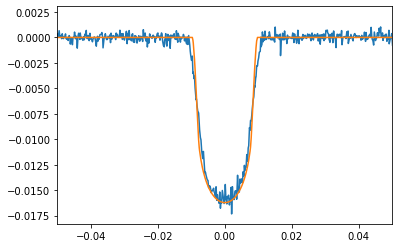

In [164]:
#plt.plot(hdu[1].data['PHASE']/tp, hdu[1].data['LC_WHITE'], marker='.', ls='None')
#plt.plot(df['phase'], df['flux'])
entries = os.listdir(FILEPATH_FPS)
hdu = fits.open(FILEPATH_FPS+entries[0])
m=entries[0]
kid=np.where(np.array(rv_kepid)==str(m[4:13]))[0]
print(kid, m)
df, tp, td = sort_data(hdu, 1)
plt.plot(df['phase'], df['flux'])
print(rpl[kid],u1[kid], u2[kid], rorb[kid], b[kid])
lc=new_plar_free2(df['phase'], rpl[kid],u1[kid], u2[kid], rorb[kid], b[kid])
plt.plot(df['phase'],lc)
plt.xlim(-0.05,0.05)
#plt.plot(hdu[1].data['P
# HASE']/tp, hdu[1].data['MODEL_WHITE'], marker='.', ls='None')

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


0.009969907499586917


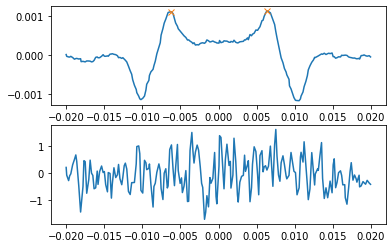

In [178]:
from scipy.signal import find_peaks

fig, ax = plt.subplots(2,1)
df=df[(df.phase>-0.02) & (df.phase<0.02)]
lc=new_plar_free2(df['phase'], rpl[kid],u1[kid], u2[kid], rorb[kid], b[kid])
ph=np.array(df['phase'])
ax[0].plot(df['phase'],np.convolve(df['flux']-lc,np.ones(20)/20,mode='same'))
ax[1].plot(df['phase'],np.convolve(df['flux_white']-df['model'], np.ones(2)/2, mode='same'))
res=np.convolve(df['flux']-lc,np.ones(20)/20,mode='same')
# popt1, pcov1 = curve_fit(lorz, df['phase'], res,p0=[max(res),min(df['phase'])/2,0.01,max(res),max(df['phase'])/2,0.01], 
#     bounds=([0,min(df['phase']),0.001,0,0,0.001],
#     [max(res), 0, .1,max(res), max(df['phase']),.1]))
peaks, _ = find_peaks(res, height=max(res)/2, distance=10)
ax[0].plot(ph[peaks], res[peaks], "x")

#print(popt1)
print(max(df['phase'])/2)
#ax[0].plot(df['phase'],lorz(df['phase'], *popt1))



Just sorting through the directory

In [6]:
list1 = np.array(os.listdir('../../processed_directories/go_circles/new_data/'))
list2 = np.array(os.listdir('../../processed_directories/go_circles/new_data_2/'))
for el in list1:
    if(np.any(list2 == el)): 
        #new data storage
        store1 = pd.HDFStore('../../processed_directories/go_circles/new_data/'+el)
        store2 = pd.HDFStore('../../processed_directories/go_circles/new_data_2/'+el)
        df1 = store1['data']
        df2 = store2['data']
        md1 = store1.get_storer('data').attrs.metadata
        md2 = store2.get_storer('data').attrs.metadata
        store1.close()
        store2.close()

        df=pd.DataFrame(list(zip(df2['phase'], df2['flux'], df2['flux_white'], df2['model'], df2['res'], df1['par'], df1['res'])),
        columns=['phase', 'flux','flux_white', 'model_white','res_white','fit','res_fit'])

        tp=md1['tp']
        td=md2['td']
        locdf=df[(df.phase>-2*td/tp) & (df.phase<2*td/tp)]
        out = df[(df.phase<-2*td/tp) | (df.phase>2*td/tp)]

        noise2 = np.std(np.array(out['flux_white']))
        min2 = min(locdf['model_white'])
        noise1 = np.std(np.array(out['flux']))
        min1 = min(locdf['fit'])

        if(-min2/noise2<3 or -min1/noise1<3): continue
        
        new_head = {'ploc_f':md1['ploc'],'pval_f':md1['pval'],'ploc_c':md2['ploc'],'pval_c':md2['pval'],
        'label':md1['label'],'rorb':md1['rorb'],'rpl':md1['rpl'],'u1':md1['u1'],'u2':md1['u2'],'b':md1['b'],
        'tp':md1['tp'],'td':md1['td'], 'snr_f':md1['snr'], 'snr_c':md2['snr'],'sig_snr_c':-min2/noise2, 'sig_snr_f':-min1/noise1}

        #new plotting
        
        fig, ax=plt.subplots(3,2, figsize=(10,10))
        ax[0][0].plot(df['phase'],df['flux_white'], label='flux')
        ax[0][0].plot(df['phase'],df['model_white'], label='model')
        ax[0][0].set_ylabel('flux')
        ax[0][0].set_title('snr:'+str(np.around(-min2/noise2,4)))
        ax[0][1].set_title('snr:'+str(np.around(-min1/noise1,4)))

        ax[0][1].plot(df['phase'],df['flux'], label='flux')
        ax[0][1].plot(df['phase'],df['fit'], label='model')

        ax[1][0].plot(locdf['phase'],locdf['flux_white'], label='flux')
        ax[1][0].plot(locdf['phase'],locdf['model_white'], label='model')
        ax[1][0].set_ylabel('flux')

        ax[1][1].plot(locdf['phase'],locdf['flux'], label='flux')
        ax[1][1].plot(locdf['phase'],locdf['fit'], label='model')

        ax[2][0].plot(locdf['phase'],locdf['res_white'], label='residual')
        ax[2][1].plot(locdf['phase'],locdf['res_fit'], label='residual')
        ax[2][0].scatter(md2['ploc'], md2['pval'])
        ax[2][1].scatter(md1['ploc'], md1['pval'])

        plt.suptitle(el+": "+str(md1['label'])+'\n tp: '+str(md1['tp'])+', td: '+str(md1['td']))
        ax[2][0].set_title('snr:'+str(np.around(md2['snr'],4)))
        ax[2][1].set_title('snr:'+str(np.around(md1['snr'],4)))
        ax[2][0].set_xlabel('phase')
        ax[2][1].set_xlabel('phase')
        ax[2][0].set_ylabel('flux - model')
        ax[0][0].legend()
        ax[1][0].legend()
        ax[2][0].legend()
        ax[0][1].legend()
        ax[1][1].legend()
        ax[2][1].legend()

        plt.savefig('../../processed_directories/go_circles/new_final_fits/'+el+'.jpg')
        store = pd.HDFStore('../../processed_directories/go_circles/new_final_data/'+el)
        store.put('data', df)
        store.get_storer('data').attrs.metadata = new_head
        store.close()
        plt.close()
        
        

SNR Table 

In [10]:
list = os.listdir('../../processed_directories/go_circles/new_final_data/')
t_el=[]
t_td=[]
t_tp=[]
t_label=[]
t_snr=[]
t_sigsnr=[]
t_rpl=[]
t_rorb=[]
t_u1=[]
t_u2=[]
t_b=[]
for el in list:
    store1 = pd.HDFStore('../../processed_directories/go_circles/new_final_data/'+el)
    df1 = store1['data']
    md1 = store1.get_storer('data').attrs.metadata
    store1.close()

    t_el.append(el)
    t_td.append(md1['td'])
    t_tp.append(md1['tp'])
    t_label.append(md1['label'][0])
    t_snr.append(md1['snr_f'])
    t_sigsnr.append(md1['sig_snr_f'])
    t_rpl.append(md1['rpl'][0])
    t_rorb.append(md1['rorb'][0])
    t_u1.append(md1['u1'][0])
    t_u2.append(md1['u2'][0])
    t_b.append(md1['b'][0])

t_el=np.array(t_el)
t_b=np.array(t_b)
t_label=np.array(t_label)
t_rorb=np.array(t_rorb)
t_td=np.array(t_td)
t_tp=np.array(t_tp)
t_sigsnr=np.array(t_sigsnr)
t_snr=np.array(t_snr)
t_u1=np.array(t_u1)
t_u2=np.array(t_u2)
t_rpl=np.array(t_rpl)
df=pd.DataFrame(zip(t_el, t_td, t_tp, t_label,t_snr, t_sigsnr, t_rpl, t_rorb, t_u1, t_u2, t_b),
    columns=['KID','transit duration', 'transit period', 'label', 'SNR of residual', 'SNR of signal','Rpl/Rst','Rorb/Rst','u1','u2','b'])
df=df.sort_values('SNR of residual',axis=0,ascending=False)
#df.to_csv('../../processed_directories/go_circles/Candidate_List.csv',sep=',', index=False)

for x,i in zip(df['KID'],np.arange(0,len(df))):
    os.rename('../../processed_directories/go_circles/new_final_fits/'+x+'.jpg',
        '../../processed_directories/go_circles/new_final_fits/rank'+str(i)+'_'+x+'.jpg')
    


### Fitting Model (Mandel and Algol 2002)

Run through directory to fit model to the lightcurves: The ones that dont fit properly are in the problist section, may have to approach them manually. 

In [96]:
#entries = os.listdir('../../processed_directories/go_circles/find_circles_rel/')
entries = np.loadtxt('../../processed_directories/go_circles/problem_nonfits', delimiter=' ', dtype='str')
print(len(entries))
#np.random.shuffle(entries)
problist=[]
for el in entries:
    
    df = pd.read_csv('../../processed_directories/go_circles/find_circles_rel/'+el+'.csv')
    flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
    fluxg = np.array([ x for x in df['flux_g'] if(not(np.isnan(x)))])
    phase = np.array(df['phase_l'])[:len(flux)]
    phaseg= np.array(df['phase_g'])[:len(fluxg)]
    #print(min(phaseg), max(phaseg))
   
    try: popt1,pcov1=curve_fit(new_plar_free2, phase, flux, bounds=([0.0001,-np.inf,-np.inf,1], [1,np.inf,np.inf,np.inf]))
    except: 
        print("no fit")
        problist.append(el[:11])
        continue
  
    
    print(el[:9],":",np.round(np.trace(pcov1),3),'ptd: ',np.round(popt1[0],5), 
        np.round((popt1[1]),3), np.round((popt1[2]),3), np.round(popt1[3],3))
     
    # if(popt1[1]>10 or popt1[2]>10):
    #     problist.append(el[:11])
    #     print('overboard')
    #     continue
    # if(popt1[3]<15.0001):
    #     problist.append(el[:11])
    #     print('under rad')
    #     continue
    # if(np.trace(pcov1)>1000):
    #     print("fit variance")
    #     problist.append(el[:11])
    #     continue
    dfg = pd.DataFrame(zip(phaseg,fluxg, new_plar_free2(np.array(phaseg), *popt1)),
        columns=['phase_g','flux_g','model_g'])
    dfl= pd.DataFrame(zip(phase, flux,new_plar_free2(np.array(phase), *popt1)),
        columns=[ 'phase_l', 'flux_l','model_l'])
    df1 = [dfl, dfg]
    df1 = pd.concat(df1, axis=1)

    store = pd.HDFStore('../../processed_directories/go_circles/temp/'+el[:11])
    store.put('data', df1)
    store.get_storer('data').attrs.metadata = {'attr':popt1, 
        'var':np.trace(pcov1)}
    store.close()

np.savetxt('../../processed_directories/go_circles/list_of_nonfits',problist,delimiter=' ',fmt="%s")

307
001025986 : 18868558.37 ptd:  0.13859 53.039 -556.139 218.2
001723078 : 1169116.189 ptd:  0.21136 55.601 -527.574 108.41
no fit
002299738 : 750358362.821 ptd:  0.1864 50.29 -2539.184 24.299
no fit
002299738 : 150562419.394 ptd:  0.2249 45.016 -218.895 41.008
no fit
no fit
003102384 : 625946.687 ptd:  0.18653 53.976 -501.075 13.971
003129238 : 8856123205.126 ptd:  0.12382 66.203 -381.997 114.74
003129238 : 20457109420.944 ptd:  0.2319 67.483 -358.212 3.579
003218908 : 100927.107 ptd:  0.2359 44.904 -325.039 11.894
003236705 : 3053582.01 ptd:  0.26415 43.922 -302.598 74.841
003239171 : 11144520.318 ptd:  0.18942 52.193 -465.153 16.495
no fit
003242039 : 23759312.896 ptd:  0.07962 32.219 -212.27 390.497
no fit
003338885 : 9530.312 ptd:  0.23196 43.884 -319.947 13.302
no fit
003348216 : 1686314.466 ptd:  0.21677 55.674 -482.735 20.68
003426367 : 3592706596.956 ptd:  0.23617 50.168 -399.136 132.087
003442055 : 20240.887 ptd:  0.2084 55.268 -493.948 12.537
003534076 : 7385685666911.768 p

[4094] 0.10981287885443204 24.269382146166258
-0.0239866264164447 0.0239902157336473
[ 0.42479079 -0.01083846  0.00089592  0.53452767  0.01002808  0.00092373] [ 0.14277209 -0.02158796  0.1         0.14277209  0.02159119  0.1       ]


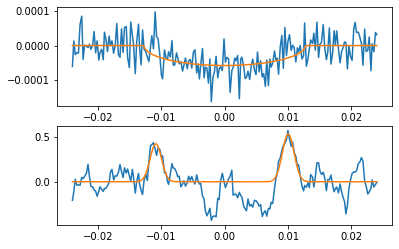

In [28]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
el = entries[100]
store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_rel/'+el)
df = store['data']
metadata = store.get_storer('data').attrs.metadata
store.close()

loc=np.where(np.asarray(rv_kepid)==el[:9])[0]
rv_loc_f = [x for x in loc if(str(rv_pl[x])==el[10:11])]
if(len(rv_loc_f)==0): 
    print("not in catalog")


print(rv_loc_f, av_time[rv_loc_f[0]]/(24*av_p[rv_loc_f[0]]), metadata['var'])
phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])
flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
model = np.array([ x for x in df['model_l'] if(not(np.isnan(x)))])
res = np.convolve(df['flux_l']-df['model_l'], np.ones(10)/10, mode='same')
res = np.array([(el-np.median(res))/(max(res)-min(res)) for el in res])
popt1, pcov1 = curve_fit(gausses, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,0.0001], [max(res), 0, .1,max(res), 0.9*max(phase),.1]))
    
popt2, pcov2 = curve_fit(lorz, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,00.0001], [max(res), 0, .1,max(res), 0.9*max(phase), .1]))
print(min(phase),max(phase))
print(popt1, popt2)
fig, ax=plt.subplots(2,1)
ax[0].plot(df['phase_l'], df['flux_l'])
ax[0].plot(df['phase_l'], df['model_l'])
ax[1].plot(df['phase_l'], res )
ax[1].plot(phase,gausses(phase, *popt1))
#ax[1].plot(phase, lorz(phase, *popt2))
#ax[1].plot(phase, gausses(phase,0.3,-0.03,0.004,0.3,0.03,0.004))
#ax[0].set_xlim(-0.1,0.1)
#ax[1].set_xlim(-0.1,0.1)


### Finding Residuals
Fitting Gaussian/ Lorentzian Profiles to circles to see where we can get some recognisable peaks...

In [4]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
problist=[]
for el in entries:
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_rel/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    store.close()

    try: 
        loc=np.where(np.asarray(rv_kepid)==el[:9])[0]
        rv_loc_f = [x for x in loc if(str(rv_pl[x])==el[10:11])]
        #print(rv_loc_f, el)
    except: 
        print("not in catalog")
        continue

    if(len(rv_loc_f)==0): 
        print("not in catalog")
        continue
   
    k = np.ones(10)/10
    flux = np.convolve(np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))]),k,mode='same')
    model = np.convolve(np.array([ x for x in df['model_l'] if(not(np.isnan(x)))]),k,mode='same')
    #flux = np.array(df['flux_l'])
    #model = np.array(df['model_l'])

    res = np.convolve(flux - model, k ,mode='same')
    phase = np.array(df['phase_l'])[:len(res)]
    try: popt1, pcov1 = curve_fit(gausses, phase, res, bounds=([max(res)/4,0.9*min(phase),0.0001,max(res)/4,0,0.0001], [max(res), 0, .1,max(res), 0.9*max(phase),.1]))
    except: 
        print("no gauss fit")
        continue
    
    print(el[:9],'ptd: ', np.abs(popt1[1]-popt1[4]))
     
    dfl = pd.DataFrame(zip(phase,flux,model,res, gausses(phase, *popt1)),
        columns=['phase_l', 'flux_l', 'model_l','residue', 'gaussian'])
    dfg = pd.DataFrame(zip(df['phase_g'],df['flux_g'],df['model_g']),
        columns=['phase_g','flux_g','model_g'])
    df1 = [dfl, dfg]
    df1 = pd.concat(df1, axis=1)
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el[:11])
    store.put('data', df1)
    store.get_storer('data').attrs.metadata = {'label':rv_label[rv_loc_f[0]],'gauss':popt1,'model':metadata['attr'],
        'mod_var':metadata['var'],'gdur':np.abs(popt1[1]-popt1[4]) ,'g_cov':np.trace(pcov1)}
    store.close()


np.savetxt('../../processed_directories/go_circles/list_of_nonfits_residue',problist,delimiter=' ',fmt="%s")

001432789 ptd:  0.039160015138841535
001432789 ptd:  0.06456902891939215
not in catalog
001718958 ptd:  0.0694090223747067
001721157 ptd:  0.03154737758910253
001724719 ptd:  0.03919199781637095
001724719 ptd:  0.021728502149280057
001725016 ptd:  0.019640151281155312
001865042 ptd:  0.03209011307148063
001871056 ptd:  0.022074523682486732
001871056 ptd:  0.010111486375067286
001995519 ptd:  0.008716520323851512
001996180 ptd:  0.06451026537657994
001996180 ptd:  0.03575211955249745
002019477 ptd:  0.03515839873908011
002019477 ptd:  0.03629915575695772
002142522 ptd:  0.020581191178762608
002161536 ptd:  0.010792455575288672
002161949 ptd:  0.024677676630598853
002165002 ptd:  0.019596514105796402
002299738 ptd:  0.25965343384519235
002301068 ptd:  0.023245475974778447
002302548 ptd:  0.018870348508024395
002305866 ptd:  0.027779974827328913
002305866 ptd:  0.01076490076235444
002307415 ptd:  0.02591625200584527
002307415 ptd:  0.019763043833292734
002422820 ptd:  0.023612694028103114

### Cumulative Batch Plotting

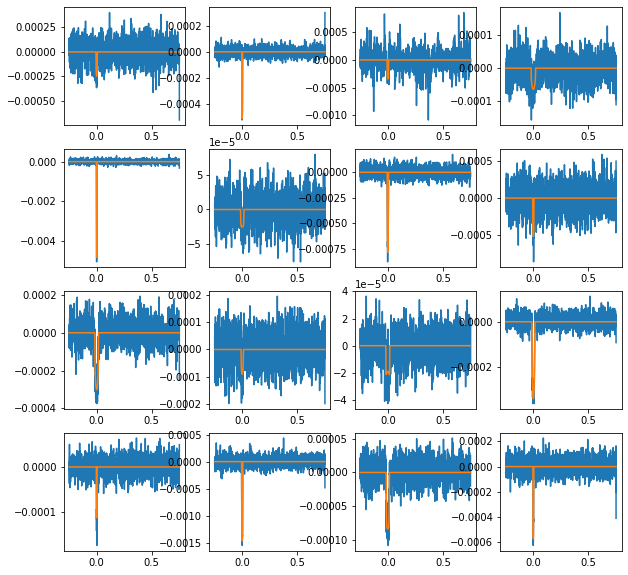

In [6]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_with_res/')
#np.loadtxt('../../processed_directories/go_circles/hot_jupiters')
np.random.shuffle(entries)
fig, axs = plt.subplots(4,4,figsize=(10,10))


for el,ax in zip(entries[:16],axs.ravel()):
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    #df = pd.read_csv('../../processed_directories/go_circles/find_circles_rel/'+el)
    ax.plot(df['phase_g'],df['flux_g'])
    ax.plot(df['phase_g'],df['model_g'])
    #ax.legend()
    #print(metadata['gauss'], metadata['lorz'])
    #ax.plot(df['phase_l'],df['residue'])
    #ax.plot(df['phase_l'],df['gaussian'])
    #ax.plot(df['phase_l'],df['lorentzian'])
    #ax.set_xlim(-0.2,0.2)
    store.close()

### Selection of promising results

Filter out the ones where the gaussian peaks can actually correspond to the residual features we're looking for

In [7]:
entries = os.listdir('../../processed_directories/go_circles/fit_circles_with_res/')
for el in entries:
    store = pd.HDFStore('../../processed_directories/go_circles/fit_circles_with_res/'+el)
    df = store['data']
    try: metadata = store.get_storer('data').attrs.metadata
    except: 
        store.close()
        continue
    
    dur1 = metadata['gdur']
    arr1 = metadata['gauss']
    phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])
    dur = max(phase)-min(phase)
    if((dur1 < dur/2) and arr1[1]>-1.1*dur/4 and arr1[4]<1.1*dur/4): 
            store2 = pd.HDFStore('../../processed_directories/go_circles/analyse_circles_rel/'+el[:11])
        
            data = store['data']
            print(dur/2,dur1,arr1[1], arr1[4])

            store2.put('data', data)
            store2.get_storer('data').attrs.metadata = metadata
            store2.close()
        
    store.close()

0.0287958355620503 0.02591625200584527 -0.012953162658959594 0.012963089346885675
0.037070220336318 0.0333631983026862 -0.01667785160243511 0.01668534670025109
0.00963094783946865 0.008739562952866212 -0.0036023937162565707 0.005137169236609642
0.02654185146093365 0.023887666314840288 -0.01192779270932076 0.011959873605519526
0.05318580195307725 0.04786722175776953 -0.023918427899479844 0.023948793858289682
0.08841101452708239 0.07956991307437417 -0.039787405729293825 0.039782507345080334
0.01728310063481325 0.015554790571331925 -0.007775165699422335 0.00777962487190959
0.0347375236451625 0.03126377128064625 -0.015644213743507832 0.015619557537138421
0.0782484598457813 0.07042361386120316 -0.03521812520921229 0.03520548865199088
0.025223194621503298 0.02270087515935297 -0.011353913974016864 0.011346961185336105
0.2154977023601532 0.19394793212413788 -0.09696557745337486 0.09698235467076302
0.040994221344590145 0.036894799210131134 -0.018476510792970646 0.018418288417160488
0.2429422810

### Final Plotting
Plot out the results and manually filter the plots.

KeyboardInterrupt: 

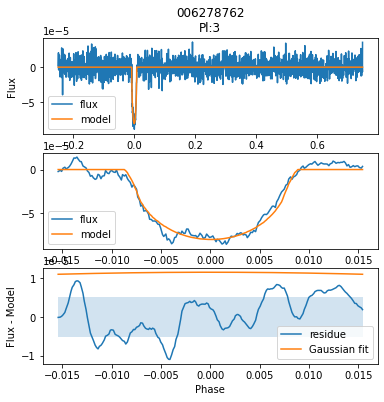

In [10]:
entries = os.listdir('../../processed_directories/go_circles/analyse_circles_rel/')
#np.random.shuffle(entries)

for el in entries[:60]:
    fig, ax = plt.subplots(3,1,figsize=(6,6))
    store = pd.HDFStore('../../processed_directories/go_circles/analyse_circles_rel/'+el)
    df = store['data']
    
    phase=df['phase_l']
    mn = np.mean(df['residue']**2)
    #k = np.ones(2)/2
    ax[0].plot(df['phase_g'],df['flux_g'], label='flux')
    ax[0].plot(df['phase_g'],df['model_g'], label='model')
    ax[1].plot(phase,df['flux_l'], label='flux')
    ax[1].plot(phase,df['model_l'], label='model')
    ax[2].plot(phase,df['residue'], label='residue')
    ax[2].plot(phase,df['gaussian'], label='Gaussian fit')
    ax[0].set_ylabel('Flux')
    ax[2].set_xlabel('Phase')
    ax[2].set_ylabel('Flux - Model')
    ax[2].fill_between(phase, np.sqrt(mn)*np.ones(len(phase)), -np.sqrt(mn)*np.ones(len(phase)), alpha=0.2)
    ax[1].legend()
    ax[0].legend()
    ax[2].legend()
    ax[0].set_title(el[:9]+'\nPl:'+el[10:])
    plt.savefig('../../processed_directories/go_circles/'+el+'.jpg')
    plt.close()
    store.close()

### Plotting for good fits
Make plots for good fits!!!


In [99]:
entries = os.listdir('../../processed_directories/go_circles/temp/')
#np.random.shuffle(entries)
global i
problist=[]
i=0
for el in entries:
    fig, ax = plt.subplots(3,1,figsize=(8,8))
    store = pd.HDFStore('../../processed_directories/go_circles/temp/'+el)
    df = store['data']
    metadata = store.get_storer('data').attrs.metadata
    attr = metadata['attr']
    if(metadata['var']<1000): 
        i+=1
        print(metadata['var'],attr[1], attr[2])

    # else: 
    #     plt.close()
    #     continue
    phase=df['phase_l']

    # if(attr[1]<-0.99999 or attr[1]>0.99999 or attr[2]<0.0000001 or attr[2]>0.99999):
    #     print('skip')
    #     #plt.close()
    #     #continue
    # else: continue


    problist.append(el)
    props = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
    txt = "$R_{pl}$/$R_{st}$:"+str(np.round(attr[0],4))+"\nu1:"+str(np.round((attr[2]+attr[1])/2,4
        ))+"\nu2:"+str(np.round((attr[2]-attr[1])/2,4))+"\n$R_{orb}/R_{st}$:"+str(np.round(attr[3],4))
    
    txt = "$R_{pl}$/$R_{st}$:"+str(np.round(attr[0],4))+"\nu1:"+str(np.round(attr[1],4
        ))+"\nu2:"+str(np.round(attr[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(attr[3],4))


    ax[0].text(0.80, 0.5, txt, fontsize=11,transform=ax[0].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=2, bbox=props, color='white')
    
    mn=  np.mean(np.array([x for x in (df['flux_l']-df['model_l'])**2 if not np.isnan(x)]))
    #k = np.ones(2)/2
    ax[0].plot(df['phase_g'],df['flux_g'], label='flux',color='#b19cd9')
    #ax[0].plot(df['phase_g'],df['model_g'], label='model', color='#311432')
    ax[1].plot(phase,df['flux_l'], label='flux', color='#7a4988', marker='.', ls='None')
    ax[1].plot(phase,df['model_l'], label='model',color='#311432')
    ax[2].plot(phase,df['flux_l']-df['model_l'], label='var:'+str(np.round(metadata['var'],5)), color='#7a4988', marker='.')
    #ax[2].plot(phase,df['gaussian'], label='Gaussian fit')
    ax[0].set_ylabel('Flux')
    ax[2].set_xlabel('Phase')
    ax[2].set_ylabel('Flux - Model')
    ax[2].fill_between(phase, np.sqrt(mn)*np.ones(len(phase)), -np.sqrt(mn)*np.ones(len(phase)), alpha=0.6, 
        color='#b19cd9',label='1$\sigma$')
    ax[1].legend()
    ax[0].legend()
    ax[2].legend()
    ax[0].set_title(el[:9]+'\nPl:'+el[10:])
    plt.savefig('../../processed_directories/go_circles/'+el+'.jpg')
    plt.close()
    store.close()

#np.savetxt('../../processed_directories/go_circles/hot_jupiters',problist,delimiter=' ',fmt="%s")

20.390218183509134 0.8710426606129442 -0.8102958073343549
13.886472104345989 0.4188713349288536 0.8029033726252136
6.3061342663660716 0.7119714550563011 -0.6062260133293765
5.573177774062482 -0.4810525186436465 1.6797200036984583
4.10769133866693 3.148964760818495 -4.1134790966513
2.6723014306498794 0.9302120809894315 -0.05933567819688893
100.05333118170921 0.6266883536283155 -1.0464223977321137
10.3144669402506 -1.6342410245469092 2.033995780417337
2.8347144729235563 2.348424116829937 -2.7636927952166563
3.5225164625133663 2.537350691118388 -3.069532938498947
53.33229738768644 -0.2524925320515648 0.5243826499264059
34.363065536081436 1.303879986173428 -0.7385790003922095
78.7878809044651 -0.7689129740189473 0.6229295951771665
65.20891518517728 0.563240711653983 -5.224328367321268
13.773666396389292 1.0929026894300975 -0.17624887440060327
35.06199191850771 1.0011913290007157 -1.8056290990814539
8.007055099248907 -2.83724682806234 3.561481804103654
56.115614213566225 -0.0693673720413379

### Manual Fitting

Here we write a quick handy few lines of code to do stuff manually... to check, and to finish fitting the rest.

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


0.0016700220389252384
['0.02872', '0.80636', '1.00000', '70.98020']


c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%
c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


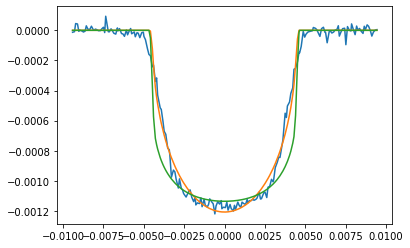

In [43]:
PATH = '../../processed_directories/go_circles/find_circles_rel/'
el = '004349452_1.csv'

df = pd.read_csv(PATH+el)

flux = np.array([ x for x in df['flux_l'] if(not(np.isnan(x)))])
phase = np.array([ x for x in df['phase_l'] if(not(np.isnan(x)))])

#some brute force shit
# uarr=np.linspace(0.1,2, 10)
# varr=np.linspace(0.1,0.9, 10)
# minpopt=[]
# mincov = 1000
# for u in uarr:
#     popt1,pcov1=curve_fit(new_plar_free2, phase, flux, bounds=([0,u-0.01*u,-0.1,10], [1,u+0.01*u,0.9,200]))
#     rchi = np.sum((flux/np.abs(min(flux)) - new_plar_free2(phase, *popt1)/np.abs(min(flux)))**2) / len(flux)
#     print(rchi)
#     if(rchi<mincov):
#         mincov = rchi
#         minpopt = popt1
minpopt,mincov=curve_fit(new_plar, phase, flux, bounds=([0,-0.1,0,10], [1,1,1,200]))


rchi = np.sum((flux/np.abs(min(flux)) - new_plar(phase, *minpopt)/np.abs(min(flux)))**2) / len(flux)
print(rchi)

plt.plot(phase, flux)
#print("fin:",np.trace(mincov))
plt.plot(phase, new_plar(phase, *minpopt))
plt.plot(phase, new_plar(phase, 0.031, 0.02,0.61, 70.9))
print(["{:.5f}".format(x) for x in minpopt])
plt.show()

Quick check on theoretical transit sims


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


[1.98591028e-01 7.48599494e-01 6.35812474e-19 4.96406484e+00
 1.84771405e-08] [1.97742355e-01 7.65841636e-01 1.08082463e-17 4.96806498e+00
 7.81220547e-07]


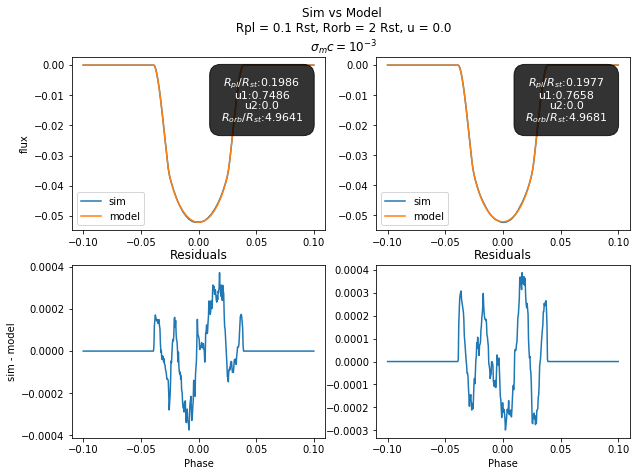

In [17]:
df = pd.read_csv('2d3d_0.2R_limb_circ_corr.csv', delimiter=',')
np.random.seed(10000)
#noise = np.random.normal(1,0.002777,len(df))
noise = np.ones(len(df))

d2=df['2d']-1
d3=df['3d']-1
ph = np.linspace(-1/5, 1/5, len(df))/2
d2n = np.convolve((df['2d']*noise-1),np.ones(5)/5, mode='same')
d3n = (df['3d']*noise-1)
#std2 = df['2dstd']
#std3 = df['3dstd']
#print(np.mean(np.array([d2/el for el in std2 if(el>0)])))
#print(np.mean(np.array([d3/el for el in std3 if(el>0)])))
#print(np.mean(std2), np.mean(std3))

par2d, cov2d=curve_fit(new_plar_v2, ph, d2, bounds=([0,0,0,2,0], [0.5,1,1,7,1]))
par3d, cov3d=curve_fit(new_plar_v2, ph, d3, bounds=([0,0,0,2,0], [0.5,1,1,7,1]))
#print(["{:.5f}".format(x) for x in minpopt])

fig, ax = plt.subplots(2,2, figsize=(10,7))
plt.suptitle('Sim vs Model\n Rpl = 0.1 Rst, Rorb = 2 Rst, u = 0.0\n $\sigma_mc = 10^{-3}$')

props = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
txt = "$R_{pl}$/$R_{st}$:"+str(np.round(par2d[0],4))+"\nu1:"+str(np.round(par2d[1],4
        ))+"\nu2:"+str(np.round(par2d[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(par2d[3],4))

props2 = dict(boxstyle='round', facecolor='black', alpha=0.8, pad=1)
txt2 = "$R_{pl}$/$R_{st}$:"+str(np.round(par3d[0],4))+"\nu1:"+str(np.round(par3d[1],4
        ))+"\nu2:"+str(np.round(par3d[2],4))+"\n$R_{orb}/R_{st}$:"+str(np.round(par3d[3],4))


ax[0][1].text(0.75, 0.75, txt, fontsize=11,transform=ax[0][1].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=1, bbox=props, color='white')

ax[0][0].text(0.75, 0.75, txt2, fontsize=11,transform=ax[0][0].transAxes,  horizontalalignment='center',
            verticalalignment='center', linespacing=1, bbox=props2, color='white')    

ax[0][0].plot(ph, d3n, label='sim', zorder=1)
ax[0][1].plot(ph, d2n, label='sim', zorder=1)
#ax[0][0].errorbar(ph, d3, std3,None, label='sim', zorder=2)
#ax[0][1].errorbar(ph, d2, std2,None, label='sim', zorder=2)

ax[0][0].plot(ph, new_plar_v2(ph, *par3d), label='model')
ax[0][1].plot(ph, new_plar_v2(ph, *par2d), label='model')
# ax[0][0].plot(ph, new_plar_free2(ph, 0.01, 0.45, 0.0, 2), label='model')
# ax[0][1].plot(ph, new_plar_free2(ph, 0.01, 0.45, 0.0, 2), label='model')
ax[0][0].legend(loc='lower left')
ax[1][1].set_xlabel('Phase')
ax[1][0].set_xlabel('Phase')
ax[1][0].set_ylabel('sim - model')
ax[0][0].set_ylabel('flux')
ax[0][1].legend(loc='lower left')
ax[1][0].set_title('Residuals')
ax[1][1].set_title('Residuals')
ax[1][0].plot(ph, d3-new_plar_v2(ph, *par3d))
ax[1][1].plot(ph, d2-new_plar_v2(ph, *par2d))
# ax[1][1].set_ylim(-0.00013,0.00013)
# ax[1][0].set_ylim(-0.00013,0.00013)
#plt.savefig('th_sim_fit_0.1R_n2.jpg')
print(par3d, par2d)
# dfop = pd.DataFrame(zip(ph,d3n,d2n,new_plar_free2(ph, *par3d),new_plar_free2(ph, *par2d)), columns=['phase', 'flux','flux2d', 'model','model2d'])
# dfop.to_csv('fprez_simp.csv', sep=',',index=False)
# plt.savefig('fprez_fit.jpg')



Signal to Noise Ratio Analysis

c:\Users\Hp\Documents\FYProj\alienworlds\Sims\transit.py:829: RuntimeWarning: invalid value encountered in sqrt
  k = 0.5 * np.sqrt((1. - a) / (z * p))  # 8%


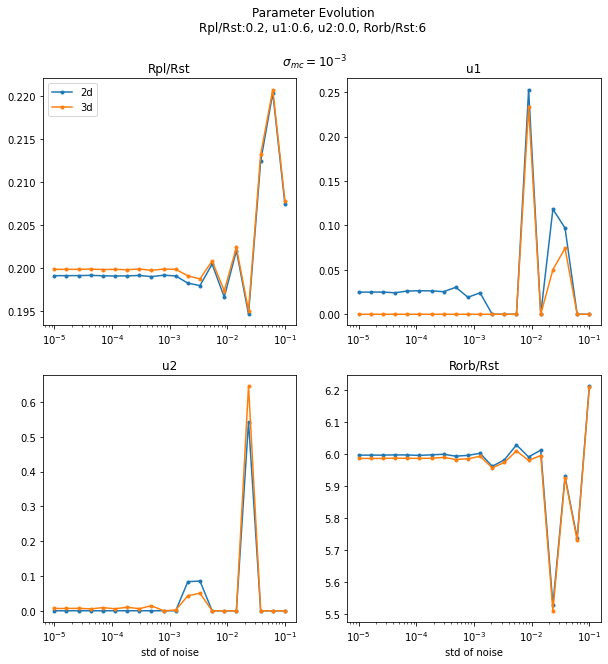

In [11]:
#d2 d3 std2 std3
df = np.loadtxt('2d3d_0.2R_circ.csv', delimiter=',')
np.random.seed(10000)

std_n = np.logspace(-1, -5, 20)
d2=df[:,1]-1
d3=df[:,3]-1
ph = df[:,0]*0.5/ np.pi
d2n = (df[:,1]*noise-1)
d3n = (df[:,3]*noise-1)
std2 = df[:,2]
std3 = df[:,4]

parrarr2d=[]
parrarr3d=[]
snrarr2=[]
snrarr3=[]
for el in std_n:
    noise = np.random.normal(1,el,len(df))
    d2n = (df[:,1]*noise-1)
    d3n = (df[:,3]*noise-1)
    #snr2 = np.mean(d2/(d2-d2n)**2)
    #snr3 = np.mean(d3/(d3-d3n)**2)
    #snrarr2.append(snr2)
    #snrarr3.append(snr3)
    par2d, cov2d=curve_fit(new_plar_free2, ph, d2n, bounds=([0,0,0,1], [1,1,1,10]))
    par3d, cov3d=curve_fit(new_plar_free2, ph, d3n, bounds=([0,0,0,1], [1,1,1,10]))
    parrarr2d.append(par2d)
    parrarr3d.append(par3d)

parrarr2d = np.asarray(parrarr2d)
parrarr3d = np.asarray(parrarr3d)
fig, ax = plt.subplots(2,2,figsize=(10,10))
plt.suptitle('Parameter Evolution\nRpl/Rst:0.2, u1:0.6, u2:0.0, Rorb/Rst:6\n \n $\sigma_{mc} = 10^{-3}$')
ax[0][0].plot(std_n,parrarr2d[:,0], marker='.', label='2d')
ax[0][0].plot(std_n,parrarr3d[:,0], marker='.', label='3d')
ax[0][0].set_title('Rpl/Rst')
ax[0][0].set_xscale('log')
ax[0][0].legend()
ax[0][1].plot(std_n,parrarr2d[:,1], marker='.')
ax[0][1].plot(std_n,parrarr3d[:,1], marker='.')
ax[0][1].set_title('u1')
ax[0][1].set_xscale('log')
ax[1][0].plot(std_n,parrarr2d[:,2], marker='.')
ax[1][0].plot(std_n,parrarr3d[:,2], marker='.')
ax[1][0].set_title('u2')
ax[1][0].set_xscale('log')
ax[1][0].set_xlabel('std of noise')
ax[1][1].plot(std_n,parrarr2d[:,3], marker='.')
ax[1][1].plot(std_n,parrarr3d[:,3], marker='.')
ax[1][1].set_title('Rorb/Rst')
ax[1][1].set_xscale('log')
ax[1][1].set_xlabel('std of noise')
plt.savefig('snr_calc.jpg')
plt.show()



Some labour work...

In [8]:
fins = os.listdir('../../processed_directories/go_circles/plots_rel/')
takeout1 = os.listdir('../../processed_directories/go_circles/fit_circles_rel/')
takeout2 = os.listdir('../../processed_directories/go_circles/temp/')

for el in fins:
    loc = np.where(np.asarray(takeout2)==el[:11])[0]
    #print(loc)

    if(len(loc)>0):
        store1 = pd.HDFStore('../../processed_directories/go_circles/temp/'+el[:11])
        try: df1 = store1['data']
        except: continue
        metadata = store1.get_storer('data').attrs.metadata
        metadata['method']='ind'
        print(metadata)

        store2 = pd.HDFStore('../../processed_directories/go_circles/final_fits/'+el[:11])
        
        data = store1['data']

        store2.put('data', data)
        store2.get_storer('data').attrs.metadata = metadata
        store2.close()
        store1.close()
    
    

{'attr': array([ 4.48705411e-02,  3.41655220e+00, -2.83432109e+00,  2.23965929e+02]), 'var': 690.8547192282656, 'method': 'ind'}
{'attr': array([1.06379397e-02, 7.09876862e-01, 1.35042185e+00, 2.03375197e+02]), 'var': 27.30844228960403, 'method': 'ind'}
{'attr': array([ 2.10527609e-02, -6.62186705e-02,  1.38530963e+00,  1.91085823e+02]), 'var': 567.3769385901734, 'method': 'ind'}
{'attr': array([ 1.75241745e-02,  4.96040411e-01, -1.36517388e+00,  2.12541651e+02]), 'var': 10.90258820392787, 'method': 'ind'}
{'attr': array([ 1.31833104e-02,  3.90943763e+00, -3.90730696e+00,  1.93298477e+02]), 'var': 12.647177287396964, 'method': 'ind'}
{'attr': array([ 2.57763987e-02,  1.92095363e+00, -3.06412059e+00,  1.89428994e+02]), 'var': 15.68053085429298, 'method': 'ind'}
{'attr': array([ 1.90220721e-02,  1.96905493e-01, -6.89636455e-01,  2.11070149e+02]), 'var': 67.25921403481495, 'method': 'ind'}
{'attr': array([ 1.39171762e-02,  2.35578580e+00, -1.97717775e+00,  2.09895642e+02]), 'var': 4.66999

In [9]:
takeout = os.listdir('../../processed_directories/go_circles/find_circles_rel/')
takin = os.listdir('../../processed_directories/go_circles/final_fits/')
problist=[]

for el in takeout:
    if(np.any(np.array(takin)==el[:11])):
        continue
    else: problist.append(el[:11])

np.savetxt('../../processed_directories/go_circles/problem_nonfits',problist,delimiter=' ',fmt="%s")
    


### Optimal Kepler Parameters
Plotting histograms of optimal kepler parameters to see what values we should take to construct our ideal simulation

C:\Users\Hp\AppData\Local\Temp/ipykernel_10520/2248811819.py:4: UserWarning: Warning: converting a masked element to nan.
  rorb = np.array([ x for x in df['koi_dor'] if not np.isnan(x)])
C:\Users\Hp\AppData\Local\Temp/ipykernel_10520/2248811819.py:5: UserWarning: Warning: converting a masked element to nan.
  rpl = np.array([ x for x in df['koi_ror'] if not np.isnan(x)])


[24.81  77.9   53.5   ...  4.331  6.04  12.06 ]
0.016150895 2.24189525


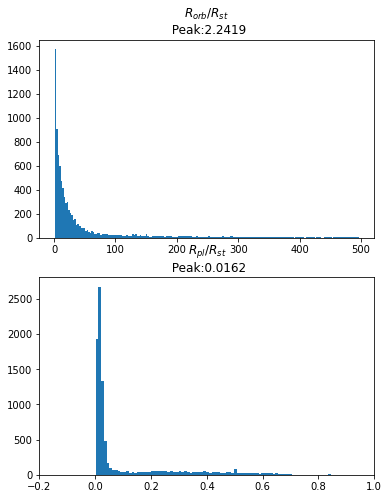

In [4]:
from astropy.io import ascii
df = ascii.read('../../Catalogs/ex_TCE_extra.tab')
# print(df['koi_ldm_coeff1'], df['koi_ldm_coeff2'], df['koi_dor'], df['koi_ror'])
rorb = np.array([ x for x in df['koi_dor'] if not np.isnan(x)])
rpl = np.array([ x for x in df['koi_ror'] if not np.isnan(x)])
#print(np.sum(rorb>1000))
rpl = np.array([x for x in rpl if x<1])
rorb = np.array([x for x in rorb if x>1 and x<500])
print(rorb)

fig, ax = plt.subplots(2,1,figsize=(6,8))
yo, xo, _ = ax[0].hist(rorb, bins=200)
yp, xp, _ = ax[1].hist(rpl, bins=100)

vp=(xp[np.where(yp == yp.max())[0]]+xp[np.where(yp == yp.max())[0]+1])[0]/2
vo=(xo[np.where(yo == yo.max())[0]]+xo[np.where(yo == yo.max())[0]+1])[0]/2

print(vp,vo)

ax[1].set_title('$R_{pl}/R_{st}$\n Peak:'+str(np.round(vp,4)))
ax[0].set_title('$R_{orb}/R_{st}$\n Peak:'+str(np.round(vo,4)))
ax[1].set_xlim(-0.2,1)

plt.savefig('parameter_histogram2.jpg')


C:\Users\Hp\AppData\Local\Temp/ipykernel_1196/352048212.py:1: UserWarning: Warning: converting a masked element to nan.
  us = np.array([[x,y] for x,y in zip(df['koi_ldm_coeff1'], df['koi_ldm_coeff2'])])


0
(array([8], dtype=int64), array([20], dtype=int64))
1572.0 [array([0.34492]), array([0.28126667])] [array([0.37236]), array([0.30136])]


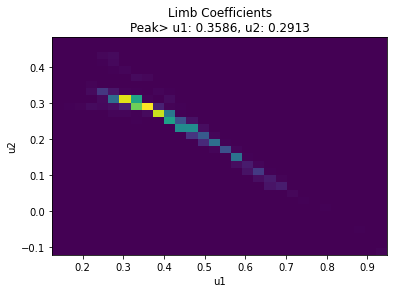

In [93]:
us = np.array([[x,y] for x,y in zip(df['koi_ldm_coeff1'], df['koi_ldm_coeff2'])])
us=np.array([el for el in us if not np.any(np.isnan(el))])
print(np.sum(np.isnan(us)))
z,x,y,_ = plt.hist2d(us[:,0], us[:,1], bins=(30,30))
#print(el)
#print(z)
wh = np.where(z==max(z.reshape(-1)))
print(wh)
print(max(yo),[x[wh[0]],y[wh[1]]], [x[wh[0]+1], y[wh[1]+1]])
v1 = (x[wh[0]][0]+x[wh[0]+1][0])/2
v2 = (y[wh[1]][0]+y[wh[1]+1][0])/2
plt.xlabel('u1')
plt.title('Limb Coefficients\nPeak> u1: '+str(np.round(v1,4))+', u2: '+str(np.round(v2,4)))
plt.ylabel('u2')

plt.savefig('parameter_histogram.jpg')
plt.show()

C:\Users\Hp\AppData\Local\Temp/ipykernel_10520/3339595693.py:1: UserWarning: Warning: converting a masked element to nan.
  snr = np.array([ x for x in df['koi_model_snr'] if not np.isnan(x)])


9564
67


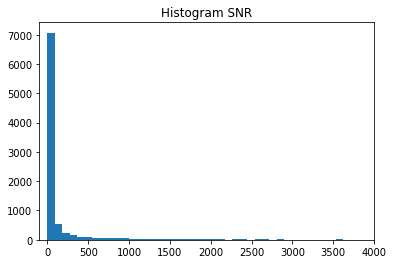

In [14]:
snr = np.array([ x for x in df['koi_model_snr'] if not np.isnan(x)])
print(len(snr))
print(np.sum(snr>5000))
y,x, _ = plt.hist(snr, bins=100)
#print(x,y)
plt.xlim(-100,4000)
plt.title('Histogram SNR')
plt.savefig('snr_hist.jpg')
plt.show()